## Load libraries

In [7]:
# Standard libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import random

# For downloading and unzipping files
import urllib.request
import zipfile

# Create wrapper for StandardScaler
import typing

# Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, 
    LabelBinarizer, 
    StandardScaler, 
    PolynomialFeatures
)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import (
    LinearRegression,
    HuberRegressor,
    Ridge,
    Lasso,
    ElasticNet
)
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)
from xgboost import XGBRegressor 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Saving files
import os
import pickle

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Load libraries
import requests
from bs4 import BeautifulSoup
import re

# Set viewing limits
pd.set_option('display.max_rows', 110)
pd.set_option('display.max_columns', 110)

## Load files

In [8]:
# Load files
X_reit = pd.read_csv('../data/X_reit.csv')
X_1 = pd.read_csv('../data/X_1.csv')
X_2 = pd.read_csv('../data/X_2.csv')
y_reit = pd.read_csv('../data/y_reit.csv')
y_1 = pd.read_csv('../data/y_1.csv')
y_2 = pd.read_csv('../data/y_2.csv')


df_results_reit = pd.read_csv('../data/df_results_reit.csv')
df_results_sample1 = pd.read_csv('../data/df_results_sample1.csv')
df_results_sample2 = pd.read_csv('../data/df_results_sample2.csv')
df_r2decrease_reit = pd.read_csv('../data/df_r2decrease_reit.csv')
df_featurerank_reit = pd.read_csv('../data/df_featurerank_reit.csv')

In [9]:
# Convert dates to date_time format
X_reit['DATE'] = pd.to_datetime(X_reit['DATE'])
X_1['DATE'] = pd.to_datetime(X_1['DATE'])
X_2['DATE'] = pd.to_datetime(X_2['DATE'])

y_reit['DATE'] = pd.to_datetime(y_reit['DATE'])
y_1['DATE'] = pd.to_datetime(y_1['DATE'])
y_2['DATE'] = pd.to_datetime(y_2['DATE'])

In [10]:
# Set DATE as index
X_reit.set_index('DATE', inplace = True)
X_reit.sort_index(inplace = True)
X_1.set_index('DATE', inplace = True)
X_1.sort_index(inplace = True)
X_2.set_index('DATE', inplace = True)
X_2.sort_index(inplace = True)

y_reit.set_index('DATE', inplace = True)
y_reit = y_reit.squeeze()
y_reit.sort_index(inplace = True)

y_1.set_index('DATE', inplace = True)
y_1 = y_1.squeeze()
y_1.sort_index(inplace = True)

y_2.set_index('DATE', inplace = True)
y_2 = y_2.squeeze()
y_2.sort_index(inplace = True)

In [11]:
# Restore index names
df_r2decrease_reit.index = X_reit.columns
df_featurerank_reit.index = X_reit.columns

## Custom functions for NNs
For neural networks, given the same model configuration and the same training dataset, a different internal set of weights will result each time the model is trained that will, in turn, have a different performance.

I adopt an ensemble approach to train our model, where I use multiple random seeds to initialise neural network estimtion and construct predictions by averaging forecasts from all networks. This reduces prediction variance.

Neural networks tend to overfit, so while previous machine learning models were fitted on the full train+validation set (assuming hyperparamters have been tuned and optimised) for out-of-sample testing, we can't do the same for neural networks. The final weights for a neural network will be determined by the validation set results through early stopping, so it is impossible to train the network again on the full train+validation set as the weights will be changed and sub-optimal without the benefit of early-stopping. So, custom function for walk-forward testing has to be changed.

In [57]:
# Split a dataset into train/validate/test sets
#  Assumes out-of-sample test window is one year only, is rolling forward one year at a time
def train_val_test_split(X, y, start_train, start_val, start_test):
    return X[f'{start_train}' : f'{start_val - 1}'], \
           X[f'{start_val}' : f'{start_test - 1}'], \
           X[f'{start_test}' : f'{start_test}'], \
           y[f'{start_train}' : f'{start_val - 1}'], \
           y[f'{start_val}' : f'{start_test - 1}'], \
           y[f'{start_test}' : f'{start_test}']

# Create RMSE function
def measure_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create custom out-of-sample R-squared function
#   where denominator is the sum of squared excess returns without de-meaning
def measure_r2(y_true, y_pred):
    numerator = (
        (y_true - y_pred) ** 2
    ).sum(axis=0)
    denominator = (
        (y_true) ** 2
    ).sum(axis=0)
    return (1 - numerator / denominator) * 100

# Create list of configs to test on 
def model_configs():
    # define scope of configs
    # create configs
    configs = []
    print('Total configs (XXX): %d' %len(configs))
    return configs

def model_fit(X_train, y_train, cfg):
    # unpack config
    return None

def model_predict(model, X_validate):
    # Convert to np.array before calling model.fit()
    #  to increase processing speed
    X_validate = np.asarray(X_validate)    
    
    # make predictions
    y_pred = model.predict(X_validate)
    return y_pred

# Grid search list of configs
# def grid_search(X_train, X_validate, y_train, y_validate, cfg_list):
#     # evaluate configs
#     scores = [repeat_evaluate(X_train, X_validate, y_train, y_validate, cfg) for cfg in cfg_list]
#     # sort configs by score
#     scores.sort(key = lambda tup: tup[1], reverse = True)
#     # store results
#     df_results.loc[df_results['Model Name'] == model_name, 'Selected Config'] = \
#         f'{scores[0][0]}'
#     df_results.loc[df_results['Model Name'] == model_name, 'Train (1990-2000)'] = \
#         f'{scores[0][3]:.2f} ({scores[0][4]:.1f})'
#     df_results.loc[df_results['Model Name'] == model_name, 'Validate (2001-2005)'] = \
#         f'{scores[0][1]:.2f} ({scores[0][2]:.1f})'
#     display(df_results)
#     return scores

def grid_search(X, y, start_train, start_val, start_test, cfg_list, df_results):
    
    # Create train and validate sets, ignore test set
    X_train, X_validate, _, y_train, y_validate, _ = \
    train_val_test_split(X, y, start_train, start_val, start_test)
    
    # evaluate configs
    scores = [repeat_evaluate(X_train, X_validate, y_train, y_validate, cfg) for cfg in cfg_list]
    
    # sort configs by score
    scores.sort(key = lambda tup: tup[1], reverse = True)
    
    # store results
    df_results.loc[df_results['Model Name'] == model_name, 'Selected Config'] = \
        f'{scores[0][0]}'
    df_results.loc[df_results['Model Name'] == model_name, f'Train ({start_train}-{start_val-1})'] = \
        f'{scores[0][3]:.2f} ({scores[0][4]:.2f})'
    df_results.loc[df_results['Model Name'] == model_name, f'Validate ({start_val}-{start_test-1})'] = \
        f'{scores[0][1]:.2f} ({scores[0][2]:.2f})'
    display(df_results)
    
    return scores

# Create repetitions of evaluations as an ensemble approach
def repeat_evaluate(X_train, X_validate, y_train, y_validate, cfg, n_repeats = 5):
    # convert config to a key for storing results later
    key = cfg
    # fit and evaluate n times
    scores = [evaluate(X_train, X_validate, y_train, y_validate, cfg) for _ in range(n_repeats)]
    # average the scores
    avg_result = np.average(scores, axis = 0)
    print()
    print(f'Ensemble results from Model {key}: {avg_result}')
    return (key, avg_result[0], avg_result[1], avg_result[2], avg_result[3])

# Evaluate one run of a neural network
def evaluate(X_train, X_validate, y_train, y_validate, cfg):
    
    # Fit and evaluate model
    model = model_fit(X_train, X_validate, y_train, y_validate, cfg)
    
    # Calculate predictions on validation set
    y_pred_validate = model_predict(model, X_validate)
    
    # Flatten multiple arrays into one (for Neural Network)
    y_pred_validate = [item for sublist in y_pred_validate for item in sublist]
    
    # Calculate validation scores
    r2_validate = measure_r2(y_validate, y_pred_validate)
    rmse_validate = measure_rmse(y_validate, y_pred_validate)

    # Calculate predictions on train set
    y_pred_train = model_predict(model, X_train)
    
    # Flatten multiple arrays into one (for Neural Network)
    y_pred_train = [item for sublist in y_pred_train for item in sublist]
    
    # Calculate train score
    r2_train = measure_r2(y_train, y_pred_train)
    rmse_train = measure_rmse(y_train, y_pred_train)
    
    # Display scores
    print(f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')
    return [r2_validate, rmse_validate, r2_train, rmse_train]

# Walk-forward testing, with validation set, unlike previous machine learning models
def walk_forward(selected_cfg, 
                 X, y, 
                 start_train, 
                 start_val, 
                 start_test, 
                 final_year_of_testing,
                 ensemble,
                 df_results):
    
    predictions = []

    for i in range(final_year_of_testing - start_test + 1):
        
        # Create train-test sets, no need for validate set
        X_train, X_validate, X_test, y_train, y_validate, y_test = \
        train_val_test_split(
            X, y, 
            start_train, 
            start_val + i, 
            start_test + i
        )
        
        y_pred_avg = []
        
        for j in range(ensemble):
            # Fit model
            model = model_fit(X_train, X_validate, y_train, y_validate, selected_cfg)
       
            # Pickle model
            filename = f'../pickle/{model_name}_{start_test + i}_{j}'
            model.save(filename)

            # Predicted values
            y_pred = model_predict(model, X_test)
            # Flatten multiple arrays into one (for Neural Network)
            y_pred = [item for sublist in y_pred for item in sublist]
            
            # Append to y_pred_avg to create ensemble of predictions
            y_pred_avg.append(y_pred)
            
        # Average ensemble of predicted values
        y_pred_avg = np.average(y_pred_avg, axis = 0)
        predictions.append(y_pred_avg)
        
        print(f'Test year {start_test + i} done, R2 score is {measure_r2(y_test, y_pred_avg):.2f}')
        print(f'Test year {start_test + i} done, RMSE score is {measure_rmse(y_test, y_pred_avg):.2f}')
        
        # Store results
        df_results.loc[df_results['Model Name'] == model_name, f'Test ({start_test + i})'] = \
            f'{measure_r2(y_test, y_pred_avg):.2f} ({measure_rmse(y_test, y_pred_avg):.2f})'

    # Extract y_test values    
    y_true = y[f'{start_test}' : f'{final_year_of_testing}']
    
    # Flatten multiple arrays of predictions into one array
    predictions = [item for sublist in predictions for item in sublist]
   
    # Calculate scores
    r2_oos = measure_r2(y_true, predictions)
    rmse_oos = measure_rmse(y_true, predictions)
    
    # Save scores
    df_results.loc[df_results['Model Name'] == model_name, f'Test ({start_test}-{final_year_of_testing})'] = \
            f'{r2_oos:.2f} ({rmse_oos:.2f})'
    
    # Display scores
    display(df_results)
    print()
    print(f'R2 for entire pooled test set, from {start_test} to {final_year_of_testing}, is {r2_oos:.2f}.')
    print(f'RMSE for entire pooled test set, from {start_test} to {final_year_of_testing}, is {rmse_oos:.2f}.')
    print()
    
    return r2_oos, rmse_oos

    
## Modify custom function to flatten arrays generated by PLS (and in future, NN)
def create_r2decrease(model_name, 
                      X, y,
                      start_train, 
                      start_val, 
                      start_test, 
                      ensemble,
                      final_year_of_testing):
    
    # Inititate empty dataframe to store results
    df_temp = pd.DataFrame(index = X.columns)

    for i in range(final_year_of_testing - start_test + 1):
        # Create train-test sets
        X_train, _, _, y_train, _, _ = \
        train_val_test_split(
            X, y, 
            start_train, 
            start_val + i, 
            start_test + i
        )
        
        r2drop_avg = []
        
#         ## TOO SLOW, RUN AGAIN AFTER CAPSTONE OVER
#         for j in range(ensemble):
        
#             # Load pickled model
#             filename = f'../pickle/{model_name}_{start_test + i}_{j}'
#             model = load_model(filename)

#             # Calculate R2 with all features present
#             y_pred = model_predict(model, X_train)

#             # Flatten multiple arrays into one (for Neural Network)
#             y_pred = [item for sublist in y_pred for item in sublist]
#             r2_all_features = measure_r2(y_train, y_pred)

#             # Calculate R2 by setting feature of interest to zero
#             r2drop = []
#             for feature in X.columns:
#                 print(f'Working on {model_name}_{start_test + i}_{j}: setting {feature} to zero...')
#                 X_train_minus = X_train.copy()
#                 X_train_minus[feature] = 0
#                 y_pred_minus = model_predict(model, X_train_minus)
#                 # Flatten predictions
#                 y_pred_minus = [item for sublist in y_pred_minus for item in sublist]
#                 r2_minus_feature = measure_r2(y_train, y_pred_minus)
#                 r2decrease = r2_all_features - r2_minus_feature
#                 r2drop.append(r2decrease)
                
#             # Append one run of neural network's R2 drops to ensemble of 5 runs
#             r2drop_avg.append(r2drop)

########################################################################
        ## LOADING ONLY 1 MODEL PER YEAR, to speed up processing
        # Load pickled model
        filename = f'../pickle/{model_name}_{start_test + i}_0'
        model = load_model(filename)
        
        # Calculate R2 with all features present
        y_pred = model_predict(model, X_train)

        # Flatten multiple arrays into one (for Neural Network)
        y_pred = [item for sublist in y_pred for item in sublist]
        r2_all_features = measure_r2(y_train, y_pred)

        # Calculate R2 by setting feature of interest to zero
        r2drop = []
        for feature in X.columns:
            print(f'Working on {model_name}_{start_test + i}_0: setting {feature} to zero...')
            X_train_minus = X_train.copy()
            X_train_minus[feature] = 0
            y_pred_minus = model_predict(model, X_train_minus)
            # Flatten predictions
            y_pred_minus = [item for sublist in y_pred_minus for item in sublist]
            r2_minus_feature = measure_r2(y_train, y_pred_minus)
            r2decrease = r2_all_features - r2_minus_feature
            r2drop.append(r2decrease)
        
        r2drop_avg.append(r2drop)
########################################################################

        # Average ensemble of predicted values
        r2drop_avg = np.average(r2drop_avg, axis = 0)
  
        df_temp[start_test + i] = r2drop_avg  
        
    # Sum across all years, then normalize to sum of 1
    df_temp[model_name] = df_temp.sum(axis=1)
    df_temp[model_name] = df_temp[model_name] / df_temp[model_name].sum()
    
    return df_temp
    

## NN1 (L2 penalty)

### REIT

In [6]:
df_results_reit = df_results_reit[:13]

In [7]:
# Create list of configs to test on 
def model_configs():
    # define scope of configs
    n_penalty_type = [l2]
    n_penalty_amount = np.logspace(-5, -3, 5)
    n_learning_rate = [0.001, 0.01]
    # create configs
    configs = []
    for i in n_penalty_type:
        for j in n_penalty_amount:
            for k in n_learning_rate:
                cfg = [i,j,k]
                configs.append(cfg)
    print('Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): %d' %len(configs))
    return configs

def model_fit(X_train, X_validate, y_train, y_validate, cfg):
    # unpack config
    n_penalty_type, n_penalty_amount, n_learning_rate = cfg
    
    # Instantiate a Sequential model
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(32, activation = 'relu', 
                    input_dim = X_train.shape[1], 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())
    
    # Add an output layer
    model.add(Dense(1, activation = None, 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Set learning rate
    opt = Adam(learning_rate = n_learning_rate)
    
    # Compile model
    model.compile(loss = 'mse',optimizer = opt)

    # Early stop
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5
    )    
    
    # Convert to np.array before calling model.fit()
    #  to speed up calculations
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)    
    X_validate = np.asarray(X_validate)
    y_validate = np.asarray(y_validate) 
    
    # Fit model
    model.fit(X_train, y_train,
              validation_data = (X_validate, y_validate),
              epochs = 500,
              batch_size = 2 ** 13,
              callbacks = [early_stop]
             )
   
    return model

In [8]:
# Instantiate list of configurations
cfg_list = model_configs()

Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): 10


In [9]:
%%time
# Create model name 
model_name = 'nn1-l2_reit'

# Create new row of test results
df_results_reit = pd.concat(
    [df_results_reit, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_reit
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500


2021-11-06 21:08:51.650394: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-06 21:08:51.650576: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 6. Tune using inter_op_parallelism_threads for best performance.


21360/21360 [==============================] - 1s 53us/sample - loss: 111.4610 - val_loss: 107.4853
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 110.8649 - val_loss: 107.1452
Epoch 3/500
21360/21360 [==============================] - 0s 4us/sample - loss: 110.4264 - val_loss: 106.8366
Epoch 4/500
21360/21360 [==============================] - 0s 4us/sample - loss: 110.0395 - val_loss: 106.5644
Epoch 5/500
21360/21360 [==============================] - 0s 4us/sample - loss: 109.7125 - val_loss: 106.3257
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.4146 - val_loss: 106.1175
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.1240 - val_loss: 105.9223
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.9086 - val_loss: 105.7462
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.6816 - val_loss: 105.5888
Epoch 10/500

21360/21360 [==============================] - 0s 3us/sample - loss: 107.8786 - val_loss: 103.8495
Epoch 17/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.7715 - val_loss: 103.8040
Epoch 18/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.6711 - val_loss: 103.7629
Epoch 19/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.5643 - val_loss: 103.7240
Epoch 20/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.4658 - val_loss: 103.6894
Epoch 21/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.3760 - val_loss: 103.6534
Epoch 22/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.2888 - val_loss: 103.6214
Epoch 23/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.1890 - val_loss: 103.5909
Epoch 24/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.1046 - val_loss: 103.5626
Epoch

21360/21360 [==============================] - 1s 45us/sample - loss: 110.2202 - val_loss: 106.8713
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.1225 - val_loss: 105.7917
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.3148 - val_loss: 105.2141
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.8576 - val_loss: 104.9543
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.3867 - val_loss: 104.9226
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.9455 - val_loss: 105.0690
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.5815 - val_loss: 105.3465
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.1510 - val_loss: 105.7017
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.6838 - val_loss: 106.2383
Epoch 10/500

21360/21360 [==============================] - 0s 3us/sample - loss: 105.8120 - val_loss: 104.0592
Epoch 33/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.7235 - val_loss: 104.0567
Epoch 34/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.6566 - val_loss: 104.0521
Epoch 35/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.5610 - val_loss: 104.0526
Epoch 36/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.4729 - val_loss: 104.0631
Epoch 37/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.3762 - val_loss: 104.0667
Epoch 38/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.2991 - val_loss: 104.0768
Epoch 39/500
21360/21360 [==============================] - 0s 4us/sample - loss: 105.2141 - val_loss: 104.0888
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 1.08, 10.20, 3.32, 10.27
Train on 21360 samples, va

Epoch 29/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.5551 - val_loss: 102.8286
Epoch 30/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.4834 - val_loss: 102.8333
Epoch 31/500
21360/21360 [==============================] - 0s 4us/sample - loss: 106.4007 - val_loss: 102.8425
Epoch 32/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.3171 - val_loss: 102.8533
Epoch 33/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.2373 - val_loss: 102.8599
Epoch 34/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.1687 - val_loss: 102.8690
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 2.24, 10.14, 2.44, 10.32
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 44us/sample - loss: 110.5611 - val_loss: 106.0495
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - 

Epoch 25/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.4060 - val_loss: 103.5614
Epoch 26/500
21360/21360 [==============================] - 0s 4us/sample - loss: 106.3381 - val_loss: 103.5604
Epoch 27/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.2228 - val_loss: 103.5557
Epoch 28/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.1547 - val_loss: 103.5537
Epoch 29/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.0764 - val_loss: 103.5589
Epoch 30/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.0053 - val_loss: 103.5735
Epoch 31/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.9313 - val_loss: 103.5794
Epoch 32/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.8500 - val_loss: 103.5850
Epoch 33/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.7789 - val_loss: 1

21360/21360 [==============================] - 0s 3us/sample - loss: 110.2914 - val_loss: 106.4081
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.9223 - val_loss: 106.1483
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.6306 - val_loss: 105.9189
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.4087 - val_loss: 105.7084
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.1729 - val_loss: 105.5321
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.9861 - val_loss: 105.3676
Epoch 10/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.8113 - val_loss: 105.2253
Epoch 11/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.6478 - val_loss: 105.0921
Epoch 12/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.4963 - val_loss: 104.9703
Epoch 13/5

Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.9565 - val_loss: 103.1703
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.5581 - val_loss: 103.3189
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.1002 - val_loss: 103.5032
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.6216 - val_loss: 103.6616
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.49, 10.18, 4.01, 10.23
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 49us/sample - loss: 110.3382 - val_loss: 104.9016
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.0996 - val_loss: 104.4574
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.1043 - val_loss: 104.3336
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.6102 - val_lo

Epoch 36/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.4597 - val_loss: 104.1157
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 1.06, 10.20, 3.12, 10.28
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 42us/sample - loss: 110.8435 - val_loss: 104.2944
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 110.3421 - val_loss: 104.2077
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.9477 - val_loss: 104.1364
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.6158 - val_loss: 104.0811
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.3345 - val_loss: 104.0298
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.1122 - val_loss: 103.9801
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss:

Epoch 49/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.0353 - val_loss: 104.2337
Epoch 50/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.9468 - val_loss: 104.2257
Epoch 51/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.8472 - val_loss: 104.2137
Epoch 52/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.7759 - val_loss: 104.2053
Epoch 53/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.6888 - val_loss: 104.2048
Epoch 54/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.6084 - val_loss: 104.2032
Epoch 55/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.5256 - val_loss: 104.2066
Epoch 56/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.4363 - val_loss: 104.2112
Epoch 57/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.3603 - val_loss: 1

21360/21360 [==============================] - 0s 3us/sample - loss: 106.5216 - val_loss: 103.3693
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.0659 - val_loss: 103.3270
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.5844 - val_loss: 103.5314
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.1693 - val_loss: 103.8725
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.6160 - val_loss: 104.1744
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.0801 - val_loss: 104.5935
Epoch 10/500
21360/21360 [==============================] - 0s 3us/sample - loss: 103.5280 - val_loss: 104.9916
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.24, 10.25, 4.94, 10.18
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 41us/sample - loss: 109.9710 - v

21360/21360 [==============================] - 0s 3us/sample - loss: 105.6562 - val_loss: 103.5823
Epoch 35/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.5794 - val_loss: 103.5856
Epoch 36/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.4919 - val_loss: 103.5882
Epoch 37/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.4124 - val_loss: 103.5921
Epoch 38/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.3322 - val_loss: 103.5984
Epoch 39/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.2359 - val_loss: 103.6108
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 1.58, 10.18, 3.34, 10.27
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 51us/sample - loss: 111.5295 - val_loss: 109.0489
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 111.0079 - val_loss: 108

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.44, 10.24, 3.64, 10.25
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 52us/sample - loss: 110.1079 - val_loss: 104.8799
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.2074 - val_loss: 104.3627
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 107.3215 - val_loss: 103.9571
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.7263 - val_loss: 103.7315
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 106.2897 - val_loss: 103.6716
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.8525 - val_loss: 103.7566
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 105.3645 - val_loss: 103.8465
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 104.8660 - val_los

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)              NaN          NaN   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0              NaN            NaN            NaN           NaN            NaN   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00 (9.46)  0.00 (9.44)  0.00 (7.04)   0.00 (7.47)  0.00 (9.09)   
1   3.18 (9.31)  1.38 (9.37)  1.59 (6.99)  -2.95 (7.58)  2.22 (8.98)   
2   3.28 (9.31)  1.25 (9.38)  3.36 (6.92)  -1.87 (7.54)  2.06 (8.99)   
3   2.65 (9.34)  1.65 (9.36)  3.06 (6.93)  -1.88 (7.54)  1.71 (9.01)   
4   1.09 (9.41)  0.70 (9.40)  2.18 (6.96)  -2.61 (7.57)  1.41 (9.02)   
5   3.80 (9.28)  1.91 (9.35)  2.74 (6.94)  -1.82 (7.54)  2.31 (8.98)   
6   3.42 (9.30)  1.89 (9.35)  3.51 (6.

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 1.40, 10.19, 2.84, 10.30
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.35, 10.19, 3.04, 10.29
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 1.19, 10.20, 3.57, 10.26
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 1.16, 10.20, 3.17, 10.28
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.97, 10.21, 3.35, 10.27
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.43, 10.24, 4.32, 10.22
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.40, 10.24, 4.31, 10.22
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.32, 10.24, 4.20, 10.22
CPU times: user 6min 58s, sys: 4min 45s, total: 11min 43s
Wall time: 3min 6s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 1.40, 10.19, 2.84, 10.30

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.35, 10.19, 3.04, 10.29

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 1.19, 10.20, 3.57, 10.26

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 1.16, 10.20, 3.17, 10.28

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.97, 10.21, 3.35, 10.27

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.43, 10.24, 4.32, 10.22

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.40, 10.24, 4.31, 10.22

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.32, 10.24, 4.20, 10.22

CPU times: user 6min 58s, sys: 4min 45s, total: 11min 43s

Wall time: 3min 6s

In [10]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_reit
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_reit.to_csv('../data/df_results_reit.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 41us/sample - loss: 110.9016 - val_loss: 105.8088
Epoch 2/500
21360/21360 [==============================] - 0s 4us/sample - loss: 110.4314 - val_loss: 105.6280
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 110.0667 - val_loss: 105.4665
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.7391 - val_loss: 105.3257
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.4541 - val_loss: 105.2088
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.2038 - val_loss: 105.1022
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.9812 - val_loss: 105.0091
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.7557 - val_loss: 104.9307
Epoch 9/500
21360/21360 [==============================] - 0s

2021-11-06 21:12:01.981810: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2006_0/assets
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 42us/sample - loss: 111.0978 - val_loss: 104.6572
Epoch 2/500
21360/21360 [==============================] - 0s 4us/sample - loss: 110.5902 - val_loss: 104.4755
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 110.1734 - val_loss: 104.3304
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.8029 - val_loss: 104.2096
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 109.5021 - val_loss: 104.1060
Epoch 6/500
21360/21360 [==============================] - 0s 4us/sample - loss: 109.2170 - val_loss: 104.0254
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.9824 - val_loss: 103.9541
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 108.7653 - val_loss:

23469/23469 [==============================] - 0s 3us/sample - loss: 112.9229 - val_loss: 82.8349
Epoch 14/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.7760 - val_loss: 82.7399
Epoch 15/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.6443 - val_loss: 82.6504
Epoch 16/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.5073 - val_loss: 82.5704
Epoch 17/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.3825 - val_loss: 82.4905
Epoch 18/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.2679 - val_loss: 82.4165
Epoch 19/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.1416 - val_loss: 82.3461
Epoch 20/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.0267 - val_loss: 82.2803
Epoch 21/500
23469/23469 [==============================] - 0s 3us/sample - loss: 111.9185 - val_loss: 82.2180
Epoch 22/500
2

Epoch 6/500
23469/23469 [==============================] - 0s 3us/sample - loss: 114.3509 - val_loss: 85.0665
Epoch 7/500
23469/23469 [==============================] - 0s 3us/sample - loss: 114.0906 - val_loss: 84.8662
Epoch 8/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.8548 - val_loss: 84.6818
Epoch 9/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.6450 - val_loss: 84.5173
Epoch 10/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.4734 - val_loss: 84.3610
Epoch 11/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.2788 - val_loss: 84.2147
Epoch 12/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.1186 - val_loss: 84.0752
Epoch 13/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.9595 - val_loss: 83.9409
Epoch 14/500
23469/23469 [==============================] - 0s 3us/sample - loss: 112.8129 - val_loss: 83.8209
Epoch

23469/23469 [==============================] - 1s 38us/sample - loss: 116.0825 - val_loss: 86.3711
Epoch 2/500
23469/23469 [==============================] - 0s 3us/sample - loss: 115.5924 - val_loss: 86.0861
Epoch 3/500
23469/23469 [==============================] - 0s 3us/sample - loss: 115.1675 - val_loss: 85.8359
Epoch 4/500
23469/23469 [==============================] - 0s 3us/sample - loss: 114.8359 - val_loss: 85.6092
Epoch 5/500
23469/23469 [==============================] - 0s 3us/sample - loss: 114.5032 - val_loss: 85.3926
Epoch 6/500
23469/23469 [==============================] - 0s 3us/sample - loss: 114.2501 - val_loss: 85.2005
Epoch 7/500
23469/23469 [==============================] - 0s 3us/sample - loss: 114.0065 - val_loss: 85.0240
Epoch 8/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.7889 - val_loss: 84.8587
Epoch 9/500
23469/23469 [==============================] - 0s 3us/sample - loss: 113.5897 - val_loss: 84.7069
Epoch 10/500
23469/23

INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2008_3/assets
Train on 25480 samples, validate on 10448 samples
Epoch 1/500
25480/25480 [==============================] - 1s 36us/sample - loss: 116.8728 - val_loss: 83.7710
Epoch 2/500
25480/25480 [==============================] - 0s 3us/sample - loss: 116.3647 - val_loss: 83.5582
Epoch 3/500
25480/25480 [==============================] - 0s 3us/sample - loss: 116.0031 - val_loss: 83.3821
Epoch 4/500
25480/25480 [==============================] - 0s 3us/sample - loss: 115.6915 - val_loss: 83.2043
Epoch 5/500
25480/25480 [==============================] - 0s 3us/sample - loss: 115.4166 - val_loss: 83.0428
Epoch 6/500
25480/25480 [==============================] - 0s 3us/sample - loss: 115.1648 - val_loss: 82.9069
Epoch 7/500
25480/25480 [==============================] - 0s 3us/sample - loss: 114.9568 - val_loss: 82.7928
Epoch 8/500
25480/25480 [==============================] - 0s 3us/sample - loss: 114.7460 - val_loss: 82.697

29523/29523 [==============================] - 0s 3us/sample - loss: 110.3315 - val_loss: 233.2970
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2010_0/assets
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 1s 30us/sample - loss: 113.8476 - val_loss: 233.7685
Epoch 2/500
29523/29523 [==============================] - 0s 3us/sample - loss: 113.2395 - val_loss: 233.6904
Epoch 3/500
29523/29523 [==============================] - 0s 3us/sample - loss: 112.7966 - val_loss: 233.6488
Epoch 4/500
29523/29523 [==============================] - 0s 3us/sample - loss: 112.4190 - val_loss: 233.6288
Epoch 5/500
29523/29523 [==============================] - 0s 3us/sample - loss: 112.0939 - val_loss: 233.6089
Epoch 6/500
29523/29523 [==============================] - 0s 3us/sample - loss: 111.8269 - val_loss: 233.5981
Epoch 7/500
29523/29523 [==============================] - 0s 3us/sample - loss: 111.5869 - val_loss: 233.6006
Ep

31753/31753 [==============================] - 0s 3us/sample - loss: 106.1687 - val_loss: 260.6215
Epoch 15/500
31753/31753 [==============================] - 0s 3us/sample - loss: 106.0454 - val_loss: 260.6289
Epoch 16/500
31753/31753 [==============================] - 0s 3us/sample - loss: 105.9295 - val_loss: 260.6297
Epoch 17/500
31753/31753 [==============================] - 0s 3us/sample - loss: 105.8098 - val_loss: 260.6378
Epoch 18/500
31753/31753 [==============================] - 0s 3us/sample - loss: 105.7057 - val_loss: 260.6558
Epoch 19/500
31753/31753 [==============================] - 0s 3us/sample - loss: 105.5802 - val_loss: 260.6675
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2011_3/assets
Train on 31753 samples, validate on 9643 samples
Epoch 1/500
31753/31753 [==============================] - 1s 33us/sample - loss: 109.3451 - val_loss: 260.7165
Epoch 2/500
31753/31753 [==============================] - 0s 4us/sample - loss: 108.8654 - val_loss: 260.652

35928/35928 [==============================] - 0s 3us/sample - loss: 102.7233 - val_loss: 266.7851
Epoch 28/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.6436 - val_loss: 266.7371
Epoch 29/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.5639 - val_loss: 266.7144
Epoch 30/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.4909 - val_loss: 266.7016
Epoch 31/500
35928/35928 [==============================] - 0s 4us/sample - loss: 102.4111 - val_loss: 266.6931
Epoch 32/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.3338 - val_loss: 266.6855
Epoch 33/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.2427 - val_loss: 266.6858
Epoch 34/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.1643 - val_loss: 266.6566
Epoch 35/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.0873 - val_loss: 266.6201
Epoch

35928/35928 [==============================] - 0s 3us/sample - loss: 103.6836 - val_loss: 267.1791
Epoch 18/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.5702 - val_loss: 267.0804
Epoch 19/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.4732 - val_loss: 267.0003
Epoch 20/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.3759 - val_loss: 266.9014
Epoch 21/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.2816 - val_loss: 266.8241
Epoch 22/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.1908 - val_loss: 266.7643
Epoch 23/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.1034 - val_loss: 266.6927
Epoch 24/500
35928/35928 [==============================] - 0s 3us/sample - loss: 103.0203 - val_loss: 266.6292
Epoch 25/500
35928/35928 [==============================] - 0s 3us/sample - loss: 102.9470 - val_loss: 266.5593
Epoch

37784/37784 [==============================] - 0s 3us/sample - loss: 116.6797 - val_loss: 204.0185
Epoch 28/500
37784/37784 [==============================] - 0s 3us/sample - loss: 116.5897 - val_loss: 204.0184
Epoch 29/500
37784/37784 [==============================] - 0s 3us/sample - loss: 116.4931 - val_loss: 203.9486
Epoch 30/500
37784/37784 [==============================] - 0s 3us/sample - loss: 116.3995 - val_loss: 203.9285
Epoch 31/500
37784/37784 [==============================] - 0s 3us/sample - loss: 116.3144 - val_loss: 203.9661
Epoch 32/500
37784/37784 [==============================] - 0s 3us/sample - loss: 116.2192 - val_loss: 204.0406
Epoch 33/500
37784/37784 [==============================] - 0s 3us/sample - loss: 116.1180 - val_loss: 203.9833
Epoch 34/500
37784/37784 [==============================] - 0s 2us/sample - loss: 116.0209 - val_loss: 203.9395
Epoch 35/500
37784/37784 [==============================] - 0s 3us/sample - loss: 115.9033 - val_loss: 203.9921
INFO:

Epoch 32/500
39556/39556 [==============================] - 0s 2us/sample - loss: 139.3365 - val_loss: 92.6280
Epoch 33/500
39556/39556 [==============================] - 0s 2us/sample - loss: 139.2304 - val_loss: 92.6383
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2015_1/assets
Train on 39556 samples, validate on 10230 samples
Epoch 1/500
39556/39556 [==============================] - 1s 23us/sample - loss: 144.8176 - val_loss: 94.4809
Epoch 2/500
39556/39556 [==============================] - 0s 2us/sample - loss: 144.1544 - val_loss: 94.3042
Epoch 3/500
39556/39556 [==============================] - 0s 2us/sample - loss: 143.6645 - val_loss: 94.1530
Epoch 4/500
39556/39556 [==============================] - 0s 2us/sample - loss: 143.2340 - val_loss: 94.0208
Epoch 5/500
39556/39556 [==============================] - 0s 2us/sample - loss: 142.8937 - val_loss: 93.9024
Epoch 6/500
39556/39556 [==============================] - 0s 2us/sample - loss: 142.6061 - val_loss: 93.7

Epoch 38/500
39556/39556 [==============================] - 0s 3us/sample - loss: 138.5384 - val_loss: 93.0007
Epoch 39/500
39556/39556 [==============================] - 0s 2us/sample - loss: 138.4359 - val_loss: 92.9849
Epoch 40/500
39556/39556 [==============================] - 0s 2us/sample - loss: 138.3135 - val_loss: 93.0034
Epoch 41/500
39556/39556 [==============================] - 0s 3us/sample - loss: 138.1877 - val_loss: 93.0160
Epoch 42/500
39556/39556 [==============================] - 0s 3us/sample - loss: 138.0644 - val_loss: 93.0043
Epoch 43/500
39556/39556 [==============================] - 0s 2us/sample - loss: 137.9448 - val_loss: 92.9810
Epoch 44/500
39556/39556 [==============================] - 0s 2us/sample - loss: 137.8328 - val_loss: 92.9716
Epoch 45/500
39556/39556 [==============================] - 0s 2us/sample - loss: 137.7125 - val_loss: 92.9727
Epoch 46/500
39556/39556 [==============================] - 0s 2us/sample - loss: 137.5786 - val_loss: 92.9785
E

41396/41396 [==============================] - 0s 2us/sample - loss: 141.3078 - val_loss: 74.6177
Epoch 21/500
41396/41396 [==============================] - 0s 2us/sample - loss: 141.2321 - val_loss: 74.6102
Epoch 22/500
41396/41396 [==============================] - 0s 2us/sample - loss: 141.1676 - val_loss: 74.6053
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2016_0/assets
Train on 41396 samples, validate on 10863 samples
Epoch 1/500
41396/41396 [==============================] - 1s 22us/sample - loss: 144.6869 - val_loss: 75.7824
Epoch 2/500
41396/41396 [==============================] - 0s 2us/sample - loss: 144.0743 - val_loss: 75.6652
Epoch 3/500
41396/41396 [==============================] - 0s 2us/sample - loss: 143.6560 - val_loss: 75.5699
Epoch 4/500
41396/41396 [==============================] - 0s 2us/sample - loss: 143.3210 - val_loss: 75.4826
Epoch 5/500
41396/41396 [==============================] - 0s 3us/sample - loss: 143.0536 - val_loss: 75.4258
Epoch 6/

Epoch 15/500
41396/41396 [==============================] - 0s 3us/sample - loss: 141.5251 - val_loss: 74.6379
Epoch 16/500
41396/41396 [==============================] - 0s 3us/sample - loss: 141.4406 - val_loss: 74.6459
Epoch 17/500
41396/41396 [==============================] - 0s 3us/sample - loss: 141.3414 - val_loss: 74.6592
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2016_3/assets
Train on 41396 samples, validate on 10863 samples
Epoch 1/500
41396/41396 [==============================] - 1s 23us/sample - loss: 145.4386 - val_loss: 75.4743
Epoch 2/500
41396/41396 [==============================] - 0s 3us/sample - loss: 144.8227 - val_loss: 75.3589
Epoch 3/500
41396/41396 [==============================] - 0s 3us/sample - loss: 144.3903 - val_loss: 75.2628
Epoch 4/500
41396/41396 [==============================] - 0s 3us/sample - loss: 144.0227 - val_loss: 75.1804
Epoch 5/500
41396/41396 [==============================] - 0s 3us/sample - loss: 143.7127 - val_loss: 75.

43327/43327 [==============================] - 0s 3us/sample - loss: 138.6943 - val_loss: 71.9172
Epoch 22/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.6026 - val_loss: 71.9170
Epoch 23/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.4875 - val_loss: 71.9112
Epoch 24/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.3843 - val_loss: 71.9155
Epoch 25/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.2890 - val_loss: 71.9347
Epoch 26/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.1897 - val_loss: 71.9506
Epoch 27/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.0785 - val_loss: 71.9953
Epoch 28/500
43327/43327 [==============================] - 0s 3us/sample - loss: 137.9809 - val_loss: 72.0251
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2017_1/assets
Train on 43327 samples, validate on 11340 samples
Epoc

Epoch 15/500
43327/43327 [==============================] - 0s 3us/sample - loss: 139.2346 - val_loss: 71.2786
Epoch 16/500
43327/43327 [==============================] - 0s 3us/sample - loss: 139.1164 - val_loss: 71.2613
Epoch 17/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.9951 - val_loss: 71.2573
Epoch 18/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.8821 - val_loss: 71.2604
Epoch 19/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.7655 - val_loss: 71.2811
Epoch 20/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.6707 - val_loss: 71.2803
Epoch 21/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.5594 - val_loss: 71.2764
Epoch 22/500
43327/43327 [==============================] - 0s 3us/sample - loss: 138.4616 - val_loss: 71.2789
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2017_4/assets
Test year 2017 done, R2 score is -0.05
Te

45304/45304 [==============================] - 0s 2us/sample - loss: 136.3747 - val_loss: 64.8548
Epoch 22/500
45304/45304 [==============================] - 0s 3us/sample - loss: 136.2685 - val_loss: 64.8664
Epoch 23/500
45304/45304 [==============================] - 0s 3us/sample - loss: 136.1562 - val_loss: 64.8668
Epoch 24/500
45304/45304 [==============================] - 0s 3us/sample - loss: 136.0457 - val_loss: 64.8801
Epoch 25/500
45304/45304 [==============================] - 0s 2us/sample - loss: 135.9561 - val_loss: 64.8700
Epoch 26/500
45304/45304 [==============================] - 0s 3us/sample - loss: 135.8452 - val_loss: 64.8856
INFO:tensorflow:Assets written to: ../pickle/nn1-l2_reit_2018_2/assets
Train on 45304 samples, validate on 11733 samples
Epoch 1/500
45304/45304 [==============================] - 1s 21us/sample - loss: 140.8319 - val_loss: 64.6937
Epoch 2/500
45304/45304 [==============================] - 0s 2us/sample - loss: 140.0918 - val_loss: 64.5169
Epoch

49786/49786 [==============================] - 0s 2us/sample - loss: 133.3954 - val_loss: 64.6153
Epoch 5/500
49786/49786 [==============================] - 0s 2us/sample - loss: 133.0595 - val_loss: 64.4868
Epoch 6/500
49786/49786 [==============================] - 0s 2us/sample - loss: 132.7916 - val_loss: 64.4238
Epoch 7/500
49786/49786 [==============================] - 0s 2us/sample - loss: 132.5862 - val_loss: 64.4039
Epoch 8/500
49786/49786 [==============================] - 0s 2us/sample - loss: 132.3958 - val_loss: 64.3921
Epoch 9/500
49786/49786 [==============================] - 0s 2us/sample - loss: 132.2315 - val_loss: 64.3839
Epoch 10/500
49786/49786 [==============================] - 0s 3us/sample - loss: 132.0711 - val_loss: 64.3855
Epoch 11/500
49786/49786 [==============================] - 0s 3us/sample - loss: 131.9391 - val_loss: 64.3984
Epoch 12/500
49786/49786 [==============================] - 0s 2us/sample - loss: 131.8076 - val_loss: 64.4247
Epoch 13/500
49786/

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00 (9.46)  0.00 (9.44)  0.00 (7.04)   0.00 (7.47)  0.00 (9.09)   
1   3.18 (9.31)  1.38 (9.37)  1.59 (6.99)  -2.95 (7.58)  2.22 (8.98)   
2   3.28 (9.31)  1.25 (9.38)  3.36 (6.92)  -1.87 (7.54)  2.06 (8.99)   
3   2.65 (9.34)  1.65 (9.36)  3.06 (6.93)  -1.88 (7.54)  1.71 (9.01)   
4   1.09 (9.41)  0.70 (9.40)  2.18 (6.96)  -2.61 (7.57)  1.41 (9.02)   
5   3.80 (9.28)  1.91 (9.35)  2.74 (6.94)  -1.82 (7.54)  2.31 (8.98)   
6   3.42 (9.30)  1.89 (9.35)  3.51 (6.


R2 for entire pooled test set, from 2006 to 2020, is 0.17.
RMSE for entire pooled test set, from 2006 to 2020, is 12.12.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001]
CPU times: user 12min 50s, sys: 8min 10s, total: 21min 1s
Wall time: 5min 20s


R2 for entire pooled test set, from 2006 to 2020, is 0.17.

RMSE for entire pooled test set, from 2006 to 2020, is 12.12.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001]

CPU times: user 12min 50s, sys: 8min 10s, total: 21min 1s

Wall time: 5min 20s


### Sample 1

In [11]:
df_results_sample1 = df_results_sample1[:13]

In [12]:
%%time
# Create model name 
model_name = 'nn1-l2_sample1'

# Create new row of test results
df_results_sample1 = pd.concat(
    [df_results_sample1, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample1
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 43us/sample - loss: 437.6345 - val_loss: 361.4828
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 436.8697 - val_loss: 361.3066
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 436.2942 - val_loss: 361.1450
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.6999 - val_loss: 361.0021
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.2126 - val_loss: 360.8619
Epoch 6/500
21360/21360 [==============================] - 0s 4us/sample - loss: 434.7126 - val_loss: 360.7365
Epoch 7/500
21360/21360 [==============================] - 0s 4us/sample - loss: 434.2911 - val_loss: 360.6212
Epoch 8/500
21360/21360 [==============================] - 0s 4us/sample - loss: 433.8378 - val_loss: 360.5177
Epoch 9/500
21360/21360 [==============================] - 0s

21360/21360 [==============================] - 0s 3us/sample - loss: 429.5929 - val_loss: 359.5054
Epoch 21/500
21360/21360 [==============================] - 0s 3us/sample - loss: 429.2544 - val_loss: 359.4747
Epoch 22/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.9798 - val_loss: 359.4484
Epoch 23/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.6787 - val_loss: 359.4290
Epoch 24/500
21360/21360 [==============================] - 0s 4us/sample - loss: 428.3494 - val_loss: 359.4153
Epoch 25/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.0777 - val_loss: 359.4115
Epoch 26/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.7642 - val_loss: 359.4042
Epoch 27/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.5060 - val_loss: 359.3845
Epoch 28/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.2453 - val_loss: 359.3713
Epoch

21360/21360 [==============================] - 0s 3us/sample - loss: 423.8912 - val_loss: 360.7061
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 422.1891 - val_loss: 360.9942
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 420.6244 - val_loss: 361.2241
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.01, 19.01, 3.44, 20.52
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 43us/sample - loss: 437.0260 - val_loss: 361.9268
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.8623 - val_loss: 360.8142
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 430.6317 - val_loss: 360.3539
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.8968 - val_loss: 360.1408
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.2463 - val_loss: 360.2791


Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.1385 - val_loss: 361.3628
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.7836 - val_loss: 361.2056
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.3862 - val_loss: 361.0622
Epoch 10/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.0555 - val_loss: 360.9314
Epoch 11/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.7578 - val_loss: 360.8122
Epoch 12/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.4084 - val_loss: 360.7071
Epoch 13/500
21360/21360 [==============================] - 0s 4us/sample - loss: 433.1079 - val_loss: 360.6062
Epoch 14/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.8097 - val_loss: 360.5108
Epoch 15/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.5310 - val_loss: 360.

Epoch 35/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.4444 - val_loss: 359.8126
Epoch 36/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.1558 - val_loss: 359.8057
Epoch 37/500
21360/21360 [==============================] - 0s 3us/sample - loss: 425.8613 - val_loss: 359.8013
Epoch 38/500
21360/21360 [==============================] - 0s 3us/sample - loss: 425.5658 - val_loss: 359.8031
Epoch 39/500
21360/21360 [==============================] - 0s 3us/sample - loss: 425.2785 - val_loss: 359.8002
Epoch 40/500
21360/21360 [==============================] - 0s 3us/sample - loss: 424.9908 - val_loss: 359.7939
Epoch 41/500
21360/21360 [==============================] - 0s 3us/sample - loss: 424.7563 - val_loss: 359.7937
Epoch 42/500
21360/21360 [==============================] - 0s 3us/sample - loss: 424.4166 - val_loss: 359.7955
Epoch 43/500
21360/21360 [==============================] - 0s 3us/sample - loss: 424.1553 - val_loss: 3

Epoch 12/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.4247 - val_loss: 360.1965
Epoch 13/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.0260 - val_loss: 360.1424
Epoch 14/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.7089 - val_loss: 360.0879
Epoch 15/500
21360/21360 [==============================] - 0s 4us/sample - loss: 431.3867 - val_loss: 360.0380
Epoch 16/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.0519 - val_loss: 359.9948
Epoch 17/500
21360/21360 [==============================] - 0s 3us/sample - loss: 430.7537 - val_loss: 359.9605
Epoch 18/500
21360/21360 [==============================] - 0s 3us/sample - loss: 430.4301 - val_loss: 359.9311
Epoch 19/500
21360/21360 [==============================] - 0s 3us/sample - loss: 430.1556 - val_loss: 359.9041
Epoch 20/500
21360/21360 [==============================] - 0s 3us/sample - loss: 429.8144 - val_loss: 3

21360/21360 [==============================] - 0s 3us/sample - loss: 433.5400 - val_loss: 360.6495
Epoch 10/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.1062 - val_loss: 360.5391
Epoch 11/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.6795 - val_loss: 360.4397
Epoch 12/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.2792 - val_loss: 360.3478
Epoch 13/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.8739 - val_loss: 360.2635
Epoch 14/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.5056 - val_loss: 360.1854
Epoch 15/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.1547 - val_loss: 360.1140
Epoch 16/500
21360/21360 [==============================] - 0s 3us/sample - loss: 430.7686 - val_loss: 360.0599
Epoch 17/500
21360/21360 [==============================] - 0s 3us/sample - loss: 430.4216 - val_loss: 360.0120
Epoch

21360/21360 [==============================] - 0s 3us/sample - loss: 434.1959 - val_loss: 362.8537
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.8363 - val_loss: 362.6957
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.5052 - val_loss: 362.5550
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.1920 - val_loss: 362.4248
Epoch 10/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.9151 - val_loss: 362.3052
Epoch 11/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.5879 - val_loss: 362.1975
Epoch 12/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.2983 - val_loss: 362.1063
Epoch 13/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.9934 - val_loss: 362.0182
Epoch 14/500
21360/21360 [==============================] - 0s 3us/sample - loss: 431.7259 - val_loss: 361.9428
Epoch 15

21360/21360 [==============================] - 0s 3us/sample - loss: 427.7578 - val_loss: 359.5996
Epoch 28/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.5019 - val_loss: 359.5917
Epoch 29/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.2315 - val_loss: 359.5962
Epoch 30/500
21360/21360 [==============================] - 0s 4us/sample - loss: 426.9580 - val_loss: 359.5997
Epoch 31/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.6788 - val_loss: 359.5943
Epoch 32/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.4136 - val_loss: 359.5999
Epoch 33/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.1509 - val_loss: 359.6198
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.46, 18.96, 2.06, 20.66
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 41us/sample - loss: 437.04

Epoch 23/500
21360/21360 [==============================] - 0s 3us/sample - loss: 429.5533 - val_loss: 360.1556
Epoch 24/500
21360/21360 [==============================] - 0s 3us/sample - loss: 429.2305 - val_loss: 360.1219
Epoch 25/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.9337 - val_loss: 360.1008
Epoch 26/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.6549 - val_loss: 360.0808
Epoch 27/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.3655 - val_loss: 360.0692
Epoch 28/500
21360/21360 [==============================] - 0s 3us/sample - loss: 428.0677 - val_loss: 360.0508
Epoch 29/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.7643 - val_loss: 360.0423
Epoch 30/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.4551 - val_loss: 360.0395
Epoch 31/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.1681 - val_loss: 3

21360/21360 [==============================] - 1s 41us/sample - loss: 436.2762 - val_loss: 359.7407
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 432.1621 - val_loss: 359.4201
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 429.6217 - val_loss: 359.4447
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 427.6991 - val_loss: 359.6558
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.1107 - val_loss: 360.0999
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 424.8230 - val_loss: 360.5416
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 423.2172 - val_loss: 360.9421
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.09, 19.00, 2.77, 20.59
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 41us/sample - loss: 436.7605 - v

21360/21360 [==============================] - 0s 3us/sample - loss: 436.0222 - val_loss: 364.9757
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.6354 - val_loss: 364.6825
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.2507 - val_loss: 364.4108
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.8882 - val_loss: 364.1661
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.5470 - val_loss: 363.9337
Epoch 9/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.2360 - val_loss: 363.7213
Epoch 10/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.9035 - val_loss: 363.5199
Epoch 11/500
21360/21360 [==============================] - 0s 3us/sample - loss: 433.6009 - val_loss: 363.3244
Epoch 12/500
21360/21360 [==============================] - 0s 4us/sample - loss: 433.3358 - val_loss: 363.1433
Epoch 13/5

Model Name                                   Selected Config  \
0         naive_sample1                                              N.A.   
1            lr_sample1                                              N.A.   
2   fama-french_sample1                                          bm, mve0   
3       carhart_sample1                                  bm, mve0, mom12m   
4         huber_sample1                                       [9, 0.0001]   
5         ridge_sample1                               [50084.07989848212]   
6         lasso_sample1                             [0.47148663634573895]   
7          enet_sample1                                        [0.3, 1.0]   
8           pcr_sample1                                                21   
9           pls_sample1                                                 1   
10           rf_sample1                                [200, 0.5, 15, 50]   
11           et_sample1                                [100, 0.5, 15, 30]   
12           xg_sample1                                [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)              NaN            NaN   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0             NaN            NaN            NaN            NaN            NaN   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)    Test (2016)  \
0   0.00 (12.77)   0.00 (12.20)   0.00 (11.34)   0.00 (14.08)   0.00 (16.07)   
1   0.52 (12.74)   2.52 (12.05)  -1.37 (11.42)  -1.45 (14.18)  -0.12 (16.08)   
2   0.74 (12.72)   2.08 (12.07)   0.01 (11.34)  -0.61 (14.12)   0.67 (16.01)   
3   0.76 (12.72)   2.29 (12.06)   0.03 (11.34)  -0.50 (14.11)   0.57 (16.02)   
4   0.54 (12.73)   2.45 (12.05)  -0.60 (11.37)  -1.17 (14.16)  -0.11 (16.07)   
5   0

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.46, 18.96, 2.05, 20.66
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.41, 18.97, 2.28, 20.64
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.32, 18.98, 2.46, 20.62
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.31, 18.98, 2.40, 20.63
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.31, 18.98, 2.46, 20.62
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.11, 19.00, 3.22, 20.54
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.11, 19.00, 3.18, 20.54
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.08, 19.00, 3.14, 20.55
CPU times: user 6min 27s, sys: 4min 27s, total: 10min 55s
Wall time: 2min 55s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.46, 18.96, 2.05, 20.66

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.41, 18.97, 2.28, 20.64

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.32, 18.98, 2.46, 20.62

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.31, 18.98, 2.40, 20.63

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.31, 18.98, 2.46, 20.62

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.11, 19.00, 3.22, 20.54

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.11, 19.00, 3.18, 20.54

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.08, 19.00, 3.14, 20.55

CPU times: user 6min 27s, sys: 4min 27s, total: 10min 55s

Wall time: 2min 55s

In [13]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample1
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample1.to_csv('../data/df_results_sample1.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 41us/sample - loss: 439.2694 - val_loss: 360.6061
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 438.2915 - val_loss: 360.4141
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 437.4607 - val_loss: 360.2516
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 436.6484 - val_loss: 360.1149
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.9760 - val_loss: 360.0014
Epoch 6/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.3803 - val_loss: 359.9018
Epoch 7/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.7842 - val_loss: 359.8171
Epoch 8/500
21360/21360 [==============================] - 0s 3us/sample - loss: 434.2742 - val_loss: 359.7474
Epoch 9/500
21360/21360 [==============================] - 0s

21360/21360 [==============================] - 0s 3us/sample - loss: 426.6401 - val_loss: 360.0046
Epoch 31/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.3716 - val_loss: 360.0038
Epoch 32/500
21360/21360 [==============================] - 0s 3us/sample - loss: 426.1209 - val_loss: 360.0027
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2006_3/assets
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 1s 42us/sample - loss: 437.1459 - val_loss: 361.9823
Epoch 2/500
21360/21360 [==============================] - 0s 3us/sample - loss: 436.5426 - val_loss: 361.8564
Epoch 3/500
21360/21360 [==============================] - 0s 3us/sample - loss: 436.0306 - val_loss: 361.7500
Epoch 4/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.5446 - val_loss: 361.6513
Epoch 5/500
21360/21360 [==============================] - 0s 3us/sample - loss: 435.1044 - val_loss: 361.5

23469/23469 [==============================] - 0s 3us/sample - loss: 454.5647 - val_loss: 252.3717
Epoch 35/500
23469/23469 [==============================] - 0s 3us/sample - loss: 454.3261 - val_loss: 252.3894
Epoch 36/500
23469/23469 [==============================] - 0s 3us/sample - loss: 454.0506 - val_loss: 252.4168
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2007_3/assets
Train on 23469 samples, validate on 10493 samples
Epoch 1/500
23469/23469 [==============================] - 1s 38us/sample - loss: 465.6684 - val_loss: 254.4920
Epoch 2/500
23469/23469 [==============================] - 0s 3us/sample - loss: 464.9814 - val_loss: 254.2394
Epoch 3/500
23469/23469 [==============================] - 0s 3us/sample - loss: 464.3660 - val_loss: 253.9928
Epoch 4/500
23469/23469 [==============================] - 0s 3us/sample - loss: 463.8068 - val_loss: 253.7659
Epoch 5/500
23469/23469 [==============================] - 0s 3us/sample - loss: 463.3063 - val_loss: 253.5

25480/25480 [==============================] - 0s 3us/sample - loss: 462.9302 - val_loss: 184.5903
Epoch 20/500
25480/25480 [==============================] - 0s 3us/sample - loss: 462.6690 - val_loss: 184.6186
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2008_4/assets
Test year 2008 done, R2 score is -1.57
Test year 2008 done, RMSE score is 20.22
Train on 27460 samples, validate on 10324 samples
Epoch 1/500
27460/27460 [==============================] - 1s 33us/sample - loss: 455.3629 - val_loss: 209.4761
Epoch 2/500
27460/27460 [==============================] - 0s 3us/sample - loss: 454.4733 - val_loss: 209.2106
Epoch 3/500
27460/27460 [==============================] - 0s 3us/sample - loss: 453.7184 - val_loss: 208.9323
Epoch 4/500
27460/27460 [==============================] - 0s 3us/sample - loss: 453.0754 - val_loss: 208.7602
Epoch 5/500
27460/27460 [==============================] - 0s 3us/sample - loss: 452.4749 - val_loss: 208.5938
Epoch 6/500
27460/27460 [===

31753/31753 [==============================] - 0s 3us/sample - loss: 409.6027 - val_loss: 312.6538
Epoch 9/500
31753/31753 [==============================] - 0s 3us/sample - loss: 409.2687 - val_loss: 312.6614
Epoch 10/500
31753/31753 [==============================] - 0s 3us/sample - loss: 408.9521 - val_loss: 312.6786
Epoch 11/500
31753/31753 [==============================] - 0s 3us/sample - loss: 408.6430 - val_loss: 312.7018
Epoch 12/500
31753/31753 [==============================] - 0s 3us/sample - loss: 408.3334 - val_loss: 312.7246
Epoch 13/500
31753/31753 [==============================] - 0s 3us/sample - loss: 408.0452 - val_loss: 312.7663
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2011_2/assets
Train on 31753 samples, validate on 9643 samples
Epoch 1/500
31753/31753 [==============================] - 1s 28us/sample - loss: 413.0141 - val_loss: 313.3228
Epoch 2/500
31753/31753 [==============================] - 0s 3us/sample - loss: 412.3456 - val_loss: 313.

35928/35928 [==============================] - 0s 3us/sample - loss: 383.1603 - val_loss: 312.7168
Epoch 9/500
35928/35928 [==============================] - 0s 3us/sample - loss: 382.7755 - val_loss: 312.7167
Epoch 10/500
35928/35928 [==============================] - 0s 3us/sample - loss: 382.4676 - val_loss: 312.7069
Epoch 11/500
35928/35928 [==============================] - 0s 3us/sample - loss: 382.1107 - val_loss: 312.7085
Epoch 12/500
35928/35928 [==============================] - 0s 3us/sample - loss: 381.8102 - val_loss: 312.7111
Epoch 13/500
35928/35928 [==============================] - 0s 3us/sample - loss: 381.5251 - val_loss: 312.7331
Epoch 14/500
35928/35928 [==============================] - 0s 3us/sample - loss: 381.2418 - val_loss: 312.7748
Epoch 15/500
35928/35928 [==============================] - 0s 3us/sample - loss: 380.9845 - val_loss: 312.8006
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2013_2/assets
Train on 35928 samples, validate on 9376 sa

37784/37784 [==============================] - 0s 3us/sample - loss: 382.2363 - val_loss: 257.1360
Epoch 13/500
37784/37784 [==============================] - 0s 3us/sample - loss: 381.9848 - val_loss: 257.1445
Epoch 14/500
37784/37784 [==============================] - 0s 3us/sample - loss: 381.7275 - val_loss: 257.1367
Epoch 15/500
37784/37784 [==============================] - 0s 3us/sample - loss: 381.5372 - val_loss: 257.1629
Epoch 16/500
37784/37784 [==============================] - 0s 3us/sample - loss: 381.3073 - val_loss: 257.2028
Epoch 17/500
37784/37784 [==============================] - 0s 3us/sample - loss: 381.1292 - val_loss: 257.2105
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2014_3/assets
Train on 37784 samples, validate on 9669 samples
Epoch 1/500
37784/37784 [==============================] - 1s 24us/sample - loss: 387.1690 - val_loss: 260.0047
Epoch 2/500
37784/37784 [==============================] - 0s 2us/sample - loss: 386.4965 - val_loss: 259

41396/41396 [==============================] - 0s 3us/sample - loss: 386.0057 - val_loss: 166.9430
Epoch 13/500
41396/41396 [==============================] - 0s 2us/sample - loss: 385.8178 - val_loss: 166.9052
Epoch 14/500
41396/41396 [==============================] - 0s 3us/sample - loss: 385.6019 - val_loss: 166.8484
Epoch 15/500
41396/41396 [==============================] - 0s 3us/sample - loss: 385.4331 - val_loss: 166.8420
Epoch 16/500
41396/41396 [==============================] - 0s 3us/sample - loss: 385.2388 - val_loss: 166.8032
Epoch 17/500
41396/41396 [==============================] - 0s 2us/sample - loss: 385.0658 - val_loss: 166.8842
Epoch 18/500
41396/41396 [==============================] - 0s 2us/sample - loss: 384.8807 - val_loss: 166.9153
Epoch 19/500
41396/41396 [==============================] - 0s 3us/sample - loss: 384.6933 - val_loss: 166.9084
Epoch 20/500
41396/41396 [==============================] - 0s 3us/sample - loss: 384.5436 - val_loss: 166.9174
Epoch

41396/41396 [==============================] - 0s 3us/sample - loss: 384.7136 - val_loss: 166.7697
Epoch 19/500
41396/41396 [==============================] - 0s 3us/sample - loss: 384.5444 - val_loss: 166.7648
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2016_4/assets
Test year 2016 done, R2 score is 0.45
Test year 2016 done, RMSE score is 16.03
Train on 43327 samples, validate on 11340 samples
Epoch 1/500
43327/43327 [==============================] - 2s 53us/sample - loss: 381.7025 - val_loss: 182.0528
Epoch 2/500
43327/43327 [==============================] - 0s 2us/sample - loss: 380.6642 - val_loss: 181.7794
Epoch 3/500
43327/43327 [==============================] - 0s 3us/sample - loss: 379.9274 - val_loss: 181.5578
Epoch 4/500
43327/43327 [==============================] - 0s 2us/sample - loss: 379.3258 - val_loss: 181.3809
Epoch 5/500
43327/43327 [==============================] - 0s 2us/sample - loss: 378.8193 - val_loss: 181.2144
Epoch 6/500
43327/43327 [====

45304/45304 [==============================] - 0s 2us/sample - loss: 367.2133 - val_loss: 180.1913
Epoch 13/500
45304/45304 [==============================] - 0s 2us/sample - loss: 366.9909 - val_loss: 180.1667
Epoch 14/500
45304/45304 [==============================] - 0s 2us/sample - loss: 366.7459 - val_loss: 180.1495
Epoch 15/500
45304/45304 [==============================] - 0s 2us/sample - loss: 366.5048 - val_loss: 180.1338
Epoch 16/500
45304/45304 [==============================] - 0s 2us/sample - loss: 366.2856 - val_loss: 180.1112
Epoch 17/500
45304/45304 [==============================] - 0s 2us/sample - loss: 366.0596 - val_loss: 180.1359
Epoch 18/500
45304/45304 [==============================] - 0s 2us/sample - loss: 365.8603 - val_loss: 180.1312
Epoch 19/500
45304/45304 [==============================] - 0s 2us/sample - loss: 365.6430 - val_loss: 180.1591
Epoch 20/500
45304/45304 [==============================] - 0s 2us/sample - loss: 365.4417 - val_loss: 180.2078
Epoch

49786/49786 [==============================] - 0s 2us/sample - loss: 346.8656 - val_loss: 210.1737
Epoch 12/500
49786/49786 [==============================] - 0s 2us/sample - loss: 346.6681 - val_loss: 210.2034
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample1_2020_2/assets
Train on 49786 samples, validate on 11932 samples
Epoch 1/500
49786/49786 [==============================] - 1s 19us/sample - loss: 350.3250 - val_loss: 209.9848
Epoch 2/500
49786/49786 [==============================] - 0s 2us/sample - loss: 349.5210 - val_loss: 209.9478
Epoch 3/500
49786/49786 [==============================] - 0s 2us/sample - loss: 348.9799 - val_loss: 209.9692
Epoch 4/500
49786/49786 [==============================] - 0s 2us/sample - loss: 348.5548 - val_loss: 210.0307
Epoch 5/500
49786/49786 [==============================] - 0s 2us/sample - loss: 348.1880 - val_loss: 210.0632
Epoch 6/500
49786/49786 [==============================] - 0s 2us/sample - loss: 347.8725 - val_loss: 210.09

Model Name                                   Selected Config  \
0         naive_sample1                                              N.A.   
1            lr_sample1                                              N.A.   
2   fama-french_sample1                                          bm, mve0   
3       carhart_sample1                                  bm, mve0, mom12m   
4         huber_sample1                                       [9, 0.0001]   
5         ridge_sample1                               [50084.07989848212]   
6         lasso_sample1                             [0.47148663634573895]   
7          enet_sample1                                        [0.3, 1.0]   
8           pcr_sample1                                                21   
9           pls_sample1                                                 1   
10           rf_sample1                                [200, 0.5, 15, 50]   
11           et_sample1                                [100, 0.5, 15, 30]   
12           xg_sample1                                [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)    Test (2016)  \
0   0.00 (12.77)   0.00 (12.20)   0.00 (11.34)   0.00 (14.08)   0.00 (16.07)   
1   0.52 (12.74)   2.52 (12.05)  -1.37 (11.42)  -1.45 (14.18)  -0.12 (16.08)   
2   0.74 (12.72)   2.08 (12.07)   0.01 (11.34)  -0.61 (14.12)   0.67 (16.01)   
3   0.76 (12.72)   2.29 (12.06)   0.03 (11.34)  -0.50 (14.11)   0.57 (16.02)   
4   0.54 (12.73)   2.45 (12.05)  -0.60 (11.37)  -1.17 (14.16)  -0.11 (16.07)   
5   0


R2 for entire pooled test set, from 2006 to 2020, is -0.01.
RMSE for entire pooled test set, from 2006 to 2020, is 15.77.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]
CPU times: user 9min 32s, sys: 6min 11s, total: 15min 43s
Wall time: 4min 17s


R2 for entire pooled test set, from 2006 to 2020, is -0.01.

RMSE for entire pooled test set, from 2006 to 2020, is 15.77.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]

CPU times: user 9min 32s, sys: 6min 11s, total: 15min 43s

Wall time: 4min 17s

### Sample 2

In [14]:
df_results_sample2 = df_results_sample2[:13]

In [15]:
%%time
# Create model name 
model_name = 'nn1-l2_sample2'

# Create new row of test results
df_results_sample2 = pd.concat(
    [df_results_sample2, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample2
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 1s 37us/sample - loss: 197.6107 - val_loss: 150.6776
Epoch 2/500
25918/25918 [==============================] - 0s 3us/sample - loss: 196.9449 - val_loss: 150.5190
Epoch 3/500
25918/25918 [==============================] - 0s 3us/sample - loss: 196.4123 - val_loss: 150.3691
Epoch 4/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.9851 - val_loss: 150.2178
Epoch 5/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.5744 - val_loss: 150.0999
Epoch 6/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.2048 - val_loss: 149.9948
Epoch 7/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.8881 - val_loss: 149.9000
Epoch 8/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.5743 - val_loss: 149.8226
Epoch 9/500
25918/25918 [==============================] - 0s

25918/25918 [==============================] - 0s 3us/sample - loss: 191.2876 - val_loss: 149.2734
Epoch 29/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.1218 - val_loss: 149.2538
Epoch 30/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.9979 - val_loss: 149.2486
Epoch 31/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.8787 - val_loss: 149.2489
Epoch 32/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.7078 - val_loss: 149.2590
Epoch 33/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.5748 - val_loss: 149.2942
Epoch 34/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.4423 - val_loss: 149.3371
Epoch 35/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.2969 - val_loss: 149.3631
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.06, 12.22, 2.77, 13.80

Ensemble results from Model [<function l2 

Epoch 15/500
25918/25918 [==============================] - 0s 3us/sample - loss: 193.3583 - val_loss: 149.8727
Epoch 16/500
25918/25918 [==============================] - 0s 3us/sample - loss: 193.1881 - val_loss: 149.8268
Epoch 17/500
25918/25918 [==============================] - 0s 3us/sample - loss: 193.0051 - val_loss: 149.7724
Epoch 18/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.8523 - val_loss: 149.7076
Epoch 19/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.6735 - val_loss: 149.6486
Epoch 20/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.5125 - val_loss: 149.6036
Epoch 21/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.3252 - val_loss: 149.5601
Epoch 22/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.1863 - val_loss: 149.5174
Epoch 23/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.0042 - val_loss: 1

25918/25918 [==============================] - 1s 36us/sample - loss: 197.9047 - val_loss: 151.4750
Epoch 2/500
25918/25918 [==============================] - 0s 3us/sample - loss: 197.2089 - val_loss: 151.1954
Epoch 3/500
25918/25918 [==============================] - 0s 3us/sample - loss: 196.6019 - val_loss: 150.9484
Epoch 4/500
25918/25918 [==============================] - 0s 3us/sample - loss: 196.1516 - val_loss: 150.7146
Epoch 5/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.7018 - val_loss: 150.5341
Epoch 6/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.3557 - val_loss: 150.3701
Epoch 7/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.0208 - val_loss: 150.2476
Epoch 8/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.7109 - val_loss: 150.1394
Epoch 9/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.4670 - val_loss: 150.0108
Epoch 10/500

25918/25918 [==============================] - 0s 3us/sample - loss: 191.1089 - val_loss: 150.2192
Epoch 29/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.9566 - val_loss: 150.1539
Epoch 30/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.8111 - val_loss: 150.0947
Epoch 31/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.7308 - val_loss: 150.0306
Epoch 32/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.5901 - val_loss: 149.9831
Epoch 33/500
25918/25918 [==============================] - 0s 4us/sample - loss: 190.4650 - val_loss: 149.9277
Epoch 34/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.3384 - val_loss: 149.8886
Epoch 35/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.2149 - val_loss: 149.8735
Epoch 36/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.0745 - val_loss: 149.8800
Epoch

25918/25918 [==============================] - 0s 3us/sample - loss: 190.9035 - val_loss: 149.6450
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.88, 12.23, 2.45, 13.83

Ensemble results from Model [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]: [ 0.91358015 12.23054067  2.97427895 13.79067743]
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 1s 35us/sample - loss: 196.8207 - val_loss: 149.5314
Epoch 2/500
25918/25918 [==============================] - 0s 3us/sample - loss: 193.5529 - val_loss: 149.1850
Epoch 3/500
25918/25918 [==============================] - 0s 3us/sample - loss: 192.0489 - val_loss: 149.0978
Epoch 4/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.9756 - val_loss: 149.0433
Epoch 5/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.3730 - val_loss: 149.0656
Epoch 6/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.8029 -

Epoch 25/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.4111 - val_loss: 149.4727
Epoch 26/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.2805 - val_loss: 149.4894
Epoch 27/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.1353 - val_loss: 149.5120
Epoch 28/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.0074 - val_loss: 149.5256
Epoch 29/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.8523 - val_loss: 149.5171
Epoch 30/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.7358 - val_loss: 149.5117
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.97, 12.23, 2.59, 13.82
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 1s 35us/sample - loss: 198.4974 - val_loss: 152.6854
Epoch 2/500
25918/25918 [==============================] - 0s 3us/sample - 

Epoch 31/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.5641 - val_loss: 149.1955
Epoch 32/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.4552 - val_loss: 149.1718
Epoch 33/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.3310 - val_loss: 149.1649
Epoch 34/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.1584 - val_loss: 149.1904
Epoch 35/500
25918/25918 [==============================] - 0s 4us/sample - loss: 190.0168 - val_loss: 149.2102
Epoch 36/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.9114 - val_loss: 149.2178
Epoch 37/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.7649 - val_loss: 149.2081
Epoch 38/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.6231 - val_loss: 149.1946
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 1.18, 12.21, 3.04, 13.79

Ensemble res

25918/25918 [==============================] - 0s 3us/sample - loss: 190.2824 - val_loss: 149.8895
Epoch 41/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.1503 - val_loss: 149.9194
Epoch 42/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.0525 - val_loss: 149.9514
Epoch 43/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.9014 - val_loss: 149.9802
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.69, 12.24, 2.97, 13.79
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 1s 36us/sample - loss: 197.0337 - val_loss: 150.3209
Epoch 2/500
25918/25918 [==============================] - 0s 4us/sample - loss: 196.4228 - val_loss: 150.1100
Epoch 3/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.9874 - val_loss: 149.9499
Epoch 4/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.6055 - val_loss: 149.8

25918/25918 [==============================] - 0s 3us/sample - loss: 196.0077 - val_loss: 150.7244
Epoch 5/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.6512 - val_loss: 150.5839
Epoch 6/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.3248 - val_loss: 150.4612
Epoch 7/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.0250 - val_loss: 150.3590
Epoch 8/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.7532 - val_loss: 150.2741
Epoch 9/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.4966 - val_loss: 150.2017
Epoch 10/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.2408 - val_loss: 150.1428
Epoch 11/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.0266 - val_loss: 150.0909
Epoch 12/500
25918/25918 [==============================] - 0s 3us/sample - loss: 193.8025 - val_loss: 150.0399
Epoch 13/5

Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.8586 - val_loss: 149.1245
Epoch 5/500
25918/25918 [==============================] - 0s 4us/sample - loss: 190.1781 - val_loss: 149.2808
Epoch 6/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.6410 - val_loss: 149.7995
Epoch 7/500
25918/25918 [==============================] - 0s 3us/sample - loss: 189.0157 - val_loss: 150.4675
Epoch 8/500
25918/25918 [==============================] - 0s 3us/sample - loss: 188.4144 - val_loss: 150.5942
Epoch 9/500
25918/25918 [==============================] - 0s 3us/sample - loss: 187.6499 - val_loss: 150.7950
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.16, 12.28, 4.19, 13.70

Ensemble results from Model [<function l2 at 0x7fb45bb4c050>, 0.001, 0.01]: [ 0.8400638  12.23505872  3.82476759 13.7300928 ]


Model Name                                  Selected Config  \
0         naive_sample2                                             N.A.   
1            lr_sample2                                             N.A.   
2   fama-french_sample2                                         bm, mve0   
3       carhart_sample2                                 bm, mve0, mom12m   
4         huber_sample2                                      [9, 0.0001]   
5         ridge_sample2                              [38867.76690892668]   
6         lasso_sample2                            [0.15264179671752318]   
7          enet_sample2                        [0.5, 0.2807216203941176]   
8           pcr_sample2                                               31   
9           pls_sample2                                                1   
10           rf_sample2                                [300, 0.5, 5, 50]   
11           et_sample2                               [300, 0.5, 10, 70]   
12           xg_sample2                                  [20, 1, 0.2, 0]   
0       nn1-l2__sample2  [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)              NaN           NaN   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0            NaN            NaN           NaN           NaN           NaN   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.00 (10.62)  0.00 (8.43)   0.00 (15.25)   0.00 (9.36)  0.00 (11.29)   
1   2.88 (10.47)  5.29 (8.21)   0.65 (15.20)  -3.61 (9.53)  2.74 (11.14)   
2   2.10 (10.51)  5.79 (8.19)   0.51 (15.21)  -2.07 (9.46)  2.88 (11.13)   
3   2.18 (10.51)  5.61 (8.19)   0.56 (15.21)  -2.28 (9.47)  2.94 (11.13)   
4   2.48 (10.49)  6.14 (8.17)   0.62 (15.21)  -2.53 (9.48)  2.60 (11.14)   
5   3.15 (10.45)  5.67 (8.19)   1.03 (15.17)  -2.75 (9.49)  3.02 (11.12)   
6   3.19 (10.45)  5.11 (8.21)   1.12 (15.17

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.13, 12.22, 2.51, 13.82
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 1.03, 12.22, 2.85, 13.80
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.99, 12.23, 3.05, 13.79
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.97, 12.23, 2.79, 13.80
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.91, 12.23, 2.97, 13.79
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.91, 12.23, 3.80, 13.73
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.84, 12.24, 3.82, 13.73
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.71, 12.24, 3.77, 13.73
CPU times: user 7min 8s, sys: 4min 24s, total: 11min 32s
Wall time: 3min 13s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.13, 12.22, 2.51, 13.82

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 1.03, 12.22, 2.85, 13.80

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.99, 12.23, 3.05, 13.79

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.97, 12.23, 2.79, 13.80

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.91, 12.23, 2.97, 13.79

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.91, 12.23, 3.80, 13.73

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.84, 12.24, 3.82, 13.73

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.71, 12.24, 3.77, 13.73

CPU times: user 7min 8s, sys: 4min 24s, total: 11min 32s

Wall time: 3min 13s

In [16]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample2
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample2.to_csv('../data/df_results_sample2.csv', index = False)

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 1s 36us/sample - loss: 198.4522 - val_loss: 149.9004
Epoch 2/500
25918/25918 [==============================] - 0s 3us/sample - loss: 197.6110 - val_loss: 149.7444
Epoch 3/500
25918/25918 [==============================] - 0s 3us/sample - loss: 196.9748 - val_loss: 149.6048
Epoch 4/500
25918/25918 [==============================] - 0s 3us/sample - loss: 196.4173 - val_loss: 149.4982
Epoch 5/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.9291 - val_loss: 149.3892
Epoch 6/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.5043 - val_loss: 149.2670
Epoch 7/500
25918/25918 [==============================] - 0s 3us/sample - loss: 195.1117 - val_loss: 149.1689
Epoch 8/500
25918/25918 [==============================] - 0s 3us/sample - loss: 194.7775 - val_loss: 149.0697
Epoch 9/500
25918/25918 [==============================] - 0s

25918/25918 [==============================] - 0s 3us/sample - loss: 191.2940 - val_loss: 149.4454
Epoch 27/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.1594 - val_loss: 149.4003
Epoch 28/500
25918/25918 [==============================] - 0s 3us/sample - loss: 191.0042 - val_loss: 149.3468
Epoch 29/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.8873 - val_loss: 149.2893
Epoch 30/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.7551 - val_loss: 149.2235
Epoch 31/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.5761 - val_loss: 149.2047
Epoch 32/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.4578 - val_loss: 149.2010
Epoch 33/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.3031 - val_loss: 149.2163
Epoch 34/500
25918/25918 [==============================] - 0s 3us/sample - loss: 190.1840 - val_loss: 149.2279
Epoch

28246/28246 [==============================] - 0s 3us/sample - loss: 201.2086 - val_loss: 117.0427
Epoch 5/500
28246/28246 [==============================] - 0s 3us/sample - loss: 200.6971 - val_loss: 116.7812
Epoch 6/500
28246/28246 [==============================] - 0s 3us/sample - loss: 200.2525 - val_loss: 116.5579
Epoch 7/500
28246/28246 [==============================] - 0s 3us/sample - loss: 199.8914 - val_loss: 116.3636
Epoch 8/500
28246/28246 [==============================] - 0s 3us/sample - loss: 199.5390 - val_loss: 116.1870
Epoch 9/500
28246/28246 [==============================] - 0s 3us/sample - loss: 199.2181 - val_loss: 116.0298
Epoch 10/500
28246/28246 [==============================] - 0s 3us/sample - loss: 198.9260 - val_loss: 115.8974
Epoch 11/500
28246/28246 [==============================] - 0s 3us/sample - loss: 198.6363 - val_loss: 115.7775
Epoch 12/500
28246/28246 [==============================] - 0s 3us/sample - loss: 198.3631 - val_loss: 115.6726
Epoch 13/5

Epoch 21/500
30574/30574 [==============================] - 0s 3us/sample - loss: 199.0686 - val_loss: 85.5795
Epoch 22/500
30574/30574 [==============================] - 0s 3us/sample - loss: 198.8878 - val_loss: 85.5773
Epoch 23/500
30574/30574 [==============================] - 0s 3us/sample - loss: 198.7233 - val_loss: 85.5769
Epoch 24/500
30574/30574 [==============================] - 0s 3us/sample - loss: 198.5577 - val_loss: 85.5759
Epoch 25/500
30574/30574 [==============================] - 0s 3us/sample - loss: 198.3873 - val_loss: 85.5868
Epoch 26/500
30574/30574 [==============================] - 0s 3us/sample - loss: 198.2207 - val_loss: 85.6010
Epoch 27/500
30574/30574 [==============================] - 0s 3us/sample - loss: 198.0577 - val_loss: 85.6149
Epoch 28/500
30574/30574 [==============================] - 0s 3us/sample - loss: 197.8986 - val_loss: 85.6370
Epoch 29/500
30574/30574 [==============================] - 0s 3us/sample - loss: 197.7185 - val_loss: 85.6560
I

Test year 2009 done, R2 score is 1.64
Test year 2009 done, RMSE score is 18.64
Train on 35138 samples, validate on 11560 samples
Epoch 1/500
35138/35138 [==============================] - 1s 27us/sample - loss: 191.3338 - val_loss: 162.9553
Epoch 2/500
35138/35138 [==============================] - 0s 3us/sample - loss: 190.4528 - val_loss: 162.7970
Epoch 3/500
35138/35138 [==============================] - 0s 3us/sample - loss: 189.8589 - val_loss: 162.6906
Epoch 4/500
35138/35138 [==============================] - 0s 3us/sample - loss: 189.2957 - val_loss: 162.6177
Epoch 5/500
35138/35138 [==============================] - 0s 3us/sample - loss: 188.9129 - val_loss: 162.5614
Epoch 6/500
35138/35138 [==============================] - 0s 3us/sample - loss: 188.5163 - val_loss: 162.5202
Epoch 7/500
35138/35138 [==============================] - 0s 3us/sample - loss: 188.1995 - val_loss: 162.4938
Epoch 8/500
35138/35138 [==============================] - 0s 3us/sample - loss: 187.8770 - v

Epoch 8/500
35138/35138 [==============================] - 0s 3us/sample - loss: 188.2751 - val_loss: 163.1558
Epoch 9/500
35138/35138 [==============================] - 0s 3us/sample - loss: 187.9850 - val_loss: 163.0441
Epoch 10/500
35138/35138 [==============================] - 0s 3us/sample - loss: 187.7214 - val_loss: 162.9350
Epoch 11/500
35138/35138 [==============================] - 0s 3us/sample - loss: 187.4645 - val_loss: 162.8457
Epoch 12/500
35138/35138 [==============================] - 0s 3us/sample - loss: 187.2186 - val_loss: 162.7797
Epoch 13/500
35138/35138 [==============================] - 0s 3us/sample - loss: 186.9954 - val_loss: 162.7264
Epoch 14/500
35138/35138 [==============================] - 0s 3us/sample - loss: 186.7999 - val_loss: 162.6817
Epoch 15/500
35138/35138 [==============================] - 0s 3us/sample - loss: 186.5864 - val_loss: 162.6433
Epoch 16/500
35138/35138 [==============================] - 0s 3us/sample - loss: 186.4095 - val_loss: 162

37426/37426 [==============================] - 0s 6us/sample - loss: 176.5745 - val_loss: 171.4419
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample2_2011_3/assets
Train on 37426 samples, validate on 11600 samples
Epoch 1/500
37426/37426 [==============================] - 1s 25us/sample - loss: 183.7306 - val_loss: 173.8491
Epoch 2/500
37426/37426 [==============================] - 0s 3us/sample - loss: 183.0077 - val_loss: 173.5506
Epoch 3/500
37426/37426 [==============================] - 0s 3us/sample - loss: 182.4571 - val_loss: 173.3264
Epoch 4/500
37426/37426 [==============================] - 0s 3us/sample - loss: 182.0108 - val_loss: 173.1477
Epoch 5/500
37426/37426 [==============================] - 0s 3us/sample - loss: 181.6532 - val_loss: 172.9821
Epoch 6/500
37426/37426 [==============================] - 0s 3us/sample - loss: 181.3446 - val_loss: 172.8475
Epoch 7/500
37426/37426 [==============================] - 0s 3us/sample - loss: 181.0445 - val_loss: 172.734

42042/42042 [==============================] - 0s 3us/sample - loss: 168.5639 - val_loss: 179.5956
Epoch 17/500
42042/42042 [==============================] - 0s 3us/sample - loss: 168.4311 - val_loss: 179.5004
Epoch 18/500
42042/42042 [==============================] - 0s 3us/sample - loss: 168.3016 - val_loss: 179.4104
Epoch 19/500
42042/42042 [==============================] - 0s 3us/sample - loss: 168.1794 - val_loss: 179.3493
Epoch 20/500
42042/42042 [==============================] - 0s 3us/sample - loss: 168.0482 - val_loss: 179.2837
Epoch 21/500
42042/42042 [==============================] - 0s 3us/sample - loss: 167.9325 - val_loss: 179.2190
Epoch 22/500
42042/42042 [==============================] - 0s 3us/sample - loss: 167.8193 - val_loss: 179.1456
Epoch 23/500
42042/42042 [==============================] - 0s 3us/sample - loss: 167.6884 - val_loss: 179.1028
Epoch 24/500
42042/42042 [==============================] - 0s 3us/sample - loss: 167.5753 - val_loss: 179.0533
Epoch

44370/44370 [==============================] - 0s 3us/sample - loss: 169.0149 - val_loss: 145.6113
Epoch 36/500
44370/44370 [==============================] - 0s 3us/sample - loss: 168.8953 - val_loss: 145.6320
Epoch 37/500
44370/44370 [==============================] - 0s 3us/sample - loss: 168.7694 - val_loss: 145.6337
Epoch 38/500
44370/44370 [==============================] - 0s 3us/sample - loss: 168.6241 - val_loss: 145.6512
Epoch 39/500
44370/44370 [==============================] - 0s 3us/sample - loss: 168.4685 - val_loss: 145.6990
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample2_2014_0/assets
Train on 44370 samples, validate on 11697 samples
Epoch 1/500
44370/44370 [==============================] - 1s 22us/sample - loss: 174.8747 - val_loss: 146.3991
Epoch 2/500
44370/44370 [==============================] - 0s 3us/sample - loss: 174.3490 - val_loss: 146.3025
Epoch 3/500
44370/44370 [==============================] - 0s 3us/sample - loss: 173.9525 - val_loss: 146

44370/44370 [==============================] - 0s 3us/sample - loss: 174.6812 - val_loss: 148.0390
Epoch 4/500
44370/44370 [==============================] - 0s 3us/sample - loss: 174.1502 - val_loss: 147.7536
Epoch 5/500
44370/44370 [==============================] - 0s 3us/sample - loss: 173.7338 - val_loss: 147.5346
Epoch 6/500
44370/44370 [==============================] - 0s 3us/sample - loss: 173.3992 - val_loss: 147.3501
Epoch 7/500
44370/44370 [==============================] - 0s 3us/sample - loss: 173.1318 - val_loss: 147.1533
Epoch 8/500
44370/44370 [==============================] - 0s 3us/sample - loss: 172.8749 - val_loss: 146.9676
Epoch 9/500
44370/44370 [==============================] - 0s 3us/sample - loss: 172.6449 - val_loss: 146.8026
Epoch 10/500
44370/44370 [==============================] - 0s 3us/sample - loss: 172.4286 - val_loss: 146.6305
Epoch 11/500
44370/44370 [==============================] - 0s 3us/sample - loss: 172.2445 - val_loss: 146.4828
Epoch 12/50

46698/46698 [==============================] - 0s 3us/sample - loss: 178.6989 - val_loss: 123.5064
Epoch 22/500
46698/46698 [==============================] - 0s 3us/sample - loss: 178.5332 - val_loss: 123.5152
Epoch 23/500
46698/46698 [==============================] - 0s 3us/sample - loss: 178.3820 - val_loss: 123.5192
Epoch 24/500
46698/46698 [==============================] - 0s 3us/sample - loss: 178.2470 - val_loss: 123.5355
Epoch 25/500
46698/46698 [==============================] - 0s 3us/sample - loss: 178.1215 - val_loss: 123.5743
INFO:tensorflow:Assets written to: ../pickle/nn1-l2__sample2_2015_2/assets
Train on 46698 samples, validate on 11748 samples
Epoch 1/500
46698/46698 [==============================] - 1s 20us/sample - loss: 185.7908 - val_loss: 125.9234
Epoch 2/500
46698/46698 [==============================] - 0s 3us/sample - loss: 184.5699 - val_loss: 125.4634
Epoch 3/500
46698/46698 [==============================] - 0s 3us/sample - loss: 183.6686 - val_loss: 125

49026/49026 [==============================] - 0s 2us/sample - loss: 177.8972 - val_loss: 119.3512
Epoch 8/500
49026/49026 [==============================] - 0s 2us/sample - loss: 177.6287 - val_loss: 119.2638
Epoch 9/500
49026/49026 [==============================] - 0s 2us/sample - loss: 177.4039 - val_loss: 119.1797
Epoch 10/500
49026/49026 [==============================] - 0s 2us/sample - loss: 177.2292 - val_loss: 119.1309
Epoch 11/500
49026/49026 [==============================] - 0s 2us/sample - loss: 177.0085 - val_loss: 119.0764
Epoch 12/500
49026/49026 [==============================] - 0s 2us/sample - loss: 176.8234 - val_loss: 119.0343
Epoch 13/500
49026/49026 [==============================] - 0s 2us/sample - loss: 176.6260 - val_loss: 119.0050
Epoch 14/500
49026/49026 [==============================] - 0s 2us/sample - loss: 176.4628 - val_loss: 118.9884
Epoch 15/500
49026/49026 [==============================] - 0s 3us/sample - loss: 176.2910 - val_loss: 118.9840
Epoch 1

51363/51363 [==============================] - 0s 2us/sample - loss: 173.0701 - val_loss: 124.5895
Epoch 14/500
51363/51363 [==============================] - 0s 3us/sample - loss: 172.9122 - val_loss: 124.5677
Epoch 15/500
51363/51363 [==============================] - 0s 3us/sample - loss: 172.7815 - val_loss: 124.5811
Epoch 16/500
51363/51363 [==============================] - 0s 2us/sample - loss: 172.6175 - val_loss: 124.5676
Epoch 17/500
51363/51363 [==============================] - 0s 3us/sample - loss: 172.4778 - val_loss: 124.5541
Epoch 18/500
51363/51363 [==============================] - 0s 3us/sample - loss: 172.3682 - val_loss: 124.5530
Epoch 19/500
51363/51363 [==============================] - 0s 2us/sample - loss: 172.2277 - val_loss: 124.5689
Epoch 20/500
51363/51363 [==============================] - 0s 2us/sample - loss: 172.1063 - val_loss: 124.5845
Epoch 21/500
51363/51363 [==============================] - 0s 2us/sample - loss: 171.9898 - val_loss: 124.6093
Epoch

53715/53715 [==============================] - 0s 3us/sample - loss: 170.0500 - val_loss: 118.5478
Epoch 15/500
53715/53715 [==============================] - 0s 2us/sample - loss: 169.8798 - val_loss: 118.5103
Epoch 16/500
53715/53715 [==============================] - 0s 2us/sample - loss: 169.7313 - val_loss: 118.5120
Epoch 17/500
53715/53715 [==============================] - 0s 2us/sample - loss: 169.5786 - val_loss: 118.4472
Epoch 18/500
53715/53715 [==============================] - 0s 2us/sample - loss: 169.4405 - val_loss: 118.4425
Epoch 19/500
53715/53715 [==============================] - 0s 2us/sample - loss: 169.3039 - val_loss: 118.4631
Epoch 20/500
53715/53715 [==============================] - 0s 3us/sample - loss: 169.1414 - val_loss: 118.4839
Epoch 21/500
53715/53715 [==============================] - 0s 2us/sample - loss: 169.0294 - val_loss: 118.4981
Epoch 22/500
53715/53715 [==============================] - 0s 3us/sample - loss: 168.9004 - val_loss: 118.5275
Epoch

58446/58446 [==============================] - 1s 16us/sample - loss: 174.0152 - val_loss: 122.6803
Epoch 2/500
58446/58446 [==============================] - 0s 2us/sample - loss: 172.7268 - val_loss: 122.0934
Epoch 3/500
58446/58446 [==============================] - 0s 2us/sample - loss: 171.8565 - val_loss: 121.7074
Epoch 4/500
58446/58446 [==============================] - 0s 2us/sample - loss: 171.1669 - val_loss: 121.4028
Epoch 5/500
58446/58446 [==============================] - 0s 2us/sample - loss: 170.6858 - val_loss: 121.1598
Epoch 6/500
58446/58446 [==============================] - 0s 2us/sample - loss: 170.2698 - val_loss: 120.9829
Epoch 7/500
58446/58446 [==============================] - 0s 2us/sample - loss: 169.9209 - val_loss: 120.8586
Epoch 8/500
58446/58446 [==============================] - 0s 2us/sample - loss: 169.6237 - val_loss: 120.7728
Epoch 9/500
58446/58446 [==============================] - 0s 2us/sample - loss: 169.3579 - val_loss: 120.7349
Epoch 10/500

Model Name                                  Selected Config  \
0         naive_sample2                                             N.A.   
1            lr_sample2                                             N.A.   
2   fama-french_sample2                                         bm, mve0   
3       carhart_sample2                                 bm, mve0, mom12m   
4         huber_sample2                                      [9, 0.0001]   
5         ridge_sample2                              [38867.76690892668]   
6         lasso_sample2                            [0.15264179671752318]   
7          enet_sample2                        [0.5, 0.2807216203941176]   
8           pcr_sample2                                               31   
9           pls_sample2                                                1   
10           rf_sample2                                [300, 0.5, 5, 50]   
11           et_sample2                               [300, 0.5, 10, 70]   
12           xg_sample2                                  [20, 1, 0.2, 0]   
0       nn1-l2__sample2  [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.00 (10.62)  0.00 (8.43)   0.00 (15.25)   0.00 (9.36)  0.00 (11.29)   
1   2.88 (10.47)  5.29 (8.21)   0.65 (15.20)  -3.61 (9.53)  2.74 (11.14)   
2   2.10 (10.51)  5.79 (8.19)   0.51 (15.21)  -2.07 (9.46)  2.88 (11.13)   
3   2.18 (10.51)  5.61 (8.19)   0.56 (15.21)  -2.28 (9.47)  2.94 (11.13)   
4   2.48 (10.49)  6.14 (8.17)   0.62 (15.21)  -2.53 (9.48)  2.60 (11.14)   
5   3.15 (10.45)  5.67 (8.19)   1.03 (15.17)  -2.75 (9.49)  3.02 (11.12)   
6   3.19 (10.45)  5.11 (8.21)   1.12 (15.17


R2 for entire pooled test set, from 2006 to 2020, is 0.39.
RMSE for entire pooled test set, from 2006 to 2020, is 12.29.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]
CPU times: user 13min 49s, sys: 7min 38s, total: 21min 28s
Wall time: 5min 43s


R2 for entire pooled test set, from 2006 to 2020, is 0.39.

RMSE for entire pooled test set, from 2006 to 2020, is 12.29.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]

CPU times: user 13min 49s, sys: 7min 38s, total: 21min 28s

Wall time: 5min 43s

### Compare results

In [17]:
# Compare results from 3 data sets
display(df_results_reit[5:14], df_results_sample1[5:14], df_results_sample2[5:14])

Model Name                                    Selected Config  \
5    ridge_reit                               [19920.457084538713]   
6    lasso_reit                              [0.07196856730011514]   
7     enet_reit                         [0.9, 0.07880462815669913]   
8      pcr_reit                                                 28   
9      pls_reit                                                  1   
10      rf_reit                                 [300, 0.2, 10, 70]   
11      et_reit                                 [200, 0.5, 15, 70]   
12      xg_reit                                  [100, 1, 0.01, 0]   
0   nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
5   3.80 (9.28)  1.91 (9.35)  2.74 (6.94)  -1.82 (7.54)  2.31 (8.98)   
6   3.42 (9.30)  1.89 (9.35)  3.51 (6.92)  -1.64 (7.54)  1.70 (9.01)   
7   3.43 (9.30)  1.90 (9.35)  3.52 (6.92)  -1.63 (7.54)  1.71 (9.01)   
8   3.27 (9.31)  1.65 (9.36)  3.16 (6.93)  -2.25 (7.56)  2.12 (8.99)   
9   3.68 (9.29)  1.99 (9.34)  2.32 (6.96)  -2.06 (7.55)  2.14 (8.99)   
10  1.80 (9.38)  1.17 (9.38)  2.26 (6.96)  -2.85 (7.58)  0.57 (9.06)   
11  3.04 (9.32)  1.71 (9.36)  3.56 (6.91)  -2.28 (7.56)  1.87 (9.00)   
12  2.76 (9.33)  0.95 (9.39)  2.64 (6.95)  -1.44 (7.53)  1.44 (9.02)   
0   3.98 (9.27)  2.59 (9.31)  1.60 (6.98)  -2.16 (7.56)  2.41 (8.98)   

     Test (2017)   Test (2018)   Test (2019)    Test (2020)  Remarks  
5    0.49 (7.07)  -4.39 (8.21)   4.05 (8.20)  -0.13 (18.43)      NaN  
6    0.50 (7.07)  -4.16 (8.20)   4.21 (8.19)  -0.07 (18.42)      NaN  
7    0.52 (7.07)  -4.17 (8.20)   4.20 (8.19)  -0.07 (18.42)      NaN  
8    0.29 (7.07)  -4.42 (8.21)   3.98 (8.20)  -0.23 (18.44)      NaN  
9    0.18 (7.08)  -4.79 (8.22)   3.94 (8.20)  -0.42 (18.45)      NaN  
10  -0.40 (7.10)  -1.76 (8.10)  -8.93 (8.73)  -1.38 (18.54)      NaN  
11  -0.46 (7.10)  -3.92 (8.19)   2.87 (8.25)  -0.15 (18.43)      NaN  
12   0.87 (7.05)  -1.95 (8.11)   2.80 (8.25)  -0.15 (18.43)      NaN  
0   -0.05 (7.09)  -5.10 (8.24)   2.92 (8.25)  -0.10 (18.42)      NaN

Model Name                                   Selected Config  \
5     ridge_sample1                               [50084.07989848212]   
6     lasso_sample1                             [0.47148663634573895]   
7      enet_sample1                                        [0.3, 1.0]   
8       pcr_sample1                                                21   
9       pls_sample1                                                 1   
10       rf_sample1                                [200, 0.5, 15, 50]   
11       et_sample1                                [100, 0.5, 15, 30]   
12       xg_sample1                                [20, 1, 0.01, 0.1]   
0   nn1-l2__sample1  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)   Test (2016)  \
5   0.87 (12.71)   2.81 (12.03)  -0.26 (11.35)  -0.64 (14.12)  0.49 (16.03)   
6   0.80 (12.72)   2.04 (12.07)  -0.15 (11.35)  -0.62 (14.12)  0.72 (16.01)   
7   0.82 (12.72)   2.28 (12.06)  -0.26 (11.35)  -0.56 (14.12)  0.68 (16.01)   
8   0.67 (12.73)   2.67 (12.04)  -0.87 (11.39)  -0.56 (14.12)  0.27 (16.04)   
9   0.14 (12.76)   3.10 (12.01)  -1.00 (11.40)  -0.96 (14.15)  0.41 (16.03)   
10  0.79 (12.72)  -0.16 (12.21)   0.09 (11.33)  -0.58 (14.12)  1.63 (15.93)   
11  1.31 (12.69)   2.08 (12.07)   0.44 (11.32)  -0.42 (14.11)  0.92 (15.99)   
12  0.77 (12.72)   1.36 (12.12)  -0.14 (11.35)  -0.38 (14.10)  0.57 (16.02)   
0   0.27 (12.75)   2.38 (12.05)  -0.61 (11.37)  -0.84 (14.14)  0.45 (16.03)   

      Test (2017)    Test (2018)   Test (2019)    Test (2020)  Remarks  
5    0.37 (12.64)  -1.58 (14.08)  0.82 (15.32)   0.76 (22.22)      NaN  
6    0.87 (12.61)  -1.65 (14.09)  0.79 (15.32)   0.80 (22.22)      NaN  
7    0.86 (12.61)  -1.60 (14.09)  0.80 (15.32)   0.81 (22.22)      NaN  
8    0.05 (12.66)  -1.78 (14.10)  0.85 (15.31)   0.59 (22.24)      NaN  
9   -0.19 (12.68)  -1.96 (14.11)  0.67 (15.33)   0.48 (22.26)      NaN  
10   0.99 (12.61)  -1.99 (14.11)  1.66 (15.25)  -0.49 (22.36)      NaN  
11   0.03 (12.67)  -1.76 (14.10)  0.67 (15.33)   0.55 (22.25)      NaN  
12   0.70 (12.62)  -1.06 (14.05)  0.70 (15.33)   0.55 (22.25)      NaN  
0   -0.23 (12.68)  -1.28 (14.06)  0.14 (15.37)   0.51 (22.25)      NaN

Model Name                                  Selected Config  \
5     ridge_sample2                              [38867.76690892668]   
6     lasso_sample2                            [0.15264179671752318]   
7      enet_sample2                        [0.5, 0.2807216203941176]   
8       pcr_sample2                                               31   
9       pls_sample2                                                1   
10       rf_sample2                                [300, 0.5, 5, 50]   
11       et_sample2                               [300, 0.5, 10, 70]   
12       xg_sample2                                  [20, 1, 0.2, 0]   
0   nn1-l2__sample2  [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
5   3.15 (10.45)  5.67 (8.19)   1.03 (15.17)  -2.75 (9.49)  3.02 (11.12)   
6   3.19 (10.45)  5.11 (8.21)   1.12 (15.17)  -2.50 (9.48)  3.32 (11.10)   
7   3.16 (10.45)  5.16 (8.21)   1.12 (15.17)  -2.48 (9.48)  3.27 (11.11)   
8   2.76 (10.47)  4.95 (8.22)   1.18 (15.16)  -2.61 (9.48)  2.78 (11.13)   
9   3.26 (10.45)  4.57 (8.24)   1.14 (15.17)  -3.20 (9.51)  3.05 (11.12)   
10  4.13 (10.40)  0.73 (8.40)   0.66 (15.20)  -2.75 (9.49)  3.78 (11.08)   
11  3.05 (10.46)  3.88 (8.27)   0.96 (15.18)  -3.19 (9.51)  3.04 (11.12)   
12  3.51 (10.43)  2.93 (8.31)  -1.17 (15.34)  -4.40 (9.56)  3.25 (11.11)   
0   2.62 (10.48)  5.20 (8.21)   0.89 (15.18)  -3.27 (9.51)  2.30 (11.16)   

    Test (2017)    Test (2018)   Test (2019)   Test (2020)  Remarks  
5   0.98 (8.70)  -3.01 (12.05)  2.32 (12.87)  1.38 (17.29)      NaN  
6   1.08 (8.70)  -2.74 (12.04)  2.56 (12.86)  1.37 (17.29)      NaN  
7   1.15 (8.70)  -2.70 (12.03)  2.53 (12.86)  1.38 (17.29)      NaN  
8   0.87 (8.71)  -3.14 (12.06)  2.45 (12.86)  1.37 (17.29)      NaN  
9   1.11 (8.70)  -2.51 (12.02)  2.30 (12.87)  1.40 (17.29)      NaN  
10  2.01 (8.66)  -3.50 (12.08)  1.92 (12.90)  1.06 (17.32)      NaN  
11  1.24 (8.69)  -2.28 (12.01)  2.38 (12.87)  1.27 (17.30)      NaN  
12  0.44 (8.73)  -4.76 (12.15)  2.95 (12.83)  1.10 (17.31)      NaN  
0   0.12 (8.74)  -2.78 (12.04)  1.97 (12.90)  1.10 (17.31)      NaN

### Features of importance

In [43]:
%%time
# Calculate "importance" by setting features to zero, one at a time

model_name = 'nn1-l2_reit'

df_impt = create_r2decrease(model_name, 
                            X = X_reit, 
                            y = y_reit, 
                            start_train = 1990, 
                            start_val = 2001,
                            start_test = 2006,
                            ensemble = 5,
                            final_year_of_testing = 2020)

df_impt

Working on nn1-l2_reit_2006_0: setting absacc to zero...
Working on nn1-l2_reit_2006_0: setting acc to zero...
Working on nn1-l2_reit_2006_0: setting aeavol to zero...
Working on nn1-l2_reit_2006_0: setting age to zero...
Working on nn1-l2_reit_2006_0: setting agr to zero...
Working on nn1-l2_reit_2006_0: setting baspread to zero...
Working on nn1-l2_reit_2006_0: setting beta to zero...
Working on nn1-l2_reit_2006_0: setting betasq to zero...
Working on nn1-l2_reit_2006_0: setting bm to zero...
Working on nn1-l2_reit_2006_0: setting bm_ia to zero...
Working on nn1-l2_reit_2006_0: setting cash to zero...
Working on nn1-l2_reit_2006_0: setting cashdebt to zero...
Working on nn1-l2_reit_2006_0: setting cashpr to zero...
Working on nn1-l2_reit_2006_0: setting cfp to zero...
Working on nn1-l2_reit_2006_0: setting cfp_ia to zero...
Working on nn1-l2_reit_2006_0: setting chatoia to zero...
Working on nn1-l2_reit_2006_0: setting chcsho to zero...
Working on nn1-l2_reit_2006_0: setting chempia 

Working on nn1-l2_reit_2007_0: setting nincr to zero...
Working on nn1-l2_reit_2007_0: setting operprof to zero...
Working on nn1-l2_reit_2007_0: setting orgcap to zero...
Working on nn1-l2_reit_2007_0: setting pchcapx_ia to zero...
Working on nn1-l2_reit_2007_0: setting pchcurrat to zero...
Working on nn1-l2_reit_2007_0: setting pchdepr to zero...
Working on nn1-l2_reit_2007_0: setting pchgm_pchsale to zero...
Working on nn1-l2_reit_2007_0: setting pchquick to zero...
Working on nn1-l2_reit_2007_0: setting pchsale_pchinvt to zero...
Working on nn1-l2_reit_2007_0: setting pchsale_pchrect to zero...
Working on nn1-l2_reit_2007_0: setting pchsale_pchxsga to zero...
Working on nn1-l2_reit_2007_0: setting pchsaleinv to zero...
Working on nn1-l2_reit_2007_0: setting pctacc to zero...
Working on nn1-l2_reit_2007_0: setting pricedelay to zero...
Working on nn1-l2_reit_2007_0: setting ps to zero...
Working on nn1-l2_reit_2007_0: setting quick to zero...
Working on nn1-l2_reit_2007_0: setting r

Working on nn1-l2_reit_2009_0: setting bm to zero...
Working on nn1-l2_reit_2009_0: setting bm_ia to zero...
Working on nn1-l2_reit_2009_0: setting cash to zero...
Working on nn1-l2_reit_2009_0: setting cashdebt to zero...
Working on nn1-l2_reit_2009_0: setting cashpr to zero...
Working on nn1-l2_reit_2009_0: setting cfp to zero...
Working on nn1-l2_reit_2009_0: setting cfp_ia to zero...
Working on nn1-l2_reit_2009_0: setting chatoia to zero...
Working on nn1-l2_reit_2009_0: setting chcsho to zero...
Working on nn1-l2_reit_2009_0: setting chempia to zero...
Working on nn1-l2_reit_2009_0: setting chinv to zero...
Working on nn1-l2_reit_2009_0: setting chmom to zero...
Working on nn1-l2_reit_2009_0: setting chpmia to zero...
Working on nn1-l2_reit_2009_0: setting chtx to zero...
Working on nn1-l2_reit_2009_0: setting cinvest to zero...
Working on nn1-l2_reit_2009_0: setting convind to zero...
Working on nn1-l2_reit_2009_0: setting currat to zero...
Working on nn1-l2_reit_2009_0: setting 

Working on nn1-l2_reit_2010_0: setting pchquick to zero...
Working on nn1-l2_reit_2010_0: setting pchsale_pchinvt to zero...
Working on nn1-l2_reit_2010_0: setting pchsale_pchrect to zero...
Working on nn1-l2_reit_2010_0: setting pchsale_pchxsga to zero...
Working on nn1-l2_reit_2010_0: setting pchsaleinv to zero...
Working on nn1-l2_reit_2010_0: setting pctacc to zero...
Working on nn1-l2_reit_2010_0: setting pricedelay to zero...
Working on nn1-l2_reit_2010_0: setting ps to zero...
Working on nn1-l2_reit_2010_0: setting quick to zero...
Working on nn1-l2_reit_2010_0: setting rd to zero...
Working on nn1-l2_reit_2010_0: setting rd_mve to zero...
Working on nn1-l2_reit_2010_0: setting rd_sale to zero...
Working on nn1-l2_reit_2010_0: setting realestate to zero...
Working on nn1-l2_reit_2010_0: setting retvol to zero...
Working on nn1-l2_reit_2010_0: setting roaq to zero...
Working on nn1-l2_reit_2010_0: setting roavol to zero...
Working on nn1-l2_reit_2010_0: setting roeq to zero...
Wo

Working on nn1-l2_reit_2012_0: setting chatoia to zero...
Working on nn1-l2_reit_2012_0: setting chcsho to zero...
Working on nn1-l2_reit_2012_0: setting chempia to zero...
Working on nn1-l2_reit_2012_0: setting chinv to zero...
Working on nn1-l2_reit_2012_0: setting chmom to zero...
Working on nn1-l2_reit_2012_0: setting chpmia to zero...
Working on nn1-l2_reit_2012_0: setting chtx to zero...
Working on nn1-l2_reit_2012_0: setting cinvest to zero...
Working on nn1-l2_reit_2012_0: setting convind to zero...
Working on nn1-l2_reit_2012_0: setting currat to zero...
Working on nn1-l2_reit_2012_0: setting depr to zero...
Working on nn1-l2_reit_2012_0: setting divi to zero...
Working on nn1-l2_reit_2012_0: setting divo to zero...
Working on nn1-l2_reit_2012_0: setting dolvol to zero...
Working on nn1-l2_reit_2012_0: setting dy to zero...
Working on nn1-l2_reit_2012_0: setting ear to zero...
Working on nn1-l2_reit_2012_0: setting egr to zero...
Working on nn1-l2_reit_2012_0: setting ep to ze

Working on nn1-l2_reit_2013_0: setting pricedelay to zero...
Working on nn1-l2_reit_2013_0: setting ps to zero...
Working on nn1-l2_reit_2013_0: setting quick to zero...
Working on nn1-l2_reit_2013_0: setting rd to zero...
Working on nn1-l2_reit_2013_0: setting rd_mve to zero...
Working on nn1-l2_reit_2013_0: setting rd_sale to zero...
Working on nn1-l2_reit_2013_0: setting realestate to zero...
Working on nn1-l2_reit_2013_0: setting retvol to zero...
Working on nn1-l2_reit_2013_0: setting roaq to zero...
Working on nn1-l2_reit_2013_0: setting roavol to zero...
Working on nn1-l2_reit_2013_0: setting roeq to zero...
Working on nn1-l2_reit_2013_0: setting roic to zero...
Working on nn1-l2_reit_2013_0: setting rsup to zero...
Working on nn1-l2_reit_2013_0: setting salecash to zero...
Working on nn1-l2_reit_2013_0: setting saleinv to zero...
Working on nn1-l2_reit_2013_0: setting salerec to zero...
Working on nn1-l2_reit_2013_0: setting secured to zero...
Working on nn1-l2_reit_2013_0: set

Working on nn1-l2_reit_2015_0: setting cinvest to zero...
Working on nn1-l2_reit_2015_0: setting convind to zero...
Working on nn1-l2_reit_2015_0: setting currat to zero...
Working on nn1-l2_reit_2015_0: setting depr to zero...
Working on nn1-l2_reit_2015_0: setting divi to zero...
Working on nn1-l2_reit_2015_0: setting divo to zero...
Working on nn1-l2_reit_2015_0: setting dolvol to zero...
Working on nn1-l2_reit_2015_0: setting dy to zero...
Working on nn1-l2_reit_2015_0: setting ear to zero...
Working on nn1-l2_reit_2015_0: setting egr to zero...
Working on nn1-l2_reit_2015_0: setting ep to zero...
Working on nn1-l2_reit_2015_0: setting gma to zero...
Working on nn1-l2_reit_2015_0: setting grcapx to zero...
Working on nn1-l2_reit_2015_0: setting grltnoa to zero...
Working on nn1-l2_reit_2015_0: setting herf to zero...
Working on nn1-l2_reit_2015_0: setting hire to zero...
Working on nn1-l2_reit_2015_0: setting idiovol to zero...
Working on nn1-l2_reit_2015_0: setting ill to zero...


Working on nn1-l2_reit_2016_0: setting retvol to zero...
Working on nn1-l2_reit_2016_0: setting roaq to zero...
Working on nn1-l2_reit_2016_0: setting roavol to zero...
Working on nn1-l2_reit_2016_0: setting roeq to zero...
Working on nn1-l2_reit_2016_0: setting roic to zero...
Working on nn1-l2_reit_2016_0: setting rsup to zero...
Working on nn1-l2_reit_2016_0: setting salecash to zero...
Working on nn1-l2_reit_2016_0: setting saleinv to zero...
Working on nn1-l2_reit_2016_0: setting salerec to zero...
Working on nn1-l2_reit_2016_0: setting secured to zero...
Working on nn1-l2_reit_2016_0: setting securedind to zero...
Working on nn1-l2_reit_2016_0: setting sgr to zero...
Working on nn1-l2_reit_2016_0: setting sin to zero...
Working on nn1-l2_reit_2016_0: setting sp to zero...
Working on nn1-l2_reit_2016_0: setting std_dolvol to zero...
Working on nn1-l2_reit_2016_0: setting std_turn to zero...
Working on nn1-l2_reit_2016_0: setting stdacc to zero...
Working on nn1-l2_reit_2016_0: set

Working on nn1-l2_reit_2018_0: setting dy to zero...
Working on nn1-l2_reit_2018_0: setting ear to zero...
Working on nn1-l2_reit_2018_0: setting egr to zero...
Working on nn1-l2_reit_2018_0: setting ep to zero...
Working on nn1-l2_reit_2018_0: setting gma to zero...
Working on nn1-l2_reit_2018_0: setting grcapx to zero...
Working on nn1-l2_reit_2018_0: setting grltnoa to zero...
Working on nn1-l2_reit_2018_0: setting herf to zero...
Working on nn1-l2_reit_2018_0: setting hire to zero...
Working on nn1-l2_reit_2018_0: setting idiovol to zero...
Working on nn1-l2_reit_2018_0: setting ill to zero...
Working on nn1-l2_reit_2018_0: setting indmom to zero...
Working on nn1-l2_reit_2018_0: setting invest to zero...
Working on nn1-l2_reit_2018_0: setting lev to zero...
Working on nn1-l2_reit_2018_0: setting lgr to zero...
Working on nn1-l2_reit_2018_0: setting maxret to zero...
Working on nn1-l2_reit_2018_0: setting mom12m to zero...
Working on nn1-l2_reit_2018_0: setting mom1m to zero...
Wor

Working on nn1-l2_reit_2019_0: setting saleinv to zero...
Working on nn1-l2_reit_2019_0: setting salerec to zero...
Working on nn1-l2_reit_2019_0: setting secured to zero...
Working on nn1-l2_reit_2019_0: setting securedind to zero...
Working on nn1-l2_reit_2019_0: setting sgr to zero...
Working on nn1-l2_reit_2019_0: setting sin to zero...
Working on nn1-l2_reit_2019_0: setting sp to zero...
Working on nn1-l2_reit_2019_0: setting std_dolvol to zero...
Working on nn1-l2_reit_2019_0: setting std_turn to zero...
Working on nn1-l2_reit_2019_0: setting stdacc to zero...
Working on nn1-l2_reit_2019_0: setting stdcf to zero...
Working on nn1-l2_reit_2019_0: setting tang to zero...
Working on nn1-l2_reit_2019_0: setting tb to zero...
Working on nn1-l2_reit_2019_0: setting turn to zero...
Working on nn1-l2_reit_2019_0: setting zerotrade to zero...
Working on nn1-l2_reit_2020_0: setting absacc to zero...
Working on nn1-l2_reit_2020_0: setting acc to zero...
Working on nn1-l2_reit_2020_0: settin

2006      2007      2008      2009      2010      2011  \
absacc           0.071718  0.056280  0.039108  0.023276  0.008624  0.074576   
acc              0.030206  0.079046  0.022507  0.029814  0.014248  0.049032   
aeavol           0.039136  0.051279  0.042974  0.016670  0.018975  0.017946   
age              0.056935  0.057667  0.012759  0.018378  0.012367  0.015560   
agr              0.026078  0.075849  0.032600  0.016109  0.028193  0.034409   
baspread         0.108830  0.158842  0.043411  0.047083  0.039834  0.021405   
beta             0.092390  0.087589  0.045375  0.026457  0.009980  0.080812   
betasq           0.095900  0.156609  0.095133  0.023569  0.037351  0.090563   
bm               0.123756  0.100528  0.070953  0.068639  0.053064  0.075617   
bm_ia            0.042985  0.060240  0.045283  0.039501  0.011968  0.030378   
cash             0.095701  0.063321  0.071863  0.028241  0.020111  0.052498   
cashdebt         0.061745  0.057201  0.027597  0.011580  0.009153  0.019912   
cashpr           0.075801  0.072778  0.055765  0.016733  0.021715  0.023037   
cfp              0.108396  0.072187  0.084931  0.060656  0.015119  0.049439   
cfp_ia           0.095382  0.073583  0.039885  0.016773  0.027183  0.026843   
chatoia          0.045191  0.046512  0.030540  0.025628  0.025360  0.037994   
chcsho           0.062887  0.016281  0.039680  0.016626  0.022731  0.002306   
chempia          0.042233  0.040057  0.010030  0.016523  0.048076  0.023452   
chinv            0.068381  0.068360  0.041555  0.031851  0.026420  0.031983   
chmom            0.163972  0.222146  0.109768  0.037685  0.025872  0.184336   
chpmia           0.050357  0.068811  0.031714  0.032491 -0.003040  0.046931   
chtx             0.090307  0.099199  0.000898  0.040476  0.012536  0.085267   
cinvest          0.049208  0.048744  0.005345 -0.002266 -0.009350  0.014656   
convind          0.003948  0.006076  0.006926  0.008341 -0.011224  0.005623   
currat           0.040881  0.033645  0.030577  0.019625  0.029723  0.029887   
depr             0.093144  0.083502  0.051874  0.010899  0.015753  0.012844   
divi             0.007628  0.003671  0.006936  0.002686  0.002413  0.000411   
divo             0.026050  0.010730  0.001289  0.003808  0.005003  0.006357   
dolvol           0.076450  0.137678  0.022976  0.022395  0.054095  0.026012   
dy               0.195975  0.174342  0.062661  0.059793  0.012152  0.094208   
ear              0.075623  0.073729  0.040418  0.014527  0.046543  0.071584   
egr              0.020256  0.047409  0.051377  0.020003  0.000272  0.019939   
ep               0.102189  0.102024  0.076752  0.041088  0.014595  0.050199   
gma              0.064191  0.085042  0.023343  0.030136  0.031764  0.035836   
grcapx           0.042018  0.040107  0.027182  0.028428 -0.005892  0.023034   
grltnoa          0.057571  0.041950  0.022420  0.018814  0.021087  0.025099   
herf             0.070436  0.096151  0.050729  0.012654  0.022080  0.030725   
hire             0.010762  0.039191  0.017533  0.041073  0.029031  0.029450   
idiovol          0.050259  0.124209  0.071658  0.037497  0.026232  0.030070   
ill              0.200386  0.131760  0.066172  0.017161  0.042701  0.046050   
indmom           0.100898  0.064374  0.026022  0.013395  0.023230  0.044352   
invest           0.047962  0.022609  0.022241  0.020719  0.000600  0.031304   
lev              0.052531  0.075252  0.043964  0.048878  0.009928  0.042346   
lgr              0.046174  0.039993  0.020485  0.004599  0.011643  0.024343   
maxret           0.191023  0.097527  0.075132  0.033887  0.082453  0.085656   
mom12m           0.231923  0.094067  0.157093  0.140830  0.097786  0.112029   
mom1m            0.260871  0.379465  0.163654  0.224581  0.211735  0.245526   
mom36m           0.159601  0.121643  0.059694  0.040954  0.040857  0.055567   
mom6m            0.161544  0.146118  0.065357  0.012085  0.046635  0.079163   
ms               0.059517  0.053086  0.034042  0.023188  0.011384  0.06

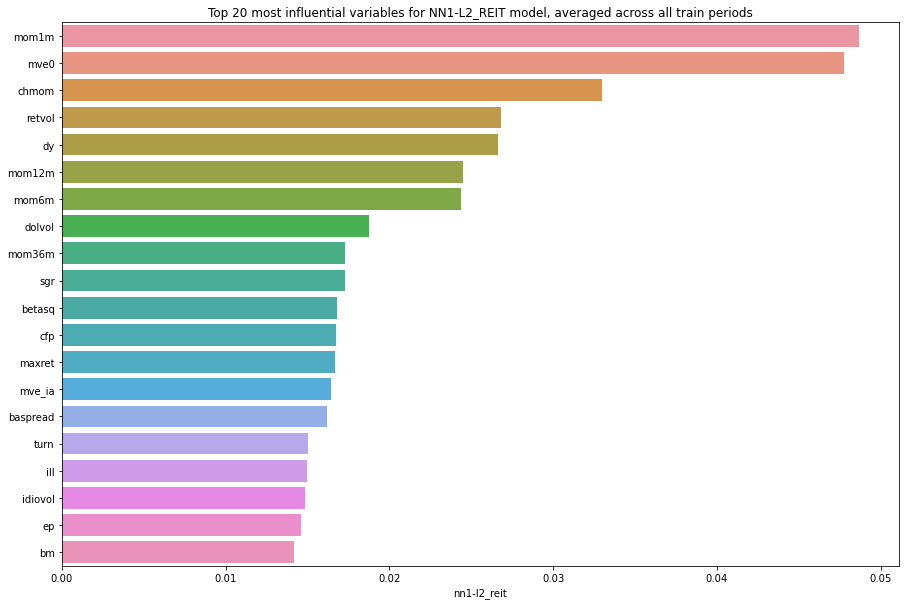

In [44]:
# Plot features of importance
# Plot graph
df_top20 = df_impt.sort_values(by=[model_name], ascending = False).head(20)
plt.figure(figsize=(15,10))
plt.title(f'Top 20 most influential variables for {model_name.upper()} model, averaged across all train periods')
sns.barplot(data = df_top20, x = model_name, y = df_top20.index);

In [45]:
# Merge df_temp to existing df_r2drecrease table

df_r2decrease_reit = pd.merge(
    left = df_r2decrease_reit,
    right = df_impt[model_name],
    how = 'left',
    left_index = True,
    right_index = True    
)

# Rank R2decrease table after including new model results
df_featurerank_reit = df_r2decrease_reit.rank() 
df_featurerank_reit['all_models'] = df_featurerank_reit.sum(axis=1)

# Display tables
display(df_r2decrease_reit)
display(df_featurerank_reit.sort_values('all_models', ascending = False))

# Save dfs to .csv 
df_r2decrease_reit.to_csv('../data/df_r2decrease_reit.csv', index = False)
df_featurerank_reit.to_csv('../data/df_featurerank_reit.csv', index = False)

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
absacc           0.000306   -0.001380    0.000189    0.000000   0.000000   
acc              0.001430   -0.000741    0.001779    0.000000   0.000000   
aeavol           0.000650    0.000668    0.005239    0.001173   0.001226   
age              0.000137   -0.000080    0.001680    0.000018   0.000030   
agr              0.000223    0.005201    0.003357    0.000000   0.000010   
baspread         0.007390    0.007871    0.000149    0.000000   0.000000   
beta             0.008894    0.057075    0.000315    0.000000   0.000000   
betasq           0.013997    0.013039    0.002645    0.000000   0.000000   
bm               0.001241    0.000853    0.024032    0.025538   0.026162   
bm_ia            0.002404    0.004776    0.007611    0.004235   0.004285   
cash             0.000161    0.000505    0.003340    0.000873   0.000927   
cashdebt         0.000128   -0.001187    0.000750    0.000000   0.000000   
cashpr           0.001257    0.002444    0.004893    0.001111   0.001181   
cfp              0.006021    0.006040    0.008196    0.013265   0.013306   
cfp_ia           0.001410    0.004166    0.007417    0.015930   0.015591   
chatoia          0.000082   -0.000040   -0.000983   -0.000089  -0.000097   
chcsho           0.000206   -0.000878    0.005366    0.002707   0.002796   
chempia          0.001031    0.003782   -0.000006    0.000000   0.000000   
chinv            0.000245   -0.000393    0.000482    0.000000   0.000000   
chmom            0.052654    0.050540    0.096469    0.142593   0.139152   
chpmia           0.002182    0.002565    0.011188    0.005567   0.005818   
chtx            -0.000017   -0.000019    0.000188    0.000000   0.000000   
cinvest          0.000038    0.000148    0.000281    0.000000   0.000000   
convind          0.000886    0.000794    0.000866    0.000000   0.000000   
currat           0.091179    0.044869   -0.000742    0.000000   0.000000   
depr            -0.000063    0.000391    0.001464    0.000148   0.000158   
divi             0.000153    0.000328    0.000156    0.000000   0.000000   
divo             0.000145    0.000922    0.000460    0.000000   0.000000   
dolvol           0.052843    0.089712    0.018587    0.017184   0.017007   
dy               0.016294    0.015071    0.090116    0.083019   0.084596   
ear              0.000198    0.000341    0.007511    0.004939   0.005175   
egr              0.001280    0.002940    0.004116    0.001198   0.001247   
ep               0.001748    0.010111    0.008772    0.004712   0.004875   
gma              0.003155   -0.001219    0.004361    0.000000   0.000000   
grcapx           0.000474    0.000658   -0.000177    0.000000   0.000000   
grltnoa          0.002414    0.001948    0.004432    0.000000   0.000000   
herf             0.023766    0.022687    0.023490    0.026236   0.026005   
hire             0.000198    0.002251    0.000338    0.000000   0.000000   
idiovol          0.000873   -0.000939    0.012297    0.014589   0.014951   
ill              0.005484    0.010939    0.022225    0.013264   0.013836   
indmom          -0.000049    0.000309    0.000357    0.000269   0.000290   
invest           0.000890    0.000858    0.002343    0.000000   0.000000   
lev             -0.000274   -0.002811   -0.002411    0.000000   0.000000   
lgr              0.000145    0.000304    0.000079    0.000000   0.000000   
maxret           0.025620    0.054758    0.005975    0.000000   0.000000   
mom12m           0.004666    0.002331    0.047325    0.017174   0.020037   
mom1m            0.019050    0.030089    0.134880    0.123642   0.127685   
mom36m           0.004236    0.006796    0.023669    0.021621   0.022049   
mom6m            0.056381    0.030482    0.053236    0.127055   0.120789   
ms               0.000196    0.000743    0.002229    0.000000   0.000000   
mve0             0.200379    0.212738    0.122775    0.137827   0.135776   
mve_ia           0.116817    0.152169    0.033515    0.073484   0.

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
mom1m               84.0        84.0        94.0        91.0       92.0   
chmom               87.0        89.0        92.0        94.0       94.0   
mom12m              74.0        60.0        88.0        82.0       83.0   
mve0                94.0        94.0        93.0        93.0       93.0   
mom6m               89.0        85.0        89.0        92.0       91.0   
retvol              93.0        86.0        90.0        87.0       87.0   
dy                  83.0        82.0        91.0        90.0       90.0   
herf                85.0        83.0        83.0        86.0       85.0   
sgr                 79.0        76.0        87.0        88.0       88.0   
mom36m              72.0        72.0        84.0        84.0       84.0   
ill                 75.0        78.0        82.0        78.0       79.0   
dolvol              88.0        92.0        81.0        83.0       82.0   
bm                  54.0        47.0        85.0        85.0       86.0   
maxret              86.0        90.0        68.0        26.0       25.5   
rd_sale             73.0        74.0        74.0        77.0       77.0   
bm_ia               68.0        69.0        73.0        72.0       72.0   
mve_ia              92.0        93.0        86.0        89.0       89.0   
chpmia              67.0        62.0        79.0        75.0       75.0   
cfp                 76.0        71.0        75.0        79.0       78.0   
ep                  63.0        77.0        76.0        73.0       73.0   
tang                61.0        54.0        77.0        66.0       67.0   
saleinv             66.0        55.0        78.0        69.0       69.0   
cfp_ia              57.0        67.0        71.0        81.0       81.0   
sp                  59.0        75.0        66.0        76.0       76.0   
pchdepr             43.0        35.0        57.0        67.0       66.0   
idiovol             48.0         7.0        80.0        80.0       80.0   
ear                 29.0        33.0        72.0        74.0       74.0   
roavol              65.0        68.0        67.0        68.0       68.0   
turn                77.0        79.0        40.0        62.0       62.0   
pchsale_pchinvt     27.0        28.0        51.0        52.0       51.0   
std_dolvol          39.0        53.0        63.0        59.0       59.0   
zerotrade           82.0        57.0        50.0        53.0       52.0   
betasq              81.0        80.0        49.0        26.0       25.5   
rd_mve               8.0        44.0        47.0        50.0       53.0   
cash                25.0        39.0        54.0        61.0       61.0   
invest              50.0        48.0        46.0        26.0       25.5   
stdacc              60.0        64.0        15.0        26.0       25.5   
beta                80.0        91.0        26.0        26.0       25.5   
grltnoa             69.0        56.0        60.0        26.0       25.5   
cashpr              55.0        61.0        62.0        63.0       63.0   
aeavol              46.0        43.0        64.0        64.0       64.0   
pchgm_pchsale       32.0        20.0        61.0        58.0       58.0   
salerec             26.0        26.0        56.0        60.0       60.0   
roic                47.0         6.0        70.0        70.0       70.0   
baspread            78.0        73.0        18.0        26.0       25.5   
egr                 56.0        63.0        58.0        65.0       65.0   
nincr               37.0        13.0        53.0        49.0       49.0   
stdcf               70.0        81.0         9.0        26.0       25.5   
roaq                62.0        65.0        69.0        26.0       25.5   
orgcap              52.0        52.0        22.0        26.0       25.5   
chtx                 9.0        24.0        20.0        26.0       25.5   
agr                 35.0        70.0        55.0        26.0       48.0   
chinv               36.0        12.0      

## NN3 (L2 penalty)

### REIT

In [21]:
df_results_reit = df_results_reit[:14]

In [22]:
# Create list of configs to test on 
def model_configs():
    # define scope of configs
    n_penalty_type = [l2]
    n_penalty_amount = np.logspace(-5, -3, 5)
    n_learning_rate = [0.001, 0.01]
    # create configs
    configs = []
    for i in n_penalty_type:
        for j in n_penalty_amount:
            for k in n_learning_rate:
                cfg = [i,j,k]
                configs.append(cfg)
    print('Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): %d' %len(configs))
    return configs

def model_fit(X_train, X_validate, y_train, y_validate, cfg):
    # unpack config
    n_penalty_type, n_penalty_amount, n_learning_rate = cfg
    
    # Instantiate a Sequential model
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(32, activation = 'relu', 
                    input_dim = X_train.shape[1], 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())
    
    # Add an input layer #2
    model.add(Dense(16, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #3
    model.add(Dense(8, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())
        
    # Add an output layer
    model.add(Dense(1, activation = None, 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Set learning rate
    opt = Adam(learning_rate = n_learning_rate)
    
    # Compile model
    model.compile(loss = 'mse',optimizer = opt)

    # Early stop
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5
    )    
    
    # Convert to np.array before calling model.fit()
    #  to speed up calculations
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)    
    X_validate = np.asarray(X_validate)
    y_validate = np.asarray(y_validate) 
    
    # Fit model
    model.fit(X_train, y_train,
              validation_data = (X_validate, y_validate),
              epochs = 500,
              batch_size = 2 ** 13,
              callbacks = [early_stop]
             )
   
    return model

In [23]:
# Instantiate list of configurations
cfg_list = model_configs()

Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): 10


In [24]:
%%time
# Create model name 
model_name = 'nn3-l2_reit'

# Create new row of test results
df_results_reit = pd.concat(
    [df_results_reit, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_reit
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 84us/sample - loss: 111.1353 - val_loss: 105.3278
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 110.3974 - val_loss: 105.2062
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.8260 - val_loss: 105.1061
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.3218 - val_loss: 105.0251
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.9140 - val_loss: 104.9554
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.5310 - val_loss: 104.8965
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.1800 - val_loss: 104.8424
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.8849 - val_loss: 104.7941
Epoch 9/500
21360/21360 [==============================] - 0s

21360/21360 [==============================] - 0s 5us/sample - loss: 110.0707 - val_loss: 104.8695
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.6425 - val_loss: 104.8071
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.2706 - val_loss: 104.7508
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.9545 - val_loss: 104.6952
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.6607 - val_loss: 104.6450
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.4139 - val_loss: 104.6074
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.1480 - val_loss: 104.5707
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.9396 - val_loss: 104.5354
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.7293 - val_loss: 104.5001
Epoch 11/500

21360/21360 [==============================] - 0s 5us/sample - loss: 105.1350 - val_loss: 104.8842
Epoch 22/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.9400 - val_loss: 104.8467
Epoch 23/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.7858 - val_loss: 104.8057
Epoch 24/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.5775 - val_loss: 104.7647
Epoch 25/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.3828 - val_loss: 104.7337
Epoch 26/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.1701 - val_loss: 104.7070
Epoch 27/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.9791 - val_loss: 104.6799
Epoch 28/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.7592 - val_loss: 104.6519
Epoch 29/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.5666 - val_loss: 104.6226
Epoch

21360/21360 [==============================] - 2s 82us/sample - loss: 110.0251 - val_loss: 105.5171
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.5690 - val_loss: 105.5027
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.2170 - val_loss: 105.4909
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.8856 - val_loss: 105.4738
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.5930 - val_loss: 105.4553
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.3540 - val_loss: 105.4337
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.1297 - val_loss: 105.4186
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.9363 - val_loss: 105.4049
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.7249 - val_loss: 105.3974
Epoch 10/500

21360/21360 [==============================] - 0s 5us/sample - loss: 107.2360 - val_loss: 104.2951
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 106.5740 - val_loss: 104.1514
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.6896 - val_loss: 104.1127
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.6752 - val_loss: 104.1865
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.5500 - val_loss: 104.2583
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.1220 - val_loss: 104.2880
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 100.4155 - val_loss: 104.3814
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 98.4939 - val_loss: 104.5612
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.63, 10.23, 2.76, 10.30
Train on 21360 samples, validate o

21360/21360 [==============================] - 0s 5us/sample - loss: 110.2420 - val_loss: 108.1746
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.8005 - val_loss: 107.8071
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.4321 - val_loss: 107.4927
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.1177 - val_loss: 107.2286
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.8484 - val_loss: 107.0009
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.6304 - val_loss: 106.8024
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.4016 - val_loss: 106.6240
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.2245 - val_loss: 106.4722
Epoch 11/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.0300 - val_loss: 106.3461
Epoch 12/50

Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.1168 - val_loss: 103.7991
Epoch 11/500
21360/21360 [==============================] - 0s 5us/sample - loss: 99.8140 - val_loss: 103.8163
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.34, 10.19, 2.98, 10.29
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 82us/sample - loss: 109.8123 - val_loss: 105.8403
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.6955 - val_loss: 105.4633
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 106.7495 - val_loss: 105.1756
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.8546 - val_loss: 105.2090
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.8126 - val_loss: 105.1576
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.6387 - val_l

Epoch 51/500
21360/21360 [==============================] - 0s 5us/sample - loss: 99.2974 - val_loss: 104.5426
Epoch 52/500
21360/21360 [==============================] - 0s 5us/sample - loss: 98.9778 - val_loss: 104.5401
Epoch 53/500
21360/21360 [==============================] - 0s 5us/sample - loss: 98.7664 - val_loss: 104.5401
Epoch 54/500
21360/21360 [==============================] - 0s 5us/sample - loss: 98.4918 - val_loss: 104.5475
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.66, 10.22, 2.98, 10.29
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample - loss: 112.3172 - val_loss: 106.5667
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 111.4859 - val_loss: 106.3850
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 110.7896 - val_loss: 106.2161
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 

Epoch 21/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.8014 - val_loss: 104.4675
Epoch 22/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.6253 - val_loss: 104.4484
Epoch 23/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.4632 - val_loss: 104.4312
Epoch 24/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.3179 - val_loss: 104.4126
Epoch 25/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.1391 - val_loss: 104.3978
Epoch 26/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.9978 - val_loss: 104.3834
Epoch 27/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.8502 - val_loss: 104.3685
Epoch 28/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.6862 - val_loss: 104.3599
Epoch 29/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.5134 - val_loss: 1

Epoch 43/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.7725 - val_loss: 103.6541
Epoch 44/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.5468 - val_loss: 103.6314
Epoch 45/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.3528 - val_loss: 103.6160
Epoch 46/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.1302 - val_loss: 103.6139
Epoch 47/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.9483 - val_loss: 103.5990
Epoch 48/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.7043 - val_loss: 103.5728
Epoch 49/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.5212 - val_loss: 103.5575
Epoch 50/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.3129 - val_loss: 103.5545
Epoch 51/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.0517 - val_loss: 1

21360/21360 [==============================] - 0s 5us/sample - loss: 110.1805 - val_loss: 104.9686
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.6793 - val_loss: 104.9467
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.2685 - val_loss: 104.9273
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.9072 - val_loss: 104.9045
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.5965 - val_loss: 104.8780
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.2988 - val_loss: 104.8466
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.0487 - val_loss: 104.8175
Epoch 11/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.8100 - val_loss: 104.7894
Epoch 12/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.5934 - val_loss: 104.7614
Epoch 13/5

21360/21360 [==============================] - 0s 5us/sample - loss: 107.9834 - val_loss: 105.3082
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.1771 - val_loss: 104.8997
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 106.3711 - val_loss: 104.7580
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.5178 - val_loss: 104.8585
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.7148 - val_loss: 104.8277
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.6954 - val_loss: 104.8331
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.5522 - val_loss: 105.0012
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 101.3751 - val_loss: 105.3495
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], -0.03, 10.26, 2.68, 10.31
Train on 21360 samples, validate on 10393 samples


Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
0       3.54 (10.26)         1.24 (10.19)              NaN          NaN   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
0              NaN            NaN            NaN           NaN            NaN   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00 (9.46)  0.00 (9.44)  0.00 (7.04)   0.00 (7.47)  0.00 (9.09)   
1   3.18 (9.31)  1.38 (9.37)  1.59 (6.99)  -2.95 (7.58)  2.22 (8.98)   
2   3.28 (9.31)  1.25 (9.38)  3.36 (6.92)  -1.87 (7.54)  2.06 (8.99)   
3   2.65 (9.34)  1.65 (

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 1.24, 10.19, 3.54, 10.26
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.17, 10.20, 3.19, 10.28
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 1.01, 10.21, 3.98, 10.24
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.82, 10.22, 3.45, 10.26
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.79, 10.22, 1.89, 10.35
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.78, 10.22, 3.11, 10.28
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.66, 10.22, 3.77, 10.25
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.59, 10.23, 3.36, 10.27
CPU times: user 10min 41s, sys: 6min 17s, total: 16min 58s
Wall time: 4min 56s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 1.24, 10.19, 3.54, 10.26

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.17, 10.20, 3.19, 10.28

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 1.01, 10.21, 3.98, 10.24

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.82, 10.22, 3.45, 10.26

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.79, 10.22, 1.89, 10.35

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.78, 10.22, 3.11, 10.28

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.66, 10.22, 3.77, 10.25

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.59, 10.23, 3.36, 10.27

CPU times: user 10min 41s, sys: 6min 17s, total: 16min 58s

Wall time: 4min 56s

In [25]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_reit
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_reit.to_csv('../data/df_results_reit.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 86us/sample - loss: 110.4388 - val_loss: 104.6894
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 109.8785 - val_loss: 104.6879
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.4289 - val_loss: 104.6882
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.0902 - val_loss: 104.6821
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.7698 - val_loss: 104.6786
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.5063 - val_loss: 104.6770
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.2581 - val_loss: 104.6713
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.0565 - val_loss: 104.6633
Epoch 9/500
21360/21360 [==============================] - 0s

Epoch 34/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.2296 - val_loss: 104.8464
Epoch 35/500
21360/21360 [==============================] - 0s 5us/sample - loss: 104.0192 - val_loss: 104.8051
Epoch 36/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.8031 - val_loss: 104.7602
Epoch 37/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.6185 - val_loss: 104.7223
Epoch 38/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.3985 - val_loss: 104.6867
Epoch 39/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.1774 - val_loss: 104.6484
Epoch 40/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.9413 - val_loss: 104.6145
Epoch 41/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.7308 - val_loss: 104.5931
Epoch 42/500
21360/21360 [==============================] - 0s 5us/sample - loss: 102.4598 - val_loss: 1

21360/21360 [==============================] - 0s 5us/sample - loss: 100.9082 - val_loss: 104.3290
Epoch 50/500
21360/21360 [==============================] - 0s 5us/sample - loss: 100.6660 - val_loss: 104.3598
Epoch 51/500
21360/21360 [==============================] - 0s 5us/sample - loss: 100.4349 - val_loss: 104.3748
Epoch 52/500
21360/21360 [==============================] - 0s 5us/sample - loss: 100.2221 - val_loss: 104.3699
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2006_4/assets
Test year 2006 done, R2 score is 2.62
Test year 2006 done, RMSE score is 7.50
Train on 23469 samples, validate on 10493 samples
Epoch 1/500
23469/23469 [==============================] - 2s 75us/sample - loss: 115.2635 - val_loss: 84.6050
Epoch 2/500
23469/23469 [==============================] - 0s 4us/sample - loss: 114.7955 - val_loss: 84.4557
Epoch 3/500
23469/23469 [==============================] - 0s 4us/sample - loss: 114.4208 - val_loss: 84.3052
Epoch 4/500
23469/23469 [==========

23469/23469 [==============================] - 0s 5us/sample - loss: 113.7834 - val_loss: 84.4915
Epoch 9/500
23469/23469 [==============================] - 0s 5us/sample - loss: 113.6162 - val_loss: 84.3526
Epoch 10/500
23469/23469 [==============================] - 0s 4us/sample - loss: 113.4303 - val_loss: 84.2202
Epoch 11/500
23469/23469 [==============================] - 0s 5us/sample - loss: 113.2844 - val_loss: 84.0935
Epoch 12/500
23469/23469 [==============================] - 0s 5us/sample - loss: 113.1280 - val_loss: 83.9770
Epoch 13/500
23469/23469 [==============================] - 0s 5us/sample - loss: 112.9899 - val_loss: 83.8683
Epoch 14/500
23469/23469 [==============================] - 0s 5us/sample - loss: 112.8469 - val_loss: 83.7632
Epoch 15/500
23469/23469 [==============================] - 0s 5us/sample - loss: 112.7141 - val_loss: 83.6539
Epoch 16/500
23469/23469 [==============================] - 0s 5us/sample - loss: 112.5798 - val_loss: 83.5585
Epoch 17/500
23

Epoch 19/500
23469/23469 [==============================] - 0s 5us/sample - loss: 110.8999 - val_loss: 82.3428
Epoch 20/500
23469/23469 [==============================] - 0s 5us/sample - loss: 110.7326 - val_loss: 82.2864
Epoch 21/500
23469/23469 [==============================] - 0s 5us/sample - loss: 110.5409 - val_loss: 82.2253
Epoch 22/500
23469/23469 [==============================] - 0s 5us/sample - loss: 110.3355 - val_loss: 82.1593
Epoch 23/500
23469/23469 [==============================] - 0s 5us/sample - loss: 110.1400 - val_loss: 82.0958
Epoch 24/500
23469/23469 [==============================] - 0s 5us/sample - loss: 109.9326 - val_loss: 82.0338
Epoch 25/500
23469/23469 [==============================] - 0s 5us/sample - loss: 109.7313 - val_loss: 81.9778
Epoch 26/500
23469/23469 [==============================] - 0s 5us/sample - loss: 109.5186 - val_loss: 81.9264
Epoch 27/500
23469/23469 [==============================] - 0s 5us/sample - loss: 109.3165 - val_loss: 81.8869
E

25480/25480 [==============================] - 2s 72us/sample - loss: 115.8979 - val_loss: 82.0777
Epoch 2/500
25480/25480 [==============================] - 0s 5us/sample - loss: 115.5429 - val_loss: 82.0860
Epoch 3/500
25480/25480 [==============================] - 0s 4us/sample - loss: 115.2788 - val_loss: 82.0949
Epoch 4/500
25480/25480 [==============================] - 0s 4us/sample - loss: 115.0731 - val_loss: 82.0955
Epoch 5/500
25480/25480 [==============================] - 0s 4us/sample - loss: 114.9137 - val_loss: 82.0999
Epoch 6/500
25480/25480 [==============================] - 0s 4us/sample - loss: 114.7518 - val_loss: 82.0957
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2008_1/assets
Train on 25480 samples, validate on 10448 samples
Epoch 1/500
25480/25480 [==============================] - 2s 72us/sample - loss: 116.4982 - val_loss: 81.9747
Epoch 2/500
25480/25480 [==============================] - 0s 4us/sample - loss: 115.9131 - val_loss: 81.9801
Epoch 3/5

Epoch 17/500
27460/27460 [==============================] - 0s 4us/sample - loss: 113.2398 - val_loss: 131.4410
Epoch 18/500
27460/27460 [==============================] - 0s 5us/sample - loss: 113.0519 - val_loss: 131.4518
Epoch 19/500
27460/27460 [==============================] - 0s 4us/sample - loss: 112.8808 - val_loss: 131.4606
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2009_0/assets
Train on 27460 samples, validate on 10324 samples
Epoch 1/500
27460/27460 [==============================] - 2s 67us/sample - loss: 116.4119 - val_loss: 131.6857
Epoch 2/500
27460/27460 [==============================] - 0s 4us/sample - loss: 115.9192 - val_loss: 131.6319
Epoch 3/500
27460/27460 [==============================] - 0s 4us/sample - loss: 115.5861 - val_loss: 131.5983
Epoch 4/500
27460/27460 [==============================] - 0s 4us/sample - loss: 115.3114 - val_loss: 131.5907
Epoch 5/500
27460/27460 [==============================] - 0s 4us/sample - loss: 115.0763 - val_lo

27460/27460 [==============================] - 0s 4us/sample - loss: 114.7646 - val_loss: 131.7372
Epoch 8/500
27460/27460 [==============================] - 0s 5us/sample - loss: 114.5955 - val_loss: 131.6960
Epoch 9/500
27460/27460 [==============================] - 0s 4us/sample - loss: 114.4118 - val_loss: 131.6540
Epoch 10/500
27460/27460 [==============================] - 0s 4us/sample - loss: 114.2521 - val_loss: 131.6306
Epoch 11/500
27460/27460 [==============================] - 0s 4us/sample - loss: 114.0709 - val_loss: 131.6067
Epoch 12/500
27460/27460 [==============================] - 0s 4us/sample - loss: 113.9132 - val_loss: 131.5847
Epoch 13/500
27460/27460 [==============================] - 0s 4us/sample - loss: 113.7370 - val_loss: 131.5583
Epoch 14/500
27460/27460 [==============================] - 0s 4us/sample - loss: 113.5636 - val_loss: 131.5494
Epoch 15/500
27460/27460 [==============================] - 0s 4us/sample - loss: 113.4029 - val_loss: 131.5344
Epoch 1

29523/29523 [==============================] - 0s 4us/sample - loss: 100.2197 - val_loss: 233.6531
Epoch 53/500
29523/29523 [==============================] - 0s 4us/sample - loss: 99.8123 - val_loss: 233.6823
Epoch 54/500
29523/29523 [==============================] - 0s 4us/sample - loss: 99.3590 - val_loss: 233.6880
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2010_3/assets
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 2s 60us/sample - loss: 115.3332 - val_loss: 233.3039
Epoch 2/500
29523/29523 [==============================] - 0s 4us/sample - loss: 114.4459 - val_loss: 233.3103
Epoch 3/500
29523/29523 [==============================] - 0s 4us/sample - loss: 113.7674 - val_loss: 233.3232
Epoch 4/500
29523/29523 [==============================] - 0s 4us/sample - loss: 113.2038 - val_loss: 233.3357
Epoch 5/500
29523/29523 [==============================] - 0s 4us/sample - loss: 112.7349 - val_loss: 233.3501
Ep

31753/31753 [==============================] - 0s 4us/sample - loss: 107.2681 - val_loss: 260.9896
Epoch 7/500
31753/31753 [==============================] - 0s 4us/sample - loss: 107.0685 - val_loss: 260.9603
Epoch 8/500
31753/31753 [==============================] - 0s 4us/sample - loss: 106.8732 - val_loss: 260.9395
Epoch 9/500
31753/31753 [==============================] - 0s 4us/sample - loss: 106.7162 - val_loss: 260.9219
Epoch 10/500
31753/31753 [==============================] - 0s 4us/sample - loss: 106.5281 - val_loss: 260.9145
Epoch 11/500
31753/31753 [==============================] - 0s 4us/sample - loss: 106.3639 - val_loss: 260.9092
Epoch 12/500
31753/31753 [==============================] - 0s 4us/sample - loss: 106.1979 - val_loss: 260.8991
Epoch 13/500
31753/31753 [==============================] - 0s 4us/sample - loss: 106.0315 - val_loss: 260.8886
Epoch 14/500
31753/31753 [==============================] - 0s 4us/sample - loss: 105.8527 - val_loss: 260.8871
Epoch 15

35928/35928 [==============================] - 0s 4us/sample - loss: 102.4856 - val_loss: 267.0720
Epoch 21/500
35928/35928 [==============================] - 0s 4us/sample - loss: 102.3216 - val_loss: 267.0388
Epoch 22/500
35928/35928 [==============================] - 0s 4us/sample - loss: 102.1378 - val_loss: 266.9920
Epoch 23/500
35928/35928 [==============================] - 0s 4us/sample - loss: 101.9708 - val_loss: 266.9509
Epoch 24/500
35928/35928 [==============================] - 0s 4us/sample - loss: 101.7921 - val_loss: 266.9478
Epoch 25/500
35928/35928 [==============================] - 0s 4us/sample - loss: 101.6003 - val_loss: 266.9415
Epoch 26/500
35928/35928 [==============================] - 0s 4us/sample - loss: 101.4281 - val_loss: 266.9230
Epoch 27/500
35928/35928 [==============================] - 0s 4us/sample - loss: 101.2072 - val_loss: 266.8905
Epoch 28/500
35928/35928 [==============================] - 0s 4us/sample - loss: 101.0511 - val_loss: 266.8865
Epoch

35928/35928 [==============================] - 0s 4us/sample - loss: 100.8209 - val_loss: 266.5731
Epoch 30/500
35928/35928 [==============================] - 0s 4us/sample - loss: 100.5912 - val_loss: 266.5564
Epoch 31/500
35928/35928 [==============================] - 0s 4us/sample - loss: 100.3365 - val_loss: 266.5477
Epoch 32/500
35928/35928 [==============================] - 0s 4us/sample - loss: 100.1048 - val_loss: 266.5314
Epoch 33/500
35928/35928 [==============================] - 0s 4us/sample - loss: 99.8145 - val_loss: 266.5507
Epoch 34/500
35928/35928 [==============================] - 0s 4us/sample - loss: 99.5788 - val_loss: 266.5378
Epoch 35/500
35928/35928 [==============================] - 0s 4us/sample - loss: 99.3349 - val_loss: 266.5789
Epoch 36/500
35928/35928 [==============================] - 0s 4us/sample - loss: 99.0946 - val_loss: 266.6093
Epoch 37/500
35928/35928 [==============================] - 0s 4us/sample - loss: 98.8575 - val_loss: 266.6027
INFO:tenso

37784/37784 [==============================] - 0s 4us/sample - loss: 119.0392 - val_loss: 203.2657
Epoch 8/500
37784/37784 [==============================] - 0s 4us/sample - loss: 118.8610 - val_loss: 203.2192
Epoch 9/500
37784/37784 [==============================] - 0s 4us/sample - loss: 118.6832 - val_loss: 203.1819
Epoch 10/500
37784/37784 [==============================] - 0s 4us/sample - loss: 118.5175 - val_loss: 203.1264
Epoch 11/500
37784/37784 [==============================] - 0s 4us/sample - loss: 118.3618 - val_loss: 203.0742
Epoch 12/500
37784/37784 [==============================] - 0s 4us/sample - loss: 118.1770 - val_loss: 203.0251
Epoch 13/500
37784/37784 [==============================] - 0s 4us/sample - loss: 118.0044 - val_loss: 202.9811
Epoch 14/500
37784/37784 [==============================] - 0s 4us/sample - loss: 117.8335 - val_loss: 202.9583
Epoch 15/500
37784/37784 [==============================] - 0s 4us/sample - loss: 117.6386 - val_loss: 202.9367
Epoch 1

Epoch 5/500
39556/39556 [==============================] - 0s 4us/sample - loss: 142.6396 - val_loss: 93.5942
Epoch 6/500
39556/39556 [==============================] - 0s 4us/sample - loss: 142.3504 - val_loss: 93.6112
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2015_2/assets
Train on 39556 samples, validate on 10230 samples
Epoch 1/500
39556/39556 [==============================] - 2s 46us/sample - loss: 144.0919 - val_loss: 98.2608
Epoch 2/500
39556/39556 [==============================] - 0s 4us/sample - loss: 143.5634 - val_loss: 97.6500
Epoch 3/500
39556/39556 [==============================] - 0s 4us/sample - loss: 143.1674 - val_loss: 97.1387
Epoch 4/500
39556/39556 [==============================] - 0s 4us/sample - loss: 142.8704 - val_loss: 96.6873
Epoch 5/500
39556/39556 [==============================] - 0s 4us/sample - loss: 142.6152 - val_loss: 96.3110
Epoch 6/500
39556/39556 [==============================] - 0s 4us/sample - loss: 142.3841 - val_loss: 95.965

Epoch 27/500
39556/39556 [==============================] - 0s 4us/sample - loss: 137.3454 - val_loss: 93.4220
Epoch 28/500
39556/39556 [==============================] - 0s 4us/sample - loss: 136.9513 - val_loss: 93.4024
Epoch 29/500
39556/39556 [==============================] - 0s 4us/sample - loss: 136.6368 - val_loss: 93.3917
Epoch 30/500
39556/39556 [==============================] - 0s 4us/sample - loss: 136.2551 - val_loss: 93.3795
Epoch 31/500
39556/39556 [==============================] - 0s 4us/sample - loss: 135.8052 - val_loss: 93.3919
Epoch 32/500
39556/39556 [==============================] - 0s 4us/sample - loss: 135.4166 - val_loss: 93.3958
Epoch 33/500
39556/39556 [==============================] - 0s 4us/sample - loss: 135.0527 - val_loss: 93.3845
Epoch 34/500
39556/39556 [==============================] - 0s 4us/sample - loss: 134.6160 - val_loss: 93.3886
Epoch 35/500
39556/39556 [==============================] - 0s 4us/sample - loss: 134.2179 - val_loss: 93.4139
I

41396/41396 [==============================] - 0s 4us/sample - loss: 139.2165 - val_loss: 75.0051
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2016_2/assets
Train on 41396 samples, validate on 10863 samples
Epoch 1/500
41396/41396 [==============================] - 2s 44us/sample - loss: 144.5174 - val_loss: 74.9118
Epoch 2/500
41396/41396 [==============================] - 0s 4us/sample - loss: 143.9504 - val_loss: 74.9098
Epoch 3/500
41396/41396 [==============================] - 0s 4us/sample - loss: 143.6184 - val_loss: 74.9113
Epoch 4/500
41396/41396 [==============================] - 0s 4us/sample - loss: 143.3591 - val_loss: 74.9020
Epoch 5/500
41396/41396 [==============================] - 0s 4us/sample - loss: 143.1192 - val_loss: 74.8994
Epoch 6/500
41396/41396 [==============================] - 0s 4us/sample - loss: 142.9111 - val_loss: 74.8886
Epoch 7/500
41396/41396 [==============================] - 0s 4us/sample - loss: 142.7300 - val_loss: 74.8751
Epoch 8/50

43327/43327 [==============================] - 0s 4us/sample - loss: 141.6222 - val_loss: 72.2940
Epoch 5/500
43327/43327 [==============================] - 0s 4us/sample - loss: 141.2897 - val_loss: 72.1927
Epoch 6/500
43327/43327 [==============================] - 0s 4us/sample - loss: 141.0368 - val_loss: 72.0896
Epoch 7/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.8143 - val_loss: 72.0013
Epoch 8/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.5941 - val_loss: 71.9230
Epoch 9/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.3725 - val_loss: 71.8494
Epoch 10/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.1820 - val_loss: 71.7853
Epoch 11/500
43327/43327 [==============================] - 0s 4us/sample - loss: 139.9829 - val_loss: 71.7243
Epoch 12/500
43327/43327 [==============================] - 0s 4us/sample - loss: 139.7736 - val_loss: 71.6654
Epoch 13/500
43327/

Epoch 6/500
43327/43327 [==============================] - 0s 4us/sample - loss: 141.1831 - val_loss: 72.8154
Epoch 7/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.9461 - val_loss: 72.6630
Epoch 8/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.7289 - val_loss: 72.5203
Epoch 9/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.4936 - val_loss: 72.3811
Epoch 10/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.2871 - val_loss: 72.2555
Epoch 11/500
43327/43327 [==============================] - 0s 4us/sample - loss: 140.1032 - val_loss: 72.1741
Epoch 12/500
43327/43327 [==============================] - 0s 4us/sample - loss: 139.9034 - val_loss: 72.0990
Epoch 13/500
43327/43327 [==============================] - 0s 4us/sample - loss: 139.7255 - val_loss: 72.0046
Epoch 14/500
43327/43327 [==============================] - 0s 4us/sample - loss: 139.5378 - val_loss: 71.9182
Epoch

45304/45304 [==============================] - 0s 4us/sample - loss: 135.6646 - val_loss: 64.3989
Epoch 18/500
45304/45304 [==============================] - 0s 4us/sample - loss: 135.3709 - val_loss: 64.3945
Epoch 19/500
45304/45304 [==============================] - 0s 4us/sample - loss: 135.0548 - val_loss: 64.3989
Epoch 20/500
45304/45304 [==============================] - 0s 4us/sample - loss: 134.7527 - val_loss: 64.4128
Epoch 21/500
45304/45304 [==============================] - 0s 4us/sample - loss: 134.4099 - val_loss: 64.4325
Epoch 22/500
45304/45304 [==============================] - 0s 4us/sample - loss: 134.1072 - val_loss: 64.4475
Epoch 23/500
45304/45304 [==============================] - 0s 4us/sample - loss: 133.7740 - val_loss: 64.4607
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2018_1/assets
Train on 45304 samples, validate on 11733 samples
Epoch 1/500
45304/45304 [==============================] - 2s 40us/sample - loss: 141.3856 - val_loss: 64.7956
Epoc

Epoch 10/500
45304/45304 [==============================] - 0s 4us/sample - loss: 137.6940 - val_loss: 65.6935
Epoch 11/500
45304/45304 [==============================] - 0s 4us/sample - loss: 137.4602 - val_loss: 65.5348
Epoch 12/500
45304/45304 [==============================] - 0s 4us/sample - loss: 137.2376 - val_loss: 65.4114
Epoch 13/500
45304/45304 [==============================] - 0s 4us/sample - loss: 137.0401 - val_loss: 65.2833
Epoch 14/500
45304/45304 [==============================] - 0s 4us/sample - loss: 136.8136 - val_loss: 65.1788
Epoch 15/500
45304/45304 [==============================] - 0s 4us/sample - loss: 136.5953 - val_loss: 65.0862
Epoch 16/500
45304/45304 [==============================] - 0s 4us/sample - loss: 136.3720 - val_loss: 64.9981
Epoch 17/500
45304/45304 [==============================] - 0s 4us/sample - loss: 136.1524 - val_loss: 64.9274
Epoch 18/500
45304/45304 [==============================] - 0s 4us/sample - loss: 135.9251 - val_loss: 64.8743
E

Epoch 5/500
47453/47453 [==============================] - 0s 4us/sample - loss: 136.4969 - val_loss: 60.9596
Epoch 6/500
47453/47453 [==============================] - 0s 4us/sample - loss: 136.2020 - val_loss: 60.9265
Epoch 7/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.9319 - val_loss: 60.8977
Epoch 8/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.7008 - val_loss: 60.8727
Epoch 9/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.4799 - val_loss: 60.8533
Epoch 10/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.2627 - val_loss: 60.8446
Epoch 11/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.0394 - val_loss: 60.8436
Epoch 12/500
47453/47453 [==============================] - 0s 4us/sample - loss: 134.8183 - val_loss: 60.8411
Epoch 13/500
47453/47453 [==============================] - 0s 4us/sample - loss: 134.5918 - val_loss: 60.8552
Epoch 

49786/49786 [==============================] - 0s 4us/sample - loss: 132.4898 - val_loss: 64.3980
Epoch 7/500
49786/49786 [==============================] - 0s 4us/sample - loss: 132.3369 - val_loss: 64.3847
Epoch 8/500
49786/49786 [==============================] - 0s 4us/sample - loss: 132.1873 - val_loss: 64.3718
Epoch 9/500
49786/49786 [==============================] - 0s 4us/sample - loss: 132.0412 - val_loss: 64.3790
Epoch 10/500
49786/49786 [==============================] - 0s 4us/sample - loss: 131.9036 - val_loss: 64.3769
Epoch 11/500
49786/49786 [==============================] - 0s 4us/sample - loss: 131.7590 - val_loss: 64.3794
Epoch 12/500
49786/49786 [==============================] - 0s 4us/sample - loss: 131.6255 - val_loss: 64.3833
Epoch 13/500
49786/49786 [==============================] - 0s 4us/sample - loss: 131.4681 - val_loss: 64.3728
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_reit_2020_2/assets
Train on 49786 samples, validate on 11932 samples
Epoch 1

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
0       3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
0    -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00 (9.46)  0.00 (9.44)  0.00 (7.04)   0.00 (7.47)  0.00 (9.09)   
1   3.18 (9.31)  1.38 (9.37)  1.59 (6.99)  -2.95 (7.58)  2.22 (8.98)   
2   3.28 (9.31)  1.25 (9.38)  3.36 (6.92)  -1.87 (7.54)  2.06 (8.99)   
3   2.65 (9.34)  1.65 (


R2 for entire pooled test set, from 2006 to 2020, is 0.04.
RMSE for entire pooled test set, from 2006 to 2020, is 12.13.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]
CPU times: user 20min 57s, sys: 11min 15s, total: 32min 12s
Wall time: 9min 15s


R2 for entire pooled test set, from 2006 to 2020, is 0.04.

RMSE for entire pooled test set, from 2006 to 2020, is 12.13.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]

CPU times: user 20min 57s, sys: 11min 15s, total: 32min 12s

Wall time: 9min 15s

### Sample 1

In [26]:
df_results_sample1 = df_results_sample1[:14]

In [27]:
%%time
# Create model name 
model_name = 'nn3-l2_sample1'

# Create new row of test results
df_results_sample1 = pd.concat(
    [df_results_sample1, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample1
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample - loss: 437.2785 - val_loss: 360.2862
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 436.3992 - val_loss: 360.2783
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.7364 - val_loss: 360.2786
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.1903 - val_loss: 360.2735
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.6057 - val_loss: 360.2671
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.1036 - val_loss: 360.2614
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.5924 - val_loss: 360.2587
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.1277 - val_loss: 360.2592
Epoch 9/500
21360/21360 [==============================] - 0s

21360/21360 [==============================] - 0s 5us/sample - loss: 434.6504 - val_loss: 360.8272
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.0313 - val_loss: 360.8064
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.4527 - val_loss: 360.7894
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.8887 - val_loss: 360.7693
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.4785 - val_loss: 360.7516
Epoch 11/500
21360/21360 [==============================] - 0s 5us/sample - loss: 431.9177 - val_loss: 360.7410
Epoch 12/500
21360/21360 [==============================] - 0s 5us/sample - loss: 431.4552 - val_loss: 360.7255
Epoch 13/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.9147 - val_loss: 360.7161
Epoch 14/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.3948 - val_loss: 360.7091
Epoch 15

21360/21360 [==============================] - 0s 5us/sample - loss: 407.9688 - val_loss: 360.1392
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 401.5295 - val_loss: 360.2563
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.28, 18.98, 1.08, 20.76
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample - loss: 435.9088 - val_loss: 361.0626
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.7957 - val_loss: 360.5315
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 427.8304 - val_loss: 360.2708
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 424.6867 - val_loss: 360.1116
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 421.1565 - val_loss: 360.2557
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 416.3971 - val_loss: 360.5954

Epoch 26/500
21360/21360 [==============================] - 0s 5us/sample - loss: 421.5743 - val_loss: 360.6596
Epoch 27/500
21360/21360 [==============================] - 0s 5us/sample - loss: 420.8020 - val_loss: 360.6440
Epoch 28/500
21360/21360 [==============================] - 0s 5us/sample - loss: 420.1059 - val_loss: 360.6443
Epoch 29/500
21360/21360 [==============================] - 0s 5us/sample - loss: 419.2312 - val_loss: 360.6537
Epoch 30/500
21360/21360 [==============================] - 0s 5us/sample - loss: 418.5227 - val_loss: 360.6625
Epoch 31/500
21360/21360 [==============================] - 0s 5us/sample - loss: 417.6178 - val_loss: 360.6672
Epoch 32/500
21360/21360 [==============================] - 0s 5us/sample - loss: 416.8579 - val_loss: 360.6854
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.16, 18.99, 1.31, 20.74
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample -

Epoch 15/500
21360/21360 [==============================] - 0s 5us/sample - loss: 427.6541 - val_loss: 360.5373
Epoch 16/500
21360/21360 [==============================] - 0s 5us/sample - loss: 427.0853 - val_loss: 360.5408
Epoch 17/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.3705 - val_loss: 360.5546
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.20, 18.99, 0.85, 20.79
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample - loss: 439.3669 - val_loss: 360.6348
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 438.1234 - val_loss: 360.6098
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 437.1110 - val_loss: 360.5926
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 436.2099 - val_loss: 360.5753
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - los

Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 387.9964 - val_loss: 362.1536
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], -0.25, 19.03, 2.14, 20.65
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample - loss: 435.8420 - val_loss: 361.0801
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.3197 - val_loss: 360.8272
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 429.7247 - val_loss: 360.5509
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.6651 - val_loss: 360.3789
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 423.4402 - val_loss: 360.2129
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 419.7721 - val_loss: 360.1873
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss:

21360/21360 [==============================] - 0s 5us/sample - loss: 427.3048 - val_loss: 361.2295
Epoch 20/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.7145 - val_loss: 361.1836
Epoch 21/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.1556 - val_loss: 361.1480
Epoch 22/500
21360/21360 [==============================] - 0s 5us/sample - loss: 425.5589 - val_loss: 361.1195
Epoch 23/500
21360/21360 [==============================] - 0s 5us/sample - loss: 424.8845 - val_loss: 361.0931
Epoch 24/500
21360/21360 [==============================] - 0s 5us/sample - loss: 424.2170 - val_loss: 361.0725
Epoch 25/500
21360/21360 [==============================] - 0s 5us/sample - loss: 423.5374 - val_loss: 361.0821
Epoch 26/500
21360/21360 [==============================] - 0s 5us/sample - loss: 422.7925 - val_loss: 361.0601
Epoch 27/500
21360/21360 [==============================] - 0s 5us/sample - loss: 422.0406 - val_loss: 361.0331
Epoch

Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 431.7988 - val_loss: 360.7352
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 429.2385 - val_loss: 360.3836
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.9652 - val_loss: 360.1928
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 424.6463 - val_loss: 360.0265
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 421.5166 - val_loss: 359.7889
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 417.8276 - val_loss: 359.7972
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 413.7367 - val_loss: 359.8522
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 408.8982 - val_loss: 359.6918
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 402.7858 - val_loss: 359.4493


[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.07, 19.00, 1.07, 20.77
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 83us/sample - loss: 436.7326 - val_loss: 361.5527
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.9926 - val_loss: 361.5062
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.4304 - val_loss: 361.4576
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.9202 - val_loss: 361.4102
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.4768 - val_loss: 361.3652
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.0537 - val_loss: 361.3185
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.6078 - val_loss: 361.2807
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 

Epoch 25/500
21360/21360 [==============================] - 0s 5us/sample - loss: 425.8604 - val_loss: 361.0750
Epoch 26/500
21360/21360 [==============================] - 0s 5us/sample - loss: 425.4420 - val_loss: 361.0500
Epoch 27/500
21360/21360 [==============================] - 0s 5us/sample - loss: 425.0020 - val_loss: 361.0217
Epoch 28/500
21360/21360 [==============================] - 0s 5us/sample - loss: 424.4820 - val_loss: 360.9943
Epoch 29/500
21360/21360 [==============================] - 0s 5us/sample - loss: 424.0252 - val_loss: 360.9736
Epoch 30/500
21360/21360 [==============================] - 0s 5us/sample - loss: 423.5611 - val_loss: 360.9575
Epoch 31/500
21360/21360 [==============================] - 0s 5us/sample - loss: 423.0338 - val_loss: 360.9488
Epoch 32/500
21360/21360 [==============================] - 0s 5us/sample - loss: 422.5631 - val_loss: 360.9368
Epoch 33/500
21360/21360 [==============================] - 0s 5us/sample - loss: 422.0328 - val_loss: 3

21360/21360 [==============================] - 0s 5us/sample - loss: 432.7069 - val_loss: 360.6296
Epoch 12/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.4024 - val_loss: 360.6006
Epoch 13/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.0446 - val_loss: 360.5798
Epoch 14/500
21360/21360 [==============================] - 0s 5us/sample - loss: 431.6867 - val_loss: 360.5565
Epoch 15/500
21360/21360 [==============================] - 0s 5us/sample - loss: 431.3432 - val_loss: 360.5318
Epoch 16/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.9459 - val_loss: 360.5087
Epoch 17/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.5978 - val_loss: 360.4838
Epoch 18/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.1536 - val_loss: 360.4607
Epoch 19/500
21360/21360 [==============================] - 0s 5us/sample - loss: 429.7681 - val_loss: 360.4425
Epoch

21360/21360 [==============================] - 0s 5us/sample - loss: 435.0513 - val_loss: 361.5911
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.6672 - val_loss: 361.5068
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.3227 - val_loss: 361.4263
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.9659 - val_loss: 361.3503
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.6641 - val_loss: 361.2792
Epoch 11/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.3153 - val_loss: 361.2114
Epoch 12/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.0138 - val_loss: 361.1491
Epoch 13/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.6984 - val_loss: 361.0911
Epoch 14/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.3864 - val_loss: 361.0395
Epoch 15

21360/21360 [==============================] - 0s 5us/sample - loss: 362.2001 - val_loss: 360.2587
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.31, 18.98, 1.48, 20.72
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 85us/sample - loss: 437.0942 - val_loss: 361.0022
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.7363 - val_loss: 360.8092
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.4461 - val_loss: 360.6159
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 428.2573 - val_loss: 360.4207
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 425.7219 - val_loss: 360.1912
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 422.7640 - val_loss: 360.1004
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 419.0653 - val_loss: 360.2182


Model Name                                   Selected Config  \
0         naive_sample1                                              N.A.   
1            lr_sample1                                              N.A.   
2   fama-french_sample1                                          bm, mve0   
3       carhart_sample1                                  bm, mve0, mom12m   
4         huber_sample1                                       [9, 0.0001]   
5         ridge_sample1                               [50084.07989848212]   
6         lasso_sample1                             [0.47148663634573895]   
7          enet_sample1                                        [0.3, 1.0]   
8           pcr_sample1                                                21   
9           pls_sample1                                                 1   
10           rf_sample1                                [200, 0.5, 15, 50]   
11           et_sample1                                [100, 0.5, 15, 30]   
12           xg_sample1                                [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn3-l2_sample1   [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
0       1.09 (20.76)         0.28 (18.98)              NaN            NaN   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
0             NaN            NaN            NaN            NaN            NaN   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)    Test (2016)  \
0   0.00 (12.77)   0.00 (12.20)   0.00 (11.34)   0.00 (14.08)   0.00 (16.07)   
1   0.52 (12.74)   2.52 (12.05)  -1.37 (11.42)  -1.45 (14.18)  -0.12 (16.08)   
2   0.74 (

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.28, 18.98, 1.09, 20.76
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.28, 18.98, 1.52, 20.72
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.27, 18.98, 1.82, 20.69
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.22, 18.99, 1.67, 20.70
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.20, 18.99, 1.57, 20.71
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.08, 19.00, 1.96, 20.67
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], -0.04, 19.01, 2.16, 20.65
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], -0.36, 19.04, 1.67, 20.70
CPU times: user 9min 20s, sys: 5min 22s, total: 14min 43s
Wall time: 4min 31s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.28, 18.98, 1.09, 20.76

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.28, 18.98, 1.52, 20.72

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.27, 18.98, 1.82, 20.69

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.22, 18.99, 1.67, 20.70

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.20, 18.99, 1.57, 20.71

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.08, 19.00, 1.96, 20.67

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], -0.04, 19.01, 2.16, 20.65

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], -0.36, 19.04, 1.67, 20.70

CPU times: user 9min 20s, sys: 5min 22s, total: 14min 43s

Wall time: 4min 31s

In [28]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample1
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample1.to_csv('../data/df_results_sample1.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 2s 84us/sample - loss: 437.9751 - val_loss: 360.7278
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 436.8968 - val_loss: 360.7016
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 436.0494 - val_loss: 360.6680
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.2796 - val_loss: 360.6472
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.5981 - val_loss: 360.6245
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.0509 - val_loss: 360.5999
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.4658 - val_loss: 360.5729
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 432.8872 - val_loss: 360.5490
Epoch 9/500
21360/21360 [==============================] - 0s

21360/21360 [==============================] - 0s 5us/sample - loss: 429.5446 - val_loss: 361.2044
Epoch 22/500
21360/21360 [==============================] - 0s 5us/sample - loss: 429.1718 - val_loss: 361.1573
Epoch 23/500
21360/21360 [==============================] - 0s 5us/sample - loss: 428.8246 - val_loss: 361.1134
Epoch 24/500
21360/21360 [==============================] - 0s 5us/sample - loss: 428.4310 - val_loss: 361.0699
Epoch 25/500
21360/21360 [==============================] - 0s 5us/sample - loss: 428.0239 - val_loss: 361.0315
Epoch 26/500
21360/21360 [==============================] - 0s 5us/sample - loss: 427.6442 - val_loss: 360.9926
Epoch 27/500
21360/21360 [==============================] - 0s 5us/sample - loss: 427.1967 - val_loss: 360.9542
Epoch 28/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.7901 - val_loss: 360.9185
Epoch 29/500
21360/21360 [==============================] - 0s 5us/sample - loss: 426.3499 - val_loss: 360.8906
Epoch

23469/23469 [==============================] - 0s 5us/sample - loss: 457.8680 - val_loss: 250.9492
Epoch 17/500
23469/23469 [==============================] - 0s 5us/sample - loss: 457.2821 - val_loss: 250.9415
Epoch 18/500
23469/23469 [==============================] - 0s 5us/sample - loss: 456.7432 - val_loss: 250.9295
Epoch 19/500
23469/23469 [==============================] - 0s 5us/sample - loss: 456.2239 - val_loss: 250.9197
Epoch 20/500
23469/23469 [==============================] - 0s 5us/sample - loss: 455.6061 - val_loss: 250.9001
Epoch 21/500
23469/23469 [==============================] - 0s 5us/sample - loss: 455.0767 - val_loss: 250.8931
Epoch 22/500
23469/23469 [==============================] - 0s 5us/sample - loss: 454.4593 - val_loss: 250.8808
Epoch 23/500
23469/23469 [==============================] - 0s 5us/sample - loss: 453.8749 - val_loss: 250.8834
Epoch 24/500
23469/23469 [==============================] - 0s 5us/sample - loss: 453.1747 - val_loss: 250.8713
Epoch

25480/25480 [==============================] - 0s 5us/sample - loss: 462.9043 - val_loss: 185.5625
Epoch 16/500
25480/25480 [==============================] - 0s 5us/sample - loss: 462.5487 - val_loss: 185.5362
Epoch 17/500
25480/25480 [==============================] - 0s 5us/sample - loss: 462.2440 - val_loss: 185.5150
Epoch 18/500
25480/25480 [==============================] - 0s 5us/sample - loss: 461.9025 - val_loss: 185.4938
Epoch 19/500
25480/25480 [==============================] - 0s 5us/sample - loss: 461.5205 - val_loss: 185.4634
Epoch 20/500
25480/25480 [==============================] - 0s 5us/sample - loss: 461.1592 - val_loss: 185.4260
Epoch 21/500
25480/25480 [==============================] - 0s 5us/sample - loss: 460.7439 - val_loss: 185.4069
Epoch 22/500
25480/25480 [==============================] - 0s 5us/sample - loss: 460.3785 - val_loss: 185.3949
Epoch 23/500
25480/25480 [==============================] - 0s 5us/sample - loss: 459.9411 - val_loss: 185.3874
Epoch

31753/31753 [==============================] - 0s 4us/sample - loss: 409.9166 - val_loss: 312.2572
Epoch 8/500
31753/31753 [==============================] - 0s 4us/sample - loss: 409.5640 - val_loss: 312.2374
Epoch 9/500
31753/31753 [==============================] - 0s 4us/sample - loss: 409.1921 - val_loss: 312.2154
Epoch 10/500
31753/31753 [==============================] - 0s 4us/sample - loss: 408.8192 - val_loss: 312.1900
Epoch 11/500
31753/31753 [==============================] - 0s 4us/sample - loss: 408.4429 - val_loss: 312.1685
Epoch 12/500
31753/31753 [==============================] - 0s 4us/sample - loss: 408.1270 - val_loss: 312.1634
Epoch 13/500
31753/31753 [==============================] - 0s 4us/sample - loss: 407.7784 - val_loss: 312.1637
Epoch 14/500
31753/31753 [==============================] - 0s 4us/sample - loss: 407.3911 - val_loss: 312.1746
Epoch 15/500
31753/31753 [==============================] - 0s 4us/sample - loss: 407.0741 - val_loss: 312.1859
Epoch 1

33962/33962 [==============================] - 0s 5us/sample - loss: 397.1838 - val_loss: 311.3049
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample1_2012_4/assets
Test year 2012 done, R2 score is 0.25
Test year 2012 done, RMSE score is 12.75
Train on 35928 samples, validate on 9376 samples
Epoch 1/500
35928/35928 [==============================] - 2s 50us/sample - loss: 386.7213 - val_loss: 313.9999
Epoch 2/500
35928/35928 [==============================] - 0s 4us/sample - loss: 385.7277 - val_loss: 313.9322
Epoch 3/500
35928/35928 [==============================] - 0s 4us/sample - loss: 385.0308 - val_loss: 313.8562
Epoch 4/500
35928/35928 [==============================] - 0s 4us/sample - loss: 384.3968 - val_loss: 313.7867
Epoch 5/500
35928/35928 [==============================] - 0s 4us/sample - loss: 383.9143 - val_loss: 313.7369
Epoch 6/500
35928/35928 [==============================] - 0s 4us/sample - loss: 383.3796 - val_loss: 313.6813
Epoch 7/500
35928/35928 [=======

35928/35928 [==============================] - 0s 4us/sample - loss: 378.7312 - val_loss: 312.7805
Epoch 17/500
35928/35928 [==============================] - 0s 4us/sample - loss: 378.0629 - val_loss: 312.7053
Epoch 18/500
35928/35928 [==============================] - 0s 4us/sample - loss: 377.5133 - val_loss: 312.6514
Epoch 19/500
35928/35928 [==============================] - 0s 4us/sample - loss: 376.8407 - val_loss: 312.6198
Epoch 20/500
35928/35928 [==============================] - 0s 4us/sample - loss: 376.1035 - val_loss: 312.5915
Epoch 21/500
35928/35928 [==============================] - 0s 4us/sample - loss: 375.3462 - val_loss: 312.5613
Epoch 22/500
35928/35928 [==============================] - 0s 4us/sample - loss: 374.5311 - val_loss: 312.5450
Epoch 23/500
35928/35928 [==============================] - 0s 4us/sample - loss: 373.7366 - val_loss: 312.5279
Epoch 24/500
35928/35928 [==============================] - 0s 4us/sample - loss: 372.9479 - val_loss: 312.5000
Epoch

39556/39556 [==============================] - 0s 4us/sample - loss: 395.6931 - val_loss: 170.6192
Epoch 4/500
39556/39556 [==============================] - 0s 4us/sample - loss: 394.9059 - val_loss: 170.6170
Epoch 5/500
39556/39556 [==============================] - 0s 4us/sample - loss: 394.2446 - val_loss: 170.6171
Epoch 6/500
39556/39556 [==============================] - 0s 4us/sample - loss: 393.6834 - val_loss: 170.6250
Epoch 7/500
39556/39556 [==============================] - 0s 4us/sample - loss: 393.1708 - val_loss: 170.6274
Epoch 8/500
39556/39556 [==============================] - 0s 4us/sample - loss: 392.6603 - val_loss: 170.6280
Epoch 9/500
39556/39556 [==============================] - 0s 4us/sample - loss: 392.1478 - val_loss: 170.6269
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample1_2015_0/assets
Train on 39556 samples, validate on 10230 samples
Epoch 1/500
39556/39556 [==============================] - 2s 46us/sample - loss: 397.4348 - val_loss: 172.3063

Test year 2015 done, R2 score is -0.37
Test year 2015 done, RMSE score is 14.10
Train on 41396 samples, validate on 10863 samples
Epoch 1/500
41396/41396 [==============================] - 2s 44us/sample - loss: 389.4249 - val_loss: 166.6176
Epoch 2/500
41396/41396 [==============================] - 0s 4us/sample - loss: 388.4778 - val_loss: 166.5735
Epoch 3/500
41396/41396 [==============================] - 0s 4us/sample - loss: 387.9427 - val_loss: 166.5349
Epoch 4/500
41396/41396 [==============================] - 0s 4us/sample - loss: 387.4415 - val_loss: 166.4920
Epoch 5/500
41396/41396 [==============================] - 0s 4us/sample - loss: 387.0448 - val_loss: 166.4574
Epoch 6/500
41396/41396 [==============================] - 0s 4us/sample - loss: 386.7330 - val_loss: 166.4238
Epoch 7/500
41396/41396 [==============================] - 0s 4us/sample - loss: 386.4438 - val_loss: 166.3861
Epoch 8/500
41396/41396 [==============================] - 0s 4us/sample - loss: 386.1754 - 

Epoch 23/500
41396/41396 [==============================] - 0s 4us/sample - loss: 382.9859 - val_loss: 166.0244
Epoch 24/500
41396/41396 [==============================] - 0s 4us/sample - loss: 382.6897 - val_loss: 166.0810
Epoch 25/500
41396/41396 [==============================] - 0s 4us/sample - loss: 382.3875 - val_loss: 166.1050
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample1_2016_2/assets
Train on 41396 samples, validate on 10863 samples
Epoch 1/500
41396/41396 [==============================] - 2s 44us/sample - loss: 390.1980 - val_loss: 166.5378
Epoch 2/500
41396/41396 [==============================] - 0s 4us/sample - loss: 389.3028 - val_loss: 166.4519
Epoch 3/500
41396/41396 [==============================] - 0s 4us/sample - loss: 388.8305 - val_loss: 166.3777
Epoch 4/500
41396/41396 [==============================] - 0s 4us/sample - loss: 388.4627 - val_loss: 166.3223
Epoch 5/500
41396/41396 [==============================] - 0s 4us/sample - loss: 388.1090 - val

43327/43327 [==============================] - 2s 42us/sample - loss: 380.7069 - val_loss: 181.1757
Epoch 2/500
43327/43327 [==============================] - 0s 4us/sample - loss: 380.0170 - val_loss: 181.1778
Epoch 3/500
43327/43327 [==============================] - 0s 4us/sample - loss: 379.5247 - val_loss: 181.1792
Epoch 4/500
43327/43327 [==============================] - 0s 4us/sample - loss: 379.0974 - val_loss: 181.1710
Epoch 5/500
43327/43327 [==============================] - 0s 4us/sample - loss: 378.6946 - val_loss: 181.1605
Epoch 6/500
43327/43327 [==============================] - 0s 4us/sample - loss: 378.3290 - val_loss: 181.1477
Epoch 7/500
43327/43327 [==============================] - 0s 4us/sample - loss: 377.9942 - val_loss: 181.1319
Epoch 8/500
43327/43327 [==============================] - 0s 4us/sample - loss: 377.6516 - val_loss: 181.1169
Epoch 9/500
43327/43327 [==============================] - 0s 4us/sample - loss: 377.3484 - val_loss: 181.0974
Epoch 10/500

47453/47453 [==============================] - 0s 4us/sample - loss: 359.6965 - val_loss: 188.9247
Epoch 5/500
47453/47453 [==============================] - 0s 4us/sample - loss: 359.2424 - val_loss: 188.9131
Epoch 6/500
47453/47453 [==============================] - 0s 4us/sample - loss: 358.8320 - val_loss: 188.8978
Epoch 7/500
47453/47453 [==============================] - 0s 4us/sample - loss: 358.4825 - val_loss: 188.8906
Epoch 8/500
47453/47453 [==============================] - 0s 4us/sample - loss: 358.0725 - val_loss: 188.8838
Epoch 9/500
47453/47453 [==============================] - 0s 4us/sample - loss: 357.6931 - val_loss: 188.8951
Epoch 10/500
47453/47453 [==============================] - 0s 4us/sample - loss: 357.2536 - val_loss: 188.8897
Epoch 11/500
47453/47453 [==============================] - 0s 4us/sample - loss: 356.8169 - val_loss: 188.8900
Epoch 12/500
47453/47453 [==============================] - 0s 4us/sample - loss: 356.3726 - val_loss: 188.9039
Epoch 13/5

Model Name                                   Selected Config  \
0         naive_sample1                                              N.A.   
1            lr_sample1                                              N.A.   
2   fama-french_sample1                                          bm, mve0   
3       carhart_sample1                                  bm, mve0, mom12m   
4         huber_sample1                                       [9, 0.0001]   
5         ridge_sample1                               [50084.07989848212]   
6         lasso_sample1                             [0.47148663634573895]   
7          enet_sample1                                        [0.3, 1.0]   
8           pcr_sample1                                                21   
9           pls_sample1                                                 1   
10           rf_sample1                                [200, 0.5, 15, 50]   
11           et_sample1                                [100, 0.5, 15, 30]   
12           xg_sample1                                [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn3-l2_sample1   [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
0       1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
0   -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)    Test (2016)  \
0   0.00 (12.77)   0.00 (12.20)   0.00 (11.34)   0.00 (14.08)   0.00 (16.07)   
1   0.52 (12.74)   2.52 (12.05)  -1.37 (11.42)  -1.45 (14.18)  -0.12 (16.08)   
2   0.74 (


R2 for entire pooled test set, from 2006 to 2020, is 0.07.
RMSE for entire pooled test set, from 2006 to 2020, is 15.76.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]
CPU times: user 18min 14s, sys: 9min 27s, total: 27min 42s
Wall time: 8min 35s


R2 for entire pooled test set, from 2006 to 2020, is 0.07.

RMSE for entire pooled test set, from 2006 to 2020, is 15.76.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]

CPU times: user 18min 14s, sys: 9min 27s, total: 27min 42s

Wall time: 8min 35s

### Sample 2

In [29]:
df_results_sample2 = df_results_sample2[:14]

In [30]:
%%time
# Create model name 
model_name = 'nn3-l2_sample2'

# Create new row of test results
df_results_sample2 = pd.concat(
    [df_results_sample2, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample2
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 69us/sample - loss: 197.9486 - val_loss: 153.2038
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 197.1479 - val_loss: 152.8394
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 196.5913 - val_loss: 152.5543
Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 196.1548 - val_loss: 152.3163
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.7821 - val_loss: 152.0955
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.4749 - val_loss: 151.9151
Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.2164 - val_loss: 151.7548
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.9844 - val_loss: 151.6216
Epoch 9/500
25918/25918 [==============================] - 0s

25918/25918 [==============================] - 0s 5us/sample - loss: 188.9031 - val_loss: 150.0430
Epoch 25/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.5279 - val_loss: 150.0354
Epoch 26/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.1477 - val_loss: 150.0140
Epoch 27/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.7836 - val_loss: 149.9931
Epoch 28/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.5228 - val_loss: 149.9719
Epoch 29/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.0537 - val_loss: 149.9442
Epoch 30/500
25918/25918 [==============================] - 0s 5us/sample - loss: 186.7281 - val_loss: 149.9434
Epoch 31/500
25918/25918 [==============================] - 0s 5us/sample - loss: 186.2862 - val_loss: 149.9756
Epoch 32/500
25918/25918 [==============================] - 0s 5us/sample - loss: 185.8638 - val_loss: 149.9941
Epoch

Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.7676 - val_loss: 151.4579
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.5152 - val_loss: 151.3365
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.2233 - val_loss: 151.2302
Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.9870 - val_loss: 151.1278
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.7581 - val_loss: 151.0307
Epoch 9/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.5627 - val_loss: 150.9421
Epoch 10/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.3840 - val_loss: 150.8571
Epoch 11/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.1803 - val_loss: 150.7763
Epoch 12/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.0090 - val_loss: 150.692

25918/25918 [==============================] - 0s 5us/sample - loss: 190.5971 - val_loss: 149.8515
Epoch 31/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.3670 - val_loss: 149.8184
Epoch 32/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.1468 - val_loss: 149.7804
Epoch 33/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.8032 - val_loss: 149.7578
Epoch 34/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.5811 - val_loss: 149.7290
Epoch 35/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.2647 - val_loss: 149.7059
Epoch 36/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.9727 - val_loss: 149.7000
Epoch 37/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.5728 - val_loss: 149.6937
Epoch 38/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.2751 - val_loss: 149.6886
Epoch

Epoch 24/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.2634 - val_loss: 149.8253
Epoch 25/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.9442 - val_loss: 149.8168
Epoch 26/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.5863 - val_loss: 149.7984
Epoch 27/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.2979 - val_loss: 149.7989
Epoch 28/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.0235 - val_loss: 149.8055
Epoch 29/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.6419 - val_loss: 149.8071
Epoch 30/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.1527 - val_loss: 149.7967
Epoch 31/500
25918/25918 [==============================] - 0s 6us/sample - loss: 186.8693 - val_loss: 149.8076
Epoch 32/500
25918/25918 [==============================] - 0s 5us/sample - loss: 186.3593 - val_loss: 1

Epoch 6/500
25918/25918 [==============================] - 0s 4us/sample - loss: 188.5634 - val_loss: 149.2666
Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.0972 - val_loss: 149.6839
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 185.2715 - val_loss: 149.5755
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.92, 12.23, 3.39, 13.76
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 69us/sample - loss: 196.7850 - val_loss: 149.5800
Epoch 2/500
25918/25918 [==============================] - 0s 4us/sample - loss: 194.1902 - val_loss: 149.6192
Epoch 3/500
25918/25918 [==============================] - 0s 4us/sample - loss: 192.8802 - val_loss: 149.4090
Epoch 4/500
25918/25918 [==============================] - 0s 4us/sample - loss: 191.5847 - val_loss: 149.2448
Epoch 5/500
25918/25918 [==============================] - 0s 4us/sample - loss: 1

25918/25918 [==============================] - 0s 5us/sample - loss: 191.6560 - val_loss: 150.3005
Epoch 18/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.2713 - val_loss: 150.2688
Epoch 19/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.9912 - val_loss: 150.2368
Epoch 20/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.6658 - val_loss: 150.2114
Epoch 21/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.2815 - val_loss: 150.1942
Epoch 22/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.0102 - val_loss: 150.1763
Epoch 23/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.7893 - val_loss: 150.1616
Epoch 24/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.2898 - val_loss: 150.1575
Epoch 25/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.8327 - val_loss: 150.1500
Epoch

Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 192.8903 - val_loss: 149.4863
Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.7026 - val_loss: 149.5681
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.5016 - val_loss: 150.0845
Epoch 6/500
25918/25918 [==============================] - 0s 4us/sample - loss: 189.2168 - val_loss: 150.2271
Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.7115 - val_loss: 150.6064
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 186.4966 - val_loss: 151.2047
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], -0.15, 12.30, 3.41, 13.76
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 71us/sample - loss: 196.7944 - val_loss: 148.7244
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 193.7121 - val_l

Epoch 22/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.4243 - val_loss: 149.7971
Epoch 23/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.2317 - val_loss: 149.7589
Epoch 24/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.9022 - val_loss: 149.7362
Epoch 25/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.7011 - val_loss: 149.7074
Epoch 26/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.3877 - val_loss: 149.6701
Epoch 27/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.0963 - val_loss: 149.6333
Epoch 28/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.7978 - val_loss: 149.6044
Epoch 29/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.5398 - val_loss: 149.5927
Epoch 30/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.2318 - val_loss: 1

Epoch 32/500
25918/25918 [==============================] - 0s 5us/sample - loss: 185.8165 - val_loss: 149.8848
Epoch 33/500
25918/25918 [==============================] - 0s 5us/sample - loss: 185.5306 - val_loss: 149.8620
Epoch 34/500
25918/25918 [==============================] - 0s 5us/sample - loss: 184.7487 - val_loss: 149.8431
Epoch 35/500
25918/25918 [==============================] - 0s 5us/sample - loss: 184.3258 - val_loss: 149.8320
Epoch 36/500
25918/25918 [==============================] - 0s 5us/sample - loss: 183.9878 - val_loss: 149.8247
Epoch 37/500
25918/25918 [==============================] - 0s 5us/sample - loss: 183.3779 - val_loss: 149.8297
Epoch 38/500
25918/25918 [==============================] - 0s 5us/sample - loss: 182.8272 - val_loss: 149.8277
Epoch 39/500
25918/25918 [==============================] - 0s 5us/sample - loss: 182.5575 - val_loss: 149.7961
Epoch 40/500
25918/25918 [==============================] - 0s 5us/sample - loss: 182.2672 - val_loss: 1

Epoch 31/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.7030 - val_loss: 150.1915
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.53, 12.25, 2.21, 13.85

Ensemble results from Model [<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001]: [ 0.6444211  12.24713657  2.53209961 13.82204645]
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 68us/sample - loss: 196.4883 - val_loss: 149.7858
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.2161 - val_loss: 149.4338
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 193.2263 - val_loss: 149.2366
Epoch 4/500
25918/25918 [==============================] - 0s 4us/sample - loss: 191.8141 - val_loss: 149.1468
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.5313 - val_loss: 149.0862
Epoch 6/500
25918/25918 [=====================

25918/25918 [==============================] - 0s 5us/sample - loss: 191.8122 - val_loss: 150.0071
Epoch 27/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.5936 - val_loss: 149.9768
Epoch 28/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.3657 - val_loss: 149.9387
Epoch 29/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.1561 - val_loss: 149.9098
Epoch 30/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.9003 - val_loss: 149.8912
Epoch 31/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.6494 - val_loss: 149.8896
Epoch 32/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.4073 - val_loss: 149.9013
Epoch 33/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.1578 - val_loss: 149.9115
Epoch 34/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.8897 - val_loss: 149.9420
Epoch

25918/25918 [==============================] - 0s 5us/sample - loss: 183.8055 - val_loss: 151.1216
Epoch 11/500
25918/25918 [==============================] - 0s 5us/sample - loss: 181.9902 - val_loss: 152.1139
Epoch 12/500
25918/25918 [==============================] - 0s 5us/sample - loss: 179.5617 - val_loss: 153.0384
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], -1.30, 12.37, 3.90, 13.72
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 69us/sample - loss: 198.3154 - val_loss: 149.4902
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 193.5492 - val_loss: 149.2450
Epoch 3/500
25918/25918 [==============================] - 0s 4us/sample - loss: 192.2656 - val_loss: 149.2280
Epoch 4/500
25918/25918 [==============================] - 0s 4us/sample - loss: 191.0526 - val_loss: 149.2832
Epoch 5/500
25918/25918 [==============================] - 0s 4us/sample - loss: 189.7874 - val_loss: 149.19

Model Name                                  Selected Config  \
0         naive_sample2                                             N.A.   
1            lr_sample2                                             N.A.   
2   fama-french_sample2                                         bm, mve0   
3       carhart_sample2                                 bm, mve0, mom12m   
4         huber_sample2                                      [9, 0.0001]   
5         ridge_sample2                              [38867.76690892668]   
6         lasso_sample2                            [0.15264179671752318]   
7          enet_sample2                        [0.5, 0.2807216203941176]   
8           pcr_sample2                                               31   
9           pls_sample2                                                1   
10           rf_sample2                                [300, 0.5, 5, 50]   
11           et_sample2                               [300, 0.5, 10, 70]   
12           xg_sample2                                  [20, 1, 0.2, 0]   
0       nn1-l2__sample2  [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
0        nn3-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
0       3.08 (13.78)         0.75 (12.24)              NaN           NaN   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
0            NaN            NaN           NaN           NaN           NaN   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.00 (10.62)  0.00 (8.43)   0.00 (15.25)   0.00 (9.36)  0.00 (11.29)   
1   2.88 (10.47)  5.29 (8.21)   0.65 (15.20)  -3.61 (9.53)  2.74 (11.14)   
2   2.10 (10.51)  5.79 (8.19)   0.51 (15.21)  -2.07 (9.46)  2.88 (11.13)   
3   2.18 (10.51)  5.61 (8.19)   0.56 (15.2

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.75, 12.24, 3.08, 13.78
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.72, 12.24, 2.12, 13.85
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.64, 12.25, 2.53, 13.82
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.62, 12.25, 2.79, 13.80
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.61, 12.25, 2.26, 13.84
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.37, 12.26, 2.23, 13.84
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.31, 12.27, 2.54, 13.82
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.16, 12.28, 2.75, 13.81
CPU times: user 10min 53s, sys: 5min 55s, total: 16min 49s
Wall time: 5min 3s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.75, 12.24, 3.08, 13.78

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.72, 12.24, 2.12, 13.85

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.64, 12.25, 2.53, 13.82

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.62, 12.25, 2.79, 13.80

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.61, 12.25, 2.26, 13.84

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.37, 12.26, 2.23, 13.84

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.31, 12.27, 2.54, 13.82

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.16, 12.28, 2.75, 13.81

CPU times: user 10min 53s, sys: 5min 55s, total: 16min 49s

Wall time: 5min 3s

In [31]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample2
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample2.to_csv('../data/df_results_sample2.csv', index = False)

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 68us/sample - loss: 196.9441 - val_loss: 149.9728
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 192.9899 - val_loss: 150.2192
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.1535 - val_loss: 150.0909
Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.4427 - val_loss: 150.0383
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.6388 - val_loss: 149.9877
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 185.4855 - val_loss: 150.1046
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2006_0/assets
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 2s 69us/sample - loss: 196.9474 - val_loss: 151.0770
Epoch 2/500
25918/25918 [======================

Epoch 4/500
28246/28246 [==============================] - 0s 5us/sample - loss: 196.9624 - val_loss: 115.0192
Epoch 5/500
28246/28246 [==============================] - 0s 4us/sample - loss: 195.3758 - val_loss: 115.0458
Epoch 6/500
28246/28246 [==============================] - 0s 4us/sample - loss: 193.6158 - val_loss: 115.0971
Epoch 7/500
28246/28246 [==============================] - 0s 4us/sample - loss: 191.2137 - val_loss: 115.0471
Epoch 8/500
28246/28246 [==============================] - 0s 4us/sample - loss: 189.3373 - val_loss: 115.2108
Epoch 9/500
28246/28246 [==============================] - 0s 4us/sample - loss: 186.3446 - val_loss: 115.3278
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2007_1/assets
Train on 28246 samples, validate on 11484 samples
Epoch 1/500
28246/28246 [==============================] - 2s 63us/sample - loss: 202.8341 - val_loss: 115.1186
Epoch 2/500
28246/28246 [==============================] - 0s 4us/sample - loss: 198.8042 - val_lo

Train on 30574 samples, validate on 11468 samples
Epoch 1/500
30574/30574 [==============================] - 2s 60us/sample - loss: 205.4330 - val_loss: 84.0119
Epoch 2/500
30574/30574 [==============================] - 0s 4us/sample - loss: 201.0894 - val_loss: 83.9571
Epoch 3/500
30574/30574 [==============================] - 0s 4us/sample - loss: 199.8601 - val_loss: 83.9528
Epoch 4/500
30574/30574 [==============================] - 0s 4us/sample - loss: 198.4334 - val_loss: 84.1175
Epoch 5/500
30574/30574 [==============================] - 0s 4us/sample - loss: 197.0386 - val_loss: 84.4153
Epoch 6/500
30574/30574 [==============================] - 0s 4us/sample - loss: 195.7269 - val_loss: 84.6157
Epoch 7/500
30574/30574 [==============================] - 0s 4us/sample - loss: 193.7777 - val_loss: 84.6125
Epoch 8/500
30574/30574 [==============================] - 0s 4us/sample - loss: 192.2463 - val_loss: 84.5259
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2008_3/as

35138/35138 [==============================] - 0s 4us/sample - loss: 179.5990 - val_loss: 162.8964
Epoch 8/500
35138/35138 [==============================] - 0s 4us/sample - loss: 177.4962 - val_loss: 163.1632
Epoch 9/500
35138/35138 [==============================] - 0s 4us/sample - loss: 175.8125 - val_loss: 163.3394
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2010_1/assets
Train on 35138 samples, validate on 11560 samples
Epoch 1/500
35138/35138 [==============================] - 2s 52us/sample - loss: 190.6561 - val_loss: 162.7718
Epoch 2/500
35138/35138 [==============================] - 0s 4us/sample - loss: 188.0800 - val_loss: 162.6436
Epoch 3/500
35138/35138 [==============================] - 0s 4us/sample - loss: 186.7519 - val_loss: 162.7726
Epoch 4/500
35138/35138 [==============================] - 0s 4us/sample - loss: 185.4584 - val_loss: 162.9114
Epoch 5/500
35138/35138 [==============================] - 0s 4us/sample - loss: 183.9209 - val_loss: 162.9402

Train on 42042 samples, validate on 11673 samples
Epoch 1/500
42042/42042 [==============================] - 2s 44us/sample - loss: 171.8616 - val_loss: 179.6842
Epoch 2/500
42042/42042 [==============================] - 0s 4us/sample - loss: 170.0401 - val_loss: 179.4028
Epoch 3/500
42042/42042 [==============================] - 0s 4us/sample - loss: 169.3710 - val_loss: 179.2116
Epoch 4/500
42042/42042 [==============================] - 0s 4us/sample - loss: 168.5857 - val_loss: 179.0461
Epoch 5/500
42042/42042 [==============================] - 0s 4us/sample - loss: 167.6973 - val_loss: 178.9823
Epoch 6/500
42042/42042 [==============================] - 0s 4us/sample - loss: 166.6254 - val_loss: 178.9045
Epoch 7/500
42042/42042 [==============================] - 0s 4us/sample - loss: 165.3871 - val_loss: 178.9030
Epoch 8/500
42042/42042 [==============================] - 0s 4us/sample - loss: 164.2402 - val_loss: 178.9932
Epoch 9/500
42042/42042 [==============================] - 0s

INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2014_2/assets
Train on 44370 samples, validate on 11697 samples
Epoch 1/500
44370/44370 [==============================] - 2s 41us/sample - loss: 175.6442 - val_loss: 149.0166
Epoch 2/500
44370/44370 [==============================] - 0s 4us/sample - loss: 172.8198 - val_loss: 147.2913
Epoch 3/500
44370/44370 [==============================] - 0s 4us/sample - loss: 171.8613 - val_loss: 146.5794
Epoch 4/500
44370/44370 [==============================] - 0s 4us/sample - loss: 170.8855 - val_loss: 146.4511
Epoch 5/500
44370/44370 [==============================] - 0s 4us/sample - loss: 169.6036 - val_loss: 146.2069
Epoch 6/500
44370/44370 [==============================] - 0s 4us/sample - loss: 168.2021 - val_loss: 146.5472
Epoch 7/500
44370/44370 [==============================] - 0s 4us/sample - loss: 166.6067 - val_loss: 147.2527
Epoch 8/500
44370/44370 [==============================] - 0s 4us/sample - loss: 164.7267 - val_lo

51363/51363 [==============================] - 0s 4us/sample - loss: 163.0730 - val_loss: 125.9859
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2017_0/assets
Train on 51363 samples, validate on 11875 samples
Epoch 1/500
51363/51363 [==============================] - 2s 36us/sample - loss: 176.8893 - val_loss: 126.3580
Epoch 2/500
51363/51363 [==============================] - 0s 4us/sample - loss: 174.3928 - val_loss: 125.7982
Epoch 3/500
51363/51363 [==============================] - 0s 4us/sample - loss: 173.4611 - val_loss: 125.4857
Epoch 4/500
51363/51363 [==============================] - 0s 4us/sample - loss: 172.3061 - val_loss: 125.2480
Epoch 5/500
51363/51363 [==============================] - 0s 4us/sample - loss: 171.1023 - val_loss: 125.1116
Epoch 6/500
51363/51363 [==============================] - 0s 4us/sample - loss: 169.4834 - val_loss: 125.1313
Epoch 7/500
51363/51363 [==============================] - 0s 4us/sample - loss: 168.0048 - val_loss: 125.8875

58446/58446 [==============================] - 0s 4us/sample - loss: 164.9476 - val_loss: 120.0603
Epoch 7/500
58446/58446 [==============================] - 0s 4us/sample - loss: 163.5338 - val_loss: 119.9894
Epoch 8/500
58446/58446 [==============================] - 0s 4us/sample - loss: 162.2709 - val_loss: 120.0638
Epoch 9/500
58446/58446 [==============================] - 0s 4us/sample - loss: 161.0422 - val_loss: 120.0807
INFO:tensorflow:Assets written to: ../pickle/nn3-l2_sample2_2020_1/assets
Train on 58446 samples, validate on 11988 samples
Epoch 1/500
58446/58446 [==============================] - 2s 32us/sample - loss: 172.0818 - val_loss: 119.8291
Epoch 2/500
58446/58446 [==============================] - 0s 4us/sample - loss: 169.6741 - val_loss: 119.8802
Epoch 3/500
58446/58446 [==============================] - 0s 4us/sample - loss: 168.7459 - val_loss: 120.0397
Epoch 4/500
58446/58446 [==============================] - 0s 4us/sample - loss: 167.5469 - val_loss: 120.2613

Model Name                                  Selected Config  \
0         naive_sample2                                             N.A.   
1            lr_sample2                                             N.A.   
2   fama-french_sample2                                         bm, mve0   
3       carhart_sample2                                 bm, mve0, mom12m   
4         huber_sample2                                      [9, 0.0001]   
5         ridge_sample2                              [38867.76690892668]   
6         lasso_sample2                            [0.15264179671752318]   
7          enet_sample2                        [0.5, 0.2807216203941176]   
8           pcr_sample2                                               31   
9           pls_sample2                                                1   
10           rf_sample2                                [300, 0.5, 5, 50]   
11           et_sample2                               [300, 0.5, 10, 70]   
12           xg_sample2                                  [20, 1, 0.2, 0]   
0       nn1-l2__sample2  [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
0        nn3-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
0       3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
0   -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.00 (10.62)  0.00 (8.43)   0.00 (15.25)   0.00 (9.36)  0.00 (11.29)   
1   2.88 (10.47)  5.29 (8.21)   0.65 (15.20)  -3.61 (9.53)  2.74 (11.14)   
2   2.10 (10.51)  5.79 (8.19)   0.51 (15.21)  -2.07 (9.46)  2.88 (11.13)   
3   2.18 (10.51)  5.61 (8.19)   0.56 (15.2


R2 for entire pooled test set, from 2006 to 2020, is 0.65.
RMSE for entire pooled test set, from 2006 to 2020, is 12.28.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]
CPU times: user 11min 45s, sys: 5min 20s, total: 17min 5s
Wall time: 6min 45s


R2 for entire pooled test set, from 2006 to 2020, is 0.65.

RMSE for entire pooled test set, from 2006 to 2020, is 12.28.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]

CPU times: user 11min 45s, sys: 5min 20s, total: 17min 5s

Wall time: 6min 45s

### Compare results

In [32]:
# Compare results from 3 data sets
display(df_results_reit[5:15], df_results_sample1[5:15], df_results_sample2[5:15])

Model Name                                    Selected Config  \
5    ridge_reit                               [19920.457084538713]   
6    lasso_reit                              [0.07196856730011514]   
7     enet_reit                         [0.9, 0.07880462815669913]   
8      pcr_reit                                                 28   
9      pls_reit                                                  1   
10      rf_reit                                 [300, 0.2, 10, 70]   
11      et_reit                                 [200, 0.5, 15, 70]   
12      xg_reit                                  [100, 1, 0.01, 0]   
0   nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0   nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
0       3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
0    -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
5   3.80 (9.28)  1.91 (9.35)  2.74 (6.94)  -1.82 (7.54)  2.31 (8.98)   
6   3.42 (9.30)  1.89 (9.35)  3.51 (6.92)  -1.64 (7.54)  1.70 (9.01)   
7   3.43 (9.30)  1.90 (9.35)  3.52 (6.92)  -1.63 (7.54)  1.71 (9.01)   
8   3.27 (9.31)  1.65 (9.36)  3.16 (6.93)  -2.25 (7.56)  2.12 (8.99)   
9   3.68 (9.29)  1.99 (9.34)  2.32 (6.96)  -2.06 (7.55)  2.14 (8.99)   
10  1.80 (9.38)  1.17 (9.38)  2.26 (6.96)  -2.85 (7.58)  0.57 (9.06)   
11  3.04 (9.32)  1.71 (9.36)  3.56 (6.91)  -2.28 (7.56)  1.87 (9.00)   
12  2.76 (9.33)  0.95 (9.39)  2.64 (6.95)  -1.44 (7.53)  1.44 (9.02)   
0   3.98 (9.27)  2.59 (9.31)  1.60 (6.98)  -2.16 (7.56)  2.41 (8.98)   
0   1.16 (9.41)  1.73 (9.36)  3.07 (6.93)  -1.32 (7.52)  1.52 (9.02)   

     Test (2017)   Test (2018)   Test (2019)    Test (2020)  Remarks  
5    0.49 (7.07)  -4.39 (8.21)   4.05 (8.20)  -0.13 (18.43)      NaN  
6    0.50 (7.07)  -4.16 (8.20)   4.21 (8.19)  -0.07 (18.42)      NaN  
7    0.52 (7.07)  -4.17 (8.20)   4.20 (8.19)  -0.07 (18.42)      NaN  
8    0.29 (7.07)  -4.42 (8.21)   3.98 (8.20)  -0.23 (18.44)      NaN  
9    0.18 (7.08)  -4.79 (8.22)   3.94 (8.20)  -0.42 (18.45)      NaN  
10  -0.40 (7.10)  -1.76 (8.10)  -8.93 (8.73)  -1.38 (18.54)      NaN  
11  -0.46 (7.10)  -3.92 (8.19)   2.87 (8.25)  -0.15 (18.43)      NaN  
12   0.87 (7.05)  -1.95 (8.11)   2.80 (8.25)  -0.15 (18.43)      NaN  
0   -0.05 (7.09)  -5.10 (8.24)   2.92 (8.25)  -0.10 (18.42)      NaN  
0    1.24 (7.

Model Name                                   Selected Config  \
5     ridge_sample1                               [50084.07989848212]   
6     lasso_sample1                             [0.47148663634573895]   
7      enet_sample1                                        [0.3, 1.0]   
8       pcr_sample1                                                21   
9       pls_sample1                                                 1   
10       rf_sample1                                [200, 0.5, 15, 50]   
11       et_sample1                                [100, 0.5, 15, 30]   
12       xg_sample1                                [20, 1, 0.01, 0.1]   
0   nn1-l2__sample1  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0    nn3-l2_sample1   [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
0       1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
0   -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)   Test (2016)  \
5   0.87 (12.71)   2.81 (12.03)  -0.26 (11.35)  -0.64 (14.12)  0.49 (16.03)   
6   0.80 (12.72)   2.04 (12.07)  -0.15 (11.35)  -0.62 (14.12)  0.72 (16.01)   
7   0.82 (12.72)   2.28 (12.06)  -0.26 (11.35)  -0.56 (14.12)  0.68 (16.01)   
8   0.67 (12.73)   2.67 (12.04)  -0.87 (11.39)  -0.56 (14.12)  0.27 (16.04)   
9   0.14 (12.76)   3.10 (12.01)  -1.00 (11.40)  -0.96 (14.15)  0.41 (16.03)   
10  0.79 (12.72)  -0.16 (12.21)   0.09 (11.33)  -0.58 (14.12)  1.63 (15.93)   
11  1.31 (12.69)   2.08 (12.07)   0.44 (11.32)  -0.42 (14.11)  0.92 (15.99)   
12  0.77 (12.72)   1.36 (12.12)  -0.14 (11.35)  -0.38 (14.10)  0.57 (16.02)   
0   0.27 (12.75)   2.38 (12.05)  -0.61 (11.37)  -0.84 (14.14)  0.45 (16.03)   
0   0.25 (12.75)   0.93 (12.14)   0.20 (11.33)  -0.37 (14.10)  0.51 (16.02)   

      Test (2017)    Test (2018)   Test (2019)    Test (2020)  Remarks  
5    0.37 (12.64)  -1.58 (14.08)  0.82 (15.32)   0.76 (22.22)      NaN  
6    0.87 (12.61)  -1.65 (14.09)  0.79 (15.32)   0.80 (22.22)      NaN  
7    0.86 (12.61)  -1.60 (14.09)  0.80 (15.32)   0.81 (22.22)      NaN  
8    0.05 (12.66)  -1.78 (14.10)  0.85 (15.31)   0.59 (22.24)      NaN  
9   -0.19 (12.68)  -1.96 (14.11)  0.67 (15.33)   0.48 (22.26)      NaN  
10   0.99 (12.61)  -1.99 (14.11)  1.66 (15.25)  -0.49 (22.36)      NaN  
11   0.03 (12.67)  -1.76 (14.10)  0.67 (15.33)   0.55 (22.25)      NaN  
12   0.70 (

Model Name                                  Selected Config  \
5     ridge_sample2                              [38867.76690892668]   
6     lasso_sample2                            [0.15264179671752318]   
7      enet_sample2                        [0.5, 0.2807216203941176]   
8       pcr_sample2                                               31   
9       pls_sample2                                                1   
10       rf_sample2                                [300, 0.5, 5, 50]   
11       et_sample2                               [300, 0.5, 10, 70]   
12       xg_sample2                                  [20, 1, 0.2, 0]   
0   nn1-l2__sample2  [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
0    nn3-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
0       3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
0   -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
5   3.15 (10.45)  5.67 (8.19)   1.03 (15.17)  -2.75 (9.49)  3.02 (11.12)   
6   3.19 (10.45)  5.11 (8.21)   1.12 (15.17)  -2.50 (9.48)  3.32 (11.10)   
7   3.16 (10.45)  5.16 (8.21)   1.12 (15.17)  -2.48 (9.48)  3.27 (11.11)   
8   2.76 (10.47)  4.95 (8.22)   1.18 (15.16)  -2.61 (9.48)  2.78 (11.13)   
9   3.26 (10.45)  4.57 (8.24)   1.14 (15.17)  -3.20 (9.51)  3.05 (11.12)   
10  4.13 (10.40)  0.73 (8.40)   0.66 (15.20)  -2.75 (9.49)  3.78 (11.08)   
11  3.05 (10.46)  3.88 (8.27)   0.96 (15.18)  -3.19 (9.51)  3.04 (11.12)   
12  3.51 (10.43)  2.93 (8.31)  -1.17 (15.34)  -4.40 (9.56)  3.25 (11.11)   
0   2.62 (10.48)  5.20 (8.21)   0.89 (15.18)  -3.27 (9.51)  2.30 (11.16)   
0   3.23 (10.45)  4.82 (8.23)  -0.86 (15.32)  -0.20 (9.37)  0.55 (11.26)   

    Test (2017)    Test (2018)   Test (2019)   Test (2020)  Remarks  
5   0.98 (8.70)  -3.01 (12.05)  2.32 (12.87)  1.38 (17.29)      NaN  
6   1.08 (8.70)  -2.74 (12.04)  2.56 (12.86)  1.37 (17.29)      NaN  
7   1.15 (8.70)  -2.70 (12.03)  2.53 (12.86)  1.38 (17.29)      NaN  
8   0.87 (8.71)  -3.14 (12.06)  2.45 (12.86)  1.37 (17.29)      NaN  
9   1.11 (8.70)  -2.51 (12.02)  2.30 (12.87)  1.40 (17.29)      NaN  
10  2.01 (8.66)  -3.50 (12.08)  1.92 (12.90)  1.06 (17.32)      NaN  
11  1.24 (8.69)  -2.28 (12.01)  2.38 (12.87)  1.27 (17.30)      NaN  
12  0.44 (8.73)  -4.76 (12.15)  2.95 (12.83)  1.10 (17.31)      NaN  
0   0.12 (8.74)  -2.78 (12.04)  1.97 (12.90)  1.10 (17.31)      

### Features of importance

In [46]:
%%time
# Calculate "importance" by setting features to zero, one at a time

model_name = 'nn3-l2_reit'

df_impt = create_r2decrease(model_name, 
                            X = X_reit, 
                            y = y_reit, 
                            start_train = 1990, 
                            start_val = 2001,
                            start_test = 2006,
                            ensemble = 5,
                            final_year_of_testing = 2020)

df_impt

Working on nn3-l2_reit_2006_0: setting absacc to zero...
Working on nn3-l2_reit_2006_0: setting acc to zero...
Working on nn3-l2_reit_2006_0: setting aeavol to zero...
Working on nn3-l2_reit_2006_0: setting age to zero...
Working on nn3-l2_reit_2006_0: setting agr to zero...
Working on nn3-l2_reit_2006_0: setting baspread to zero...
Working on nn3-l2_reit_2006_0: setting beta to zero...
Working on nn3-l2_reit_2006_0: setting betasq to zero...
Working on nn3-l2_reit_2006_0: setting bm to zero...
Working on nn3-l2_reit_2006_0: setting bm_ia to zero...
Working on nn3-l2_reit_2006_0: setting cash to zero...
Working on nn3-l2_reit_2006_0: setting cashdebt to zero...
Working on nn3-l2_reit_2006_0: setting cashpr to zero...
Working on nn3-l2_reit_2006_0: setting cfp to zero...
Working on nn3-l2_reit_2006_0: setting cfp_ia to zero...
Working on nn3-l2_reit_2006_0: setting chatoia to zero...
Working on nn3-l2_reit_2006_0: setting chcsho to zero...
Working on nn3-l2_reit_2006_0: setting chempia 

Working on nn3-l2_reit_2007_0: setting nincr to zero...
Working on nn3-l2_reit_2007_0: setting operprof to zero...
Working on nn3-l2_reit_2007_0: setting orgcap to zero...
Working on nn3-l2_reit_2007_0: setting pchcapx_ia to zero...
Working on nn3-l2_reit_2007_0: setting pchcurrat to zero...
Working on nn3-l2_reit_2007_0: setting pchdepr to zero...
Working on nn3-l2_reit_2007_0: setting pchgm_pchsale to zero...
Working on nn3-l2_reit_2007_0: setting pchquick to zero...
Working on nn3-l2_reit_2007_0: setting pchsale_pchinvt to zero...
Working on nn3-l2_reit_2007_0: setting pchsale_pchrect to zero...
Working on nn3-l2_reit_2007_0: setting pchsale_pchxsga to zero...
Working on nn3-l2_reit_2007_0: setting pchsaleinv to zero...
Working on nn3-l2_reit_2007_0: setting pctacc to zero...
Working on nn3-l2_reit_2007_0: setting pricedelay to zero...
Working on nn3-l2_reit_2007_0: setting ps to zero...
Working on nn3-l2_reit_2007_0: setting quick to zero...
Working on nn3-l2_reit_2007_0: setting r

Working on nn3-l2_reit_2009_0: setting bm to zero...
Working on nn3-l2_reit_2009_0: setting bm_ia to zero...
Working on nn3-l2_reit_2009_0: setting cash to zero...
Working on nn3-l2_reit_2009_0: setting cashdebt to zero...
Working on nn3-l2_reit_2009_0: setting cashpr to zero...
Working on nn3-l2_reit_2009_0: setting cfp to zero...
Working on nn3-l2_reit_2009_0: setting cfp_ia to zero...
Working on nn3-l2_reit_2009_0: setting chatoia to zero...
Working on nn3-l2_reit_2009_0: setting chcsho to zero...
Working on nn3-l2_reit_2009_0: setting chempia to zero...
Working on nn3-l2_reit_2009_0: setting chinv to zero...
Working on nn3-l2_reit_2009_0: setting chmom to zero...
Working on nn3-l2_reit_2009_0: setting chpmia to zero...
Working on nn3-l2_reit_2009_0: setting chtx to zero...
Working on nn3-l2_reit_2009_0: setting cinvest to zero...
Working on nn3-l2_reit_2009_0: setting convind to zero...
Working on nn3-l2_reit_2009_0: setting currat to zero...
Working on nn3-l2_reit_2009_0: setting 

Working on nn3-l2_reit_2010_0: setting pchquick to zero...
Working on nn3-l2_reit_2010_0: setting pchsale_pchinvt to zero...
Working on nn3-l2_reit_2010_0: setting pchsale_pchrect to zero...
Working on nn3-l2_reit_2010_0: setting pchsale_pchxsga to zero...
Working on nn3-l2_reit_2010_0: setting pchsaleinv to zero...
Working on nn3-l2_reit_2010_0: setting pctacc to zero...
Working on nn3-l2_reit_2010_0: setting pricedelay to zero...
Working on nn3-l2_reit_2010_0: setting ps to zero...
Working on nn3-l2_reit_2010_0: setting quick to zero...
Working on nn3-l2_reit_2010_0: setting rd to zero...
Working on nn3-l2_reit_2010_0: setting rd_mve to zero...
Working on nn3-l2_reit_2010_0: setting rd_sale to zero...
Working on nn3-l2_reit_2010_0: setting realestate to zero...
Working on nn3-l2_reit_2010_0: setting retvol to zero...
Working on nn3-l2_reit_2010_0: setting roaq to zero...
Working on nn3-l2_reit_2010_0: setting roavol to zero...
Working on nn3-l2_reit_2010_0: setting roeq to zero...
Wo

Working on nn3-l2_reit_2012_0: setting chatoia to zero...
Working on nn3-l2_reit_2012_0: setting chcsho to zero...
Working on nn3-l2_reit_2012_0: setting chempia to zero...
Working on nn3-l2_reit_2012_0: setting chinv to zero...
Working on nn3-l2_reit_2012_0: setting chmom to zero...
Working on nn3-l2_reit_2012_0: setting chpmia to zero...
Working on nn3-l2_reit_2012_0: setting chtx to zero...
Working on nn3-l2_reit_2012_0: setting cinvest to zero...
Working on nn3-l2_reit_2012_0: setting convind to zero...
Working on nn3-l2_reit_2012_0: setting currat to zero...
Working on nn3-l2_reit_2012_0: setting depr to zero...
Working on nn3-l2_reit_2012_0: setting divi to zero...
Working on nn3-l2_reit_2012_0: setting divo to zero...
Working on nn3-l2_reit_2012_0: setting dolvol to zero...
Working on nn3-l2_reit_2012_0: setting dy to zero...
Working on nn3-l2_reit_2012_0: setting ear to zero...
Working on nn3-l2_reit_2012_0: setting egr to zero...
Working on nn3-l2_reit_2012_0: setting ep to ze

Working on nn3-l2_reit_2013_0: setting pricedelay to zero...
Working on nn3-l2_reit_2013_0: setting ps to zero...
Working on nn3-l2_reit_2013_0: setting quick to zero...
Working on nn3-l2_reit_2013_0: setting rd to zero...
Working on nn3-l2_reit_2013_0: setting rd_mve to zero...
Working on nn3-l2_reit_2013_0: setting rd_sale to zero...
Working on nn3-l2_reit_2013_0: setting realestate to zero...
Working on nn3-l2_reit_2013_0: setting retvol to zero...
Working on nn3-l2_reit_2013_0: setting roaq to zero...
Working on nn3-l2_reit_2013_0: setting roavol to zero...
Working on nn3-l2_reit_2013_0: setting roeq to zero...
Working on nn3-l2_reit_2013_0: setting roic to zero...
Working on nn3-l2_reit_2013_0: setting rsup to zero...
Working on nn3-l2_reit_2013_0: setting salecash to zero...
Working on nn3-l2_reit_2013_0: setting saleinv to zero...
Working on nn3-l2_reit_2013_0: setting salerec to zero...
Working on nn3-l2_reit_2013_0: setting secured to zero...
Working on nn3-l2_reit_2013_0: set

Working on nn3-l2_reit_2015_0: setting cinvest to zero...
Working on nn3-l2_reit_2015_0: setting convind to zero...
Working on nn3-l2_reit_2015_0: setting currat to zero...
Working on nn3-l2_reit_2015_0: setting depr to zero...
Working on nn3-l2_reit_2015_0: setting divi to zero...
Working on nn3-l2_reit_2015_0: setting divo to zero...
Working on nn3-l2_reit_2015_0: setting dolvol to zero...
Working on nn3-l2_reit_2015_0: setting dy to zero...
Working on nn3-l2_reit_2015_0: setting ear to zero...
Working on nn3-l2_reit_2015_0: setting egr to zero...
Working on nn3-l2_reit_2015_0: setting ep to zero...
Working on nn3-l2_reit_2015_0: setting gma to zero...
Working on nn3-l2_reit_2015_0: setting grcapx to zero...
Working on nn3-l2_reit_2015_0: setting grltnoa to zero...
Working on nn3-l2_reit_2015_0: setting herf to zero...
Working on nn3-l2_reit_2015_0: setting hire to zero...
Working on nn3-l2_reit_2015_0: setting idiovol to zero...
Working on nn3-l2_reit_2015_0: setting ill to zero...


Working on nn3-l2_reit_2016_0: setting retvol to zero...
Working on nn3-l2_reit_2016_0: setting roaq to zero...
Working on nn3-l2_reit_2016_0: setting roavol to zero...
Working on nn3-l2_reit_2016_0: setting roeq to zero...
Working on nn3-l2_reit_2016_0: setting roic to zero...
Working on nn3-l2_reit_2016_0: setting rsup to zero...
Working on nn3-l2_reit_2016_0: setting salecash to zero...
Working on nn3-l2_reit_2016_0: setting saleinv to zero...
Working on nn3-l2_reit_2016_0: setting salerec to zero...
Working on nn3-l2_reit_2016_0: setting secured to zero...
Working on nn3-l2_reit_2016_0: setting securedind to zero...
Working on nn3-l2_reit_2016_0: setting sgr to zero...
Working on nn3-l2_reit_2016_0: setting sin to zero...
Working on nn3-l2_reit_2016_0: setting sp to zero...
Working on nn3-l2_reit_2016_0: setting std_dolvol to zero...
Working on nn3-l2_reit_2016_0: setting std_turn to zero...
Working on nn3-l2_reit_2016_0: setting stdacc to zero...
Working on nn3-l2_reit_2016_0: set

Working on nn3-l2_reit_2018_0: setting dy to zero...
Working on nn3-l2_reit_2018_0: setting ear to zero...
Working on nn3-l2_reit_2018_0: setting egr to zero...
Working on nn3-l2_reit_2018_0: setting ep to zero...
Working on nn3-l2_reit_2018_0: setting gma to zero...
Working on nn3-l2_reit_2018_0: setting grcapx to zero...
Working on nn3-l2_reit_2018_0: setting grltnoa to zero...
Working on nn3-l2_reit_2018_0: setting herf to zero...
Working on nn3-l2_reit_2018_0: setting hire to zero...
Working on nn3-l2_reit_2018_0: setting idiovol to zero...
Working on nn3-l2_reit_2018_0: setting ill to zero...
Working on nn3-l2_reit_2018_0: setting indmom to zero...
Working on nn3-l2_reit_2018_0: setting invest to zero...
Working on nn3-l2_reit_2018_0: setting lev to zero...
Working on nn3-l2_reit_2018_0: setting lgr to zero...
Working on nn3-l2_reit_2018_0: setting maxret to zero...
Working on nn3-l2_reit_2018_0: setting mom12m to zero...
Working on nn3-l2_reit_2018_0: setting mom1m to zero...
Wor

Working on nn3-l2_reit_2019_0: setting saleinv to zero...
Working on nn3-l2_reit_2019_0: setting salerec to zero...
Working on nn3-l2_reit_2019_0: setting secured to zero...
Working on nn3-l2_reit_2019_0: setting securedind to zero...
Working on nn3-l2_reit_2019_0: setting sgr to zero...
Working on nn3-l2_reit_2019_0: setting sin to zero...
Working on nn3-l2_reit_2019_0: setting sp to zero...
Working on nn3-l2_reit_2019_0: setting std_dolvol to zero...
Working on nn3-l2_reit_2019_0: setting std_turn to zero...
Working on nn3-l2_reit_2019_0: setting stdacc to zero...
Working on nn3-l2_reit_2019_0: setting stdcf to zero...
Working on nn3-l2_reit_2019_0: setting tang to zero...
Working on nn3-l2_reit_2019_0: setting tb to zero...
Working on nn3-l2_reit_2019_0: setting turn to zero...
Working on nn3-l2_reit_2019_0: setting zerotrade to zero...
Working on nn3-l2_reit_2020_0: setting absacc to zero...
Working on nn3-l2_reit_2020_0: setting acc to zero...
Working on nn3-l2_reit_2020_0: settin

2006      2007      2008      2009      2010      2011  \
absacc           0.131382  0.352034  0.104812  0.022529  0.023324  0.100930   
acc              0.105061  0.239353  0.075963  0.062507  0.012431  0.258229   
aeavol           0.056169  0.156639  0.031523  0.032558  0.008233  0.102730   
age              0.093994  0.070629  0.048763  0.035307  0.006517  0.077303   
agr              0.088557  0.218911  0.055117  0.041508  0.003668  0.220435   
baspread         0.314938  0.388197  0.183659  0.034461  0.043517  0.364619   
beta             0.145753  0.243329  0.026411  0.055124  0.027813  0.299483   
betasq           0.187624  0.272243  0.060802  0.064554  0.047963  0.394531   
bm               0.128908  0.138383  0.133684  0.044687  0.044525  0.243498   
bm_ia            0.168706  0.178403  0.100288  0.030754  0.007585  0.146098   
cash             0.134577  0.156047  0.041096  0.029179  0.019060  0.228130   
cashdebt         0.127706  0.117198  0.005678  0.030505  0.012353  0.106497   
cashpr           0.084168  0.080636  0.082334  0.023366  0.035934  0.155903   
cfp              0.191380  0.128132  0.069001  0.044358  0.022850  0.286490   
cfp_ia           0.134441  0.288535  0.129533  0.043633  0.028149  0.224810   
chatoia          0.099784  0.115816  0.072494  0.037810  0.018344  0.158835   
chcsho           0.065735  0.114115  0.054996  0.038504 -0.005648  0.113187   
chempia          0.049818  0.113753  0.064441  0.017770 -0.003777  0.117180   
chinv            0.092330  0.160041  0.048301  0.027352  0.009572  0.124809   
chmom            0.386862  0.373491  0.077960  0.045156  0.005618  0.433996   
chpmia           0.080388  0.160525  0.037664  0.030944  0.005600  0.136810   
chtx             0.121081  0.204283  0.118842  0.042200  0.012632  0.251814   
cinvest          0.075902  0.077573  0.040374  0.019706  0.027873  0.111131   
convind          0.014206  0.023285  0.003158  0.005653 -0.002235  0.026179   
currat           0.048540  0.064022  0.035675  0.010964  0.019566  0.096202   
depr             0.063427  0.127474  0.111568  0.042870  0.017776  0.069325   
divi             0.005541  0.017296  0.000270  0.000370  0.000718  0.003785   
divo             0.039947  0.016385 -0.002025  0.004501 -0.000616  0.030937   
dolvol           0.159506  0.188227  0.090095  0.037207  0.020371  0.112625   
dy               0.237562  0.240744  0.073981  0.057009  0.006616  0.275702   
ear              0.134592  0.322436  0.121512  0.047385  0.031124  0.229452   
egr              0.087883  0.115051  0.046549  0.035643 -0.002631  0.139526   
ep               0.192683  0.209374  0.045286  0.057376  0.011675  0.299827   
gma              0.111872  0.173093  0.077610  0.028053  0.044882  0.224340   
grcapx           0.115797  0.087883  0.066959  0.025377  0.009613  0.112656   
grltnoa          0.082004  0.050814  0.039040  0.023834  0.018968  0.107409   
herf             0.108195  0.115393  0.065978  0.046275 -0.005784  0.119644   
hire             0.058918  0.086079  0.024541  0.035137  0.003887  0.101387   
idiovol          0.188299  0.405966  0.086183  0.094498  0.007717  0.332938   
ill              0.342266  0.429495  0.179142  0.065293  0.005320  0.278067   
indmom           0.092497  0.158854  0.060406  0.033094 -0.010583  0.194880   
invest           0.082916  0.121598  0.039829  0.030623  0.013856  0.115258   
lev              0.230229  0.111851  0.153274  0.039297 -0.001616  0.205990   
lgr              0.064892  0.061819  0.043764  0.039701  0.005368  0.130519   
maxret           0.223350  0.412361  0.085093  0.122740  0.025500  0.378837   
mom12m           0.176757  0.349565  0.201232  0.090650  0.024100  0.322682   
mom1m            0.416905  0.544853  0.178597  0.076727  0.069167  0.458498   
mom36m           0.139088  0.305162  0.154037  0.070006 -0.005059  0.241921   
mom6m            0.313345  0.427194  0.222805  0.099736  0.099630  0.373382   
ms               0.074438  0.059048  0.089244  0.025518  0.017592  0.13

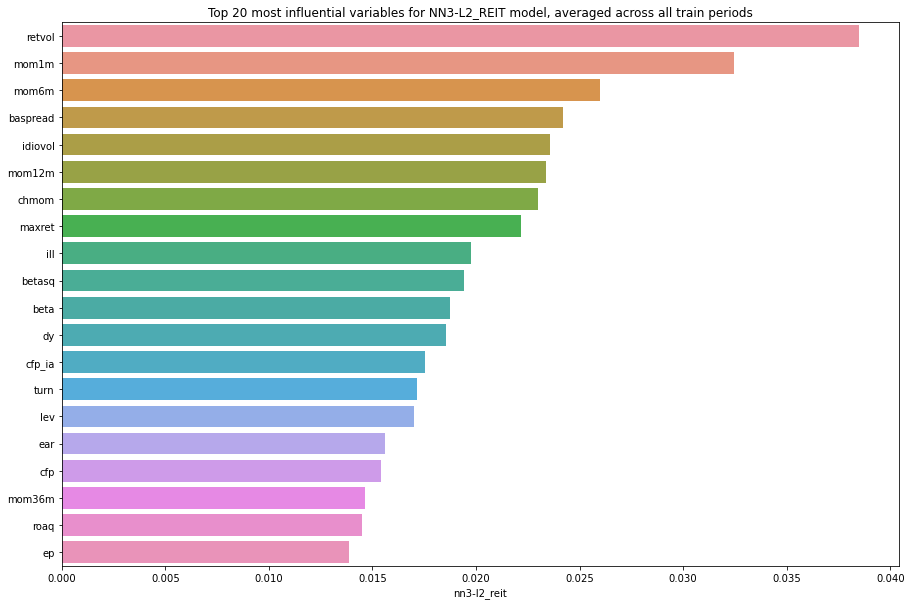

In [47]:
# Plot features of importance
# Plot graph
df_top20 = df_impt.sort_values(by=[model_name], ascending = False).head(20)
plt.figure(figsize=(15,10))
plt.title(f'Top 20 most influential variables for {model_name.upper()} model, averaged across all train periods')
sns.barplot(data = df_top20, x = model_name, y = df_top20.index);

In [48]:
# Merge df_temp to existing df_r2drecrease table

df_r2decrease_reit = pd.merge(
    left = df_r2decrease_reit,
    right = df_impt[model_name],
    how = 'left',
    left_index = True,
    right_index = True    
)

# Rank R2decrease table after including new model results
df_featurerank_reit = df_r2decrease_reit.rank() 
df_featurerank_reit['all_models'] = df_featurerank_reit.sum(axis=1)

# Display tables
display(df_r2decrease_reit)
display(df_featurerank_reit.sort_values('all_models', ascending = False))

# Save dfs to .csv 
df_r2decrease_reit.to_csv('../data/df_r2decrease_reit.csv', index = False)
df_featurerank_reit.to_csv('../data/df_featurerank_reit.csv', index = False)

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
absacc           0.000306   -0.001380    0.000189    0.000000   0.000000   
acc              0.001430   -0.000741    0.001779    0.000000   0.000000   
aeavol           0.000650    0.000668    0.005239    0.001173   0.001226   
age              0.000137   -0.000080    0.001680    0.000018   0.000030   
agr              0.000223    0.005201    0.003357    0.000000   0.000010   
baspread         0.007390    0.007871    0.000149    0.000000   0.000000   
beta             0.008894    0.057075    0.000315    0.000000   0.000000   
betasq           0.013997    0.013039    0.002645    0.000000   0.000000   
bm               0.001241    0.000853    0.024032    0.025538   0.026162   
bm_ia            0.002404    0.004776    0.007611    0.004235   0.004285   
cash             0.000161    0.000505    0.003340    0.000873   0.000927   
cashdebt         0.000128   -0.001187    0.000750    0.000000   0.000000   
cashpr           0.001257    0.002444    0.004893    0.001111   0.001181   
cfp              0.006021    0.006040    0.008196    0.013265   0.013306   
cfp_ia           0.001410    0.004166    0.007417    0.015930   0.015591   
chatoia          0.000082   -0.000040   -0.000983   -0.000089  -0.000097   
chcsho           0.000206   -0.000878    0.005366    0.002707   0.002796   
chempia          0.001031    0.003782   -0.000006    0.000000   0.000000   
chinv            0.000245   -0.000393    0.000482    0.000000   0.000000   
chmom            0.052654    0.050540    0.096469    0.142593   0.139152   
chpmia           0.002182    0.002565    0.011188    0.005567   0.005818   
chtx            -0.000017   -0.000019    0.000188    0.000000   0.000000   
cinvest          0.000038    0.000148    0.000281    0.000000   0.000000   
convind          0.000886    0.000794    0.000866    0.000000   0.000000   
currat           0.091179    0.044869   -0.000742    0.000000   0.000000   
depr            -0.000063    0.000391    0.001464    0.000148   0.000158   
divi             0.000153    0.000328    0.000156    0.000000   0.000000   
divo             0.000145    0.000922    0.000460    0.000000   0.000000   
dolvol           0.052843    0.089712    0.018587    0.017184   0.017007   
dy               0.016294    0.015071    0.090116    0.083019   0.084596   
ear              0.000198    0.000341    0.007511    0.004939   0.005175   
egr              0.001280    0.002940    0.004116    0.001198   0.001247   
ep               0.001748    0.010111    0.008772    0.004712   0.004875   
gma              0.003155   -0.001219    0.004361    0.000000   0.000000   
grcapx           0.000474    0.000658   -0.000177    0.000000   0.000000   
grltnoa          0.002414    0.001948    0.004432    0.000000   0.000000   
herf             0.023766    0.022687    0.023490    0.026236   0.026005   
hire             0.000198    0.002251    0.000338    0.000000   0.000000   
idiovol          0.000873   -0.000939    0.012297    0.014589   0.014951   
ill              0.005484    0.010939    0.022225    0.013264   0.013836   
indmom          -0.000049    0.000309    0.000357    0.000269   0.000290   
invest           0.000890    0.000858    0.002343    0.000000   0.000000   
lev             -0.000274   -0.002811   -0.002411    0.000000   0.000000   
lgr              0.000145    0.000304    0.000079    0.000000   0.000000   
maxret           0.025620    0.054758    0.005975    0.000000   0.000000   
mom12m           0.004666    0.002331    0.047325    0.017174   0.020037   
mom1m            0.019050    0.030089    0.134880    0.123642   0.127685   
mom36m           0.004236    0.006796    0.023669    0.021621   0.022049   
mom6m            0.056381    0.030482    0.053236    0.127055   0.120789   
ms               0.000196    0.000743    0.002229    0.000000   0.000000   
mve0             0.200379    0.212738    0.122775    0.137827   0.135776   
mve_ia           0.116817    0.152169    0.033515    0.073484   0.

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
mom1m               84.0        84.0        94.0        91.0       92.0   
chmom               87.0        89.0        92.0        94.0       94.0   
mom12m              74.0        60.0        88.0        82.0       83.0   
retvol              93.0        86.0        90.0        87.0       87.0   
mom6m               89.0        85.0        89.0        92.0       91.0   
mve0                94.0        94.0        93.0        93.0       93.0   
dy                  83.0        82.0        91.0        90.0       90.0   
sgr                 79.0        76.0        87.0        88.0       88.0   
herf                85.0        83.0        83.0        86.0       85.0   
mom36m              72.0        72.0        84.0        84.0       84.0   
ill                 75.0        78.0        82.0        78.0       79.0   
maxret              86.0        90.0        68.0        26.0       25.5   
bm                  54.0        47.0        85.0        85.0       86.0   
dolvol              88.0        92.0        81.0        83.0       82.0   
cfp                 76.0        71.0        75.0        79.0       78.0   
bm_ia               68.0        69.0        73.0        72.0       72.0   
ep                  63.0        77.0        76.0        73.0       73.0   
idiovol             48.0         7.0        80.0        80.0       80.0   
cfp_ia              57.0        67.0        71.0        81.0       81.0   
tang                61.0        54.0        77.0        66.0       67.0   
chpmia              67.0        62.0        79.0        75.0       75.0   
sp                  59.0        75.0        66.0        76.0       76.0   
rd_sale             73.0        74.0        74.0        77.0       77.0   
pchdepr             43.0        35.0        57.0        67.0       66.0   
ear                 29.0        33.0        72.0        74.0       74.0   
mve_ia              92.0        93.0        86.0        89.0       89.0   
saleinv             66.0        55.0        78.0        69.0       69.0   
turn                77.0        79.0        40.0        62.0       62.0   
roavol              65.0        68.0        67.0        68.0       68.0   
betasq              81.0        80.0        49.0        26.0       25.5   
beta                80.0        91.0        26.0        26.0       25.5   
pchsale_pchinvt     27.0        28.0        51.0        52.0       51.0   
std_dolvol          39.0        53.0        63.0        59.0       59.0   
baspread            78.0        73.0        18.0        26.0       25.5   
zerotrade           82.0        57.0        50.0        53.0       52.0   
cash                25.0        39.0        54.0        61.0       61.0   
invest              50.0        48.0        46.0        26.0       25.5   
roic                47.0         6.0        70.0        70.0       70.0   
pchgm_pchsale       32.0        20.0        61.0        58.0       58.0   
stdacc              60.0        64.0        15.0        26.0       25.5   
roaq                62.0        65.0        69.0        26.0       25.5   
aeavol              46.0        43.0        64.0        64.0       64.0   
rd_mve               8.0        44.0        47.0        50.0       53.0   
egr                 56.0        63.0        58.0        65.0       65.0   
grltnoa             69.0        56.0        60.0        26.0       25.5   
chtx                 9.0        24.0        20.0        26.0       25.5   
cashpr              55.0        61.0        62.0        63.0       63.0   
agr                 35.0        70.0        55.0        26.0       48.0   
stdcf               70.0        81.0         9.0        26.0       25.5   
salerec             26.0        26.0        56.0        60.0       60.0   
chinv               36.0        12.0        34.0        26.0       25.5   
nincr               37.0        13.0        53.0        49.0       49.0   
indmom               7.0        31.0      

## NN5 (L2 penalty)

### REIT

In [33]:
df_results_reit = df_results_reit[:15]

In [34]:
# Create list of configs to test on 
def model_configs():
    # define scope of configs
    n_penalty_type = [l2]
    n_penalty_amount = np.logspace(-5, -3, 5)
    n_learning_rate = [0.001, 0.01]
    # create configs
    configs = []
    for i in n_penalty_type:
        for j in n_penalty_amount:
            for k in n_learning_rate:
                cfg = [i,j,k]
                configs.append(cfg)
    print('Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): %d' %len(configs))
    return configs

def model_fit(X_train, X_validate, y_train, y_validate, cfg):
    # unpack config
    n_penalty_type, n_penalty_amount, n_learning_rate = cfg
    
    # Instantiate a Sequential model
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(32, activation = 'relu', 
                    input_dim = X_train.shape[1], 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())
    
    # Add an input layer #2
    model.add(Dense(16, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #3
    model.add(Dense(8, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #4
    model.add(Dense(4, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #5
    model.add(Dense(2, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())    
        
    # Add an output layer
    model.add(Dense(1, activation = None, 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Set learning rate
    opt = Adam(learning_rate = n_learning_rate)
    
    # Compile model
    model.compile(loss = 'mse',optimizer = opt)

    # Early stop
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5
    )    
    
    # Convert to np.array before calling model.fit()
    #  to speed up calculations
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)    
    X_validate = np.asarray(X_validate)
    y_validate = np.asarray(y_validate) 
    
    # Fit model
    model.fit(X_train, y_train,
              validation_data = (X_validate, y_validate),
              epochs = 500,
              batch_size = 2 ** 13,
              callbacks = [early_stop]
             )
   
    return model

In [35]:
# Instantiate list of configurations
cfg_list = model_configs()

Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): 10


In [36]:
%%time
# Create model name 
model_name = 'nn5-l2_reit'

# Create new row of test results
df_results_reit = pd.concat(
    [df_results_reit, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_reit
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 124us/sample - loss: 110.7471 - val_loss: 104.1576
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 110.1129 - val_loss: 104.2582
Epoch 3/500
21360/21360 [==============================] - 0s 6us/sample - loss: 109.7357 - val_loss: 104.3451
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 109.3891 - val_loss: 104.4130
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 109.1238 - val_loss: 104.4697
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.8288 - val_loss: 104.5205
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.67, 10.22, 0.04, 10.44
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 138us/sample - loss: 110.0579 - val_loss: 106.4986
Epoch 2/500
21360/21360 [====================

21360/21360 [==============================] - 0s 5us/sample - loss: 106.0308 - val_loss: 104.3072
Epoch 31/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.9497 - val_loss: 104.2626
Epoch 32/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.8341 - val_loss: 104.2195
Epoch 33/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.7454 - val_loss: 104.1773
Epoch 34/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.6271 - val_loss: 104.1390
Epoch 35/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.5222 - val_loss: 104.1023
Epoch 36/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.4401 - val_loss: 104.0651
Epoch 37/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.3450 - val_loss: 104.0255
Epoch 38/500
21360/21360 [==============================] - 0s 5us/sample - loss: 105.2345 - val_loss: 103.9928
Epoch

21360/21360 [==============================] - 0s 6us/sample - loss: 92.8484 - val_loss: 104.4672
Epoch 24/500
21360/21360 [==============================] - 0s 6us/sample - loss: 92.4148 - val_loss: 104.7405
Epoch 25/500
21360/21360 [==============================] - 0s 6us/sample - loss: 91.8494 - val_loss: 104.5884
Epoch 26/500
21360/21360 [==============================] - 0s 6us/sample - loss: 91.3744 - val_loss: 104.2147
Epoch 27/500
21360/21360 [==============================] - 0s 6us/sample - loss: 90.9177 - val_loss: 104.1572
Epoch 28/500
21360/21360 [==============================] - 0s 6us/sample - loss: 90.2338 - val_loss: 104.3811
Epoch 29/500
21360/21360 [==============================] - 0s 6us/sample - loss: 90.2614 - val_loss: 104.8642
Epoch 30/500
21360/21360 [==============================] - 0s 6us/sample - loss: 89.4842 - val_loss: 104.4027
Epoch 31/500
21360/21360 [==============================] - 0s 6us/sample - loss: 88.9561 - val_loss: 103.8778
Epoch 32/500
2

Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 109.0768 - val_loss: 106.2301
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.9440 - val_loss: 106.0820
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.8010 - val_loss: 105.9522
Epoch 7/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.6906 - val_loss: 105.8371
Epoch 8/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.5674 - val_loss: 105.7333
Epoch 9/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.4237 - val_loss: 105.6432
Epoch 10/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.3195 - val_loss: 105.5570
Epoch 11/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.1868 - val_loss: 105.4764
Epoch 12/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.0671 - val_loss: 105.404

Epoch 14/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.5396 - val_loss: 105.1939
Epoch 15/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.3821 - val_loss: 105.1476
Epoch 16/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.2255 - val_loss: 105.1026
Epoch 17/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.0612 - val_loss: 105.0568
Epoch 18/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.9150 - val_loss: 105.0098
Epoch 19/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.7354 - val_loss: 104.9601
Epoch 20/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.5893 - val_loss: 104.9110
Epoch 21/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.4295 - val_loss: 104.8621
Epoch 22/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.2836 - val_loss: 1

21360/21360 [==============================] - 0s 6us/sample - loss: 106.8116 - val_loss: 104.0606
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 106.0886 - val_loss: 104.0307
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.3195 - val_loss: 103.9490
Epoch 7/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.6268 - val_loss: 103.8938
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 1.26, 10.19, 0.44, 10.42
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 123us/sample - loss: 110.0124 - val_loss: 103.6900
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.7116 - val_loss: 103.8044
Epoch 3/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.0224 - val_loss: 103.8040
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.4778 - v

Epoch 58/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.2995 - val_loss: 104.0583
Epoch 59/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.2412 - val_loss: 104.0490
Epoch 60/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.1308 - val_loss: 104.0358
Epoch 61/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.0962 - val_loss: 104.0210
Epoch 62/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.9918 - val_loss: 104.0027
Epoch 63/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.9484 - val_loss: 103.9871
Epoch 64/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.8730 - val_loss: 103.9748
Epoch 65/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.7648 - val_loss: 103.9637
Epoch 66/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.7007 - val_loss: 1

21360/21360 [==============================] - 0s 6us/sample - loss: 103.5762 - val_loss: 104.1444
Epoch 38/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.3531 - val_loss: 104.1309
Epoch 39/500
21360/21360 [==============================] - 0s 5us/sample - loss: 103.2225 - val_loss: 104.1161
Epoch 40/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.0511 - val_loss: 104.0917
Epoch 41/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.8637 - val_loss: 104.0689
Epoch 42/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.7011 - val_loss: 104.0508
Epoch 43/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.6552 - val_loss: 104.0188
Epoch 44/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.3489 - val_loss: 103.9960
Epoch 45/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.2032 - val_loss: 103.9676
Epoch

21360/21360 [==============================] - 0s 6us/sample - loss: 108.2669 - val_loss: 104.9366
Epoch 15/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.1908 - val_loss: 104.9110
Epoch 16/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.1385 - val_loss: 104.8848
Epoch 17/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.0767 - val_loss: 104.8594
Epoch 18/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.9849 - val_loss: 104.8339
Epoch 19/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.9191 - val_loss: 104.8081
Epoch 20/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.8514 - val_loss: 104.7833
Epoch 21/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.7857 - val_loss: 104.7591
Epoch 22/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.6977 - val_loss: 104.7347
Epoch

21360/21360 [==============================] - 0s 6us/sample - loss: 106.5191 - val_loss: 104.0620
Epoch 10/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.9331 - val_loss: 103.9005
Epoch 11/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.1997 - val_loss: 103.7348
Epoch 12/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.6548 - val_loss: 103.6093
Epoch 13/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.0226 - val_loss: 103.4625
Epoch 14/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.3317 - val_loss: 103.3898
Epoch 15/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.5447 - val_loss: 103.3255
Epoch 16/500
21360/21360 [==============================] - 0s 6us/sample - loss: 101.7854 - val_loss: 103.3597
Epoch 17/500
21360/21360 [==============================] - 0s 6us/sample - loss: 100.9742 - val_loss: 103.3078
Epoch

21360/21360 [==============================] - 0s 6us/sample - loss: 99.1141 - val_loss: 103.1237
Epoch 19/500
21360/21360 [==============================] - 0s 6us/sample - loss: 98.4140 - val_loss: 103.3586
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 1.81, 10.16, -2.61, 10.58
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 123us/sample - loss: 109.4253 - val_loss: 105.1249
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.3330 - val_loss: 105.0010
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.6957 - val_loss: 104.8899
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.0070 - val_loss: 104.7986
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.4101 - val_loss: 104.7357
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.5045 - v

21360/21360 [==============================] - 0s 6us/sample - loss: 106.5312 - val_loss: 105.4731
Epoch 21/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.3283 - val_loss: 105.4567
Epoch 22/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.1275 - val_loss: 105.4438
Epoch 23/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.8923 - val_loss: 105.4328
Epoch 24/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.6942 - val_loss: 105.4180
Epoch 25/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.4490 - val_loss: 105.4034
Epoch 26/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.2255 - val_loss: 105.3828
Epoch 27/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.0299 - val_loss: 105.3620
Epoch 28/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.7996 - val_loss: 105.3444
Epoch

21360/21360 [==============================] - 0s 5us/sample - loss: 108.7066 - val_loss: 105.1900
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.4748 - val_loss: 105.1333
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 108.1892 - val_loss: 105.0802
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.9588 - val_loss: 105.0296
Epoch 11/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.7456 - val_loss: 104.9814
Epoch 12/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.5463 - val_loss: 104.9389
Epoch 13/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.3244 - val_loss: 104.8967
Epoch 14/500
21360/21360 [==============================] - 0s 5us/sample - loss: 107.1104 - val_loss: 104.8574
Epoch 15/500
21360/21360 [==============================] - 0s 5us/sample - loss: 106.9180 - val_loss: 104.8226
Epoch 1

21360/21360 [==============================] - 0s 6us/sample - loss: 103.4611 - val_loss: 104.1591
Epoch 11/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.4224 - val_loss: 104.0946
Epoch 12/500
21360/21360 [==============================] - 0s 6us/sample - loss: 101.1459 - val_loss: 104.0527
Epoch 13/500
21360/21360 [==============================] - 0s 6us/sample - loss: 100.0639 - val_loss: 104.0252
Epoch 14/500
21360/21360 [==============================] - 0s 6us/sample - loss: 99.2734 - val_loss: 104.0391
Epoch 15/500
21360/21360 [==============================] - 0s 6us/sample - loss: 97.8825 - val_loss: 104.0825
Epoch 16/500
21360/21360 [==============================] - 0s 6us/sample - loss: 96.7660 - val_loss: 104.1502
Epoch 17/500
21360/21360 [==============================] - 0s 6us/sample - loss: 96.5076 - val_loss: 104.2232
Epoch 18/500
21360/21360 [==============================] - 0s 6us/sample - loss: 95.2673 - val_loss: 104.3182
[<function

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
0       3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
0       0.84 (10.40)         1.55 (10.18)              NaN          NaN   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
0    -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
0              NaN            NaN            NaN           NaN            NaN   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.55, 10.18, 0.84, 10.40
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 1.37, 10.19, 1.15, 10.39
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 1.32, 10.19, 1.69, 10.36
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 1.23, 10.19, 0.92, 10.40
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 1.22, 10.19, 2.00, 10.34
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.17, 10.20, 1.38, 10.37
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 1.04, 10.20, 0.10, 10.44
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.63, 10.23, 1.62, 10.36
CPU times: user 15min 24s, sys: 9min 11s, total: 24min 36s
Wall time: 7min 12s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.55, 10.18, 0.84, 10.40

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 1.37, 10.19, 1.15, 10.39

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 1.32, 10.19, 1.69, 10.36

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 1.23, 10.19, 0.92, 10.40

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 1.22, 10.19, 2.00, 10.34

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 1.17, 10.20, 1.38, 10.37

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 1.04, 10.20, 0.10, 10.44

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.63, 10.23, 1.62, 10.36

CPU times: user 15min 24s, sys: 9min 11s, total: 24min 36s

Wall time: 7min 12s

In [37]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_reit
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_reit.to_csv('../data/df_results_reit.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 122us/sample - loss: 109.1416 - val_loss: 104.6564
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 108.0730 - val_loss: 104.5394
Epoch 3/500
21360/21360 [==============================] - 0s 6us/sample - loss: 107.2077 - val_loss: 104.4935
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 106.4931 - val_loss: 104.4853
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.6348 - val_loss: 104.4559
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.9852 - val_loss: 104.3865
Epoch 7/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.9909 - val_loss: 104.2969
Epoch 8/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.0646 - val_loss: 104.2001
Epoch 9/500
21360/21360 [==============================] - 0

Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.7884 - val_loss: 104.2471
Epoch 7/500
21360/21360 [==============================] - 0s 6us/sample - loss: 105.1071 - val_loss: 104.1125
Epoch 8/500
21360/21360 [==============================] - 0s 6us/sample - loss: 104.3659 - val_loss: 104.0109
Epoch 9/500
21360/21360 [==============================] - 0s 6us/sample - loss: 103.5702 - val_loss: 103.9045
Epoch 10/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.8329 - val_loss: 103.8097
Epoch 11/500
21360/21360 [==============================] - 0s 6us/sample - loss: 102.0099 - val_loss: 103.7469
Epoch 12/500
21360/21360 [==============================] - 0s 6us/sample - loss: 101.0341 - val_loss: 103.7246
Epoch 13/500
21360/21360 [==============================] - 0s 6us/sample - loss: 100.0111 - val_loss: 103.7059
Epoch 14/500
21360/21360 [==============================] - 0s 6us/sample - loss: 99.4138 - val_loss: 103.68

23469/23469 [==============================] - 0s 6us/sample - loss: 103.5363 - val_loss: 81.1533
Epoch 17/500
23469/23469 [==============================] - 0s 5us/sample - loss: 102.4610 - val_loss: 81.1296
Epoch 18/500
23469/23469 [==============================] - 0s 5us/sample - loss: 101.4243 - val_loss: 81.1591
Epoch 19/500
23469/23469 [==============================] - 0s 5us/sample - loss: 100.3711 - val_loss: 81.1930
Epoch 20/500
23469/23469 [==============================] - 0s 5us/sample - loss: 99.2166 - val_loss: 81.1930
Epoch 21/500
23469/23469 [==============================] - 0s 5us/sample - loss: 98.4009 - val_loss: 81.1608
Epoch 22/500
23469/23469 [==============================] - 0s 5us/sample - loss: 97.3528 - val_loss: 81.1611
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_reit_2007_2/assets
Train on 23469 samples, validate on 10493 samples
Epoch 1/500
23469/23469 [==============================] - 3s 114us/sample - loss: 114.8326 - val_loss: 82.8285
Epoch 

Epoch 14/500
25480/25480 [==============================] - 0s 5us/sample - loss: 108.7529 - val_loss: 81.5026
Epoch 15/500
25480/25480 [==============================] - 0s 6us/sample - loss: 107.8555 - val_loss: 81.5085
Epoch 16/500
25480/25480 [==============================] - 0s 5us/sample - loss: 107.3625 - val_loss: 81.4276
Epoch 17/500
25480/25480 [==============================] - 0s 6us/sample - loss: 106.8732 - val_loss: 81.5161
Epoch 18/500
25480/25480 [==============================] - 0s 6us/sample - loss: 106.5206 - val_loss: 81.4899
Epoch 19/500
25480/25480 [==============================] - 0s 6us/sample - loss: 105.8863 - val_loss: 81.4199
Epoch 20/500
25480/25480 [==============================] - 0s 5us/sample - loss: 105.2697 - val_loss: 81.4408
Epoch 21/500
25480/25480 [==============================] - 0s 5us/sample - loss: 106.3036 - val_loss: 81.4109
Epoch 22/500
25480/25480 [==============================] - 0s 5us/sample - loss: 105.8332 - val_loss: 81.3404
E

31753/31753 [==============================] - 0s 5us/sample - loss: 103.0718 - val_loss: 260.8522
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_reit_2011_1/assets
Train on 31753 samples, validate on 9643 samples
Epoch 1/500
31753/31753 [==============================] - 3s 84us/sample - loss: 108.7918 - val_loss: 261.2097
Epoch 2/500
31753/31753 [==============================] - 0s 5us/sample - loss: 107.3070 - val_loss: 261.1749
Epoch 3/500
31753/31753 [==============================] - 0s 5us/sample - loss: 106.6090 - val_loss: 261.0517
Epoch 4/500
31753/31753 [==============================] - 0s 5us/sample - loss: 106.1241 - val_loss: 260.9548
Epoch 5/500
31753/31753 [==============================] - 0s 5us/sample - loss: 105.6347 - val_loss: 260.9253
Epoch 6/500
31753/31753 [==============================] - 0s 5us/sample - loss: 105.0787 - val_loss: 260.9825
Epoch 7/500
31753/31753 [==============================] - 0s 5us/sample - loss: 104.4448 - val_loss: 261.1502
Epo

35928/35928 [==============================] - 0s 5us/sample - loss: 100.0869 - val_loss: 266.7861
Epoch 11/500
35928/35928 [==============================] - 0s 5us/sample - loss: 99.1350 - val_loss: 266.7933
Epoch 12/500
35928/35928 [==============================] - 0s 5us/sample - loss: 98.4568 - val_loss: 266.8361
Epoch 13/500
35928/35928 [==============================] - 0s 5us/sample - loss: 98.2934 - val_loss: 267.0207
Epoch 14/500
35928/35928 [==============================] - 0s 5us/sample - loss: 97.3903 - val_loss: 267.1877
Epoch 15/500
35928/35928 [==============================] - 0s 5us/sample - loss: 96.6437 - val_loss: 267.3554
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_reit_2013_4/assets
Test year 2013 done, R2 score is 1.11
Test year 2013 done, RMSE score is 9.38
Train on 37784 samples, validate on 9669 samples
Epoch 1/500
37784/37784 [==============================] - 11s 300us/sample - loss: 120.3105 - val_loss: 203.6786
Epoch 2/500
37784/37784 [=========

39556/39556 [==============================] - 0s 5us/sample - loss: 138.9987 - val_loss: 92.6080
Epoch 11/500
39556/39556 [==============================] - 0s 5us/sample - loss: 138.5322 - val_loss: 92.5887
Epoch 12/500
39556/39556 [==============================] - 0s 5us/sample - loss: 138.0384 - val_loss: 92.6764
Epoch 13/500
39556/39556 [==============================] - 0s 5us/sample - loss: 137.2071 - val_loss: 92.6268
Epoch 14/500
39556/39556 [==============================] - 0s 5us/sample - loss: 136.7502 - val_loss: 92.5665
Epoch 15/500
39556/39556 [==============================] - 0s 5us/sample - loss: 136.4793 - val_loss: 92.5954
Epoch 16/500
39556/39556 [==============================] - 0s 5us/sample - loss: 136.0133 - val_loss: 92.5959
Epoch 17/500
39556/39556 [==============================] - 0s 5us/sample - loss: 135.3424 - val_loss: 92.6427
Epoch 18/500
39556/39556 [==============================] - 0s 5us/sample - loss: 134.7243 - val_loss: 92.7560
Epoch 19/500
3

Epoch 2/500
39556/39556 [==============================] - 0s 4us/sample - loss: 142.0456 - val_loss: 93.1990
Epoch 3/500
39556/39556 [==============================] - 0s 5us/sample - loss: 141.1219 - val_loss: 93.0230
Epoch 4/500
39556/39556 [==============================] - 0s 5us/sample - loss: 140.3277 - val_loss: 92.9458
Epoch 5/500
39556/39556 [==============================] - 0s 5us/sample - loss: 139.5935 - val_loss: 92.8209
Epoch 6/500
39556/39556 [==============================] - 0s 5us/sample - loss: 138.7663 - val_loss: 92.7537
Epoch 7/500
39556/39556 [==============================] - 0s 5us/sample - loss: 137.6702 - val_loss: 92.7733
Epoch 8/500
39556/39556 [==============================] - 0s 5us/sample - loss: 136.6752 - val_loss: 92.7248
Epoch 9/500
39556/39556 [==============================] - 0s 5us/sample - loss: 135.4166 - val_loss: 92.7282
Epoch 10/500
39556/39556 [==============================] - 0s 5us/sample - loss: 134.0769 - val_loss: 92.7310
Epoch 11/

41396/41396 [==============================] - 0s 5us/sample - loss: 142.5084 - val_loss: 74.8008
Epoch 4/500
41396/41396 [==============================] - 0s 5us/sample - loss: 142.1554 - val_loss: 74.6765
Epoch 5/500
41396/41396 [==============================] - 0s 5us/sample - loss: 141.9559 - val_loss: 74.5966
Epoch 6/500
41396/41396 [==============================] - 0s 5us/sample - loss: 141.6419 - val_loss: 74.5286
Epoch 7/500
41396/41396 [==============================] - 0s 5us/sample - loss: 141.2606 - val_loss: 74.4865
Epoch 8/500
41396/41396 [==============================] - 0s 5us/sample - loss: 141.0350 - val_loss: 74.4553
Epoch 9/500
41396/41396 [==============================] - 0s 5us/sample - loss: 140.6933 - val_loss: 74.4474
Epoch 10/500
41396/41396 [==============================] - 0s 5us/sample - loss: 140.3465 - val_loss: 74.5031
Epoch 11/500
41396/41396 [==============================] - 0s 5us/sample - loss: 140.0855 - val_loss: 74.5465
Epoch 12/500
41396/4

45304/45304 [==============================] - 0s 5us/sample - loss: 123.9450 - val_loss: 64.3209
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_reit_2018_3/assets
Train on 45304 samples, validate on 11733 samples
Epoch 1/500
45304/45304 [==============================] - 12s 268us/sample - loss: 141.1249 - val_loss: 64.6969
Epoch 2/500
45304/45304 [==============================] - 0s 4us/sample - loss: 138.6243 - val_loss: 64.5083
Epoch 3/500
45304/45304 [==============================] - 0s 4us/sample - loss: 137.9567 - val_loss: 64.3623
Epoch 4/500
45304/45304 [==============================] - 0s 4us/sample - loss: 137.4214 - val_loss: 64.2357
Epoch 5/500
45304/45304 [==============================] - 0s 5us/sample - loss: 136.7477 - val_loss: 64.1581
Epoch 6/500
45304/45304 [==============================] - 0s 5us/sample - loss: 135.8299 - val_loss: 64.1269
Epoch 7/500
45304/45304 [==============================] - 0s 5us/sample - loss: 134.9671 - val_loss: 64.1184
Epoch 8/

47453/47453 [==============================] - 0s 4us/sample - loss: 136.3404 - val_loss: 60.7451
Epoch 3/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.6683 - val_loss: 60.8205
Epoch 4/500
47453/47453 [==============================] - 0s 4us/sample - loss: 135.0336 - val_loss: 61.0473
Epoch 5/500
47453/47453 [==============================] - 0s 4us/sample - loss: 134.4018 - val_loss: 61.1661
Epoch 6/500
47453/47453 [==============================] - 0s 5us/sample - loss: 133.5829 - val_loss: 60.9007
Epoch 7/500
47453/47453 [==============================] - 0s 5us/sample - loss: 132.7635 - val_loss: 60.8275
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_reit_2019_4/assets
Test year 2019 done, R2 score is 4.23
Test year 2019 done, RMSE score is 8.19
Train on 49786 samples, validate on 11932 samples
Epoch 1/500
49786/49786 [==============================] - 3s 55us/sample - loss: 133.7256 - val_loss: 65.1392
Epoch 2/500
49786/49786 [=================

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
0       3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
0       0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
0    -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
0    -3.51 (11.48)  -1.69 (19.98)   0.57 (25.11)  1.74 (12.36)  -0.97 (10.13)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00


R2 for entire pooled test set, from 2006 to 2020, is 0.23.
RMSE for entire pooled test set, from 2006 to 2020, is 12.11.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]
CPU times: user 18min 4s, sys: 8min 9s, total: 26min 14s
Wall time: 10min 25s


R2 for entire pooled test set, from 2006 to 2020, is 0.23.

RMSE for entire pooled test set, from 2006 to 2020, is 12.11.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]

CPU times: user 18min 4s, sys: 8min 9s, total: 26min 14s

Wall time: 10min 25s

### Sample 1

In [38]:
df_results_sample1 = df_results_sample1[:15]

In [39]:
%%time
# Create model name 
model_name = 'nn5-l2_sample1'

# Create new row of test results
df_results_sample1 = pd.concat(
    [df_results_sample1, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample1
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 124us/sample - loss: 436.8675 - val_loss: 361.0490
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 435.7319 - val_loss: 361.0798
Epoch 3/500
21360/21360 [==============================] - 0s 6us/sample - loss: 434.9389 - val_loss: 361.1090
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 434.0645 - val_loss: 361.1363
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 433.4067 - val_loss: 361.1613
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 432.7347 - val_loss: 361.1894
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.02, 19.00, 0.10, 20.87
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 123us/sample - loss: 435.8125 - val_loss: 361.3045
Epoch 2/500
21360/21360 [====================

21360/21360 [==============================] - 0s 6us/sample - loss: 420.7459 - val_loss: 359.7800
Epoch 35/500
21360/21360 [==============================] - 0s 6us/sample - loss: 420.2740 - val_loss: 359.7541
Epoch 36/500
21360/21360 [==============================] - 0s 6us/sample - loss: 419.8028 - val_loss: 359.7468
Epoch 37/500
21360/21360 [==============================] - 0s 6us/sample - loss: 419.3113 - val_loss: 359.7505
Epoch 38/500
21360/21360 [==============================] - 0s 6us/sample - loss: 418.7573 - val_loss: 359.7577
Epoch 39/500
21360/21360 [==============================] - 0s 6us/sample - loss: 418.3826 - val_loss: 359.7421
Epoch 40/500
21360/21360 [==============================] - 0s 6us/sample - loss: 417.7618 - val_loss: 359.7322
Epoch 41/500
21360/21360 [==============================] - 0s 6us/sample - loss: 417.2519 - val_loss: 359.7217
Epoch 42/500
21360/21360 [==============================] - 0s 6us/sample - loss: 416.6785 - val_loss: 359.7249
Epoch

Epoch 9/500
21360/21360 [==============================] - 0s 6us/sample - loss: 403.1892 - val_loss: 360.1691
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 396.0730 - val_loss: 360.0997
Epoch 11/500
21360/21360 [==============================] - 0s 6us/sample - loss: 390.5610 - val_loss: 360.0634
Epoch 12/500
21360/21360 [==============================] - 0s 6us/sample - loss: 388.0805 - val_loss: 360.0280
Epoch 13/500
21360/21360 [==============================] - 0s 6us/sample - loss: 384.7737 - val_loss: 360.0133
Epoch 14/500
21360/21360 [==============================] - 0s 5us/sample - loss: 382.0194 - val_loss: 359.9889
Epoch 15/500
21360/21360 [==============================] - 0s 6us/sample - loss: 377.9509 - val_loss: 359.9858
Epoch 16/500
21360/21360 [==============================] - 0s 6us/sample - loss: 372.9432 - val_loss: 359.9959
Epoch 17/500
21360/21360 [==============================] - 0s 6us/sample - loss: 370.2590 - val_loss: 35

Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 423.8346 - val_loss: 360.3053
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 420.3167 - val_loss: 360.3795
Epoch 7/500
21360/21360 [==============================] - 0s 6us/sample - loss: 415.6349 - val_loss: 360.3537
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.25, 18.98, 0.37, 20.84

Ensemble results from Model [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01]: [ 0.25187239 18.98290609  0.50656346 20.82443249]
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 124us/sample - loss: 437.6151 - val_loss: 362.2898
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 436.5842 - val_loss: 362.1138
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.8659 - val_loss: 361.9661
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 4

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 124us/sample - loss: 438.2866 - val_loss: 360.5818
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 437.1428 - val_loss: 360.5841
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 436.2111 - val_loss: 360.6007
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 435.3243 - val_loss: 360.6161
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 434.5585 - val_loss: 360.6310
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.8159 - val_loss: 360.6566
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.17, 18.99, 0.16, 20.86
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 136us/sample - loss: 438.4516 - val_loss: 361.2593
Epoch 2/500
21360/21360 [===

21360/21360 [==============================] - 0s 5us/sample - loss: 435.7159 - val_loss: 361.1445
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.3075 - val_loss: 361.0869
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.9730 - val_loss: 361.0348
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.6845 - val_loss: 360.9903
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.3744 - val_loss: 360.9542
Epoch 7/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.1586 - val_loss: 360.9216
Epoch 8/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.8908 - val_loss: 360.8939
Epoch 9/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.6530 - val_loss: 360.8701
Epoch 10/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.4056 - val_loss: 360.8483
Epoch 11/500

21360/21360 [==============================] - 0s 5us/sample - loss: 434.8169 - val_loss: 361.2237
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.1858 - val_loss: 361.2500
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.6542 - val_loss: 361.2689
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.00, 19.01, 0.07, 20.87
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 125us/sample - loss: 437.3295 - val_loss: 361.0539
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 436.3608 - val_loss: 361.0471
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.7106 - val_loss: 361.0459
Epoch 4/500
21360/21360 [==============================] - 0s 5us/sample - loss: 435.0716 - val_loss: 361.0466
Epoch 5/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.4154 - val_loss: 361.05

Epoch 12/500
21360/21360 [==============================] - 0s 5us/sample - loss: 416.5889 - val_loss: 360.0159
Epoch 13/500
21360/21360 [==============================] - 0s 5us/sample - loss: 413.9920 - val_loss: 360.0480
Epoch 14/500
21360/21360 [==============================] - 0s 5us/sample - loss: 410.1313 - val_loss: 360.1105
Epoch 15/500
21360/21360 [==============================] - 0s 5us/sample - loss: 406.8827 - val_loss: 360.1178
Epoch 16/500
21360/21360 [==============================] - 0s 5us/sample - loss: 401.9580 - val_loss: 360.1389
Epoch 17/500
21360/21360 [==============================] - 0s 5us/sample - loss: 397.5382 - val_loss: 360.1676
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.31, 18.98, 0.31, 20.85
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 125us/sample - loss: 435.8112 - val_loss: 361.3556
Epoch 2/500
21360/21360 [==============================] - 0s 5us/sample - loss: 434.6552 -

21360/21360 [==============================] - 0s 6us/sample - loss: 406.3586 - val_loss: 360.2629
Epoch 12/500
21360/21360 [==============================] - 0s 6us/sample - loss: 399.1081 - val_loss: 360.3166
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.27, 18.98, 0.33, 20.84
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 123us/sample - loss: 436.0639 - val_loss: 361.1828
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 434.7838 - val_loss: 361.0825
Epoch 3/500
21360/21360 [==============================] - 0s 5us/sample - loss: 433.9689 - val_loss: 361.0129
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 433.1278 - val_loss: 360.9442
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 432.2031 - val_loss: 360.8836
Epoch 6/500
21360/21360 [==============================] - 0s 5us/sample - loss: 430.9685 - 

21360/21360 [==============================] - 0s 6us/sample - loss: 429.9027 - val_loss: 360.8052
Epoch 19/500
21360/21360 [==============================] - 0s 6us/sample - loss: 429.6362 - val_loss: 360.7917
Epoch 20/500
21360/21360 [==============================] - 0s 6us/sample - loss: 429.3690 - val_loss: 360.7717
Epoch 21/500
21360/21360 [==============================] - 0s 6us/sample - loss: 429.1519 - val_loss: 360.7476
Epoch 22/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.9012 - val_loss: 360.7208
Epoch 23/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.6290 - val_loss: 360.6877
Epoch 24/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.4015 - val_loss: 360.6573
Epoch 25/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.1814 - val_loss: 360.6199
Epoch 26/500
21360/21360 [==============================] - 0s 6us/sample - loss: 427.8603 - val_loss: 360.5963
Epoch

21360/21360 [==============================] - 0s 6us/sample - loss: 430.5882 - val_loss: 360.9971
Epoch 16/500
21360/21360 [==============================] - 0s 6us/sample - loss: 430.1222 - val_loss: 360.9851
Epoch 17/500
21360/21360 [==============================] - 0s 6us/sample - loss: 429.7203 - val_loss: 360.9754
Epoch 18/500
21360/21360 [==============================] - 0s 6us/sample - loss: 429.2344 - val_loss: 360.9696
Epoch 19/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.7666 - val_loss: 360.9676
Epoch 20/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.3358 - val_loss: 360.9720
Epoch 21/500
21360/21360 [==============================] - 0s 6us/sample - loss: 427.8628 - val_loss: 360.9765
Epoch 22/500
21360/21360 [==============================] - 0s 6us/sample - loss: 427.3706 - val_loss: 360.9669
Epoch 23/500
21360/21360 [==============================] - 0s 6us/sample - loss: 426.9395 - val_loss: 360.9599
Epoch

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 126us/sample - loss: 436.0727 - val_loss: 361.3438
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 435.4908 - val_loss: 361.2524
Epoch 3/500
21360/21360 [==============================] - 0s 6us/sample - loss: 435.0701 - val_loss: 361.1441
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 434.5647 - val_loss: 361.0261
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 433.9613 - val_loss: 360.9437
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 433.2509 - val_loss: 360.8566
Epoch 7/500
21360/21360 [==============================] - 0s 6us/sample - loss: 432.3527 - val_loss: 360.7553
Epoch 8/500
21360/21360 [==============================] - 0s 6us/sample - loss: 431.4239 - val_loss: 360.6549
Epoch 9/500
21360/21360 [==============================] - 0

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
0        nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
0       1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
0       0.59 (20.82)         0.33 (18.98)              NaN            NaN   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
0   -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   
0             NaN            NaN            NaN            NaN            NaN   

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.33, 18.98, 0.59, 20.82
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.30, 18.98, 0.80, 20.79
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.25, 18.98, 0.51, 20.82
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.25, 18.98, 0.46, 20.83
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.25, 18.98, 1.23, 20.75
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.20, 18.99, 0.46, 20.83
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.17, 18.99, 0.84, 20.79
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.11, 19.00, 0.32, 20.84
CPU times: user 13min 19s, sys: 7min 33s, total: 20min 53s
Wall time: 6min 37s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 0.33, 18.98, 0.59, 20.82

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.30, 18.98, 0.80, 20.79

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.01], 0.25, 18.98, 0.51, 20.82

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.25, 18.98, 0.46, 20.83

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.25, 18.98, 1.23, 20.75

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 0.20, 18.99, 0.46, 20.83

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 0.17, 18.99, 0.84, 20.79

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001], 0.11, 19.00, 0.32, 20.84

CPU times: user 13min 19s, sys: 7min 33s, total: 20min 53s

Wall time: 6min 37s

In [40]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample1
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample1.to_csv('../data/df_results_sample1.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 125us/sample - loss: 437.1068 - val_loss: 362.3706
Epoch 2/500
21360/21360 [==============================] - 0s 6us/sample - loss: 432.3623 - val_loss: 362.5277
Epoch 3/500
21360/21360 [==============================] - 0s 6us/sample - loss: 430.3030 - val_loss: 363.0275
Epoch 4/500
21360/21360 [==============================] - 0s 6us/sample - loss: 428.1467 - val_loss: 362.9784
Epoch 5/500
21360/21360 [==============================] - 0s 6us/sample - loss: 425.9652 - val_loss: 362.9807
Epoch 6/500
21360/21360 [==============================] - 0s 6us/sample - loss: 423.8432 - val_loss: 363.3289
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample1_2006_0/assets
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 3s 123us/sample - loss: 436.5888 - val_loss: 364.4025
Epoch 2/500
21360/21360 [====================

23469/23469 [==============================] - 0s 5us/sample - loss: 454.3096 - val_loss: 250.6470
Epoch 5/500
23469/23469 [==============================] - 0s 5us/sample - loss: 450.7973 - val_loss: 250.5561
Epoch 6/500
23469/23469 [==============================] - 0s 5us/sample - loss: 447.1871 - val_loss: 250.7089
Epoch 7/500
23469/23469 [==============================] - 0s 5us/sample - loss: 443.6923 - val_loss: 250.9250
Epoch 8/500
23469/23469 [==============================] - 0s 5us/sample - loss: 439.7104 - val_loss: 251.0758
Epoch 9/500
23469/23469 [==============================] - 0s 5us/sample - loss: 434.6517 - val_loss: 251.2712
Epoch 10/500
23469/23469 [==============================] - 0s 5us/sample - loss: 429.9683 - val_loss: 251.4323
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample1_2007_3/assets
Train on 23469 samples, validate on 10493 samples
Epoch 1/500
23469/23469 [==============================] - 3s 112us/sample - loss: 465.1771 - val_loss: 250.51

29523/29523 [==============================] - 3s 91us/sample - loss: 432.8922 - val_loss: 288.1784
Epoch 2/500
29523/29523 [==============================] - 0s 5us/sample - loss: 429.8835 - val_loss: 288.1763
Epoch 3/500
29523/29523 [==============================] - 0s 5us/sample - loss: 428.4033 - val_loss: 288.2099
Epoch 4/500
29523/29523 [==============================] - 0s 5us/sample - loss: 426.9136 - val_loss: 288.3175
Epoch 5/500
29523/29523 [==============================] - 0s 5us/sample - loss: 425.5979 - val_loss: 288.4279
Epoch 6/500
29523/29523 [==============================] - 0s 5us/sample - loss: 424.2214 - val_loss: 288.4970
Epoch 7/500
29523/29523 [==============================] - 0s 5us/sample - loss: 422.8189 - val_loss: 288.5947
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample1_2010_1/assets
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 3s 90us/sample - loss: 431.9472 - val_loss: 288.116

Train on 31753 samples, validate on 9643 samples
Epoch 1/500
31753/31753 [==============================] - 3s 83us/sample - loss: 411.7835 - val_loss: 312.4615
Epoch 2/500
31753/31753 [==============================] - 0s 5us/sample - loss: 409.7469 - val_loss: 312.5557
Epoch 3/500
31753/31753 [==============================] - 0s 5us/sample - loss: 408.6155 - val_loss: 312.5294
Epoch 4/500
31753/31753 [==============================] - 0s 5us/sample - loss: 407.3306 - val_loss: 312.5234
Epoch 5/500
31753/31753 [==============================] - 0s 5us/sample - loss: 405.7470 - val_loss: 312.6055
Epoch 6/500
31753/31753 [==============================] - 0s 5us/sample - loss: 403.8928 - val_loss: 312.5767
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample1_2011_4/assets
Test year 2011 done, R2 score is -0.40
Test year 2011 done, RMSE score is 13.96
Train on 33962 samples, validate on 9365 samples
Epoch 1/500
33962/33962 [==============================] - 3s 79us/sample - loss:

INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample1_2013_2/assets
Train on 35928 samples, validate on 9376 samples
Epoch 1/500
35928/35928 [==============================] - 3s 74us/sample - loss: 385.6785 - val_loss: 313.6732
Epoch 2/500
35928/35928 [==============================] - 0s 5us/sample - loss: 382.6231 - val_loss: 313.6840
Epoch 3/500
35928/35928 [==============================] - 0s 5us/sample - loss: 380.8262 - val_loss: 313.5791
Epoch 4/500
35928/35928 [==============================] - 0s 5us/sample - loss: 378.7218 - val_loss: 313.4335
Epoch 5/500
35928/35928 [==============================] - 0s 5us/sample - loss: 376.3961 - val_loss: 313.4233
Epoch 6/500
35928/35928 [==============================] - 0s 5us/sample - loss: 372.9174 - val_loss: 313.4670
Epoch 7/500
35928/35928 [==============================] - 0s 5us/sample - loss: 368.9500 - val_loss: 313.4786
Epoch 8/500
35928/35928 [==============================] - 0s 5us/sample - loss: 364.8661 - val_los

39556/39556 [==============================] - 3s 69us/sample - loss: 396.5390 - val_loss: 170.2386
Epoch 2/500
39556/39556 [==============================] - 0s 4us/sample - loss: 394.4875 - val_loss: 170.1108
Epoch 3/500
39556/39556 [==============================] - 0s 5us/sample - loss: 393.2403 - val_loss: 170.0601
Epoch 4/500
39556/39556 [==============================] - 0s 5us/sample - loss: 391.8317 - val_loss: 170.0436
Epoch 5/500
39556/39556 [==============================] - 0s 5us/sample - loss: 390.0107 - val_loss: 170.0318
Epoch 6/500
39556/39556 [==============================] - 0s 5us/sample - loss: 387.7347 - val_loss: 170.0159
Epoch 7/500
39556/39556 [==============================] - 0s 5us/sample - loss: 384.8403 - val_loss: 169.9732
Epoch 8/500
39556/39556 [==============================] - 0s 5us/sample - loss: 381.6593 - val_loss: 169.9494
Epoch 9/500
39556/39556 [==============================] - 0s 5us/sample - loss: 379.0026 - val_loss: 169.9002
Epoch 10/500

43327/43327 [==============================] - 0s 5us/sample - loss: 366.7864 - val_loss: 180.3716
Epoch 12/500
43327/43327 [==============================] - 0s 5us/sample - loss: 365.3160 - val_loss: 180.5879
Epoch 13/500
43327/43327 [==============================] - 0s 5us/sample - loss: 363.5290 - val_loss: 180.4515
Epoch 14/500
43327/43327 [==============================] - 0s 5us/sample - loss: 360.7194 - val_loss: 180.1903
Epoch 15/500
43327/43327 [==============================] - 0s 5us/sample - loss: 357.8842 - val_loss: 180.5000
Epoch 16/500
43327/43327 [==============================] - 0s 5us/sample - loss: 355.4879 - val_loss: 181.3191
Epoch 17/500
43327/43327 [==============================] - 0s 5us/sample - loss: 353.9235 - val_loss: 181.3532
Epoch 18/500
43327/43327 [==============================] - 0s 5us/sample - loss: 350.6313 - val_loss: 182.1975
Epoch 19/500
43327/43327 [==============================] - 0s 5us/sample - loss: 351.4446 - val_loss: 183.0293
INFO:

47453/47453 [==============================] - 0s 4us/sample - loss: 356.0357 - val_loss: 188.7605
Epoch 4/500
47453/47453 [==============================] - 0s 4us/sample - loss: 354.1021 - val_loss: 188.6714
Epoch 5/500
47453/47453 [==============================] - 0s 4us/sample - loss: 351.5832 - val_loss: 188.6529
Epoch 6/500
47453/47453 [==============================] - 0s 4us/sample - loss: 348.5440 - val_loss: 188.5871
Epoch 7/500
47453/47453 [==============================] - 0s 4us/sample - loss: 344.3429 - val_loss: 188.5950
Epoch 8/500
47453/47453 [==============================] - 0s 4us/sample - loss: 340.0586 - val_loss: 188.7029
Epoch 9/500
47453/47453 [==============================] - 0s 5us/sample - loss: 335.4760 - val_loss: 189.0927
Epoch 10/500
47453/47453 [==============================] - 0s 5us/sample - loss: 330.9202 - val_loss: 189.9925
Epoch 11/500
47453/47453 [==============================] - 0s 4us/sample - loss: 327.7834 - val_loss: 191.9850
INFO:tensor

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
0        nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
0       1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
0       0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
0   -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   
0   -0.35 (12.21)  -1.23 (20.19)   0.56 (24.44)   0.76 (15.22)  -0.40 (13.96)   


R2 for entire pooled test set, from 2006 to 2020, is 0.37.
RMSE for entire pooled test set, from 2006 to 2020, is 15.74.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01]
CPU times: user 15min 52s, sys: 6min 52s, total: 22min 44s
Wall time: 9min 43s


R2 for entire pooled test set, from 2006 to 2020, is 0.37.

RMSE for entire pooled test set, from 2006 to 2020, is 15.74.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01]

CPU times: user 15min 52s, sys: 6min 52s, total: 22min 44s

Wall time: 9min 43s

### Sample 2

In [41]:
df_results_sample2 = df_results_sample2[:15]

In [42]:
%%time
# Create model name 
model_name = 'nn5-l2_sample2'

# Create new row of test results
df_results_sample2 = pd.concat(
    [df_results_sample2, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample2
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 3s 103us/sample - loss: 197.4940 - val_loss: 150.3034
Epoch 2/500
25918/25918 [==============================] - 0s 6us/sample - loss: 196.7114 - val_loss: 150.3861
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 196.2090 - val_loss: 150.4579
Epoch 4/500
25918/25918 [==============================] - 0s 6us/sample - loss: 195.7575 - val_loss: 150.5158
Epoch 5/500
25918/25918 [==============================] - 0s 6us/sample - loss: 195.3489 - val_loss: 150.5614
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.8938 - val_loss: 150.5991
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.24, 12.27, 0.37, 13.97
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 3s 103us/sample - loss: 196.3184 - val_loss: 150.3570
Epoch 2/500
25918/25918 [====================

25918/25918 [==============================] - 0s 6us/sample - loss: 188.3049 - val_loss: 150.3444
Epoch 52/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.1098 - val_loss: 150.3676
Epoch 53/500
25918/25918 [==============================] - 0s 6us/sample - loss: 187.9418 - val_loss: 150.3651
Epoch 54/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.6737 - val_loss: 150.3767
Epoch 55/500
25918/25918 [==============================] - 0s 6us/sample - loss: 187.4851 - val_loss: 150.3568
Epoch 56/500
25918/25918 [==============================] - 0s 6us/sample - loss: 187.2166 - val_loss: 150.2902
Epoch 57/500
25918/25918 [==============================] - 0s 5us/sample - loss: 187.0301 - val_loss: 150.2523
Epoch 58/500
25918/25918 [==============================] - 0s 6us/sample - loss: 186.8459 - val_loss: 150.2459
Epoch 59/500
25918/25918 [==============================] - 0s 6us/sample - loss: 186.5564 - val_loss: 150.2555
Epoch

Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 193.8321 - val_loss: 151.0149
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 193.2349 - val_loss: 150.9478
Epoch 6/500
25918/25918 [==============================] - 0s 6us/sample - loss: 192.6218 - val_loss: 150.8478
Epoch 7/500
25918/25918 [==============================] - 0s 6us/sample - loss: 192.1631 - val_loss: 150.6815
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.1540 - val_loss: 150.5476
Epoch 9/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.4090 - val_loss: 150.5212
Epoch 10/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.5681 - val_loss: 150.4774
Epoch 11/500
25918/25918 [==============================] - 0s 6us/sample - loss: 188.7914 - val_loss: 150.5767
Epoch 12/500
25918/25918 [==============================] - 0s 6us/sample - loss: 188.0718 - val_loss: 150.910

25918/25918 [==============================] - 0s 5us/sample - loss: 190.5075 - val_loss: 149.7883
Epoch 36/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.3887 - val_loss: 149.7848
Epoch 37/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.1559 - val_loss: 149.7844
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.78, 12.24, 1.06, 13.93
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 3s 105us/sample - loss: 196.1451 - val_loss: 149.9532
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.7938 - val_loss: 150.0007
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.5365 - val_loss: 150.0420
Epoch 4/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.2832 - val_loss: 150.0859
Epoch 5/500
25918/25918 [==============================] - 0s 6us/sample - loss: 195.0753 

Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.8328 - val_loss: 149.7910
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 188.5945 - val_loss: 149.6211
Epoch 9/500
25918/25918 [==============================] - 0s 6us/sample - loss: 187.0659 - val_loss: 149.4352
Epoch 10/500
25918/25918 [==============================] - 0s 6us/sample - loss: 186.1038 - val_loss: 149.3446
Epoch 11/500
25918/25918 [==============================] - 0s 6us/sample - loss: 185.0264 - val_loss: 149.3060
Epoch 12/500
25918/25918 [==============================] - 0s 5us/sample - loss: 184.6532 - val_loss: 149.2395
Epoch 13/500
25918/25918 [==============================] - 0s 6us/sample - loss: 183.5634 - val_loss: 149.0875
Epoch 14/500
25918/25918 [==============================] - 0s 6us/sample - loss: 182.0003 - val_loss: 149.0881
Epoch 15/500
25918/25918 [==============================] - 0s 6us/sample - loss: 182.0188 - val_loss: 149.

Epoch 21/500
25918/25918 [==============================] - 0s 6us/sample - loss: 176.2296 - val_loss: 149.1742
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.20, 12.21, 0.86, 13.94
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 3s 107us/sample - loss: 197.2570 - val_loss: 150.4931
Epoch 2/500
25918/25918 [==============================] - 0s 6us/sample - loss: 195.4753 - val_loss: 150.0955
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.4225 - val_loss: 149.8435
Epoch 4/500
25918/25918 [==============================] - 0s 6us/sample - loss: 193.5819 - val_loss: 149.6383
Epoch 5/500
25918/25918 [==============================] - 0s 6us/sample - loss: 192.7426 - val_loss: 149.5640
Epoch 6/500
25918/25918 [==============================] - 0s 6us/sample - loss: 191.8036 - val_loss: 149.5647
Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.7335 - val_

Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.6034 - val_loss: 151.1893
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.4247 - val_loss: 151.1216
Epoch 7/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.2281 - val_loss: 151.0597
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.0522 - val_loss: 151.0008
Epoch 9/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.8672 - val_loss: 150.9453
Epoch 10/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.6717 - val_loss: 150.9029
Epoch 11/500
25918/25918 [==============================] - 0s 6us/sample - loss: 194.5158 - val_loss: 150.8658
Epoch 12/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.3364 - val_loss: 150.8200
Epoch 13/500
25918/25918 [==============================] - 0s 6us/sample - loss: 194.1626 - val_loss: 150.77

Epoch 39/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.9503 - val_loss: 150.1564
Epoch 40/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.8635 - val_loss: 150.1111
Epoch 41/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.7277 - val_loss: 150.0634
Epoch 42/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.5788 - val_loss: 150.0058
Epoch 43/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.4457 - val_loss: 149.9436
Epoch 44/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.2819 - val_loss: 149.9001
Epoch 45/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.1150 - val_loss: 149.8716
Epoch 46/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.9518 - val_loss: 149.8756
Epoch 47/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.8029 - val_loss: 1

Epoch 5/500
25918/25918 [==============================] - 0s 6us/sample - loss: 194.2139 - val_loss: 150.3037
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 193.8051 - val_loss: 150.1589
Epoch 7/500
25918/25918 [==============================] - 0s 6us/sample - loss: 193.2791 - val_loss: 150.0158
Epoch 8/500
25918/25918 [==============================] - 0s 6us/sample - loss: 192.7469 - val_loss: 149.9451
Epoch 9/500
25918/25918 [==============================] - 0s 5us/sample - loss: 192.3610 - val_loss: 149.8483
Epoch 10/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.6597 - val_loss: 149.7150
Epoch 11/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.3164 - val_loss: 149.5647
Epoch 12/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.6315 - val_loss: 149.4704
Epoch 13/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.2933 - val_loss: 149.44

25918/25918 [==============================] - 0s 5us/sample - loss: 191.1071 - val_loss: 150.4355
Epoch 40/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.9464 - val_loss: 150.4366
Epoch 41/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.8051 - val_loss: 150.4433
Epoch 42/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.6161 - val_loss: 150.4488
Epoch 43/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.4746 - val_loss: 150.4554
Epoch 44/500
25918/25918 [==============================] - 0s 5us/sample - loss: 190.2675 - val_loss: 150.4527
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.40, 12.26, 1.13, 13.92
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 3s 102us/sample - loss: 196.2045 - val_loss: 151.0373
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 195.9472 - val_loss: 15

25918/25918 [==============================] - 0s 5us/sample - loss: 178.2763 - val_loss: 149.8814
Epoch 68/500
25918/25918 [==============================] - 0s 6us/sample - loss: 177.7095 - val_loss: 149.8893
Epoch 69/500
25918/25918 [==============================] - 0s 5us/sample - loss: 177.4059 - val_loss: 149.8100
Epoch 70/500
25918/25918 [==============================] - 0s 6us/sample - loss: 177.2346 - val_loss: 149.7616
Epoch 71/500
25918/25918 [==============================] - 0s 6us/sample - loss: 177.4871 - val_loss: 149.7549
Epoch 72/500
25918/25918 [==============================] - 0s 5us/sample - loss: 176.3997 - val_loss: 149.7549
Epoch 73/500
25918/25918 [==============================] - 0s 6us/sample - loss: 175.8672 - val_loss: 149.7308
Epoch 74/500
25918/25918 [==============================] - 0s 5us/sample - loss: 175.5606 - val_loss: 149.6442
Epoch 75/500
25918/25918 [==============================] - 0s 5us/sample - loss: 175.7455 - val_loss: 149.5316
Epoch

Epoch 8/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.7467 - val_loss: 149.8164
Epoch 9/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.4845 - val_loss: 149.6746
Epoch 10/500
25918/25918 [==============================] - 0s 6us/sample - loss: 188.7625 - val_loss: 149.5622
Epoch 11/500
25918/25918 [==============================] - 0s 5us/sample - loss: 186.8813 - val_loss: 149.4693
Epoch 12/500
25918/25918 [==============================] - 0s 6us/sample - loss: 185.0609 - val_loss: 149.3848
Epoch 13/500
25918/25918 [==============================] - 0s 5us/sample - loss: 183.8431 - val_loss: 149.3099
Epoch 14/500
25918/25918 [==============================] - 0s 6us/sample - loss: 182.2517 - val_loss: 149.2573
Epoch 15/500
25918/25918 [==============================] - 0s 6us/sample - loss: 183.8141 - val_loss: 149.2153
Epoch 16/500
25918/25918 [==============================] - 0s 5us/sample - loss: 181.2239 - val_loss: 149

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
0       nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
0        nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
0       3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
0       1.49 (13.90)         1.16 (12.22)              NaN           NaN   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
0   -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
0            NaN            NaN           NaN           NaN           NaN   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.0

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 1.16, 12.22, 1.49, 13.90
[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.04, 12.22, 1.02, 13.93
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 1.00, 12.23, 1.33, 13.91
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.82, 12.24, 1.40, 13.90
[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.75, 12.24, 1.85, 13.87
[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.45, 12.26, 1.07, 13.93
[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.45, 12.26, 0.81, 13.94
[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.44, 12.26, 0.88, 13.94
CPU times: user 14min 27s, sys: 7min 22s, total: 21min 49s
Wall time: 7min 6s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01], 1.16, 12.22, 1.49, 13.90

[<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01], 1.04, 12.22, 1.02, 13.93

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.01], 1.00, 12.23, 1.33, 13.91

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.01], 0.82, 12.24, 1.40, 13.90

[<function l2 at 0x7fb45bb4c050>, 0.001, 0.001], 0.75, 12.24, 1.85, 13.87

[<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001], 0.45, 12.26, 1.07, 13.93

[<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.001], 0.45, 12.26, 0.81, 13.94

[<function l2 at 0x7fb45bb4c050>, 0.00031622776601683794, 0.001], 0.44, 12.26, 0.88, 13.94

CPU times: user 14min 27s, sys: 7min 22s, total: 21min 49s

Wall time: 7min 6s

In [43]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample2
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample2.to_csv('../data/df_results_sample2.csv', index = False)

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 3s 102us/sample - loss: 196.9225 - val_loss: 150.0798
Epoch 2/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.8254 - val_loss: 149.9607
Epoch 3/500
25918/25918 [==============================] - 0s 5us/sample - loss: 194.0707 - val_loss: 149.9156
Epoch 4/500
25918/25918 [==============================] - 0s 6us/sample - loss: 193.3421 - val_loss: 149.8198
Epoch 5/500
25918/25918 [==============================] - 0s 5us/sample - loss: 192.5553 - val_loss: 149.6573
Epoch 6/500
25918/25918 [==============================] - 0s 5us/sample - loss: 191.4920 - val_loss: 149.5961
Epoch 7/500
25918/25918 [==============================] - 0s 6us/sample - loss: 190.6239 - val_loss: 149.7334
Epoch 8/500
25918/25918 [==============================] - 0s 5us/sample - loss: 189.4581 - val_loss: 149.6197
Epoch 9/500
25918/25918 [==============================] - 0

28246/28246 [==============================] - 0s 5us/sample - loss: 177.6957 - val_loss: 114.3048
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample2_2007_2/assets
Train on 28246 samples, validate on 11484 samples
Epoch 1/500
28246/28246 [==============================] - 3s 96us/sample - loss: 201.8043 - val_loss: 115.7160
Epoch 2/500
28246/28246 [==============================] - 0s 5us/sample - loss: 200.5871 - val_loss: 115.5265
Epoch 3/500
28246/28246 [==============================] - 0s 6us/sample - loss: 200.0968 - val_loss: 115.3592
Epoch 4/500
28246/28246 [==============================] - 0s 5us/sample - loss: 199.4962 - val_loss: 115.1919
Epoch 5/500
28246/28246 [==============================] - 0s 5us/sample - loss: 198.7788 - val_loss: 115.0170
Epoch 6/500
28246/28246 [==============================] - 0s 5us/sample - loss: 197.7738 - val_loss: 114.8870
Epoch 7/500
28246/28246 [==============================] - 0s 5us/sample - loss: 196.9891 - val_loss: 114.7725

30574/30574 [==============================] - 3s 92us/sample - loss: 203.8346 - val_loss: 85.9463
Epoch 2/500
30574/30574 [==============================] - 0s 5us/sample - loss: 202.7242 - val_loss: 85.7155
Epoch 3/500
30574/30574 [==============================] - 0s 5us/sample - loss: 202.2395 - val_loss: 85.5604
Epoch 4/500
30574/30574 [==============================] - 0s 5us/sample - loss: 201.8557 - val_loss: 85.3888
Epoch 5/500
30574/30574 [==============================] - 0s 5us/sample - loss: 201.4243 - val_loss: 85.2107
Epoch 6/500
30574/30574 [==============================] - 0s 5us/sample - loss: 200.9218 - val_loss: 85.0865
Epoch 7/500
30574/30574 [==============================] - 0s 5us/sample - loss: 200.3851 - val_loss: 84.9295
Epoch 8/500
30574/30574 [==============================] - 0s 5us/sample - loss: 199.7112 - val_loss: 84.8346
Epoch 9/500
30574/30574 [==============================] - 0s 5us/sample - loss: 199.0846 - val_loss: 84.8096
Epoch 10/500
30574/30

37426/37426 [==============================] - 0s 5us/sample - loss: 177.8376 - val_loss: 171.5281
Epoch 5/500
37426/37426 [==============================] - 0s 5us/sample - loss: 176.3625 - val_loss: 171.5763
Epoch 6/500
37426/37426 [==============================] - 0s 5us/sample - loss: 174.6348 - val_loss: 171.5755
Epoch 7/500
37426/37426 [==============================] - 0s 5us/sample - loss: 172.6961 - val_loss: 171.6617
Epoch 8/500
37426/37426 [==============================] - 0s 5us/sample - loss: 169.9118 - val_loss: 171.7114
Epoch 9/500
37426/37426 [==============================] - 0s 5us/sample - loss: 169.4619 - val_loss: 171.7336
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample2_2011_0/assets
Train on 37426 samples, validate on 11600 samples
Epoch 1/500
37426/37426 [==============================] - 3s 75us/sample - loss: 182.1272 - val_loss: 172.1572
Epoch 2/500
37426/37426 [==============================] - 0s 5us/sample - loss: 181.3710 - val_loss: 172.0668

42042/42042 [==============================] - 0s 5us/sample - loss: 162.5784 - val_loss: 179.1640
Epoch 11/500
42042/42042 [==============================] - 0s 5us/sample - loss: 162.1800 - val_loss: 179.2442
Epoch 12/500
42042/42042 [==============================] - 0s 5us/sample - loss: 161.5306 - val_loss: 179.3194
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample2_2013_1/assets
Train on 42042 samples, validate on 11673 samples
Epoch 1/500
42042/42042 [==============================] - 3s 68us/sample - loss: 171.2873 - val_loss: 179.5273
Epoch 2/500
42042/42042 [==============================] - 0s 6us/sample - loss: 170.6382 - val_loss: 179.3710
Epoch 3/500
42042/42042 [==============================] - 0s 5us/sample - loss: 170.2865 - val_loss: 179.2261
Epoch 4/500
42042/42042 [==============================] - 0s 5us/sample - loss: 169.8055 - val_loss: 179.0988
Epoch 5/500
42042/42042 [==============================] - 0s 5us/sample - loss: 169.3342 - val_loss: 178.99

46698/46698 [==============================] - 0s 5us/sample - loss: 176.3736 - val_loss: 122.8576
Epoch 12/500
46698/46698 [==============================] - 0s 5us/sample - loss: 175.3691 - val_loss: 123.2153
Epoch 13/500
46698/46698 [==============================] - 0s 5us/sample - loss: 174.7647 - val_loss: 123.2712
Epoch 14/500
46698/46698 [==============================] - 0s 5us/sample - loss: 174.1703 - val_loss: 123.8730
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample2_2015_2/assets
Train on 46698 samples, validate on 11748 samples
Epoch 1/500
46698/46698 [==============================] - 3s 59us/sample - loss: 182.8934 - val_loss: 123.7879
Epoch 2/500
46698/46698 [==============================] - 0s 4us/sample - loss: 181.6036 - val_loss: 123.6217
Epoch 3/500
46698/46698 [==============================] - 0s 4us/sample - loss: 180.3164 - val_loss: 123.6378
Epoch 4/500
46698/46698 [==============================] - 0s 4us/sample - loss: 178.8193 - val_loss: 123.6

51363/51363 [==============================] - 0s 4us/sample - loss: 174.7201 - val_loss: 125.5630
Epoch 3/500
51363/51363 [==============================] - 0s 4us/sample - loss: 174.1568 - val_loss: 125.3354
Epoch 4/500
51363/51363 [==============================] - 0s 4us/sample - loss: 173.5241 - val_loss: 125.1410
Epoch 5/500
51363/51363 [==============================] - 0s 4us/sample - loss: 172.6368 - val_loss: 124.9323
Epoch 6/500
51363/51363 [==============================] - 0s 4us/sample - loss: 171.7187 - val_loss: 124.8569
Epoch 7/500
51363/51363 [==============================] - 0s 5us/sample - loss: 170.5568 - val_loss: 124.8570
Epoch 8/500
51363/51363 [==============================] - 0s 4us/sample - loss: 169.7205 - val_loss: 125.0509
Epoch 9/500
51363/51363 [==============================] - 0s 5us/sample - loss: 168.2011 - val_loss: 125.6169
Epoch 10/500
51363/51363 [==============================] - 0s 5us/sample - loss: 167.1292 - val_loss: 126.1074
Epoch 11/500

56067/56067 [==============================] - 0s 4us/sample - loss: 163.5037 - val_loss: 132.8746
Epoch 11/500
56067/56067 [==============================] - 0s 4us/sample - loss: 162.8945 - val_loss: 133.1789
Epoch 12/500
56067/56067 [==============================] - 0s 4us/sample - loss: 162.3759 - val_loss: 133.4045
Epoch 13/500
56067/56067 [==============================] - 0s 4us/sample - loss: 161.7748 - val_loss: 133.3643
INFO:tensorflow:Assets written to: ../pickle/nn5-l2_sample2_2019_3/assets
Train on 56067 samples, validate on 11968 samples
Epoch 1/500
56067/56067 [==============================] - 3s 49us/sample - loss: 170.0147 - val_loss: 132.6379
Epoch 2/500
56067/56067 [==============================] - 0s 4us/sample - loss: 168.3966 - val_loss: 132.5435
Epoch 3/500
56067/56067 [==============================] - 0s 4us/sample - loss: 167.5403 - val_loss: 132.4981
Epoch 4/500
56067/56067 [==============================] - 0s 4us/sample - loss: 166.9560 - val_loss: 132.4

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
0       nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
0        nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
0       3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
0       1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
0   -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
0   -0.67 (9.02)  -3.06 (15.32)  0.99 (18.71)  2.20 (10.55)  -0.90 (9.63)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.0


R2 for entire pooled test set, from 2006 to 2020, is 0.36.
RMSE for entire pooled test set, from 2006 to 2020, is 12.29.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01]
CPU times: user 18min 26s, sys: 7min 53s, total: 26min 20s
Wall time: 10min 40s


R2 for entire pooled test set, from 2006 to 2020, is 0.36.

RMSE for entire pooled test set, from 2006 to 2020, is 12.29.

On best performing config: [<function l2 at 0x7fb45bb4c050>, 3.1622776601683795e-05, 0.01]

CPU times: user 18min 26s, sys: 7min 53s, total: 26min 20s

Wall time: 10min 40s

### Compare results

In [44]:
# Compare results from 3 data sets
display(df_results_reit, df_results_sample1, df_results_sample2)

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
0        nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
0       2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
0       3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
0       0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
0    -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
0    -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
0    -3.51 (11.48)  -1.69 (19.98)   0.57 (25.11)  1.74 (12.36)  -0.97 (10.13)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
0   0.00

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
0       nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
0        nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
0        nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
0       2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
0       1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
0       0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
0   -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
0   -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   
0   -0.35 (12.21)  -1.23 (20.19)   0.56 (24.44)   0.76 (15.22)  -0.40 (13.96)   

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
0       nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
0        nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
0       2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
0       3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
0       1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
0   -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
0   -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
0   -0.67 (9.02)  -3.06 (15.32)  0.99 (18.71)  2.20 (10.55)  -0.90 (9.63)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
0   0.0

### Features of importance

In [49]:
%%time
# Calculate "importance" by setting features to zero, one at a time

model_name = 'nn5-l2_reit'

df_impt = create_r2decrease(model_name, 
                            X = X_reit, 
                            y = y_reit, 
                            start_train = 1990, 
                            start_val = 2001,
                            start_test = 2006,
                            ensemble = 5,
                            final_year_of_testing = 2020)

df_impt

Working on nn5-l2_reit_2006_0: setting absacc to zero...
Working on nn5-l2_reit_2006_0: setting acc to zero...
Working on nn5-l2_reit_2006_0: setting aeavol to zero...
Working on nn5-l2_reit_2006_0: setting age to zero...
Working on nn5-l2_reit_2006_0: setting agr to zero...
Working on nn5-l2_reit_2006_0: setting baspread to zero...
Working on nn5-l2_reit_2006_0: setting beta to zero...
Working on nn5-l2_reit_2006_0: setting betasq to zero...
Working on nn5-l2_reit_2006_0: setting bm to zero...
Working on nn5-l2_reit_2006_0: setting bm_ia to zero...
Working on nn5-l2_reit_2006_0: setting cash to zero...
Working on nn5-l2_reit_2006_0: setting cashdebt to zero...
Working on nn5-l2_reit_2006_0: setting cashpr to zero...
Working on nn5-l2_reit_2006_0: setting cfp to zero...
Working on nn5-l2_reit_2006_0: setting cfp_ia to zero...
Working on nn5-l2_reit_2006_0: setting chatoia to zero...
Working on nn5-l2_reit_2006_0: setting chcsho to zero...
Working on nn5-l2_reit_2006_0: setting chempia 

Working on nn5-l2_reit_2007_0: setting nincr to zero...
Working on nn5-l2_reit_2007_0: setting operprof to zero...
Working on nn5-l2_reit_2007_0: setting orgcap to zero...
Working on nn5-l2_reit_2007_0: setting pchcapx_ia to zero...
Working on nn5-l2_reit_2007_0: setting pchcurrat to zero...
Working on nn5-l2_reit_2007_0: setting pchdepr to zero...
Working on nn5-l2_reit_2007_0: setting pchgm_pchsale to zero...
Working on nn5-l2_reit_2007_0: setting pchquick to zero...
Working on nn5-l2_reit_2007_0: setting pchsale_pchinvt to zero...
Working on nn5-l2_reit_2007_0: setting pchsale_pchrect to zero...
Working on nn5-l2_reit_2007_0: setting pchsale_pchxsga to zero...
Working on nn5-l2_reit_2007_0: setting pchsaleinv to zero...
Working on nn5-l2_reit_2007_0: setting pctacc to zero...
Working on nn5-l2_reit_2007_0: setting pricedelay to zero...
Working on nn5-l2_reit_2007_0: setting ps to zero...
Working on nn5-l2_reit_2007_0: setting quick to zero...
Working on nn5-l2_reit_2007_0: setting r

Working on nn5-l2_reit_2009_0: setting bm to zero...
Working on nn5-l2_reit_2009_0: setting bm_ia to zero...
Working on nn5-l2_reit_2009_0: setting cash to zero...
Working on nn5-l2_reit_2009_0: setting cashdebt to zero...
Working on nn5-l2_reit_2009_0: setting cashpr to zero...
Working on nn5-l2_reit_2009_0: setting cfp to zero...
Working on nn5-l2_reit_2009_0: setting cfp_ia to zero...
Working on nn5-l2_reit_2009_0: setting chatoia to zero...
Working on nn5-l2_reit_2009_0: setting chcsho to zero...
Working on nn5-l2_reit_2009_0: setting chempia to zero...
Working on nn5-l2_reit_2009_0: setting chinv to zero...
Working on nn5-l2_reit_2009_0: setting chmom to zero...
Working on nn5-l2_reit_2009_0: setting chpmia to zero...
Working on nn5-l2_reit_2009_0: setting chtx to zero...
Working on nn5-l2_reit_2009_0: setting cinvest to zero...
Working on nn5-l2_reit_2009_0: setting convind to zero...
Working on nn5-l2_reit_2009_0: setting currat to zero...
Working on nn5-l2_reit_2009_0: setting 

Working on nn5-l2_reit_2010_0: setting pchquick to zero...
Working on nn5-l2_reit_2010_0: setting pchsale_pchinvt to zero...
Working on nn5-l2_reit_2010_0: setting pchsale_pchrect to zero...
Working on nn5-l2_reit_2010_0: setting pchsale_pchxsga to zero...
Working on nn5-l2_reit_2010_0: setting pchsaleinv to zero...
Working on nn5-l2_reit_2010_0: setting pctacc to zero...
Working on nn5-l2_reit_2010_0: setting pricedelay to zero...
Working on nn5-l2_reit_2010_0: setting ps to zero...
Working on nn5-l2_reit_2010_0: setting quick to zero...
Working on nn5-l2_reit_2010_0: setting rd to zero...
Working on nn5-l2_reit_2010_0: setting rd_mve to zero...
Working on nn5-l2_reit_2010_0: setting rd_sale to zero...
Working on nn5-l2_reit_2010_0: setting realestate to zero...
Working on nn5-l2_reit_2010_0: setting retvol to zero...
Working on nn5-l2_reit_2010_0: setting roaq to zero...
Working on nn5-l2_reit_2010_0: setting roavol to zero...
Working on nn5-l2_reit_2010_0: setting roeq to zero...
Wo

Working on nn5-l2_reit_2012_0: setting chatoia to zero...
Working on nn5-l2_reit_2012_0: setting chcsho to zero...
Working on nn5-l2_reit_2012_0: setting chempia to zero...
Working on nn5-l2_reit_2012_0: setting chinv to zero...
Working on nn5-l2_reit_2012_0: setting chmom to zero...
Working on nn5-l2_reit_2012_0: setting chpmia to zero...
Working on nn5-l2_reit_2012_0: setting chtx to zero...
Working on nn5-l2_reit_2012_0: setting cinvest to zero...
Working on nn5-l2_reit_2012_0: setting convind to zero...
Working on nn5-l2_reit_2012_0: setting currat to zero...
Working on nn5-l2_reit_2012_0: setting depr to zero...
Working on nn5-l2_reit_2012_0: setting divi to zero...
Working on nn5-l2_reit_2012_0: setting divo to zero...
Working on nn5-l2_reit_2012_0: setting dolvol to zero...
Working on nn5-l2_reit_2012_0: setting dy to zero...
Working on nn5-l2_reit_2012_0: setting ear to zero...
Working on nn5-l2_reit_2012_0: setting egr to zero...
Working on nn5-l2_reit_2012_0: setting ep to ze

Working on nn5-l2_reit_2013_0: setting pricedelay to zero...
Working on nn5-l2_reit_2013_0: setting ps to zero...
Working on nn5-l2_reit_2013_0: setting quick to zero...
Working on nn5-l2_reit_2013_0: setting rd to zero...
Working on nn5-l2_reit_2013_0: setting rd_mve to zero...
Working on nn5-l2_reit_2013_0: setting rd_sale to zero...
Working on nn5-l2_reit_2013_0: setting realestate to zero...
Working on nn5-l2_reit_2013_0: setting retvol to zero...
Working on nn5-l2_reit_2013_0: setting roaq to zero...
Working on nn5-l2_reit_2013_0: setting roavol to zero...
Working on nn5-l2_reit_2013_0: setting roeq to zero...
Working on nn5-l2_reit_2013_0: setting roic to zero...
Working on nn5-l2_reit_2013_0: setting rsup to zero...
Working on nn5-l2_reit_2013_0: setting salecash to zero...
Working on nn5-l2_reit_2013_0: setting saleinv to zero...
Working on nn5-l2_reit_2013_0: setting salerec to zero...
Working on nn5-l2_reit_2013_0: setting secured to zero...
Working on nn5-l2_reit_2013_0: set

Working on nn5-l2_reit_2015_0: setting cinvest to zero...
Working on nn5-l2_reit_2015_0: setting convind to zero...
Working on nn5-l2_reit_2015_0: setting currat to zero...
Working on nn5-l2_reit_2015_0: setting depr to zero...
Working on nn5-l2_reit_2015_0: setting divi to zero...
Working on nn5-l2_reit_2015_0: setting divo to zero...
Working on nn5-l2_reit_2015_0: setting dolvol to zero...
Working on nn5-l2_reit_2015_0: setting dy to zero...
Working on nn5-l2_reit_2015_0: setting ear to zero...
Working on nn5-l2_reit_2015_0: setting egr to zero...
Working on nn5-l2_reit_2015_0: setting ep to zero...
Working on nn5-l2_reit_2015_0: setting gma to zero...
Working on nn5-l2_reit_2015_0: setting grcapx to zero...
Working on nn5-l2_reit_2015_0: setting grltnoa to zero...
Working on nn5-l2_reit_2015_0: setting herf to zero...
Working on nn5-l2_reit_2015_0: setting hire to zero...
Working on nn5-l2_reit_2015_0: setting idiovol to zero...
Working on nn5-l2_reit_2015_0: setting ill to zero...


Working on nn5-l2_reit_2016_0: setting retvol to zero...
Working on nn5-l2_reit_2016_0: setting roaq to zero...
Working on nn5-l2_reit_2016_0: setting roavol to zero...
Working on nn5-l2_reit_2016_0: setting roeq to zero...
Working on nn5-l2_reit_2016_0: setting roic to zero...
Working on nn5-l2_reit_2016_0: setting rsup to zero...
Working on nn5-l2_reit_2016_0: setting salecash to zero...
Working on nn5-l2_reit_2016_0: setting saleinv to zero...
Working on nn5-l2_reit_2016_0: setting salerec to zero...
Working on nn5-l2_reit_2016_0: setting secured to zero...
Working on nn5-l2_reit_2016_0: setting securedind to zero...
Working on nn5-l2_reit_2016_0: setting sgr to zero...
Working on nn5-l2_reit_2016_0: setting sin to zero...
Working on nn5-l2_reit_2016_0: setting sp to zero...
Working on nn5-l2_reit_2016_0: setting std_dolvol to zero...
Working on nn5-l2_reit_2016_0: setting std_turn to zero...
Working on nn5-l2_reit_2016_0: setting stdacc to zero...
Working on nn5-l2_reit_2016_0: set

Working on nn5-l2_reit_2018_0: setting dy to zero...
Working on nn5-l2_reit_2018_0: setting ear to zero...
Working on nn5-l2_reit_2018_0: setting egr to zero...
Working on nn5-l2_reit_2018_0: setting ep to zero...
Working on nn5-l2_reit_2018_0: setting gma to zero...
Working on nn5-l2_reit_2018_0: setting grcapx to zero...
Working on nn5-l2_reit_2018_0: setting grltnoa to zero...
Working on nn5-l2_reit_2018_0: setting herf to zero...
Working on nn5-l2_reit_2018_0: setting hire to zero...
Working on nn5-l2_reit_2018_0: setting idiovol to zero...
Working on nn5-l2_reit_2018_0: setting ill to zero...
Working on nn5-l2_reit_2018_0: setting indmom to zero...
Working on nn5-l2_reit_2018_0: setting invest to zero...
Working on nn5-l2_reit_2018_0: setting lev to zero...
Working on nn5-l2_reit_2018_0: setting lgr to zero...
Working on nn5-l2_reit_2018_0: setting maxret to zero...
Working on nn5-l2_reit_2018_0: setting mom12m to zero...
Working on nn5-l2_reit_2018_0: setting mom1m to zero...
Wor

Working on nn5-l2_reit_2019_0: setting saleinv to zero...
Working on nn5-l2_reit_2019_0: setting salerec to zero...
Working on nn5-l2_reit_2019_0: setting secured to zero...
Working on nn5-l2_reit_2019_0: setting securedind to zero...
Working on nn5-l2_reit_2019_0: setting sgr to zero...
Working on nn5-l2_reit_2019_0: setting sin to zero...
Working on nn5-l2_reit_2019_0: setting sp to zero...
Working on nn5-l2_reit_2019_0: setting std_dolvol to zero...
Working on nn5-l2_reit_2019_0: setting std_turn to zero...
Working on nn5-l2_reit_2019_0: setting stdacc to zero...
Working on nn5-l2_reit_2019_0: setting stdcf to zero...
Working on nn5-l2_reit_2019_0: setting tang to zero...
Working on nn5-l2_reit_2019_0: setting tb to zero...
Working on nn5-l2_reit_2019_0: setting turn to zero...
Working on nn5-l2_reit_2019_0: setting zerotrade to zero...
Working on nn5-l2_reit_2020_0: setting absacc to zero...
Working on nn5-l2_reit_2020_0: setting acc to zero...
Working on nn5-l2_reit_2020_0: settin

2006      2007      2008      2009      2010      2011  \
absacc          -0.002455  0.005753  0.067613 -0.001386  0.001513  0.018830   
acc              0.012834  0.001562  0.056636  0.004673  0.003773  0.025616   
aeavol           0.004055  0.005175  0.055275  0.004199  0.003938  0.016244   
age              0.001921  0.002802  0.003216  0.001179  0.000072  0.012036   
agr             -0.002122 -0.000796  0.014586 -0.004924  0.005857  0.017188   
baspread        -0.006440  0.014982  0.113045  0.017245 -0.000334  0.024611   
beta             0.009660  0.015908  0.094084 -0.012098  0.005029  0.041934   
betasq           0.016232 -0.005394  0.039517 -0.000769  0.010954  0.032015   
bm               0.011875  0.017241  0.025580  0.035059 -0.003707  0.007244   
bm_ia            0.009053  0.019878  0.021605 -0.000768  0.001237  0.007361   
cash             0.007532  0.002104  0.030892  0.012292  0.001799  0.010275   
cashdebt        -0.001057  0.014006  0.041713  0.001135 -0.001068  0.008621   
cashpr           0.000347  0.003768 -0.010096 -0.001307  0.002590  0.011879   
cfp              0.015038  0.016579  0.022202  0.015070  0.004043 -0.009244   
cfp_ia           0.017861  0.024437 -0.002312  0.027578  0.001475  0.008287   
chatoia          0.004148  0.006452  0.047466  0.002851  0.002529  0.010178   
chcsho           0.000288  0.002801  0.002903  0.001415  0.005466 -0.005618   
chempia          0.002345  0.001097  0.053431 -0.000401  0.002735  0.010171   
chinv            0.002678  0.002549  0.013335  0.000558  0.003944  0.011291   
chmom           -0.010125  0.010767  0.064557  0.009070  0.007324  0.018132   
chpmia          -0.002909  0.008173  0.020409  0.003622  0.002653  0.022200   
chtx             0.035040  0.015265  0.029028  0.009955  0.007957  0.021957   
cinvest          0.004915  0.002491  0.011615  0.009700  0.000269  0.017467   
convind          0.001185 -0.000523 -0.000571 -0.002863  0.001252  0.004035   
currat          -0.001642  0.002397  0.023147 -0.000084  0.000219  0.007150   
depr             0.012851 -0.010159  0.033393  0.003489  0.006083  0.012410   
divi             0.000356  0.000041  0.010398 -0.000089  0.000219 -0.000070   
divo             0.006612  0.001767  0.014302 -0.000044  0.000040  0.006810   
dolvol          -0.010407  0.004188  0.014225 -0.003130  0.007275  0.005308   
dy              -0.007866  0.006302  0.042507 -0.004330  0.008557  0.017862   
ear              0.002519  0.009272  0.047304 -0.001361  0.008264  0.018766   
egr             -0.000415 -0.000883 -0.006473  0.003550  0.011882  0.013153   
ep               0.019840  0.007538  0.048830  0.015722  0.011293  0.046611   
gma              0.000570  0.014103  0.090446  0.003312  0.000773  0.012532   
grcapx          -0.001228  0.003728  0.016947 -0.001733  0.011428 -0.001638   
grltnoa          0.002343  0.004981 -0.022985  0.002213  0.002628  0.009287   
herf             0.001371  0.000216  0.097019  0.005251  0.000189  0.030931   
hire             0.003060  0.000548  0.028845  0.001378  0.004381  0.006608   
idiovol          0.005472  0.004169  0.110006 -0.020675 -0.007272  0.053800   
ill              0.026035  0.026823  0.098002  0.020018  0.006682  0.000683   
indmom          -0.007760  0.000848  0.030213  0.000549  0.005486  0.018093   
invest           0.006026 -0.006816  0.037694  0.001750  0.000721  0.008327   
lev              0.026551  0.020144  0.043443  0.013281  0.011571  0.007734   
lgr              0.000973 -0.000380 -0.003673 -0.002943  0.001985  0.008979   
maxret          -0.022576  0.022149  0.112691 -0.014374  0.004712  0.023887   
mom12m           0.004404 -0.001842  0.013865  0.002426  0.040045  0.027952   
mom1m            0.014246  0.018017  0.316523  0.007820  0.014822  0.050959   
mom36m           0.002409  0.017156  0.030255  0.001445  0.011121  0.023673   
mom6m            0.017347  0.009703  0.088078  0.006396  0.028854  0.012323   
ms              -0.010522  0.008769  0.017690 -0.004139  0.005791  0.01

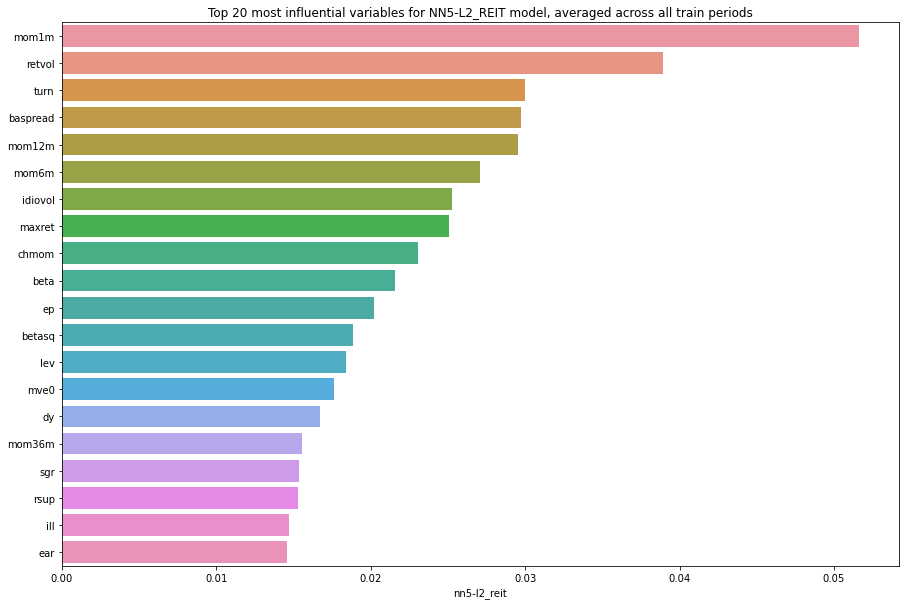

In [50]:
# Plot features of importance
# Plot graph
df_top20 = df_impt.sort_values(by=[model_name], ascending = False).head(20)
plt.figure(figsize=(15,10))
plt.title(f'Top 20 most influential variables for {model_name.upper()} model, averaged across all train periods')
sns.barplot(data = df_top20, x = model_name, y = df_top20.index);

In [51]:
# Merge df_temp to existing df_r2drecrease table

df_r2decrease_reit = pd.merge(
    left = df_r2decrease_reit,
    right = df_impt[model_name],
    how = 'left',
    left_index = True,
    right_index = True    
)

# Rank R2decrease table after including new model results
df_featurerank_reit = df_r2decrease_reit.rank() 
df_featurerank_reit['all_models'] = df_featurerank_reit.sum(axis=1)

# Display tables
display(df_r2decrease_reit)
display(df_featurerank_reit.sort_values('all_models', ascending = False))

# Save dfs to .csv 
df_r2decrease_reit.to_csv('../data/df_r2decrease_reit.csv', index = False)
df_featurerank_reit.to_csv('../data/df_featurerank_reit.csv', index = False)

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
absacc           0.000306   -0.001380    0.000189    0.000000   0.000000   
acc              0.001430   -0.000741    0.001779    0.000000   0.000000   
aeavol           0.000650    0.000668    0.005239    0.001173   0.001226   
age              0.000137   -0.000080    0.001680    0.000018   0.000030   
agr              0.000223    0.005201    0.003357    0.000000   0.000010   
baspread         0.007390    0.007871    0.000149    0.000000   0.000000   
beta             0.008894    0.057075    0.000315    0.000000   0.000000   
betasq           0.013997    0.013039    0.002645    0.000000   0.000000   
bm               0.001241    0.000853    0.024032    0.025538   0.026162   
bm_ia            0.002404    0.004776    0.007611    0.004235   0.004285   
cash             0.000161    0.000505    0.003340    0.000873   0.000927   
cashdebt         0.000128   -0.001187    0.000750    0.000000   0.000000   
cashpr           0.001257    0.002444    0.004893    0.001111   0.001181   
cfp              0.006021    0.006040    0.008196    0.013265   0.013306   
cfp_ia           0.001410    0.004166    0.007417    0.015930   0.015591   
chatoia          0.000082   -0.000040   -0.000983   -0.000089  -0.000097   
chcsho           0.000206   -0.000878    0.005366    0.002707   0.002796   
chempia          0.001031    0.003782   -0.000006    0.000000   0.000000   
chinv            0.000245   -0.000393    0.000482    0.000000   0.000000   
chmom            0.052654    0.050540    0.096469    0.142593   0.139152   
chpmia           0.002182    0.002565    0.011188    0.005567   0.005818   
chtx            -0.000017   -0.000019    0.000188    0.000000   0.000000   
cinvest          0.000038    0.000148    0.000281    0.000000   0.000000   
convind          0.000886    0.000794    0.000866    0.000000   0.000000   
currat           0.091179    0.044869   -0.000742    0.000000   0.000000   
depr            -0.000063    0.000391    0.001464    0.000148   0.000158   
divi             0.000153    0.000328    0.000156    0.000000   0.000000   
divo             0.000145    0.000922    0.000460    0.000000   0.000000   
dolvol           0.052843    0.089712    0.018587    0.017184   0.017007   
dy               0.016294    0.015071    0.090116    0.083019   0.084596   
ear              0.000198    0.000341    0.007511    0.004939   0.005175   
egr              0.001280    0.002940    0.004116    0.001198   0.001247   
ep               0.001748    0.010111    0.008772    0.004712   0.004875   
gma              0.003155   -0.001219    0.004361    0.000000   0.000000   
grcapx           0.000474    0.000658   -0.000177    0.000000   0.000000   
grltnoa          0.002414    0.001948    0.004432    0.000000   0.000000   
herf             0.023766    0.022687    0.023490    0.026236   0.026005   
hire             0.000198    0.002251    0.000338    0.000000   0.000000   
idiovol          0.000873   -0.000939    0.012297    0.014589   0.014951   
ill              0.005484    0.010939    0.022225    0.013264   0.013836   
indmom          -0.000049    0.000309    0.000357    0.000269   0.000290   
invest           0.000890    0.000858    0.002343    0.000000   0.000000   
lev             -0.000274   -0.002811   -0.002411    0.000000   0.000000   
lgr              0.000145    0.000304    0.000079    0.000000   0.000000   
maxret           0.025620    0.054758    0.005975    0.000000   0.000000   
mom12m           0.004666    0.002331    0.047325    0.017174   0.020037   
mom1m            0.019050    0.030089    0.134880    0.123642   0.127685   
mom36m           0.004236    0.006796    0.023669    0.021621   0.022049   
mom6m            0.056381    0.030482    0.053236    0.127055   0.120789   
ms               0.000196    0.000743    0.002229    0.000000   0.000000   
mve0             0.200379    0.212738    0.122775    0.137827   0.135776   
mve_ia           0.116817    0.152169    0.033515    0.073484   0.

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
mom1m               84.0        84.0        94.0        91.0       92.0   
mom12m              74.0        60.0        88.0        82.0       83.0   
chmom               87.0        89.0        92.0        94.0       94.0   
retvol              93.0        86.0        90.0        87.0       87.0   
mom6m               89.0        85.0        89.0        92.0       91.0   
mve0                94.0        94.0        93.0        93.0       93.0   
dy                  83.0        82.0        91.0        90.0       90.0   
sgr                 79.0        76.0        87.0        88.0       88.0   
mom36m              72.0        72.0        84.0        84.0       84.0   
ill                 75.0        78.0        82.0        78.0       79.0   
herf                85.0        83.0        83.0        86.0       85.0   
maxret              86.0        90.0        68.0        26.0       25.5   
bm                  54.0        47.0        85.0        85.0       86.0   
dolvol              88.0        92.0        81.0        83.0       82.0   
ep                  63.0        77.0        76.0        73.0       73.0   
idiovol             48.0         7.0        80.0        80.0       80.0   
cfp                 76.0        71.0        75.0        79.0       78.0   
cfp_ia              57.0        67.0        71.0        81.0       81.0   
bm_ia               68.0        69.0        73.0        72.0       72.0   
chpmia              67.0        62.0        79.0        75.0       75.0   
tang                61.0        54.0        77.0        66.0       67.0   
ear                 29.0        33.0        72.0        74.0       74.0   
pchdepr             43.0        35.0        57.0        67.0       66.0   
sp                  59.0        75.0        66.0        76.0       76.0   
turn                77.0        79.0        40.0        62.0       62.0   
rd_sale             73.0        74.0        74.0        77.0       77.0   
roavol              65.0        68.0        67.0        68.0       68.0   
mve_ia              92.0        93.0        86.0        89.0       89.0   
betasq              81.0        80.0        49.0        26.0       25.5   
beta                80.0        91.0        26.0        26.0       25.5   
baspread            78.0        73.0        18.0        26.0       25.5   
saleinv             66.0        55.0        78.0        69.0       69.0   
cash                25.0        39.0        54.0        61.0       61.0   
roic                47.0         6.0        70.0        70.0       70.0   
std_dolvol          39.0        53.0        63.0        59.0       59.0   
invest              50.0        48.0        46.0        26.0       25.5   
pchsale_pchinvt     27.0        28.0        51.0        52.0       51.0   
roaq                62.0        65.0        69.0        26.0       25.5   
stdacc              60.0        64.0        15.0        26.0       25.5   
chtx                 9.0        24.0        20.0        26.0       25.5   
pchgm_pchsale       32.0        20.0        61.0        58.0       58.0   
zerotrade           82.0        57.0        50.0        53.0       52.0   
egr                 56.0        63.0        58.0        65.0       65.0   
aeavol              46.0        43.0        64.0        64.0       64.0   
agr                 35.0        70.0        55.0        26.0       48.0   
rsup                51.0        14.0        48.0        55.0       55.0   
chinv               36.0        12.0        34.0        26.0       25.5   
grltnoa             69.0        56.0        60.0        26.0       25.5   
gma                 71.0         4.0        59.0        26.0       25.5   
rd_mve               8.0        44.0        47.0        50.0       53.0   
stdcf               70.0        81.0         9.0        26.0       25.5   
indmom               7.0        31.0        28.0        57.0       57.0   
cashpr              55.0        61.0      

## NN7 (L2 penalty)

### REIT

In [12]:
df_results_reit = df_results_reit[:16]

In [13]:
# Create list of configs to test on 
def model_configs():
    # define scope of configs
    n_penalty_type = [l2]
    n_penalty_amount = np.logspace(-5, -3, 5)
    n_learning_rate = [0.001, 0.01]
    # create configs
    configs = []
    for i in n_penalty_type:
        for j in n_penalty_amount:
            for k in n_learning_rate:
                cfg = [i,j,k]
                configs.append(cfg)
    print('Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): %d' %len(configs))
    return configs

def model_fit(X_train, X_validate, y_train, y_validate, cfg):
    # unpack config
    n_penalty_type, n_penalty_amount, n_learning_rate = cfg
    
    # Instantiate a Sequential model
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(64, activation = 'relu', 
                    input_dim = X_train.shape[1], 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())
    
    # Add an input layer #2
    model.add(Dense(48, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #3
    model.add(Dense(32, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #4
    model.add(Dense(16, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #5
    model.add(Dense(8, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())    

    # Add an input layer #6
    model.add(Dense(4, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())    
    
    # Add an input layer #7
    model.add(Dense(2, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())    
        
    # Add an output layer
    model.add(Dense(1, activation = None, 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Set learning rate
    opt = Adam(learning_rate = n_learning_rate)
    
    # Compile model
    model.compile(loss = 'mse',optimizer = opt)

    # Early stop
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5
    )    
    
    # Convert to np.array before calling model.fit()
    #  to speed up calculations
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)    
    X_validate = np.asarray(X_validate)
    y_validate = np.asarray(y_validate) 
    
    # Fit model
    model.fit(X_train, y_train,
              validation_data = (X_validate, y_validate),
              epochs = 500,
              batch_size = 2 ** 13,
              callbacks = [early_stop]
             )
   
    return model

In [14]:
# Instantiate list of configurations
cfg_list = model_configs()

Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): 10


In [15]:
%%time
# Create model name 
model_name = 'nn7-l2_reit'

# Create new row of test results
df_results_reit = pd.concat(
    [df_results_reit, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_reit
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

2021-11-07 16:09:53.207140: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 16:09:53.207401: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 6. Tune using inter_op_parallelism_threads for best performance.


Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 193us/sample - loss: 111.3185 - val_loss: 105.1758
Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 109.8880 - val_loss: 105.1221
Epoch 3/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.9706 - val_loss: 105.0542
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.2001 - val_loss: 104.9739
Epoch 5/500
21360/21360 [==============================] - 0s 12us/sample - loss: 107.5134 - val_loss: 104.8959
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 106.9009 - val_loss: 104.8158
Epoch 7/500
21360/21360 [==============================] - 0s 12us/sample - loss: 106.3443 - val_loss: 104.7393
Epoch 8/500
21360/21360 [==============================] - 0s 12us/sample - loss: 105.9052 - val_loss: 104.6673
Epoch 9/500
21360/21360 [============================

Epoch 70/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.8598 - val_loss: 103.2365
Epoch 71/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.7882 - val_loss: 103.2357
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 1.89, 10.16, 2.06, 10.34
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 183us/sample - loss: 112.3365 - val_loss: 106.3294
Epoch 2/500
21360/21360 [==============================] - 0s 10us/sample - loss: 110.5430 - val_loss: 106.0834
Epoch 3/500
21360/21360 [==============================] - 0s 10us/sample - loss: 109.3722 - val_loss: 105.8573
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.4376 - val_loss: 105.6592
Epoch 5/500
21360/21360 [==============================] - 0s 10us/sample - loss: 107.5979 - val_loss: 105.4798
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 106.9224 

Epoch 23/500
21360/21360 [==============================] - 0s 11us/sample - loss: 77.4723 - val_loss: 103.3028
Epoch 24/500
21360/21360 [==============================] - 0s 11us/sample - loss: 76.2912 - val_loss: 103.3932
Epoch 25/500
21360/21360 [==============================] - 0s 11us/sample - loss: 74.6940 - val_loss: 103.1250
Epoch 26/500
21360/21360 [==============================] - 0s 11us/sample - loss: 73.9994 - val_loss: 102.9812
Epoch 27/500
21360/21360 [==============================] - 0s 11us/sample - loss: 73.1564 - val_loss: 102.8374
Epoch 28/500
21360/21360 [==============================] - 0s 11us/sample - loss: 71.6984 - val_loss: 103.0335
Epoch 29/500
21360/21360 [==============================] - 0s 12us/sample - loss: 69.9034 - val_loss: 103.1759
Epoch 30/500
21360/21360 [==============================] - 0s 11us/sample - loss: 69.4484 - val_loss: 103.2193
Epoch 31/500
21360/21360 [==============================] - 0s 11us/sample - loss: 68.2473 - val_loss: 1

Epoch 32/500
21360/21360 [==============================] - 0s 11us/sample - loss: 94.9422 - val_loss: 104.5919
Epoch 33/500
21360/21360 [==============================] - 0s 11us/sample - loss: 94.5230 - val_loss: 104.5736
Epoch 34/500
21360/21360 [==============================] - 0s 11us/sample - loss: 94.1704 - val_loss: 104.5425
Epoch 35/500
21360/21360 [==============================] - 0s 11us/sample - loss: 93.8711 - val_loss: 104.5111
Epoch 36/500
21360/21360 [==============================] - 0s 11us/sample - loss: 93.3251 - val_loss: 104.4857
Epoch 37/500
21360/21360 [==============================] - 0s 11us/sample - loss: 93.0483 - val_loss: 104.4654
Epoch 38/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.6994 - val_loss: 104.4566
Epoch 39/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.3463 - val_loss: 104.4320
Epoch 40/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.0607 - val_loss: 1

21360/21360 [==============================] - 0s 11us/sample - loss: 108.8593 - val_loss: 104.7138
Epoch 3/500
21360/21360 [==============================] - 0s 11us/sample - loss: 107.9251 - val_loss: 104.4898
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 107.2696 - val_loss: 104.3048
Epoch 5/500
21360/21360 [==============================] - 0s 12us/sample - loss: 106.5082 - val_loss: 104.0959
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 105.7929 - val_loss: 103.8919
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 104.9049 - val_loss: 103.6514
Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 104.1522 - val_loss: 103.4753
Epoch 9/500
21360/21360 [==============================] - 0s 11us/sample - loss: 103.3664 - val_loss: 103.3426
Epoch 10/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.4468 - val_loss: 103.2648
Epo

Epoch 63/500
21360/21360 [==============================] - 0s 11us/sample - loss: 95.8784 - val_loss: 103.1746
Epoch 64/500
21360/21360 [==============================] - 0s 11us/sample - loss: 95.6111 - val_loss: 103.1713
Epoch 65/500
21360/21360 [==============================] - 0s 11us/sample - loss: 95.4634 - val_loss: 103.1815
Epoch 66/500
21360/21360 [==============================] - 0s 11us/sample - loss: 95.4152 - val_loss: 103.1719
Epoch 67/500
21360/21360 [==============================] - 0s 10us/sample - loss: 95.1662 - val_loss: 103.1692
Epoch 68/500
21360/21360 [==============================] - 0s 11us/sample - loss: 95.0208 - val_loss: 103.1816
Epoch 69/500
21360/21360 [==============================] - 0s 11us/sample - loss: 94.8591 - val_loss: 103.1663
Epoch 70/500
21360/21360 [==============================] - 0s 11us/sample - loss: 94.6687 - val_loss: 103.1776
Epoch 71/500
21360/21360 [==============================] - 0s 10us/sample - loss: 94.5721 - val_loss: 1

Epoch 61/500
21360/21360 [==============================] - 0s 12us/sample - loss: 85.1522 - val_loss: 103.9339
Epoch 62/500
21360/21360 [==============================] - 0s 11us/sample - loss: 84.8113 - val_loss: 103.9439
Epoch 63/500
21360/21360 [==============================] - 0s 10us/sample - loss: 84.5866 - val_loss: 103.9547
Epoch 64/500
21360/21360 [==============================] - 0s 10us/sample - loss: 84.4217 - val_loss: 103.9977
Epoch 65/500
21360/21360 [==============================] - 0s 10us/sample - loss: 83.9884 - val_loss: 103.9908
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 1.19, 10.20, 2.51, 10.31
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 182us/sample - loss: 111.3631 - val_loss: 104.5397
Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 110.0929 - val_loss: 104.6121
Epoch 3/500
21360/21360 [==============================] - 0s 11us/sample - loss: 109.2880

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 189us/sample - loss: 109.9678 - val_loss: 105.2992
Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.9929 - val_loss: 105.2610
Epoch 3/500
21360/21360 [==============================] - 0s 10us/sample - loss: 108.6261 - val_loss: 105.1274
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.3641 - val_loss: 104.9118
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.0637 - val_loss: 104.6727
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 107.7696 - val_loss: 104.4391
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 107.4018 - val_loss: 104.2372
Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 106.8785 - val_loss: 104.0599
Epoch 9/500
21360/21360 [============================

21360/21360 [==============================] - 0s 11us/sample - loss: 103.3243 - val_loss: 104.2114
Epoch 38/500
21360/21360 [==============================] - 0s 11us/sample - loss: 103.1751 - val_loss: 104.2047
Epoch 39/500
21360/21360 [==============================] - 0s 11us/sample - loss: 103.0761 - val_loss: 104.1720
Epoch 40/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.8863 - val_loss: 104.1485
Epoch 41/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.7053 - val_loss: 104.1228
Epoch 42/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.5524 - val_loss: 104.0980
Epoch 43/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.3807 - val_loss: 104.0803
Epoch 44/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.2021 - val_loss: 104.0568
Epoch 45/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.0218 - val_loss: 104.0

21360/21360 [==============================] - 0s 10us/sample - loss: 106.0858 - val_loss: 104.1358
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 105.2080 - val_loss: 104.0593
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 104.1002 - val_loss: 104.0333
Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 102.9276 - val_loss: 104.0003
Epoch 9/500
21360/21360 [==============================] - 0s 10us/sample - loss: 101.6910 - val_loss: 103.9709
Epoch 10/500
21360/21360 [==============================] - 0s 11us/sample - loss: 100.3186 - val_loss: 104.0777
Epoch 11/500
21360/21360 [==============================] - 0s 11us/sample - loss: 99.1473 - val_loss: 104.0563
Epoch 12/500
21360/21360 [==============================] - 0s 11us/sample - loss: 97.8369 - val_loss: 104.1088
Epoch 13/500
21360/21360 [==============================] - 0s 10us/sample - loss: 96.4050 - val_loss: 104.1801
Epo

21360/21360 [==============================] - 0s 11us/sample - loss: 98.2346 - val_loss: 103.8162
Epoch 13/500
21360/21360 [==============================] - 0s 10us/sample - loss: 97.3848 - val_loss: 103.8038
Epoch 14/500
21360/21360 [==============================] - 0s 11us/sample - loss: 96.2846 - val_loss: 103.8350
Epoch 15/500
21360/21360 [==============================] - 0s 11us/sample - loss: 95.2756 - val_loss: 103.8647
Epoch 16/500
21360/21360 [==============================] - 0s 10us/sample - loss: 93.9678 - val_loss: 103.8844
Epoch 17/500
21360/21360 [==============================] - 0s 11us/sample - loss: 93.3280 - val_loss: 103.8880
Epoch 18/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.5010 - val_loss: 103.8808
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 1.36, 10.19, 0.23, 10.43

Ensemble results from Model [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01]: [ 0.81615226 10.21573132  0.39188542 10.42569

Epoch 33/500
21360/21360 [==============================] - 0s 11us/sample - loss: 101.3937 - val_loss: 104.0951
Epoch 34/500
21360/21360 [==============================] - 0s 11us/sample - loss: 101.2028 - val_loss: 104.0606
Epoch 35/500
21360/21360 [==============================] - 0s 11us/sample - loss: 100.9867 - val_loss: 104.0299
Epoch 36/500
21360/21360 [==============================] - 0s 11us/sample - loss: 100.7765 - val_loss: 104.0020
Epoch 37/500
21360/21360 [==============================] - 0s 11us/sample - loss: 100.5558 - val_loss: 103.9704
Epoch 38/500
21360/21360 [==============================] - 0s 11us/sample - loss: 100.3494 - val_loss: 103.9389
Epoch 39/500
21360/21360 [==============================] - 0s 11us/sample - loss: 100.1760 - val_loss: 103.9092
Epoch 40/500
21360/21360 [==============================] - 0s 11us/sample - loss: 99.9463 - val_loss: 103.8779
Epoch 41/500
21360/21360 [==============================] - 0s 11us/sample - loss: 99.7594 - val_

Epoch 25/500
21360/21360 [==============================] - 0s 11us/sample - loss: 92.0647 - val_loss: 103.2097
Epoch 26/500
21360/21360 [==============================] - 0s 15us/sample - loss: 91.4239 - val_loss: 103.1398
Epoch 27/500
21360/21360 [==============================] - 0s 19us/sample - loss: 91.2174 - val_loss: 103.0069
Epoch 28/500
21360/21360 [==============================] - 0s 21us/sample - loss: 90.0219 - val_loss: 103.0513
Epoch 29/500
21360/21360 [==============================] - 0s 11us/sample - loss: 90.1325 - val_loss: 103.0086
Epoch 30/500
21360/21360 [==============================] - 0s 11us/sample - loss: 89.5751 - val_loss: 102.9780
Epoch 31/500
21360/21360 [==============================] - 0s 11us/sample - loss: 89.6807 - val_loss: 103.1174
Epoch 32/500
21360/21360 [==============================] - 0s 15us/sample - loss: 88.3966 - val_loss: 103.3322
Epoch 33/500
21360/21360 [==============================] - 0s 20us/sample - loss: 87.6732 - val_loss: 1

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
13       nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14       nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15       nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
0       1.47 (10.37)         1.89 (10.16)              NaN          NaN   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
14   -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
15   -3.51 (

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 1.89, 10.16, 1.47, 10.37
[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 1.32, 10.19, 1.02, 10.39
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 1.28, 10.19, 0.98, 10.39
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 1.13, 10.20, 0.92, 10.40
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 1.03, 10.20, 0.63, 10.41
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.98, 10.21, 0.97, 10.40
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.82, 10.22, 0.39, 10.43
[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.76, 10.22, 1.86, 10.35
CPU times: user 25min 34s, sys: 15min 13s, total: 40min 47s
Wall time: 10min 26s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 1.89, 10.16, 1.47, 10.37

[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 1.32, 10.19, 1.02, 10.39

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 1.28, 10.19, 0.98, 10.39

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 1.13, 10.20, 0.92, 10.40

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 1.03, 10.20, 0.63, 10.41

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.98, 10.21, 0.97, 10.40

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.82, 10.22, 0.39, 10.43

[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.76, 10.22, 1.86, 10.35

CPU times: user 25min 34s, sys: 15min 13s, total: 40min 47s

Wall time: 10min 26s

In [16]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_reit
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_reit.to_csv('../data/df_results_reit.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 200us/sample - loss: 112.0731 - val_loss: 105.5613
Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 108.5560 - val_loss: 105.3671
Epoch 3/500
21360/21360 [==============================] - 0s 11us/sample - loss: 107.5575 - val_loss: 105.1518
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 106.7365 - val_loss: 104.8603
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 106.1136 - val_loss: 104.5175
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 105.1056 - val_loss: 104.1593
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 104.3392 - val_loss: 103.9536
Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 103.4453 - val_loss: 103.7249
Epoch 9/500
21360/21360 [============================

2021-11-07 16:20:30.086878: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_reit_2006_0/assets
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 189us/sample - loss: 110.3614 - val_loss: 104.9565
Epoch 2/500
21360/21360 [==============================] - 0s 10us/sample - loss: 107.9376 - val_loss: 104.7050
Epoch 3/500
21360/21360 [==============================] - 0s 10us/sample - loss: 106.6654 - val_loss: 104.4792
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 105.6920 - val_loss: 104.3571
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 104.3825 - val_loss: 104.2186
Epoch 6/500
21360/21360 [==============================] - 0s 10us/sample - loss: 103.1814 - val_loss: 104.1073
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 101.7193 - val_loss: 103.9954
Epoch 8/500
2

25480/25480 [==============================] - 0s 10us/sample - loss: 115.0748 - val_loss: 82.0349
Epoch 3/500
25480/25480 [==============================] - 0s 10us/sample - loss: 114.7662 - val_loss: 81.9275
Epoch 4/500
25480/25480 [==============================] - 0s 13us/sample - loss: 114.4990 - val_loss: 81.8437
Epoch 5/500
25480/25480 [==============================] - 0s 12us/sample - loss: 114.1297 - val_loss: 81.7222
Epoch 6/500
25480/25480 [==============================] - 0s 11us/sample - loss: 113.7160 - val_loss: 81.5931
Epoch 7/500
25480/25480 [==============================] - 0s 12us/sample - loss: 113.2711 - val_loss: 81.5027
Epoch 8/500
25480/25480 [==============================] - 0s 12us/sample - loss: 113.0006 - val_loss: 81.4326
Epoch 9/500
25480/25480 [==============================] - 0s 11us/sample - loss: 112.5882 - val_loss: 81.3774
Epoch 10/500
25480/25480 [==============================] - 0s 11us/sample - loss: 112.0942 - val_loss: 81.3193
Epoch 11/500

29523/29523 [==============================] - 0s 11us/sample - loss: 108.7481 - val_loss: 233.4177
Epoch 5/500
29523/29523 [==============================] - 0s 10us/sample - loss: 107.5941 - val_loss: 233.4989
Epoch 6/500
29523/29523 [==============================] - 0s 11us/sample - loss: 106.2610 - val_loss: 233.5287
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_reit_2010_3/assets
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 4s 127us/sample - loss: 112.7329 - val_loss: 233.0987
Epoch 2/500
29523/29523 [==============================] - 0s 9us/sample - loss: 111.4882 - val_loss: 233.1593
Epoch 3/500
29523/29523 [==============================] - 0s 11us/sample - loss: 110.9564 - val_loss: 233.2715
Epoch 4/500
29523/29523 [==============================] - 0s 10us/sample - loss: 110.2403 - val_loss: 233.3770
Epoch 5/500
29523/29523 [==============================] - 0s 10us/sample - loss: 109.3338 - val_loss: 233.

Test year 2011 done, R2 score is -0.32
Test year 2011 done, RMSE score is 10.10
Train on 33962 samples, validate on 9365 samples
Epoch 1/500
33962/33962 [==============================] - 4s 110us/sample - loss: 104.5871 - val_loss: 276.0778
Epoch 2/500
33962/33962 [==============================] - 0s 9us/sample - loss: 104.2287 - val_loss: 276.1043
Epoch 3/500
33962/33962 [==============================] - 0s 9us/sample - loss: 103.9235 - val_loss: 276.1423
Epoch 4/500
33962/33962 [==============================] - 0s 10us/sample - loss: 103.5086 - val_loss: 276.1918
Epoch 5/500
33962/33962 [==============================] - 0s 10us/sample - loss: 103.0441 - val_loss: 276.2881
Epoch 6/500
33962/33962 [==============================] - 0s 9us/sample - loss: 102.4964 - val_loss: 276.4062
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_reit_2012_0/assets
Train on 33962 samples, validate on 9365 samples
Epoch 1/500
33962/33962 [==============================] - 4s 109us/sample - loss

Epoch 11/500
35928/35928 [==============================] - 0s 9us/sample - loss: 99.7263 - val_loss: 267.0670
Epoch 12/500
35928/35928 [==============================] - 0s 9us/sample - loss: 99.5814 - val_loss: 267.0363
Epoch 13/500
35928/35928 [==============================] - 0s 11us/sample - loss: 98.9978 - val_loss: 267.0163
Epoch 14/500
35928/35928 [==============================] - 0s 11us/sample - loss: 98.2559 - val_loss: 266.9597
Epoch 15/500
35928/35928 [==============================] - 0s 10us/sample - loss: 97.2120 - val_loss: 267.0665
Epoch 16/500
35928/35928 [==============================] - 0s 9us/sample - loss: 96.9550 - val_loss: 267.0522
Epoch 17/500
35928/35928 [==============================] - 0s 10us/sample - loss: 96.2087 - val_loss: 266.9005
Epoch 18/500
35928/35928 [==============================] - 0s 11us/sample - loss: 95.1671 - val_loss: 266.9378
Epoch 19/500
35928/35928 [==============================] - 0s 10us/sample - loss: 94.6680 - val_loss: 267.

Epoch 12/500
37784/37784 [==============================] - 0s 10us/sample - loss: 104.1618 - val_loss: 202.3602
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_reit_2014_4/assets
Test year 2014 done, R2 score is 2.06
Test year 2014 done, RMSE score is 6.97
Train on 39556 samples, validate on 10230 samples
Epoch 1/500
39556/39556 [==============================] - 4s 95us/sample - loss: 143.3648 - val_loss: 94.2319
Epoch 2/500
39556/39556 [==============================] - 0s 9us/sample - loss: 142.6400 - val_loss: 94.0097
Epoch 3/500
39556/39556 [==============================] - 0s 10us/sample - loss: 142.2019 - val_loss: 93.8040
Epoch 4/500
39556/39556 [==============================] - 0s 9us/sample - loss: 141.7870 - val_loss: 93.6034
Epoch 5/500
39556/39556 [==============================] - 0s 9us/sample - loss: 141.3021 - val_loss: 93.4054
Epoch 6/500
39556/39556 [==============================] - 0s 9us/sample - loss: 140.6569 - val_loss: 93.2072
Epoch 7/500
39556/39556 [=

Epoch 3/500
41396/41396 [==============================] - 0s 10us/sample - loss: 142.7318 - val_loss: 74.7996
Epoch 4/500
41396/41396 [==============================] - 0s 9us/sample - loss: 142.1480 - val_loss: 74.7767
Epoch 5/500
41396/41396 [==============================] - 0s 9us/sample - loss: 141.8555 - val_loss: 74.7623
Epoch 6/500
41396/41396 [==============================] - 0s 10us/sample - loss: 141.4237 - val_loss: 74.7043
Epoch 7/500
41396/41396 [==============================] - 0s 10us/sample - loss: 141.0680 - val_loss: 74.5843
Epoch 8/500
41396/41396 [==============================] - 0s 10us/sample - loss: 140.6535 - val_loss: 74.5564
Epoch 9/500
41396/41396 [==============================] - 0s 10us/sample - loss: 140.4292 - val_loss: 74.5664
Epoch 10/500
41396/41396 [==============================] - 0s 10us/sample - loss: 140.0539 - val_loss: 74.4945
Epoch 11/500
41396/41396 [==============================] - 0s 10us/sample - loss: 139.8022 - val_loss: 74.5496
E

Epoch 13/500
45304/45304 [==============================] - 0s 9us/sample - loss: 128.4442 - val_loss: 64.8332
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_reit_2018_3/assets
Train on 45304 samples, validate on 11733 samples
Epoch 1/500
45304/45304 [==============================] - 4s 87us/sample - loss: 140.0265 - val_loss: 64.7237
Epoch 2/500
45304/45304 [==============================] - 0s 9us/sample - loss: 138.5310 - val_loss: 64.5321
Epoch 3/500
45304/45304 [==============================] - 0s 10us/sample - loss: 137.7299 - val_loss: 64.4292
Epoch 4/500
45304/45304 [==============================] - 0s 11us/sample - loss: 136.7347 - val_loss: 64.3755
Epoch 5/500
45304/45304 [==============================] - 0s 10us/sample - loss: 135.3179 - val_loss: 64.3393
Epoch 6/500
45304/45304 [==============================] - 0s 10us/sample - loss: 133.4486 - val_loss: 64.2891
Epoch 7/500
45304/45304 [==============================] - 0s 9us/sample - loss: 131.9330 - val_loss: 6

Epoch 3/500
49786/49786 [==============================] - 0s 9us/sample - loss: 131.8633 - val_loss: 64.3755
Epoch 4/500
49786/49786 [==============================] - 0s 9us/sample - loss: 131.3105 - val_loss: 64.2701
Epoch 5/500
49786/49786 [==============================] - 0s 9us/sample - loss: 130.9833 - val_loss: 64.2910
Epoch 6/500
49786/49786 [==============================] - 0s 9us/sample - loss: 130.4956 - val_loss: 64.5065
Epoch 7/500
49786/49786 [==============================] - 0s 9us/sample - loss: 129.9941 - val_loss: 64.6602
Epoch 8/500
49786/49786 [==============================] - 0s 9us/sample - loss: 129.4384 - val_loss: 65.0507
Epoch 9/500
49786/49786 [==============================] - 0s 9us/sample - loss: 129.0743 - val_loss: 65.3552
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_reit_2020_0/assets
Train on 49786 samples, validate on 11932 samples
Epoch 1/500
49786/49786 [==============================] - 4s 77us/sample - loss: 133.7249 - val_loss: 64.533

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
13       nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14       nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15       nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
0       1.47 (10.37)         1.89 (10.16)     0.42 (12.10)  2.09 (7.52)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
14   -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
15   -3.51 (


R2 for entire pooled test set, from 2006 to 2020, is 0.42.
RMSE for entire pooled test set, from 2006 to 2020, is 12.10.

On best performing config: [<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01]
CPU times: user 30min 12s, sys: 10min 54s, total: 41min 7s
Wall time: 15min 15s


R2 for entire pooled test set, from 2006 to 2020, is 0.42.

RMSE for entire pooled test set, from 2006 to 2020, is 12.10.

On best performing config: [<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01]

CPU times: user 30min 12s, sys: 10min 54s, total: 41min 7s

Wall time: 15min 15s

### Sample 1

In [17]:
df_results_sample1 = df_results_sample1[:16]

In [18]:
%%time
# Create model name 
model_name = 'nn7-l2_sample1'

# Create new row of test results
df_results_sample1 = pd.concat(
    [df_results_sample1, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample1
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 173us/sample - loss: 437.5771 - val_loss: 362.3765
Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 435.3148 - val_loss: 362.2051
Epoch 3/500
21360/21360 [==============================] - 0s 11us/sample - loss: 434.0307 - val_loss: 362.0746
Epoch 4/500
21360/21360 [==============================] - 0s 10us/sample - loss: 432.8335 - val_loss: 361.9753
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 431.7367 - val_loss: 361.8801
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 431.0871 - val_loss: 361.7887
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 430.0772 - val_loss: 361.7099
Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 429.1837 - val_loss: 361.6393
Epoch 9/500
21360/21360 [============================

Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 431.5498 - val_loss: 361.1361
Epoch 9/500
21360/21360 [==============================] - 0s 11us/sample - loss: 430.9559 - val_loss: 361.1076
Epoch 10/500
21360/21360 [==============================] - 0s 10us/sample - loss: 430.4456 - val_loss: 361.0770
Epoch 11/500
21360/21360 [==============================] - 0s 10us/sample - loss: 429.8771 - val_loss: 361.0401
Epoch 12/500
21360/21360 [==============================] - 0s 11us/sample - loss: 429.4144 - val_loss: 360.9985
Epoch 13/500
21360/21360 [==============================] - 0s 11us/sample - loss: 428.9146 - val_loss: 360.9541
Epoch 14/500
21360/21360 [==============================] - 0s 10us/sample - loss: 428.4411 - val_loss: 360.9120
Epoch 15/500
21360/21360 [==============================] - 0s 11us/sample - loss: 427.9307 - val_loss: 360.8670
Epoch 16/500
21360/21360 [==============================] - 0s 10us/sample - loss: 427.4330 - val_

21360/21360 [==============================] - 0s 10us/sample - loss: 416.3800 - val_loss: 360.5662
Epoch 75/500
21360/21360 [==============================] - 0s 11us/sample - loss: 415.9519 - val_loss: 360.5411
Epoch 76/500
21360/21360 [==============================] - 0s 10us/sample - loss: 415.6926 - val_loss: 360.5339
Epoch 77/500
21360/21360 [==============================] - 0s 11us/sample - loss: 415.5830 - val_loss: 360.5296
Epoch 78/500
21360/21360 [==============================] - 0s 11us/sample - loss: 415.3592 - val_loss: 360.4824
Epoch 79/500
21360/21360 [==============================] - 0s 11us/sample - loss: 414.9688 - val_loss: 360.4818
Epoch 80/500
21360/21360 [==============================] - 0s 10us/sample - loss: 414.8313 - val_loss: 360.4901
Epoch 81/500
21360/21360 [==============================] - 0s 11us/sample - loss: 414.2053 - val_loss: 360.4648
Epoch 82/500
21360/21360 [==============================] - 0s 12us/sample - loss: 413.9572 - val_loss: 360.4

Epoch 23/500
21360/21360 [==============================] - 0s 11us/sample - loss: 429.4749 - val_loss: 361.0370
Epoch 24/500
21360/21360 [==============================] - 0s 11us/sample - loss: 429.1394 - val_loss: 361.0301
Epoch 25/500
21360/21360 [==============================] - 0s 12us/sample - loss: 428.8132 - val_loss: 361.0237
Epoch 26/500
21360/21360 [==============================] - 0s 12us/sample - loss: 428.4927 - val_loss: 361.0140
Epoch 27/500
21360/21360 [==============================] - 0s 12us/sample - loss: 428.1972 - val_loss: 361.0018
Epoch 28/500
21360/21360 [==============================] - 0s 11us/sample - loss: 427.8357 - val_loss: 360.9849
Epoch 29/500
21360/21360 [==============================] - 0s 11us/sample - loss: 427.4724 - val_loss: 360.9777
Epoch 30/500
21360/21360 [==============================] - 0s 12us/sample - loss: 427.1035 - val_loss: 360.9750
Epoch 31/500
21360/21360 [==============================] - 0s 11us/sample - loss: 426.7685 - va

Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 434.2659 - val_loss: 361.3307
Epoch 3/500
21360/21360 [==============================] - 0s 10us/sample - loss: 432.9755 - val_loss: 361.0612
Epoch 4/500
21360/21360 [==============================] - 0s 11us/sample - loss: 431.5189 - val_loss: 360.8408
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 430.1229 - val_loss: 360.6390
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 428.4969 - val_loss: 360.4159
Epoch 7/500
21360/21360 [==============================] - 0s 11us/sample - loss: 426.6499 - val_loss: 360.2788
Epoch 8/500
21360/21360 [==============================] - 0s 12us/sample - loss: 424.6716 - val_loss: 360.1520
Epoch 9/500
21360/21360 [==============================] - 0s 12us/sample - loss: 422.2805 - val_loss: 360.1066
Epoch 10/500
21360/21360 [==============================] - 0s 11us/sample - loss: 419.9276 - val_loss: 

Epoch 25/500
21360/21360 [==============================] - 0s 11us/sample - loss: 410.4701 - val_loss: 360.6644
Epoch 26/500
21360/21360 [==============================] - 0s 11us/sample - loss: 408.9662 - val_loss: 360.6305
Epoch 27/500
21360/21360 [==============================] - 0s 10us/sample - loss: 407.6385 - val_loss: 360.5955
Epoch 28/500
21360/21360 [==============================] - 0s 10us/sample - loss: 406.3929 - val_loss: 360.5649
Epoch 29/500
21360/21360 [==============================] - 0s 12us/sample - loss: 405.1265 - val_loss: 360.5427
Epoch 30/500
21360/21360 [==============================] - 0s 10us/sample - loss: 403.9219 - val_loss: 360.5126
Epoch 31/500
21360/21360 [==============================] - 0s 12us/sample - loss: 403.0962 - val_loss: 360.4792
Epoch 32/500
21360/21360 [==============================] - 0s 12us/sample - loss: 402.1864 - val_loss: 360.4494
Epoch 33/500
21360/21360 [==============================] - 0s 12us/sample - loss: 401.7485 - va

21360/21360 [==============================] - 0s 11us/sample - loss: 399.7719 - val_loss: 360.4990
Epoch 44/500
21360/21360 [==============================] - 0s 11us/sample - loss: 398.8754 - val_loss: 360.4832
Epoch 45/500
21360/21360 [==============================] - 0s 11us/sample - loss: 399.0393 - val_loss: 360.4590
Epoch 46/500
21360/21360 [==============================] - 0s 11us/sample - loss: 397.9361 - val_loss: 360.4524
Epoch 47/500
21360/21360 [==============================] - 0s 11us/sample - loss: 397.4238 - val_loss: 360.4421
Epoch 48/500
21360/21360 [==============================] - 0s 11us/sample - loss: 396.7355 - val_loss: 360.4115
Epoch 49/500
21360/21360 [==============================] - 0s 15us/sample - loss: 396.1753 - val_loss: 360.3893
Epoch 50/500
21360/21360 [==============================] - 0s 23us/sample - loss: 395.7274 - val_loss: 360.3775
Epoch 51/500
21360/21360 [==============================] - 0s 15us/sample - loss: 395.8454 - val_loss: 360.3

21360/21360 [==============================] - 0s 11us/sample - loss: 411.8110 - val_loss: 360.0464
Epoch 49/500
21360/21360 [==============================] - 0s 10us/sample - loss: 411.2788 - val_loss: 360.0595
Epoch 50/500
21360/21360 [==============================] - 0s 10us/sample - loss: 410.9478 - val_loss: 360.0633
Epoch 51/500
21360/21360 [==============================] - 0s 11us/sample - loss: 410.4037 - val_loss: 360.0695
Epoch 52/500
21360/21360 [==============================] - 0s 10us/sample - loss: 410.0139 - val_loss: 360.0761
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.33, 18.98, 0.95, 20.78

Ensemble results from Model [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]: [ 0.31481266 18.97691803  1.30591845 20.74060373]
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 174us/sample - loss: 436.1177 - val_loss: 361.0624
Epoch 2/500
21360/21360 [==============================] - 0s 10us/sample - loss:

21360/21360 [==============================] - 0s 10us/sample - loss: 416.7093 - val_loss: 360.2234
Epoch 32/500
21360/21360 [==============================] - 0s 11us/sample - loss: 416.3191 - val_loss: 360.2102
Epoch 33/500
21360/21360 [==============================] - 0s 10us/sample - loss: 415.7765 - val_loss: 360.1909
Epoch 34/500
21360/21360 [==============================] - 0s 10us/sample - loss: 415.4006 - val_loss: 360.1652
Epoch 35/500
21360/21360 [==============================] - 0s 11us/sample - loss: 414.8513 - val_loss: 360.1500
Epoch 36/500
21360/21360 [==============================] - 0s 11us/sample - loss: 414.4363 - val_loss: 360.1320
Epoch 37/500
21360/21360 [==============================] - 0s 10us/sample - loss: 413.9994 - val_loss: 360.1215
Epoch 38/500
21360/21360 [==============================] - 0s 11us/sample - loss: 413.6104 - val_loss: 360.1156
Epoch 39/500
21360/21360 [==============================] - 0s 10us/sample - loss: 413.2443 - val_loss: 360.1

21360/21360 [==============================] - 0s 11us/sample - loss: 403.7806 - val_loss: 360.5003
Epoch 32/500
21360/21360 [==============================] - 0s 10us/sample - loss: 403.1208 - val_loss: 360.4778
Epoch 33/500
21360/21360 [==============================] - 0s 11us/sample - loss: 402.1098 - val_loss: 360.4543
Epoch 34/500
21360/21360 [==============================] - 0s 10us/sample - loss: 401.2487 - val_loss: 360.4390
Epoch 35/500
21360/21360 [==============================] - 0s 10us/sample - loss: 400.7108 - val_loss: 360.4273
Epoch 36/500
21360/21360 [==============================] - 0s 10us/sample - loss: 399.6079 - val_loss: 360.4018
Epoch 37/500
21360/21360 [==============================] - 0s 10us/sample - loss: 398.7558 - val_loss: 360.3677
Epoch 38/500
21360/21360 [==============================] - 0s 10us/sample - loss: 397.8180 - val_loss: 360.3547
Epoch 39/500
21360/21360 [==============================] - 0s 10us/sample - loss: 397.9257 - val_loss: 360.3

Epoch 4/500
21360/21360 [==============================] - 0s 10us/sample - loss: 428.2510 - val_loss: 360.6708
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 425.6093 - val_loss: 360.6098
Epoch 6/500
21360/21360 [==============================] - 0s 10us/sample - loss: 422.5456 - val_loss: 360.5947
Epoch 7/500
21360/21360 [==============================] - 0s 10us/sample - loss: 419.5504 - val_loss: 360.5975
Epoch 8/500
21360/21360 [==============================] - 0s 11us/sample - loss: 415.4738 - val_loss: 360.5374
Epoch 9/500
21360/21360 [==============================] - 0s 11us/sample - loss: 411.8416 - val_loss: 360.4531
Epoch 10/500
21360/21360 [==============================] - 0s 11us/sample - loss: 408.6965 - val_loss: 360.3974
Epoch 11/500
21360/21360 [==============================] - 0s 11us/sample - loss: 403.1205 - val_loss: 360.3449
Epoch 12/500
21360/21360 [==============================] - 0s 12us/sample - loss: 400.4211 - val_loss

21360/21360 [==============================] - 0s 13us/sample - loss: 429.6186 - val_loss: 361.3813
[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.02, 19.00, 0.08, 20.87

Ensemble results from Model [<function l2 at 0x7fbd6a463050>, 0.001, 0.001]: [ 0.04821093 19.00227677  0.10170485 20.86677385]
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 180us/sample - loss: 436.8785 - val_loss: 361.2956
Epoch 2/500
21360/21360 [==============================] - 0s 11us/sample - loss: 434.3964 - val_loss: 361.1305
Epoch 3/500
21360/21360 [==============================] - 0s 12us/sample - loss: 433.0214 - val_loss: 360.9787
Epoch 4/500
21360/21360 [==============================] - 0s 13us/sample - loss: 431.5083 - val_loss: 360.8366
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 429.9924 - val_loss: 360.7080
Epoch 6/500
21360/21360 [==============================] - 0s 12us/sample - loss: 428.4

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
13      nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
14       nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
15       nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
13      2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
14      1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
15      0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   
0       1.31 (20.74)         0.31 (18.98)              NaN            NaN   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
13  -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
14  -0

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.31, 18.98, 1.31, 20.74
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.23, 18.99, 0.38, 20.84
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.20, 18.99, 0.55, 20.82
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.14, 18.99, 0.90, 20.78
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.13, 18.99, 0.42, 20.83
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.13, 18.99, 0.40, 20.84
[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 0.10, 19.00, 0.74, 20.80
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 0.07, 19.00, 0.71, 20.80
CPU times: user 25min 23s, sys: 15min 2s, total: 40min 25s
Wall time: 10min 28s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.31, 18.98, 1.31, 20.74

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.23, 18.99, 0.38, 20.84

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.20, 18.99, 0.55, 20.82

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.14, 18.99, 0.90, 20.78

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.13, 18.99, 0.42, 20.83

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.13, 18.99, 0.40, 20.84

[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 0.10, 19.00, 0.74, 20.80

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 0.07, 19.00, 0.71, 20.80

CPU times: user 25min 23s, sys: 15min 2s, total: 40min 25s

Wall time: 10min 28s

In [19]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample1
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample1.to_csv('../data/df_results_sample1.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 169us/sample - loss: 437.3574 - val_loss: 361.3067
Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample - loss: 434.5144 - val_loss: 361.2684
Epoch 3/500
21360/21360 [==============================] - 0s 12us/sample - loss: 432.9457 - val_loss: 361.2376
Epoch 4/500
21360/21360 [==============================] - 0s 12us/sample - loss: 431.4793 - val_loss: 361.2054
Epoch 5/500
21360/21360 [==============================] - 0s 11us/sample - loss: 430.3942 - val_loss: 361.1633
Epoch 6/500
21360/21360 [==============================] - 0s 11us/sample - loss: 429.2766 - val_loss: 361.1339
Epoch 7/500
21360/21360 [==============================] - 0s 12us/sample - loss: 428.2766 - val_loss: 361.1132
Epoch 8/500
21360/21360 [==============================] - 0s 12us/sample - loss: 427.2836 - val_loss: 361.0996
Epoch 9/500
21360/21360 [============================

Epoch 32/500
21360/21360 [==============================] - 0s 11us/sample - loss: 414.7909 - val_loss: 360.6004
Epoch 33/500
21360/21360 [==============================] - 0s 10us/sample - loss: 413.8922 - val_loss: 360.5798
Epoch 34/500
21360/21360 [==============================] - 0s 10us/sample - loss: 413.2126 - val_loss: 360.5606
Epoch 35/500
21360/21360 [==============================] - 0s 10us/sample - loss: 412.7119 - val_loss: 360.5455
Epoch 36/500
21360/21360 [==============================] - 0s 11us/sample - loss: 412.1736 - val_loss: 360.5350
Epoch 37/500
21360/21360 [==============================] - 0s 10us/sample - loss: 411.8462 - val_loss: 360.5095
Epoch 38/500
21360/21360 [==============================] - 0s 10us/sample - loss: 411.0019 - val_loss: 360.4845
Epoch 39/500
21360/21360 [==============================] - 0s 10us/sample - loss: 410.3129 - val_loss: 360.4672
Epoch 40/500
21360/21360 [==============================] - 0s 10us/sample - loss: 409.7912 - va

23469/23469 [==============================] - 4s 157us/sample - loss: 464.8549 - val_loss: 251.5040
Epoch 2/500
23469/23469 [==============================] - 0s 10us/sample - loss: 464.2873 - val_loss: 251.4826
Epoch 3/500
23469/23469 [==============================] - 0s 10us/sample - loss: 463.9538 - val_loss: 251.4636
Epoch 4/500
23469/23469 [==============================] - 0s 11us/sample - loss: 463.6774 - val_loss: 251.4461
Epoch 5/500
23469/23469 [==============================] - 0s 11us/sample - loss: 463.4157 - val_loss: 251.4287
Epoch 6/500
23469/23469 [==============================] - 0s 12us/sample - loss: 463.1830 - val_loss: 251.4116
Epoch 7/500
23469/23469 [==============================] - 0s 10us/sample - loss: 462.9605 - val_loss: 251.3942
Epoch 8/500
23469/23469 [==============================] - 0s 11us/sample - loss: 462.7328 - val_loss: 251.3765
Epoch 9/500
23469/23469 [==============================] - 0s 10us/sample - loss: 462.5003 - val_loss: 251.3591
Epo

Epoch 21/500
25480/25480 [==============================] - 0s 11us/sample - loss: 452.0070 - val_loss: 184.5555
Epoch 22/500
25480/25480 [==============================] - 0s 10us/sample - loss: 451.5063 - val_loss: 184.5127
Epoch 23/500
25480/25480 [==============================] - 0s 10us/sample - loss: 450.9666 - val_loss: 184.4797
Epoch 24/500
25480/25480 [==============================] - 0s 10us/sample - loss: 450.2397 - val_loss: 184.4651
Epoch 25/500
25480/25480 [==============================] - 0s 10us/sample - loss: 449.6404 - val_loss: 184.4619
Epoch 26/500
25480/25480 [==============================] - 0s 10us/sample - loss: 449.1758 - val_loss: 184.4439
Epoch 27/500
25480/25480 [==============================] - 0s 10us/sample - loss: 448.6153 - val_loss: 184.4320
Epoch 28/500
25480/25480 [==============================] - 0s 10us/sample - loss: 447.9993 - val_loss: 184.4115
Epoch 29/500
25480/25480 [==============================] - 0s 11us/sample - loss: 447.3996 - va

Epoch 18/500
27460/27460 [==============================] - 0s 12us/sample - loss: 434.1110 - val_loss: 205.4636
Epoch 19/500
27460/27460 [==============================] - 0s 10us/sample - loss: 433.0807 - val_loss: 205.4630
Epoch 20/500
27460/27460 [==============================] - 0s 10us/sample - loss: 432.0707 - val_loss: 205.4633
Epoch 21/500
27460/27460 [==============================] - 0s 10us/sample - loss: 430.9141 - val_loss: 205.4645
Epoch 22/500
27460/27460 [==============================] - 0s 11us/sample - loss: 429.6931 - val_loss: 205.4652
Epoch 23/500
27460/27460 [==============================] - 0s 11us/sample - loss: 428.2996 - val_loss: 205.4665
Epoch 24/500
27460/27460 [==============================] - 0s 11us/sample - loss: 427.3066 - val_loss: 205.4672
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2009_0/assets
Train on 27460 samples, validate on 10324 samples
Epoch 1/500
27460/27460 [==============================] - 4s 138us/sample - loss: 45

Test year 2009 done, R2 score is -0.05
Test year 2009 done, RMSE score is 24.51
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 4s 123us/sample - loss: 433.5300 - val_loss: 288.1379
Epoch 2/500
29523/29523 [==============================] - 0s 9us/sample - loss: 431.7342 - val_loss: 288.1402
Epoch 3/500
29523/29523 [==============================] - 0s 10us/sample - loss: 430.5986 - val_loss: 288.1394
Epoch 4/500
29523/29523 [==============================] - 0s 10us/sample - loss: 429.8356 - val_loss: 288.1387
Epoch 5/500
29523/29523 [==============================] - 0s 10us/sample - loss: 428.9993 - val_loss: 288.1417
Epoch 6/500
29523/29523 [==============================] - 0s 10us/sample - loss: 428.3143 - val_loss: 288.1469
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2010_0/assets
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 4s 126us/sample

33962/33962 [==============================] - 4s 108us/sample - loss: 402.0640 - val_loss: 310.4152
Epoch 2/500
33962/33962 [==============================] - 0s 9us/sample - loss: 398.9363 - val_loss: 310.4361
Epoch 3/500
33962/33962 [==============================] - 0s 10us/sample - loss: 397.1933 - val_loss: 310.4485
Epoch 4/500
33962/33962 [==============================] - 0s 9us/sample - loss: 395.8442 - val_loss: 310.4709
Epoch 5/500
33962/33962 [==============================] - 0s 10us/sample - loss: 394.6848 - val_loss: 310.5142
Epoch 6/500
33962/33962 [==============================] - 0s 10us/sample - loss: 393.7339 - val_loss: 310.5737
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2012_2/assets
Train on 33962 samples, validate on 9365 samples
Epoch 1/500
33962/33962 [==============================] - 4s 109us/sample - loss: 399.3359 - val_loss: 310.6189
Epoch 2/500
33962/33962 [==============================] - 0s 9us/sample - loss: 397.6910 - val_loss: 310

35928/35928 [==============================] - 0s 10us/sample - loss: 380.8932 - val_loss: 313.4177
Epoch 5/500
35928/35928 [==============================] - 0s 11us/sample - loss: 379.5674 - val_loss: 313.4178
Epoch 6/500
35928/35928 [==============================] - 0s 9us/sample - loss: 378.3136 - val_loss: 313.4149
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2013_3/assets
Train on 35928 samples, validate on 9376 samples
Epoch 1/500
35928/35928 [==============================] - 4s 106us/sample - loss: 386.0302 - val_loss: 313.7123
Epoch 2/500
35928/35928 [==============================] - 0s 9us/sample - loss: 384.4573 - val_loss: 313.6376
Epoch 3/500
35928/35928 [==============================] - 0s 10us/sample - loss: 383.5603 - val_loss: 313.5582
Epoch 4/500
35928/35928 [==============================] - 0s 10us/sample - loss: 382.8362 - val_loss: 313.4925
Epoch 5/500
35928/35928 [==============================] - 0s 10us/sample - loss: 382.1937 - val_loss: 313

37784/37784 [==============================] - 0s 11us/sample - loss: 359.3868 - val_loss: 257.4883
Epoch 54/500
37784/37784 [==============================] - 0s 11us/sample - loss: 358.8776 - val_loss: 257.4899
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2014_0/assets
Train on 37784 samples, validate on 9669 samples
Epoch 1/500
37784/37784 [==============================] - 4s 112us/sample - loss: 386.3087 - val_loss: 259.5446
Epoch 2/500
37784/37784 [==============================] - 0s 11us/sample - loss: 384.6541 - val_loss: 259.6160
Epoch 3/500
37784/37784 [==============================] - 0s 13us/sample - loss: 383.5863 - val_loss: 259.6704
Epoch 4/500
37784/37784 [==============================] - 0s 12us/sample - loss: 382.5909 - val_loss: 259.7107
Epoch 5/500
37784/37784 [==============================] - 1s 13us/sample - loss: 381.7207 - val_loss: 259.7421
Epoch 6/500
37784/37784 [==============================] - 0s 12us/sample - loss: 380.7251 - val_loss: 

Epoch 7/500
39556/39556 [==============================] - 0s 9us/sample - loss: 389.9492 - val_loss: 170.6796
Epoch 8/500
39556/39556 [==============================] - 0s 9us/sample - loss: 389.2427 - val_loss: 170.6590
Epoch 9/500
39556/39556 [==============================] - 0s 9us/sample - loss: 388.5676 - val_loss: 170.6435
Epoch 10/500
39556/39556 [==============================] - 0s 10us/sample - loss: 387.9213 - val_loss: 170.6271
Epoch 11/500
39556/39556 [==============================] - 0s 9us/sample - loss: 387.3229 - val_loss: 170.6094
Epoch 12/500
39556/39556 [==============================] - 0s 9us/sample - loss: 386.6837 - val_loss: 170.5855
Epoch 13/500
39556/39556 [==============================] - 0s 9us/sample - loss: 386.1445 - val_loss: 170.5726
Epoch 14/500
39556/39556 [==============================] - 0s 10us/sample - loss: 385.5471 - val_loss: 170.5389
Epoch 15/500
39556/39556 [==============================] - 0s 9us/sample - loss: 384.9284 - val_loss: 17

Epoch 41/500
39556/39556 [==============================] - 0s 11us/sample - loss: 349.8212 - val_loss: 169.7188
Epoch 42/500
39556/39556 [==============================] - 0s 10us/sample - loss: 349.3808 - val_loss: 169.7026
Epoch 43/500
39556/39556 [==============================] - 0s 10us/sample - loss: 348.2389 - val_loss: 169.6405
Epoch 44/500
39556/39556 [==============================] - 0s 10us/sample - loss: 347.6041 - val_loss: 169.6346
Epoch 45/500
39556/39556 [==============================] - 0s 10us/sample - loss: 346.7583 - val_loss: 169.5643
Epoch 46/500
39556/39556 [==============================] - 0s 10us/sample - loss: 346.2128 - val_loss: 169.5838
Epoch 47/500
39556/39556 [==============================] - 0s 9us/sample - loss: 345.3534 - val_loss: 169.6443
Epoch 48/500
39556/39556 [==============================] - 0s 10us/sample - loss: 344.7153 - val_loss: 169.5695
Epoch 49/500
39556/39556 [==============================] - 0s 9us/sample - loss: 343.6739 - val_

Epoch 5/500
41396/41396 [==============================] - 0s 10us/sample - loss: 385.3266 - val_loss: 166.4013
Epoch 6/500
41396/41396 [==============================] - 0s 10us/sample - loss: 384.6230 - val_loss: 166.4047
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2016_0/assets
Train on 41396 samples, validate on 10863 samples
Epoch 1/500
41396/41396 [==============================] - 4s 93us/sample - loss: 389.8219 - val_loss: 166.5929
Epoch 2/500
41396/41396 [==============================] - 0s 9us/sample - loss: 387.8582 - val_loss: 166.4429
Epoch 3/500
41396/41396 [==============================] - 0s 11us/sample - loss: 386.8551 - val_loss: 166.3403
Epoch 4/500
41396/41396 [==============================] - 0s 10us/sample - loss: 386.1786 - val_loss: 166.2343
Epoch 5/500
41396/41396 [==============================] - 0s 10us/sample - loss: 385.5101 - val_loss: 166.1524
Epoch 6/500
41396/41396 [==============================] - 0s 9us/sample - loss: 384.9008 - v

43327/43327 [==============================] - 0s 9us/sample - loss: 373.6385 - val_loss: 180.5982
Epoch 10/500
43327/43327 [==============================] - 0s 9us/sample - loss: 372.9414 - val_loss: 180.5562
Epoch 11/500
43327/43327 [==============================] - 0s 9us/sample - loss: 372.1720 - val_loss: 180.5115
Epoch 12/500
43327/43327 [==============================] - 0s 10us/sample - loss: 371.3450 - val_loss: 180.4741
Epoch 13/500
43327/43327 [==============================] - 0s 9us/sample - loss: 370.5972 - val_loss: 180.4286
Epoch 14/500
43327/43327 [==============================] - 0s 9us/sample - loss: 369.8429 - val_loss: 180.3915
Epoch 15/500
43327/43327 [==============================] - 0s 10us/sample - loss: 369.0180 - val_loss: 180.3599
Epoch 16/500
43327/43327 [==============================] - 0s 10us/sample - loss: 368.2833 - val_loss: 180.3384
Epoch 17/500
43327/43327 [==============================] - 0s 9us/sample - loss: 367.5655 - val_loss: 180.3258
Ep

Epoch 8/500
43327/43327 [==============================] - 0s 9us/sample - loss: 374.7547 - val_loss: 181.0221
Epoch 9/500
43327/43327 [==============================] - 0s 9us/sample - loss: 374.0556 - val_loss: 181.0103
Epoch 10/500
43327/43327 [==============================] - 0s 9us/sample - loss: 373.3926 - val_loss: 181.0061
Epoch 11/500
43327/43327 [==============================] - 0s 9us/sample - loss: 372.6160 - val_loss: 181.0009
Epoch 12/500
43327/43327 [==============================] - 0s 10us/sample - loss: 371.8962 - val_loss: 180.9796
Epoch 13/500
43327/43327 [==============================] - 0s 10us/sample - loss: 371.1581 - val_loss: 180.9629
Epoch 14/500
43327/43327 [==============================] - 0s 9us/sample - loss: 370.4442 - val_loss: 180.9430
Epoch 15/500
43327/43327 [==============================] - 0s 9us/sample - loss: 369.7099 - val_loss: 180.9200
Epoch 16/500
43327/43327 [==============================] - 0s 9us/sample - loss: 369.0119 - val_loss: 1

45304/45304 [==============================] - 0s 9us/sample - loss: 364.0387 - val_loss: 179.5683
Epoch 10/500
45304/45304 [==============================] - 0s 9us/sample - loss: 363.2932 - val_loss: 179.5450
Epoch 11/500
45304/45304 [==============================] - 0s 9us/sample - loss: 362.6925 - val_loss: 179.5297
Epoch 12/500
45304/45304 [==============================] - 0s 9us/sample - loss: 362.0209 - val_loss: 179.5206
Epoch 13/500
45304/45304 [==============================] - 0s 9us/sample - loss: 361.3826 - val_loss: 179.4842
Epoch 14/500
45304/45304 [==============================] - 0s 9us/sample - loss: 360.7048 - val_loss: 179.4888
Epoch 15/500
45304/45304 [==============================] - 0s 10us/sample - loss: 359.9167 - val_loss: 179.5250
Epoch 16/500
45304/45304 [==============================] - 0s 9us/sample - loss: 359.2931 - val_loss: 179.5693
Epoch 17/500
45304/45304 [==============================] - 0s 10us/sample - loss: 358.6958 - val_loss: 179.5689
Epo

Epoch 22/500
45304/45304 [==============================] - 0s 9us/sample - loss: 351.0196 - val_loss: 178.8203
Epoch 23/500
45304/45304 [==============================] - 0s 9us/sample - loss: 350.1709 - val_loss: 178.8545
Epoch 24/500
45304/45304 [==============================] - 0s 9us/sample - loss: 349.4748 - val_loss: 178.8726
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample1_2018_4/assets
Test year 2018 done, R2 score is -0.82
Test year 2018 done, RMSE score is 14.03
Train on 47453 samples, validate on 11958 samples
Epoch 1/500
47453/47453 [==============================] - 4s 80us/sample - loss: 361.4201 - val_loss: 188.6679
Epoch 2/500
47453/47453 [==============================] - 0s 9us/sample - loss: 359.0680 - val_loss: 188.6768
Epoch 3/500
47453/47453 [==============================] - 0s 9us/sample - loss: 357.5876 - val_loss: 188.6891
Epoch 4/500
47453/47453 [==============================] - 0s 9us/sample - loss: 356.1968 - val_loss: 188.6981
Epoch 5/500
474

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
13      nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
14       nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
15       nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
13      2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
14      1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
15      0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   
0       1.31 (20.74)         0.31 (18.98)    -0.07 (15.77)   0.14 (14.71)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
13  -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
14  -0


R2 for entire pooled test set, from 2006 to 2020, is -0.07.
RMSE for entire pooled test set, from 2006 to 2020, is 15.77.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]
CPU times: user 41min 33s, sys: 15min 16s, total: 56min 49s
Wall time: 18min 33s


R2 for entire pooled test set, from 2006 to 2020, is -0.07.

RMSE for entire pooled test set, from 2006 to 2020, is 15.77.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]

CPU times: user 41min 33s, sys: 15min 16s, total: 56min 49s

Wall time: 18min 33s

### Sample 2

In [20]:
df_results_sample2 = df_results_sample2[:16]

In [21]:
%%time
# Create model name 
model_name = 'nn7-l2_sample2'

# Create new row of test results
df_results_sample2 = pd.concat(
    [df_results_sample2, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample2
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 4s 141us/sample - loss: 197.5343 - val_loss: 150.6476
Epoch 2/500
25918/25918 [==============================] - 0s 10us/sample - loss: 195.0353 - val_loss: 150.8096
Epoch 3/500
25918/25918 [==============================] - 0s 10us/sample - loss: 193.6195 - val_loss: 150.9568
Epoch 4/500
25918/25918 [==============================] - 0s 10us/sample - loss: 192.3683 - val_loss: 151.0808
Epoch 5/500
25918/25918 [==============================] - 0s 10us/sample - loss: 191.0842 - val_loss: 151.1854
Epoch 6/500
25918/25918 [==============================] - 0s 10us/sample - loss: 190.2999 - val_loss: 151.2753
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], -0.20, 12.30, 0.22, 13.99
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 4s 139us/sample - loss: 196.7798 - val_loss: 150.8210
Epoch 2/500
25918/25918 [==============

Epoch 2/500
25918/25918 [==============================] - 0s 10us/sample - loss: 197.8063 - val_loss: 151.3080
Epoch 3/500
25918/25918 [==============================] - 0s 10us/sample - loss: 196.4098 - val_loss: 151.2045
Epoch 4/500
25918/25918 [==============================] - 0s 10us/sample - loss: 195.2674 - val_loss: 151.1165
Epoch 5/500
25918/25918 [==============================] - 0s 11us/sample - loss: 194.4116 - val_loss: 151.0498
Epoch 6/500
25918/25918 [==============================] - 0s 10us/sample - loss: 193.7047 - val_loss: 150.9932
Epoch 7/500
25918/25918 [==============================] - 0s 10us/sample - loss: 193.0040 - val_loss: 150.9394
Epoch 8/500
25918/25918 [==============================] - 0s 10us/sample - loss: 192.4307 - val_loss: 150.8893
Epoch 9/500
25918/25918 [==============================] - 0s 10us/sample - loss: 191.8445 - val_loss: 150.8305
Epoch 10/500
25918/25918 [==============================] - 0s 10us/sample - loss: 191.3692 - val_loss: 

25918/25918 [==============================] - 0s 11us/sample - loss: 185.7727 - val_loss: 150.7275
Epoch 13/500
25918/25918 [==============================] - 0s 11us/sample - loss: 185.4568 - val_loss: 150.7016
Epoch 14/500
25918/25918 [==============================] - 0s 13us/sample - loss: 184.2846 - val_loss: 150.6854
Epoch 15/500
25918/25918 [==============================] - 0s 11us/sample - loss: 183.4856 - val_loss: 150.6663
Epoch 16/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.4235 - val_loss: 150.6403
Epoch 17/500
25918/25918 [==============================] - 0s 11us/sample - loss: 182.4469 - val_loss: 150.6179
Epoch 18/500
25918/25918 [==============================] - 0s 12us/sample - loss: 182.2225 - val_loss: 150.5778
Epoch 19/500
25918/25918 [==============================] - 0s 11us/sample - loss: 180.9037 - val_loss: 150.5456
Epoch 20/500
25918/25918 [==============================] - 0s 12us/sample - loss: 180.2927 - val_loss: 150.5

25918/25918 [==============================] - 0s 10us/sample - loss: 191.2649 - val_loss: 150.5986
Epoch 18/500
25918/25918 [==============================] - 0s 10us/sample - loss: 190.9049 - val_loss: 150.5792
Epoch 19/500
25918/25918 [==============================] - 0s 10us/sample - loss: 190.5630 - val_loss: 150.5524
Epoch 20/500
25918/25918 [==============================] - 0s 10us/sample - loss: 190.2046 - val_loss: 150.5147
Epoch 21/500
25918/25918 [==============================] - 0s 10us/sample - loss: 189.7973 - val_loss: 150.4870
Epoch 22/500
25918/25918 [==============================] - 0s 10us/sample - loss: 189.4408 - val_loss: 150.4707
Epoch 23/500
25918/25918 [==============================] - 0s 10us/sample - loss: 188.9690 - val_loss: 150.4534
Epoch 24/500
25918/25918 [==============================] - 0s 10us/sample - loss: 188.5247 - val_loss: 150.4351
Epoch 25/500
25918/25918 [==============================] - 0s 10us/sample - loss: 188.1703 - val_loss: 150.3

Epoch 8/500
25918/25918 [==============================] - 0s 10us/sample - loss: 185.4406 - val_loss: 149.7058
Epoch 9/500
25918/25918 [==============================] - 0s 10us/sample - loss: 184.2170 - val_loss: 149.6242
Epoch 10/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.6138 - val_loss: 149.5766
Epoch 11/500
25918/25918 [==============================] - 0s 10us/sample - loss: 182.1092 - val_loss: 149.5369
Epoch 12/500
25918/25918 [==============================] - 0s 10us/sample - loss: 180.2760 - val_loss: 149.5777
Epoch 13/500
25918/25918 [==============================] - 0s 13us/sample - loss: 179.7700 - val_loss: 149.6789
Epoch 14/500
25918/25918 [==============================] - 0s 11us/sample - loss: 176.7451 - val_loss: 149.8632
Epoch 15/500
25918/25918 [==============================] - 0s 10us/sample - loss: 172.5266 - val_loss: 150.3315
Epoch 16/500
25918/25918 [==============================] - 0s 10us/sample - loss: 174.3900 - val_

Epoch 31/500
25918/25918 [==============================] - 0s 10us/sample - loss: 178.0259 - val_loss: 150.3186
Epoch 32/500
25918/25918 [==============================] - 0s 10us/sample - loss: 177.6012 - val_loss: 150.3356
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.43, 12.26, 0.89, 13.94
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 4s 141us/sample - loss: 197.1876 - val_loss: 151.0281
Epoch 2/500
25918/25918 [==============================] - 0s 9us/sample - loss: 196.1453 - val_loss: 150.9340
Epoch 3/500
25918/25918 [==============================] - 0s 9us/sample - loss: 195.6139 - val_loss: 150.8702
Epoch 4/500
25918/25918 [==============================] - 0s 10us/sample - loss: 195.1518 - val_loss: 150.8336
Epoch 5/500
25918/25918 [==============================] - 0s 10us/sample - loss: 194.6797 - val_loss: 150.8164
Epoch 6/500
25918/25918 [==============================] - 0s 10us/sample - loss: 194.2313

25918/25918 [==============================] - 0s 10us/sample - loss: 181.1694 - val_loss: 149.4159
Epoch 41/500
25918/25918 [==============================] - 0s 13us/sample - loss: 180.6890 - val_loss: 149.4288
Epoch 42/500
25918/25918 [==============================] - 0s 10us/sample - loss: 180.2630 - val_loss: 149.4437
Epoch 43/500
25918/25918 [==============================] - 0s 13us/sample - loss: 179.9601 - val_loss: 149.4542
Epoch 44/500
25918/25918 [==============================] - 0s 10us/sample - loss: 179.3761 - val_loss: 149.4679
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 1.01, 12.22, 1.76, 13.88
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 4s 141us/sample - loss: 199.5422 - val_loss: 151.0229
Epoch 2/500
25918/25918 [==============================] - 0s 9us/sample - loss: 197.7856 - val_loss: 150.9970
Epoch 3/500
25918/25918 [==============================] - 0s 9us/sample - loss: 196.8004 - val_los

25918/25918 [==============================] - 0s 10us/sample - loss: 170.6773 - val_loss: 149.2013
Epoch 19/500
25918/25918 [==============================] - 0s 10us/sample - loss: 167.9070 - val_loss: 149.2590
Epoch 20/500
25918/25918 [==============================] - 0s 10us/sample - loss: 166.3092 - val_loss: 149.2987
Epoch 21/500
25918/25918 [==============================] - 0s 10us/sample - loss: 166.4108 - val_loss: 148.9119
Epoch 22/500
25918/25918 [==============================] - 0s 10us/sample - loss: 162.5921 - val_loss: 148.0664
Epoch 23/500
25918/25918 [==============================] - 0s 10us/sample - loss: 163.8057 - val_loss: 148.8256
Epoch 24/500
25918/25918 [==============================] - 0s 10us/sample - loss: 157.7561 - val_loss: 148.6344
Epoch 25/500
25918/25918 [==============================] - 0s 10us/sample - loss: 162.0545 - val_loss: 148.8619
Epoch 26/500
25918/25918 [==============================] - 0s 10us/sample - loss: 154.3262 - val_loss: 149.1

25918/25918 [==============================] - 0s 10us/sample - loss: 184.1428 - val_loss: 149.7755
Epoch 34/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.7697 - val_loss: 149.7174
Epoch 35/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.4598 - val_loss: 149.6855
Epoch 36/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.2285 - val_loss: 149.6767
Epoch 37/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.0405 - val_loss: 149.6901
Epoch 38/500
25918/25918 [==============================] - 0s 10us/sample - loss: 182.6531 - val_loss: 149.7014
Epoch 39/500
25918/25918 [==============================] - 0s 10us/sample - loss: 182.4874 - val_loss: 149.7307
Epoch 40/500
25918/25918 [==============================] - 0s 10us/sample - loss: 182.2051 - val_loss: 149.7175
Epoch 41/500
25918/25918 [==============================] - 0s 10us/sample - loss: 181.9912 - val_loss: 149.6

25918/25918 [==============================] - 0s 10us/sample - loss: 192.4548 - val_loss: 151.1206
[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.04, 12.28, 0.14, 13.99
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 4s 139us/sample - loss: 197.4876 - val_loss: 151.1375
Epoch 2/500
25918/25918 [==============================] - 0s 9us/sample - loss: 196.2545 - val_loss: 151.0944
Epoch 3/500
25918/25918 [==============================] - 0s 10us/sample - loss: 195.6091 - val_loss: 151.0607
Epoch 4/500
25918/25918 [==============================] - 0s 10us/sample - loss: 195.0367 - val_loss: 151.0295
Epoch 5/500
25918/25918 [==============================] - 0s 10us/sample - loss: 194.6801 - val_loss: 150.9958
Epoch 6/500
25918/25918 [==============================] - 0s 10us/sample - loss: 194.3008 - val_loss: 150.9786
Epoch 7/500
25918/25918 [==============================] - 0s 10us/sample - loss: 193.8835 - val_loss: 1

25918/25918 [==============================] - 0s 9us/sample - loss: 194.9133 - val_loss: 150.8520
Epoch 3/500
25918/25918 [==============================] - 0s 9us/sample - loss: 193.7235 - val_loss: 150.7058
Epoch 4/500
25918/25918 [==============================] - 0s 10us/sample - loss: 192.3495 - val_loss: 150.5476
Epoch 5/500
25918/25918 [==============================] - 0s 10us/sample - loss: 191.3841 - val_loss: 150.4034
Epoch 6/500
25918/25918 [==============================] - 0s 10us/sample - loss: 189.6362 - val_loss: 150.2704
Epoch 7/500
25918/25918 [==============================] - 0s 10us/sample - loss: 188.6551 - val_loss: 150.1489
Epoch 8/500
25918/25918 [==============================] - 0s 10us/sample - loss: 186.7987 - val_loss: 150.0429
Epoch 9/500
25918/25918 [==============================] - 0s 10us/sample - loss: 185.8016 - val_loss: 149.9724
Epoch 10/500
25918/25918 [==============================] - 0s 10us/sample - loss: 183.7718 - val_loss: 149.8851
Epoch

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
13      nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
14       nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
15       nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
13      2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
14      3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
15      1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   
0       2.16 (13.85)         1.07 (12.22)              NaN           NaN   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
13  -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
14  -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
15  -0.

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 1.07, 12.22, 2.16, 13.85
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.76, 12.24, 1.75, 13.88
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.67, 12.25, 1.31, 13.91
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 0.51, 12.26, 1.10, 13.92
[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 0.48, 12.26, 1.26, 13.91
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.45, 12.26, 0.63, 13.96
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.32, 12.27, 2.32, 13.84
[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.28, 12.27, 1.23, 13.91
CPU times: user 27min 46s, sys: 17min 28s, total: 45min 14s
Wall time: 10min 50s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 1.07, 12.22, 2.16, 13.85

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.76, 12.24, 1.75, 13.88

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.67, 12.25, 1.31, 13.91

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 0.51, 12.26, 1.10, 13.92

[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 0.48, 12.26, 1.26, 13.91

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.45, 12.26, 0.63, 13.96

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.32, 12.27, 2.32, 13.84

[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.28, 12.27, 1.23, 13.91

CPU times: user 27min 46s, sys: 17min 28s, total: 45min 14s

Wall time: 10min 50s

In [22]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample2
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample2.to_csv('../data/df_results_sample2.csv', index = False)

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 4s 140us/sample - loss: 196.9289 - val_loss: 150.8245
Epoch 2/500
25918/25918 [==============================] - 0s 9us/sample - loss: 195.0496 - val_loss: 150.5536
Epoch 3/500
25918/25918 [==============================] - 0s 9us/sample - loss: 194.4579 - val_loss: 150.3111
Epoch 4/500
25918/25918 [==============================] - 0s 10us/sample - loss: 193.7833 - val_loss: 150.0873
Epoch 5/500
25918/25918 [==============================] - 0s 10us/sample - loss: 192.9393 - val_loss: 149.9597
Epoch 6/500
25918/25918 [==============================] - 0s 10us/sample - loss: 192.0996 - val_loss: 149.9039
Epoch 7/500
25918/25918 [==============================] - 0s 10us/sample - loss: 191.1975 - val_loss: 149.7915
Epoch 8/500
25918/25918 [==============================] - 0s 10us/sample - loss: 190.0372 - val_loss: 149.6900
Epoch 9/500
25918/25918 [==============================

25918/25918 [==============================] - 0s 10us/sample - loss: 179.6647 - val_loss: 149.0691
Epoch 17/500
25918/25918 [==============================] - 0s 10us/sample - loss: 178.2903 - val_loss: 149.0797
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample2_2006_4/assets
Test year 2006 done, R2 score is 0.68
Test year 2006 done, RMSE score is 9.14
Train on 28246 samples, validate on 11484 samples
Epoch 1/500
28246/28246 [==============================] - 4s 131us/sample - loss: 201.5176 - val_loss: 115.8246
Epoch 2/500
28246/28246 [==============================] - 0s 11us/sample - loss: 200.5682 - val_loss: 115.7077
Epoch 3/500
28246/28246 [==============================] - 0s 9us/sample - loss: 199.9354 - val_loss: 115.5761
Epoch 4/500
28246/28246 [==============================] - 0s 9us/sample - loss: 199.4073 - val_loss: 115.4642
Epoch 5/500
28246/28246 [==============================] - 0s 10us/sample - loss: 198.3552 - val_loss: 115.2841
Epoch 6/500
28246/28246 [=

28246/28246 [==============================] - 4s 127us/sample - loss: 201.8063 - val_loss: 114.8794
Epoch 2/500
28246/28246 [==============================] - 0s 9us/sample - loss: 200.1793 - val_loss: 114.6612
Epoch 3/500
28246/28246 [==============================] - 0s 9us/sample - loss: 199.1941 - val_loss: 114.6921
Epoch 4/500
28246/28246 [==============================] - 0s 9us/sample - loss: 198.2045 - val_loss: 114.8101
Epoch 5/500
28246/28246 [==============================] - 0s 9us/sample - loss: 197.0847 - val_loss: 114.8970
Epoch 6/500
28246/28246 [==============================] - 0s 9us/sample - loss: 195.5080 - val_loss: 114.9053
Epoch 7/500
28246/28246 [==============================] - 0s 10us/sample - loss: 194.0812 - val_loss: 114.9121
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample2_2007_4/assets
Test year 2007 done, R2 score is -1.11
Test year 2007 done, RMSE score is 9.04
Train on 30574 samples, validate on 11468 samples
Epoch 1/500
30574/30574 [====

Epoch 3/500
30574/30574 [==============================] - 0s 9us/sample - loss: 201.9362 - val_loss: 85.4656
Epoch 4/500
30574/30574 [==============================] - 0s 9us/sample - loss: 201.3371 - val_loss: 85.4155
Epoch 5/500
30574/30574 [==============================] - 0s 9us/sample - loss: 200.3636 - val_loss: 85.3719
Epoch 6/500
30574/30574 [==============================] - 0s 9us/sample - loss: 199.5449 - val_loss: 85.3740
Epoch 7/500
30574/30574 [==============================] - 0s 9us/sample - loss: 198.5360 - val_loss: 85.3929
Epoch 8/500
30574/30574 [==============================] - 0s 10us/sample - loss: 197.2539 - val_loss: 85.3831
Epoch 9/500
30574/30574 [==============================] - 0s 9us/sample - loss: 195.8129 - val_loss: 85.3930
Epoch 10/500
30574/30574 [==============================] - 0s 9us/sample - loss: 194.2789 - val_loss: 85.5078
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample2_2008_4/assets
Test year 2008 done, R2 score is -2.41
Test 

37426/37426 [==============================] - 0s 9us/sample - loss: 179.0946 - val_loss: 171.9163
Epoch 5/500
37426/37426 [==============================] - 0s 9us/sample - loss: 177.7313 - val_loss: 171.8476
Epoch 6/500
37426/37426 [==============================] - 0s 9us/sample - loss: 176.5133 - val_loss: 171.8114
Epoch 7/500
37426/37426 [==============================] - 0s 9us/sample - loss: 175.4084 - val_loss: 171.7527
Epoch 8/500
37426/37426 [==============================] - 0s 9us/sample - loss: 173.4103 - val_loss: 171.7180
Epoch 9/500
37426/37426 [==============================] - 0s 9us/sample - loss: 171.9348 - val_loss: 171.7233
Epoch 10/500
37426/37426 [==============================] - 0s 9us/sample - loss: 171.6208 - val_loss: 171.7272
Epoch 11/500
37426/37426 [==============================] - 0s 9us/sample - loss: 169.4122 - val_loss: 171.8125
Epoch 12/500
37426/37426 [==============================] - 0s 9us/sample - loss: 166.4520 - val_loss: 172.1818
Epoch 13/5

Train on 42042 samples, validate on 11673 samples
Epoch 1/500
42042/42042 [==============================] - 4s 88us/sample - loss: 171.2043 - val_loss: 179.6497
Epoch 2/500
42042/42042 [==============================] - 0s 8us/sample - loss: 170.8482 - val_loss: 179.5410
Epoch 3/500
42042/42042 [==============================] - 0s 9us/sample - loss: 170.3106 - val_loss: 179.4430
Epoch 4/500
42042/42042 [==============================] - 0s 9us/sample - loss: 169.7177 - val_loss: 179.3483
Epoch 5/500
42042/42042 [==============================] - 0s 9us/sample - loss: 169.1417 - val_loss: 179.2619
Epoch 6/500
42042/42042 [==============================] - 0s 9us/sample - loss: 168.4326 - val_loss: 179.1809
Epoch 7/500
42042/42042 [==============================] - 0s 9us/sample - loss: 167.0918 - val_loss: 179.1095
Epoch 8/500
42042/42042 [==============================] - 0s 9us/sample - loss: 166.1817 - val_loss: 179.0558
Epoch 9/500
42042/42042 [==============================] - 0s

Epoch 16/500
44370/44370 [==============================] - 0s 9us/sample - loss: 159.0030 - val_loss: 148.2996
INFO:tensorflow:Assets written to: ../pickle/nn7-l2_sample2_2014_2/assets
Train on 44370 samples, validate on 11697 samples
Epoch 1/500
44370/44370 [==============================] - 4s 85us/sample - loss: 175.6681 - val_loss: 151.1146
Epoch 2/500
44370/44370 [==============================] - 0s 9us/sample - loss: 173.6458 - val_loss: 150.8587
Epoch 3/500
44370/44370 [==============================] - 0s 9us/sample - loss: 172.7768 - val_loss: 150.9365
Epoch 4/500
44370/44370 [==============================] - 0s 9us/sample - loss: 172.1628 - val_loss: 149.6392
Epoch 5/500
44370/44370 [==============================] - 0s 9us/sample - loss: 171.6820 - val_loss: 148.8743
Epoch 6/500
44370/44370 [==============================] - 0s 9us/sample - loss: 171.0865 - val_loss: 148.6189
Epoch 7/500
44370/44370 [==============================] - 0s 9us/sample - loss: 170.1765 - val_l

Train on 46698 samples, validate on 11748 samples
Epoch 1/500
46698/46698 [==============================] - 4s 81us/sample - loss: 183.8245 - val_loss: 124.4511
Epoch 2/500
46698/46698 [==============================] - 0s 8us/sample - loss: 182.3593 - val_loss: 124.2352
Epoch 3/500
46698/46698 [==============================] - 0s 9us/sample - loss: 181.3412 - val_loss: 124.1896
Epoch 4/500
46698/46698 [==============================] - 0s 8us/sample - loss: 180.5904 - val_loss: 124.1273
Epoch 5/500
46698/46698 [==============================] - 0s 9us/sample - loss: 179.9135 - val_loss: 124.1954
Epoch 6/500
46698/46698 [==============================] - 0s 9us/sample - loss: 179.0563 - val_loss: 124.3968
Epoch 7/500
46698/46698 [==============================] - 0s 9us/sample - loss: 178.1842 - val_loss: 124.4392
Epoch 8/500
46698/46698 [==============================] - 0s 8us/sample - loss: 177.3073 - val_loss: 124.9238
Epoch 9/500
46698/46698 [==============================] - 0s

49026/49026 [==============================] - 4s 77us/sample - loss: 179.8856 - val_loss: 119.4491
Epoch 2/500
49026/49026 [==============================] - 0s 9us/sample - loss: 179.2879 - val_loss: 119.1307
Epoch 3/500
49026/49026 [==============================] - 0s 8us/sample - loss: 178.3247 - val_loss: 118.9219
Epoch 4/500
49026/49026 [==============================] - 0s 8us/sample - loss: 176.6910 - val_loss: 118.7791
Epoch 5/500
49026/49026 [==============================] - 0s 8us/sample - loss: 174.7528 - val_loss: 118.6412
Epoch 6/500
49026/49026 [==============================] - 0s 8us/sample - loss: 173.5547 - val_loss: 118.4812
Epoch 7/500
49026/49026 [==============================] - 0s 8us/sample - loss: 172.8186 - val_loss: 118.4047
Epoch 8/500
49026/49026 [==============================] - 0s 8us/sample - loss: 170.8902 - val_loss: 118.3618
Epoch 9/500
49026/49026 [==============================] - 0s 8us/sample - loss: 168.8361 - val_loss: 118.3676
Epoch 10/500

53715/53715 [==============================] - 1s 9us/sample - loss: 165.8817 - val_loss: 117.9385
Epoch 7/500
53715/53715 [==============================] - 1s 9us/sample - loss: 165.3864 - val_loss: 117.9040
Epoch 8/500
53715/53715 [==============================] - 0s 9us/sample - loss: 164.1283 - val_loss: 117.9048
Epoch 9/500
53715/53715 [==============================] - 1s 9us/sample - loss: 162.2470 - val_loss: 117.8874
Epoch 10/500
53715/53715 [==============================] - 1s 9us/sample - loss: 160.9506 - val_loss: 117.9570
Epoch 11/500
53715/53715 [==============================] - 0s 9us/sample - loss: 160.0656 - val_loss: 118.0995
Epoch 12/500
53715/53715 [==============================] - 0s 9us/sample - loss: 157.5345 - val_loss: 118.3877
Epoch 13/500
53715/53715 [==============================] - 0s 9us/sample - loss: 155.8377 - val_loss: 118.9116
Epoch 14/500
53715/53715 [==============================] - 0s 9us/sample - loss: 156.1045 - val_loss: 119.9815
INFO:ten

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
13      nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
14       nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
15       nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
13      2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
14      3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
15      1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   
0       2.16 (13.85)         1.07 (12.22)     0.52 (12.28)   0.68 (9.14)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
13  -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
14  -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
15  -0.


R2 for entire pooled test set, from 2006 to 2020, is 0.52.
RMSE for entire pooled test set, from 2006 to 2020, is 12.28.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01]
CPU times: user 32min 57s, sys: 12min 40s, total: 45min 37s
Wall time: 15min 27s


R2 for entire pooled test set, from 2006 to 2020, is 0.52.

RMSE for entire pooled test set, from 2006 to 2020, is 12.28.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01]

CPU times: user 32min 57s, sys: 12min 40s, total: 45min 37s

Wall time: 15min 27s

### Compare results

In [23]:
# Compare results from 3 data sets
display(df_results_reit[5:], df_results_sample1[5:], df_results_sample2[5:])

Model Name                                    Selected Config  \
5    ridge_reit                               [19920.457084538713]   
6    lasso_reit                              [0.07196856730011514]   
7     enet_reit                         [0.9, 0.07880462815669913]   
8      pcr_reit                                                 28   
9      pls_reit                                                  1   
10      rf_reit                                 [300, 0.2, 10, 70]   
11      et_reit                                 [200, 0.5, 15, 70]   
12      xg_reit                                  [100, 1, 0.01, 0]   
13  nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14  nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15  nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0   nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
0       1.47 (10.37)         1.89 (10.16)     0.42 (12.10)  2.09 (7.52)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
14   -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
15   -3.51 (11.48)  -1.69 (19.98)   0.57 (25.11)  1.74 (12.36)  -0.97 (10.13)   
0    -2.02 (11.40)  -1.01 (19.91)   0.85 (25.08)  1.78 (12.36)  -0.32 (10.10)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
5   3.80 (9.28)  1.91 (9.35)  2.74 (6.94)  -1.82 (7.54)  2.31 (8.98)   
6   3.42 (9.30)  1.89 (9.35)  3.51 (6.92)  -1.64 (7.54)  1.70 (9.01)   
7   3.43 (9.30)  1.90 (9.35)  3.52 (6.92)  -1.63 (7.54)  1.71 (9.01)   
8   3.27 (9.31)  1.65 (9.36)  3.16 (6.93)  -2.25 (7.56)  2.12 (8.99)   
9   3.68 (9.29)  1.99 (9.34)  2.32 (6.96)  -2.06 (7.55)  2.14 (8.99)   
10  1.80 (9.38)  1.17 (9.38)  2.26 (6.96)  -2.85 (7.58)  0.57 (9.06)   
11  3.04 (9.32)  1.71 (9.36)  3.56 (6.91)  -2.28 (7.56)  1.87 (9.00)   
12  2.76 (9.33)  0.95 (9.39)  2.64 (6.95)  -1.44 (7.53)  1.44 (9.02)   
13  3.98 (9.27)  2.59 (9.31)  1.60 (6.98)  -2.16 (7.56)  2.41 (8.98)   
14  1.16 (9.41)  1.73 (9.36)  3.07 (6.93)  -1.32 (7.52)  1.52 (9.02)   
15  3.50 (9.29)  1.11 (9.38)  3.34 (6.92)  -1.82 (7.54)  3.42 (8.93)   
0   3.32 (9.30)  1.69 (9.36)  2.06 (6.97)  -2.25 (7.56)  2.09 (8.99)   

     Test (2017)   Test (2018)   Test (2019)    Test (2020)  Remarks  
5    0.49 (7.07)  -4.39 (8.21)   4.05 (8.20)  -0.13 (18.

Model Name                                    Selected Config  \
5     ridge_sample1                                [50084.07989848212]   
6     lasso_sample1                              [0.47148663634573895]   
7      enet_sample1                                         [0.3, 1.0]   
8       pcr_sample1                                                 21   
9       pls_sample1                                                  1   
10       rf_sample1                                 [200, 0.5, 15, 50]   
11       et_sample1                                 [100, 0.5, 15, 30]   
12       xg_sample1                                 [20, 1, 0.01, 0.1]   
13  nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
14   nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
15   nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0    nn7-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
13      2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
14      1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
15      0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   
0       1.31 (20.74)         0.31 (18.98)    -0.07 (15.77)   0.14 (14.71)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
13  -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
14  -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   
15  -0.35 (12.21)  -1.23 (20.19)   0.56 (24.44)   0.76 (15.22)  -0.40 (13.96)   
0   -0.46 (12.22)  -0.91 (20.16)  -0.05 (24.51)  -0.05 (15.28)  -0.09 (13.94)   

     Test (2012)    Test (2013)    Test (2014)    Test (2015)   Test (2016)  \
5   0.87 (12.71)   2.81 (12.03)  -0.26 (11.35)  -0.64 (14.12)  0.49 (16.03)   
6   0.80 (12.72)   2.04 (12.07)  -0.15 (11.35)  -0.62 (14.12)  0.72 (16.01)   
7   0.82 (12.72)   2.28 (12.06)  -0.26 (11.35)  -0.56 (14.12)  0.68 (16.01)   
8   0.67 (12.73)   2.67 (12.04)  -0.87 (11.39)  -0.56 (14.12)  0.27 (16.04)   
9   0.14 (12.76)   3.10 (12.01)  -1.00 (11.40)  -0.96 (14.15)  0.41 (16.03)   
10  0.79 (12.72)  -0.16 (12.21)   0.09 (11.33)  -0.58 (14.12)  1.63 (15.93)   
11  1.31 (12.69)   2.08 (12.07)   0.44 (11.32)  -0.42 (14.11)  0.92 (15.99)   
12  0.77 (12.72)   1.36 (12.12)  -0.14 (11.35)  -0.38 (14.10)  0.57 (16.02)   
13  0.27 (12.75)   2.38 (12.05)  -0.61 (11.37)  -0.84 (14.14)  0.45 (16.03)   
14  0.25 (12.75)   0.93 (12.14)   0.20 (11.33)  -0.37 (14.10)  0.51 (16.02)   
15  0.22 (12.76)   2.09 (12.07)   0.87 (11.29)  -0.35 (14.10)  0.42 (16.03)   
0   0.06 (12.77)   0.24 (12.19)   0.31 (11

Model Name                                    Selected Config  \
5     ridge_sample2                                [38867.76690892668]   
6     lasso_sample2                              [0.15264179671752318]   
7      enet_sample2                          [0.5, 0.2807216203941176]   
8       pcr_sample2                                                 31   
9       pls_sample2                                                  1   
10       rf_sample2                                  [300, 0.5, 5, 50]   
11       et_sample2                                 [300, 0.5, 10, 70]   
12       xg_sample2                                    [20, 1, 0.2, 0]   
13  nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
14   nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
15   nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0    nn7-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
13      2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
14      3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
15      1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   
0       2.16 (13.85)         1.07 (12.22)     0.52 (12.28)   0.68 (9.14)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
13  -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
14  -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
15  -0.67 (9.02)  -3.06 (15.32)  0.99 (18.71)  2.20 (10.55)  -0.90 (9.63)   
0   -1.11 (9.04)  -2.41 (15.27)  1.58 (18.65)  1.41 (10.59)  -0.32 (9.60)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
5   3.15 (10.45)  5.67 (8.19)   1.03 (15.17)  -2.75 (9.49)  3.02 (11.12)   
6   3.19 (10.45)  5.11 (8.21)   1.12 (15.17)  -2.50 (9.48)  3.32 (11.10)   
7   3.16 (10.45)  5.16 (8.21)   1.12 (15.17)  -2.48 (9.48)  3.27 (11.11)   
8   2.76 (10.47)  4.95 (8.22)   1.18 (15.16)  -2.61 (9.48)  2.78 (11.13)   
9   3.26 (10.45)  4.57 (8.24)   1.14 (15.17)  -3.20 (9.51)  3.05 (11.12)   
10  4.13 (10.40)  0.73 (8.40)   0.66 (15.20)  -2.75 (9.49)  3.78 (11.08)   
11  3.05 (10.46)  3.88 (8.27)   0.96 (15.18)  -3.19 (9.51)  3.04 (11.12)   
12  3.51 (10.43)  2.93 (8.31)  -1.17 (15.34)  -4.40 (9.56)  3.25 (11.11)   
13  2.62 (10.48)  5.20 (8.21)   0.89 (15.18)  -3.27 (9.51)  2.30 (11.16)   
14  3.23 (10.45)  4.82 (8.23)  -0.86 (15.32)  -0.20 (9.37)  0.55 (11.26)   
15  2.17 (10.51)  5.05 (8.22)  -0.26 (15.27)  -0.80 (9.40)  1.09 (11.23)   
0   1.98 (10.52)  3.66 (8.28)   0.16 (15.24)  -0.88 (9.40)  2.09 (11.17)   

     Test (2017)    Test (2018)   Test (2019)   Test (2020)  Remar

### Features of importance

In [52]:
%%time
# Calculate "importance" by setting features to zero, one at a time

model_name = 'nn7-l2_reit'

df_impt = create_r2decrease(model_name, 
                            X = X_reit, 
                            y = y_reit, 
                            start_train = 1990, 
                            start_val = 2001,
                            start_test = 2006,
                            ensemble = 5,
                            final_year_of_testing = 2020)

df_impt

Working on nn7-l2_reit_2006_0: setting absacc to zero...
Working on nn7-l2_reit_2006_0: setting acc to zero...
Working on nn7-l2_reit_2006_0: setting aeavol to zero...
Working on nn7-l2_reit_2006_0: setting age to zero...
Working on nn7-l2_reit_2006_0: setting agr to zero...
Working on nn7-l2_reit_2006_0: setting baspread to zero...
Working on nn7-l2_reit_2006_0: setting beta to zero...
Working on nn7-l2_reit_2006_0: setting betasq to zero...
Working on nn7-l2_reit_2006_0: setting bm to zero...
Working on nn7-l2_reit_2006_0: setting bm_ia to zero...
Working on nn7-l2_reit_2006_0: setting cash to zero...
Working on nn7-l2_reit_2006_0: setting cashdebt to zero...
Working on nn7-l2_reit_2006_0: setting cashpr to zero...
Working on nn7-l2_reit_2006_0: setting cfp to zero...
Working on nn7-l2_reit_2006_0: setting cfp_ia to zero...
Working on nn7-l2_reit_2006_0: setting chatoia to zero...
Working on nn7-l2_reit_2006_0: setting chcsho to zero...
Working on nn7-l2_reit_2006_0: setting chempia 

Working on nn7-l2_reit_2007_0: setting nincr to zero...
Working on nn7-l2_reit_2007_0: setting operprof to zero...
Working on nn7-l2_reit_2007_0: setting orgcap to zero...
Working on nn7-l2_reit_2007_0: setting pchcapx_ia to zero...
Working on nn7-l2_reit_2007_0: setting pchcurrat to zero...
Working on nn7-l2_reit_2007_0: setting pchdepr to zero...
Working on nn7-l2_reit_2007_0: setting pchgm_pchsale to zero...
Working on nn7-l2_reit_2007_0: setting pchquick to zero...
Working on nn7-l2_reit_2007_0: setting pchsale_pchinvt to zero...
Working on nn7-l2_reit_2007_0: setting pchsale_pchrect to zero...
Working on nn7-l2_reit_2007_0: setting pchsale_pchxsga to zero...
Working on nn7-l2_reit_2007_0: setting pchsaleinv to zero...
Working on nn7-l2_reit_2007_0: setting pctacc to zero...
Working on nn7-l2_reit_2007_0: setting pricedelay to zero...
Working on nn7-l2_reit_2007_0: setting ps to zero...
Working on nn7-l2_reit_2007_0: setting quick to zero...
Working on nn7-l2_reit_2007_0: setting r

Working on nn7-l2_reit_2009_0: setting bm to zero...
Working on nn7-l2_reit_2009_0: setting bm_ia to zero...
Working on nn7-l2_reit_2009_0: setting cash to zero...
Working on nn7-l2_reit_2009_0: setting cashdebt to zero...
Working on nn7-l2_reit_2009_0: setting cashpr to zero...
Working on nn7-l2_reit_2009_0: setting cfp to zero...
Working on nn7-l2_reit_2009_0: setting cfp_ia to zero...
Working on nn7-l2_reit_2009_0: setting chatoia to zero...
Working on nn7-l2_reit_2009_0: setting chcsho to zero...
Working on nn7-l2_reit_2009_0: setting chempia to zero...
Working on nn7-l2_reit_2009_0: setting chinv to zero...
Working on nn7-l2_reit_2009_0: setting chmom to zero...
Working on nn7-l2_reit_2009_0: setting chpmia to zero...
Working on nn7-l2_reit_2009_0: setting chtx to zero...
Working on nn7-l2_reit_2009_0: setting cinvest to zero...
Working on nn7-l2_reit_2009_0: setting convind to zero...
Working on nn7-l2_reit_2009_0: setting currat to zero...
Working on nn7-l2_reit_2009_0: setting 

Working on nn7-l2_reit_2010_0: setting pchquick to zero...
Working on nn7-l2_reit_2010_0: setting pchsale_pchinvt to zero...
Working on nn7-l2_reit_2010_0: setting pchsale_pchrect to zero...
Working on nn7-l2_reit_2010_0: setting pchsale_pchxsga to zero...
Working on nn7-l2_reit_2010_0: setting pchsaleinv to zero...
Working on nn7-l2_reit_2010_0: setting pctacc to zero...
Working on nn7-l2_reit_2010_0: setting pricedelay to zero...
Working on nn7-l2_reit_2010_0: setting ps to zero...
Working on nn7-l2_reit_2010_0: setting quick to zero...
Working on nn7-l2_reit_2010_0: setting rd to zero...
Working on nn7-l2_reit_2010_0: setting rd_mve to zero...
Working on nn7-l2_reit_2010_0: setting rd_sale to zero...
Working on nn7-l2_reit_2010_0: setting realestate to zero...
Working on nn7-l2_reit_2010_0: setting retvol to zero...
Working on nn7-l2_reit_2010_0: setting roaq to zero...
Working on nn7-l2_reit_2010_0: setting roavol to zero...
Working on nn7-l2_reit_2010_0: setting roeq to zero...
Wo

Working on nn7-l2_reit_2012_0: setting chatoia to zero...
Working on nn7-l2_reit_2012_0: setting chcsho to zero...
Working on nn7-l2_reit_2012_0: setting chempia to zero...
Working on nn7-l2_reit_2012_0: setting chinv to zero...
Working on nn7-l2_reit_2012_0: setting chmom to zero...
Working on nn7-l2_reit_2012_0: setting chpmia to zero...
Working on nn7-l2_reit_2012_0: setting chtx to zero...
Working on nn7-l2_reit_2012_0: setting cinvest to zero...
Working on nn7-l2_reit_2012_0: setting convind to zero...
Working on nn7-l2_reit_2012_0: setting currat to zero...
Working on nn7-l2_reit_2012_0: setting depr to zero...
Working on nn7-l2_reit_2012_0: setting divi to zero...
Working on nn7-l2_reit_2012_0: setting divo to zero...
Working on nn7-l2_reit_2012_0: setting dolvol to zero...
Working on nn7-l2_reit_2012_0: setting dy to zero...
Working on nn7-l2_reit_2012_0: setting ear to zero...
Working on nn7-l2_reit_2012_0: setting egr to zero...
Working on nn7-l2_reit_2012_0: setting ep to ze

Working on nn7-l2_reit_2013_0: setting pricedelay to zero...
Working on nn7-l2_reit_2013_0: setting ps to zero...
Working on nn7-l2_reit_2013_0: setting quick to zero...
Working on nn7-l2_reit_2013_0: setting rd to zero...
Working on nn7-l2_reit_2013_0: setting rd_mve to zero...
Working on nn7-l2_reit_2013_0: setting rd_sale to zero...
Working on nn7-l2_reit_2013_0: setting realestate to zero...
Working on nn7-l2_reit_2013_0: setting retvol to zero...
Working on nn7-l2_reit_2013_0: setting roaq to zero...
Working on nn7-l2_reit_2013_0: setting roavol to zero...
Working on nn7-l2_reit_2013_0: setting roeq to zero...
Working on nn7-l2_reit_2013_0: setting roic to zero...
Working on nn7-l2_reit_2013_0: setting rsup to zero...
Working on nn7-l2_reit_2013_0: setting salecash to zero...
Working on nn7-l2_reit_2013_0: setting saleinv to zero...
Working on nn7-l2_reit_2013_0: setting salerec to zero...
Working on nn7-l2_reit_2013_0: setting secured to zero...
Working on nn7-l2_reit_2013_0: set

Working on nn7-l2_reit_2015_0: setting cinvest to zero...
Working on nn7-l2_reit_2015_0: setting convind to zero...
Working on nn7-l2_reit_2015_0: setting currat to zero...
Working on nn7-l2_reit_2015_0: setting depr to zero...
Working on nn7-l2_reit_2015_0: setting divi to zero...
Working on nn7-l2_reit_2015_0: setting divo to zero...
Working on nn7-l2_reit_2015_0: setting dolvol to zero...
Working on nn7-l2_reit_2015_0: setting dy to zero...
Working on nn7-l2_reit_2015_0: setting ear to zero...
Working on nn7-l2_reit_2015_0: setting egr to zero...
Working on nn7-l2_reit_2015_0: setting ep to zero...
Working on nn7-l2_reit_2015_0: setting gma to zero...
Working on nn7-l2_reit_2015_0: setting grcapx to zero...
Working on nn7-l2_reit_2015_0: setting grltnoa to zero...
Working on nn7-l2_reit_2015_0: setting herf to zero...
Working on nn7-l2_reit_2015_0: setting hire to zero...
Working on nn7-l2_reit_2015_0: setting idiovol to zero...
Working on nn7-l2_reit_2015_0: setting ill to zero...


Working on nn7-l2_reit_2016_0: setting retvol to zero...
Working on nn7-l2_reit_2016_0: setting roaq to zero...
Working on nn7-l2_reit_2016_0: setting roavol to zero...
Working on nn7-l2_reit_2016_0: setting roeq to zero...
Working on nn7-l2_reit_2016_0: setting roic to zero...
Working on nn7-l2_reit_2016_0: setting rsup to zero...
Working on nn7-l2_reit_2016_0: setting salecash to zero...
Working on nn7-l2_reit_2016_0: setting saleinv to zero...
Working on nn7-l2_reit_2016_0: setting salerec to zero...
Working on nn7-l2_reit_2016_0: setting secured to zero...
Working on nn7-l2_reit_2016_0: setting securedind to zero...
Working on nn7-l2_reit_2016_0: setting sgr to zero...
Working on nn7-l2_reit_2016_0: setting sin to zero...
Working on nn7-l2_reit_2016_0: setting sp to zero...
Working on nn7-l2_reit_2016_0: setting std_dolvol to zero...
Working on nn7-l2_reit_2016_0: setting std_turn to zero...
Working on nn7-l2_reit_2016_0: setting stdacc to zero...
Working on nn7-l2_reit_2016_0: set

Working on nn7-l2_reit_2018_0: setting dy to zero...
Working on nn7-l2_reit_2018_0: setting ear to zero...
Working on nn7-l2_reit_2018_0: setting egr to zero...
Working on nn7-l2_reit_2018_0: setting ep to zero...
Working on nn7-l2_reit_2018_0: setting gma to zero...
Working on nn7-l2_reit_2018_0: setting grcapx to zero...
Working on nn7-l2_reit_2018_0: setting grltnoa to zero...
Working on nn7-l2_reit_2018_0: setting herf to zero...
Working on nn7-l2_reit_2018_0: setting hire to zero...
Working on nn7-l2_reit_2018_0: setting idiovol to zero...
Working on nn7-l2_reit_2018_0: setting ill to zero...
Working on nn7-l2_reit_2018_0: setting indmom to zero...
Working on nn7-l2_reit_2018_0: setting invest to zero...
Working on nn7-l2_reit_2018_0: setting lev to zero...
Working on nn7-l2_reit_2018_0: setting lgr to zero...
Working on nn7-l2_reit_2018_0: setting maxret to zero...
Working on nn7-l2_reit_2018_0: setting mom12m to zero...
Working on nn7-l2_reit_2018_0: setting mom1m to zero...
Wor

Working on nn7-l2_reit_2019_0: setting saleinv to zero...
Working on nn7-l2_reit_2019_0: setting salerec to zero...
Working on nn7-l2_reit_2019_0: setting secured to zero...
Working on nn7-l2_reit_2019_0: setting securedind to zero...
Working on nn7-l2_reit_2019_0: setting sgr to zero...
Working on nn7-l2_reit_2019_0: setting sin to zero...
Working on nn7-l2_reit_2019_0: setting sp to zero...
Working on nn7-l2_reit_2019_0: setting std_dolvol to zero...
Working on nn7-l2_reit_2019_0: setting std_turn to zero...
Working on nn7-l2_reit_2019_0: setting stdacc to zero...
Working on nn7-l2_reit_2019_0: setting stdcf to zero...
Working on nn7-l2_reit_2019_0: setting tang to zero...
Working on nn7-l2_reit_2019_0: setting tb to zero...
Working on nn7-l2_reit_2019_0: setting turn to zero...
Working on nn7-l2_reit_2019_0: setting zerotrade to zero...
Working on nn7-l2_reit_2020_0: setting absacc to zero...
Working on nn7-l2_reit_2020_0: setting acc to zero...
Working on nn7-l2_reit_2020_0: settin

2006      2007      2008      2009      2010      2011  \
absacc           0.071990  0.006854  0.139186  0.004870 -0.001046  0.018128   
acc              0.052990  0.003572  0.194139  0.007045  0.000201  0.070953   
aeavol           0.000911 -0.007996  0.079719  0.005268 -0.001111 -0.000530   
age              0.015734  0.008424  0.143707  0.006727 -0.000738  0.038605   
agr              0.004974  0.002731  0.065914  0.000969  0.000075  0.026943   
baspread         0.042955 -0.011470  0.183891  0.013582 -0.001688  0.009668   
beta             0.004158 -0.007858  0.236181  0.017617 -0.000231  0.072082   
betasq           0.014090 -0.028532  0.296159  0.003644 -0.000107  0.104782   
bm              -0.025834  0.007611  0.092654  0.002420 -0.001022  0.038180   
bm_ia            0.000697  0.016544 -0.000590 -0.002105  0.000105  0.053786   
cash             0.005094 -0.017883  0.009696  0.007872  0.000836  0.042937   
cashdebt         0.049500  0.029667  0.079256  0.007844 -0.000380  0.043807   
cashpr          -0.000413  0.003087  0.077919 -0.000475 -0.000370 -0.000514   
cfp              0.016708  0.003293  0.014005  0.010688 -0.000446  0.029551   
cfp_ia           0.026694  0.022056  0.083179  0.005943 -0.000194  0.050493   
chatoia          0.008039 -0.015715 -0.042332  0.007150  0.000355  0.009501   
chcsho          -0.000738  0.021434  0.055880  0.008832  0.000103  0.002241   
chempia          0.004079  0.026140  0.053680  0.002486 -0.000054  0.055855   
chinv            0.010918  0.046720  0.018119  0.005879  0.000161  0.011842   
chmom            0.044481  0.014077  0.362574  0.001826 -0.000296  0.086052   
chpmia           0.001077  0.004504  0.117564  0.002061 -0.001774  0.003952   
chtx             0.005593  0.001920  0.078767  0.000253 -0.000304  0.035257   
cinvest          0.005776 -0.006782  0.070993  0.002322  0.000410  0.042492   
convind         -0.001794  0.011086  0.000659 -0.001295 -0.000545  0.023002   
currat           0.025799  0.018055  0.036904  0.003466 -0.000591  0.021387   
depr            -0.001648  0.006980  0.053724  0.004857  0.000415  0.025460   
divi            -0.000102  0.000861  0.003788  0.000509  0.000059  0.004663   
divo            -0.001220 -0.000704  0.024492  0.002486  0.000180  0.001768   
dolvol           0.009158 -0.007207  0.253967  0.005311 -0.001211 -0.001881   
dy              -0.001955  0.062740  0.167761  0.010775 -0.000651  0.085327   
ear              0.027757  0.032665  0.151867 -0.000875 -0.000018  0.047121   
egr             -0.006789  0.014759  0.014686  0.008652  0.000747  0.066860   
ep              -0.014859 -0.024364 -0.028275 -0.001548  0.000265 -0.005086   
gma              0.010211  0.005604  0.001192  0.004341 -0.000493 -0.015916   
grcapx           0.006402  0.009385  0.053402 -0.000007  0.000060  0.011381   
grltnoa          0.004567  0.002987 -0.036449 -0.001667 -0.000283  0.038319   
herf             0.009779  0.023618  0.078031  0.006084  0.000891  0.071414   
hire            -0.005328 -0.005662  0.012689  0.002227 -0.000186  0.024889   
idiovol         -0.004076 -0.048502  0.022155 -0.012345 -0.000943  0.056050   
ill              0.007626  0.014420  0.182397  0.020050 -0.000991 -0.023324   
indmom           0.021702  0.037961  0.069541  0.006448 -0.001012  0.068043   
invest           0.006957  0.000694  0.010715  0.009425 -0.000014  0.031671   
lev              0.003073 -0.020227  0.164236  0.005918 -0.000481 -0.007447   
lgr              0.003955 -0.002685 -0.016224 -0.003382  0.000007 -0.012225   
maxret           0.002130 -0.080424  0.271563 -0.010494 -0.001136  0.038227   
mom12m           0.028725  0.037255  0.272997 -0.013022 -0.001632  0.082163   
mom1m            0.042922  0.027225  0.631322  0.015873  0.001985  0.093651   
mom36m          -0.008438  0.007721  0.077462  0.008718 -0.000281  0.050141   
mom6m            0.038033  0.012195  0.207491  0.007850 -0.001300  0.053768   
ms               0.012875 -0.043641  0.047930  0.002192 -0.001209 -0.06

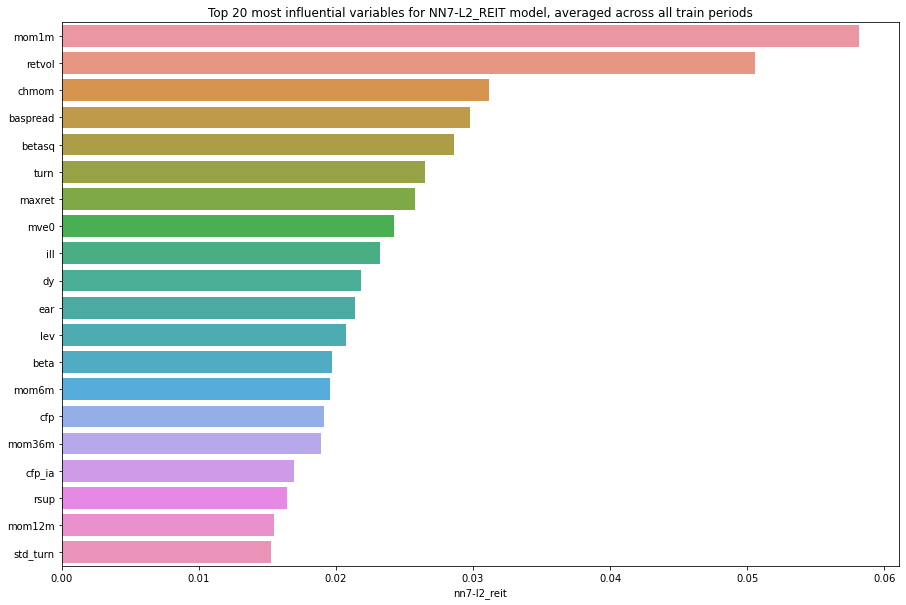

In [53]:
# Plot features of importance
# Plot graph
df_top20 = df_impt.sort_values(by=[model_name], ascending = False).head(20)
plt.figure(figsize=(15,10))
plt.title(f'Top 20 most influential variables for {model_name.upper()} model, averaged across all train periods')
sns.barplot(data = df_top20, x = model_name, y = df_top20.index);

In [54]:
# Merge df_temp to existing df_r2drecrease table

df_r2decrease_reit = pd.merge(
    left = df_r2decrease_reit,
    right = df_impt[model_name],
    how = 'left',
    left_index = True,
    right_index = True    
)

# Rank R2decrease table after including new model results
df_featurerank_reit = df_r2decrease_reit.rank() 
df_featurerank_reit['all_models'] = df_featurerank_reit.sum(axis=1)

# Display tables
display(df_r2decrease_reit)
display(df_featurerank_reit.sort_values('all_models', ascending = False))

# Save dfs to .csv 
df_r2decrease_reit.to_csv('../data/df_r2decrease_reit.csv', index = False)
df_featurerank_reit.to_csv('../data/df_featurerank_reit.csv', index = False)

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
absacc           0.000306   -0.001380    0.000189    0.000000   0.000000   
acc              0.001430   -0.000741    0.001779    0.000000   0.000000   
aeavol           0.000650    0.000668    0.005239    0.001173   0.001226   
age              0.000137   -0.000080    0.001680    0.000018   0.000030   
agr              0.000223    0.005201    0.003357    0.000000   0.000010   
baspread         0.007390    0.007871    0.000149    0.000000   0.000000   
beta             0.008894    0.057075    0.000315    0.000000   0.000000   
betasq           0.013997    0.013039    0.002645    0.000000   0.000000   
bm               0.001241    0.000853    0.024032    0.025538   0.026162   
bm_ia            0.002404    0.004776    0.007611    0.004235   0.004285   
cash             0.000161    0.000505    0.003340    0.000873   0.000927   
cashdebt         0.000128   -0.001187    0.000750    0.000000   0.000000   
cashpr           0.001257    0.002444    0.004893    0.001111   0.001181   
cfp              0.006021    0.006040    0.008196    0.013265   0.013306   
cfp_ia           0.001410    0.004166    0.007417    0.015930   0.015591   
chatoia          0.000082   -0.000040   -0.000983   -0.000089  -0.000097   
chcsho           0.000206   -0.000878    0.005366    0.002707   0.002796   
chempia          0.001031    0.003782   -0.000006    0.000000   0.000000   
chinv            0.000245   -0.000393    0.000482    0.000000   0.000000   
chmom            0.052654    0.050540    0.096469    0.142593   0.139152   
chpmia           0.002182    0.002565    0.011188    0.005567   0.005818   
chtx            -0.000017   -0.000019    0.000188    0.000000   0.000000   
cinvest          0.000038    0.000148    0.000281    0.000000   0.000000   
convind          0.000886    0.000794    0.000866    0.000000   0.000000   
currat           0.091179    0.044869   -0.000742    0.000000   0.000000   
depr            -0.000063    0.000391    0.001464    0.000148   0.000158   
divi             0.000153    0.000328    0.000156    0.000000   0.000000   
divo             0.000145    0.000922    0.000460    0.000000   0.000000   
dolvol           0.052843    0.089712    0.018587    0.017184   0.017007   
dy               0.016294    0.015071    0.090116    0.083019   0.084596   
ear              0.000198    0.000341    0.007511    0.004939   0.005175   
egr              0.001280    0.002940    0.004116    0.001198   0.001247   
ep               0.001748    0.010111    0.008772    0.004712   0.004875   
gma              0.003155   -0.001219    0.004361    0.000000   0.000000   
grcapx           0.000474    0.000658   -0.000177    0.000000   0.000000   
grltnoa          0.002414    0.001948    0.004432    0.000000   0.000000   
herf             0.023766    0.022687    0.023490    0.026236   0.026005   
hire             0.000198    0.002251    0.000338    0.000000   0.000000   
idiovol          0.000873   -0.000939    0.012297    0.014589   0.014951   
ill              0.005484    0.010939    0.022225    0.013264   0.013836   
indmom          -0.000049    0.000309    0.000357    0.000269   0.000290   
invest           0.000890    0.000858    0.002343    0.000000   0.000000   
lev             -0.000274   -0.002811   -0.002411    0.000000   0.000000   
lgr              0.000145    0.000304    0.000079    0.000000   0.000000   
maxret           0.025620    0.054758    0.005975    0.000000   0.000000   
mom12m           0.004666    0.002331    0.047325    0.017174   0.020037   
mom1m            0.019050    0.030089    0.134880    0.123642   0.127685   
mom36m           0.004236    0.006796    0.023669    0.021621   0.022049   
mom6m            0.056381    0.030482    0.053236    0.127055   0.120789   
ms               0.000196    0.000743    0.002229    0.000000   0.000000   
mve0             0.200379    0.212738    0.122775    0.137827   0.135776   
mve_ia           0.116817    0.152169    0.033515    0.073484   0.

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
mom1m               84.0        84.0        94.0        91.0       92.0   
chmom               87.0        89.0        92.0        94.0       94.0   
retvol              93.0        86.0        90.0        87.0       87.0   
mom12m              74.0        60.0        88.0        82.0       83.0   
mom6m               89.0        85.0        89.0        92.0       91.0   
mve0                94.0        94.0        93.0        93.0       93.0   
dy                  83.0        82.0        91.0        90.0       90.0   
sgr                 79.0        76.0        87.0        88.0       88.0   
ill                 75.0        78.0        82.0        78.0       79.0   
mom36m              72.0        72.0        84.0        84.0       84.0   
herf                85.0        83.0        83.0        86.0       85.0   
maxret              86.0        90.0        68.0        26.0       25.5   
dolvol              88.0        92.0        81.0        83.0       82.0   
bm                  54.0        47.0        85.0        85.0       86.0   
cfp                 76.0        71.0        75.0        79.0       78.0   
ep                  63.0        77.0        76.0        73.0       73.0   
cfp_ia              57.0        67.0        71.0        81.0       81.0   
ear                 29.0        33.0        72.0        74.0       74.0   
chpmia              67.0        62.0        79.0        75.0       75.0   
pchdepr             43.0        35.0        57.0        67.0       66.0   
bm_ia               68.0        69.0        73.0        72.0       72.0   
turn                77.0        79.0        40.0        62.0       62.0   
tang                61.0        54.0        77.0        66.0       67.0   
idiovol             48.0         7.0        80.0        80.0       80.0   
sp                  59.0        75.0        66.0        76.0       76.0   
betasq              81.0        80.0        49.0        26.0       25.5   
baspread            78.0        73.0        18.0        26.0       25.5   
beta                80.0        91.0        26.0        26.0       25.5   
roavol              65.0        68.0        67.0        68.0       68.0   
rd_sale             73.0        74.0        74.0        77.0       77.0   
mve_ia              92.0        93.0        86.0        89.0       89.0   
saleinv             66.0        55.0        78.0        69.0       69.0   
roaq                62.0        65.0        69.0        26.0       25.5   
std_dolvol          39.0        53.0        63.0        59.0       59.0   
roic                47.0         6.0        70.0        70.0       70.0   
chtx                 9.0        24.0        20.0        26.0       25.5   
invest              50.0        48.0        46.0        26.0       25.5   
pchgm_pchsale       32.0        20.0        61.0        58.0       58.0   
pchsale_pchinvt     27.0        28.0        51.0        52.0       51.0   
cash                25.0        39.0        54.0        61.0       61.0   
stdacc              60.0        64.0        15.0        26.0       25.5   
rsup                51.0        14.0        48.0        55.0       55.0   
zerotrade           82.0        57.0        50.0        53.0       52.0   
egr                 56.0        63.0        58.0        65.0       65.0   
aeavol              46.0        43.0        64.0        64.0       64.0   
chinv               36.0        12.0        34.0        26.0       25.5   
indmom               7.0        31.0        28.0        57.0       57.0   
agr                 35.0        70.0        55.0        26.0       48.0   
lev                  2.0         1.0         2.0        26.0       25.5   
ps                  34.0         9.0        41.0        26.0       25.5   
grltnoa             69.0        56.0        60.0        26.0       25.5   
gma                 71.0         4.0        59.0        26.0       25.5   
stdcf               70.0        81.0      

## NN9 (L2 penalty)

### REIT

In [24]:
df_results_reit = df_results_reit[:17]

In [25]:
# Create list of configs to test on 
def model_configs():
    # define scope of configs
    n_penalty_type = [l2]
    n_penalty_amount = np.logspace(-5, -3, 5)
    n_learning_rate = [0.001, 0.01]
    # create configs
    configs = []
    for i in n_penalty_type:
        for j in n_penalty_amount:
            for k in n_learning_rate:
                cfg = [i,j,k]
                configs.append(cfg)
    print('Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): %d' %len(configs))
    return configs

def model_fit(X_train, X_validate, y_train, y_validate, cfg):
    # unpack config
    n_penalty_type, n_penalty_amount, n_learning_rate = cfg
    
    # Instantiate a Sequential model
    model = Sequential()
    
    # Add an input layer
    model.add(Dense(72, activation = 'relu', 
                    input_dim = X_train.shape[1], 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())
    
    # Add an input layer #2
    model.add(Dense(60, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #3
    model.add(Dense(48, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #4
    model.add(Dense(36, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())

    # Add an input layer #5
    model.add(Dense(24, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())    

    # Add an input layer #6
    model.add(Dense(12, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())    
    
    # Add an input layer #7
    model.add(Dense(8, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())  
    
    # Add an input layer #8
    model.add(Dense(4, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())  
    
    # Add an input layer #9
    model.add(Dense(2, activation = 'relu', 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Add batch normalization for the outputs of the layer above
    model.add(BatchNormalization())  
        
    # Add an output layer
    model.add(Dense(1, activation = None, 
                    kernel_regularizer=n_penalty_type(n_penalty_amount))
             )
    
    # Set learning rate
    opt = Adam(learning_rate = n_learning_rate)
    
    # Compile model
    model.compile(loss = 'mse',optimizer = opt)

    # Early stop
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5
    )    
    
    # Convert to np.array before calling model.fit()
    #  to speed up calculations
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)    
    X_validate = np.asarray(X_validate)
    y_validate = np.asarray(y_validate) 
    
    # Fit model
    model.fit(X_train, y_train,
              validation_data = (X_validate, y_validate),
              epochs = 500,
              batch_size = 2 ** 13,
              callbacks = [early_stop]
             )
   
    return model

In [26]:
# Instantiate list of configurations
cfg_list = model_configs()

Total configs (n_penalty_type, n_penalty_amount, n_learning_rate): 10


In [27]:
%%time
# Create model name 
model_name = 'nn9-l2_reit'

# Create new row of test results
df_results_reit = pd.concat(
    [df_results_reit, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_reit
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 226us/sample - loss: 109.9834 - val_loss: 105.2297
Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.8628 - val_loss: 105.1536
Epoch 3/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.2543 - val_loss: 105.0929
Epoch 4/500
21360/21360 [==============================] - 0s 15us/sample - loss: 107.7141 - val_loss: 105.0402
Epoch 5/500
21360/21360 [==============================] - 0s 15us/sample - loss: 107.2648 - val_loss: 104.9865
Epoch 6/500
21360/21360 [==============================] - 0s 15us/sample - loss: 106.8030 - val_loss: 104.9360
Epoch 7/500
21360/21360 [==============================] - 0s 15us/sample - loss: 106.3454 - val_loss: 104.8837
Epoch 8/500
21360/21360 [==============================] - 0s 15us/sample - loss: 105.9502 - val_loss: 104.8310
Epoch 9/500
21360/21360 [============================

21360/21360 [==============================] - 0s 16us/sample - loss: 103.7702 - val_loss: 104.2833
Epoch 39/500
21360/21360 [==============================] - 0s 15us/sample - loss: 103.6649 - val_loss: 104.2609
Epoch 40/500
21360/21360 [==============================] - 0s 15us/sample - loss: 103.5027 - val_loss: 104.2378
Epoch 41/500
21360/21360 [==============================] - 0s 14us/sample - loss: 103.3806 - val_loss: 104.2158
Epoch 42/500
21360/21360 [==============================] - 0s 15us/sample - loss: 103.2563 - val_loss: 104.1928
Epoch 43/500
21360/21360 [==============================] - 0s 15us/sample - loss: 103.1337 - val_loss: 104.1695
Epoch 44/500
21360/21360 [==============================] - 0s 15us/sample - loss: 102.9719 - val_loss: 104.1485
Epoch 45/500
21360/21360 [==============================] - 0s 16us/sample - loss: 102.9136 - val_loss: 104.1275
Epoch 46/500
21360/21360 [==============================] - 0s 14us/sample - loss: 102.7450 - val_loss: 104.1

21360/21360 [==============================] - 5s 212us/sample - loss: 110.5823 - val_loss: 105.7024
Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.6425 - val_loss: 104.9908
Epoch 3/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.0075 - val_loss: 104.6565
Epoch 4/500
21360/21360 [==============================] - 0s 14us/sample - loss: 107.5717 - val_loss: 104.4247
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 106.9217 - val_loss: 104.2364
Epoch 6/500
21360/21360 [==============================] - 0s 14us/sample - loss: 106.1767 - val_loss: 103.9919
Epoch 7/500
21360/21360 [==============================] - 0s 14us/sample - loss: 104.8165 - val_loss: 103.6814
Epoch 8/500
21360/21360 [==============================] - 0s 14us/sample - loss: 103.2002 - val_loss: 103.3741
Epoch 9/500
21360/21360 [==============================] - 0s 14us/sample - loss: 101.9799 - val_loss: 103.2018
Epo

21360/21360 [==============================] - 0s 15us/sample - loss: 95.1146 - val_loss: 103.5031
Epoch 61/500
21360/21360 [==============================] - 0s 15us/sample - loss: 94.7890 - val_loss: 103.4907
Epoch 62/500
21360/21360 [==============================] - 0s 14us/sample - loss: 94.5548 - val_loss: 103.4839
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 1.66, 10.17, 1.54, 10.37
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 212us/sample - loss: 109.3682 - val_loss: 105.2221
Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.7267 - val_loss: 105.2154
Epoch 3/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.3366 - val_loss: 105.2113
Epoch 4/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.0282 - val_loss: 105.2108
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 107.7

Epoch 7/500
21360/21360 [==============================] - 0s 14us/sample - loss: 106.0543 - val_loss: 104.2644
Epoch 8/500
21360/21360 [==============================] - 0s 14us/sample - loss: 105.4026 - val_loss: 104.1283
Epoch 9/500
21360/21360 [==============================] - 0s 15us/sample - loss: 104.8788 - val_loss: 104.0024
Epoch 10/500
21360/21360 [==============================] - 0s 14us/sample - loss: 104.1857 - val_loss: 103.9164
Epoch 11/500
21360/21360 [==============================] - 0s 14us/sample - loss: 103.2080 - val_loss: 103.9451
Epoch 12/500
21360/21360 [==============================] - 0s 15us/sample - loss: 102.4685 - val_loss: 104.0503
Epoch 13/500
21360/21360 [==============================] - 0s 14us/sample - loss: 101.2823 - val_loss: 104.1602
Epoch 14/500
21360/21360 [==============================] - 0s 14us/sample - loss: 100.2740 - val_loss: 104.4344
Epoch 15/500
21360/21360 [==============================] - 0s 14us/sample - loss: 99.4733 - val_lo

21360/21360 [==============================] - 0s 18us/sample - loss: 89.3562 - val_loss: 103.1248
Epoch 61/500
21360/21360 [==============================] - 0s 16us/sample - loss: 89.2858 - val_loss: 103.1154
Epoch 62/500
21360/21360 [==============================] - 0s 17us/sample - loss: 88.9830 - val_loss: 103.1087
Epoch 63/500
21360/21360 [==============================] - 0s 18us/sample - loss: 88.9546 - val_loss: 103.0887
Epoch 64/500
21360/21360 [==============================] - 0s 18us/sample - loss: 88.7219 - val_loss: 103.0827
Epoch 65/500
21360/21360 [==============================] - 0s 19us/sample - loss: 88.5654 - val_loss: 103.0917
Epoch 66/500
21360/21360 [==============================] - 0s 20us/sample - loss: 88.2972 - val_loss: 103.1168
Epoch 67/500
21360/21360 [==============================] - 0s 20us/sample - loss: 88.1672 - val_loss: 103.1181
Epoch 68/500
21360/21360 [==============================] - 0s 18us/sample - loss: 88.0042 - val_loss: 103.1476
Epoch

Epoch 56/500
21360/21360 [==============================] - 0s 16us/sample - loss: 90.9054 - val_loss: 102.8990
Epoch 57/500
21360/21360 [==============================] - 0s 16us/sample - loss: 90.7340 - val_loss: 102.8874
Epoch 58/500
21360/21360 [==============================] - 0s 16us/sample - loss: 90.5486 - val_loss: 102.8818
Epoch 59/500
21360/21360 [==============================] - 0s 16us/sample - loss: 90.2534 - val_loss: 102.8795
Epoch 60/500
21360/21360 [==============================] - 0s 16us/sample - loss: 90.1210 - val_loss: 102.8833
Epoch 61/500
21360/21360 [==============================] - 0s 18us/sample - loss: 90.1384 - val_loss: 102.8882
Epoch 62/500
21360/21360 [==============================] - 0s 16us/sample - loss: 89.8016 - val_loss: 102.9191
Epoch 63/500
21360/21360 [==============================] - 0s 17us/sample - loss: 89.5642 - val_loss: 102.9718
Epoch 64/500
21360/21360 [==============================] - 0s 15us/sample - loss: 89.5174 - val_loss: 1

Epoch 13/500
21360/21360 [==============================] - 0s 15us/sample - loss: 101.8796 - val_loss: 103.3748
Epoch 14/500
21360/21360 [==============================] - 0s 15us/sample - loss: 101.0395 - val_loss: 103.3517
Epoch 15/500
21360/21360 [==============================] - 0s 15us/sample - loss: 100.0817 - val_loss: 103.3519
Epoch 16/500
21360/21360 [==============================] - 0s 16us/sample - loss: 99.7917 - val_loss: 103.4033
Epoch 17/500
21360/21360 [==============================] - 0s 15us/sample - loss: 99.1770 - val_loss: 103.4353
Epoch 18/500
21360/21360 [==============================] - 0s 15us/sample - loss: 98.1501 - val_loss: 103.6421
Epoch 19/500
21360/21360 [==============================] - 0s 15us/sample - loss: 97.7177 - val_loss: 103.7261
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 1.46, 10.18, 0.74, 10.41

Ensemble results from Model [<function l2 at 0x7fbd6a463050>, 0.0001, 0.01]: [ 0.9378905  10.20946487  0.32979325 10.42876264]
Train on 21

21360/21360 [==============================] - 0s 14us/sample - loss: 100.3885 - val_loss: 104.0098
Epoch 70/500
21360/21360 [==============================] - 0s 14us/sample - loss: 100.2066 - val_loss: 103.9823
Epoch 71/500
21360/21360 [==============================] - 0s 16us/sample - loss: 100.0899 - val_loss: 103.9674
Epoch 72/500
21360/21360 [==============================] - 0s 14us/sample - loss: 99.9807 - val_loss: 103.9367
Epoch 73/500
21360/21360 [==============================] - 0s 14us/sample - loss: 99.7702 - val_loss: 103.9441
Epoch 74/500
21360/21360 [==============================] - 0s 15us/sample - loss: 99.6587 - val_loss: 103.9584
Epoch 75/500
21360/21360 [==============================] - 0s 14us/sample - loss: 99.4622 - val_loss: 103.9474
Epoch 76/500
21360/21360 [==============================] - 0s 15us/sample - loss: 99.3724 - val_loss: 103.9524
Epoch 77/500
21360/21360 [==============================] - 0s 15us/sample - loss: 99.2486 - val_loss: 103.9223
Ep

Epoch 14/500
21360/21360 [==============================] - 0s 15us/sample - loss: 98.1826 - val_loss: 103.1332
Epoch 15/500
21360/21360 [==============================] - 0s 14us/sample - loss: 97.4713 - val_loss: 103.1949
Epoch 16/500
21360/21360 [==============================] - 0s 14us/sample - loss: 96.8153 - val_loss: 103.4741
Epoch 17/500
21360/21360 [==============================] - 0s 15us/sample - loss: 95.7526 - val_loss: 103.8085
Epoch 18/500
21360/21360 [==============================] - 0s 14us/sample - loss: 94.9901 - val_loss: 104.1767
Epoch 19/500
21360/21360 [==============================] - 0s 15us/sample - loss: 94.1301 - val_loss: 104.9531
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.38, 10.24, 0.52, 10.42
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 16s 770us/sample - loss: 109.6989 - val_loss: 105.6897
Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample 

Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample - loss: 110.2120 - val_loss: 105.4194
Epoch 3/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.5506 - val_loss: 105.3403
Epoch 4/500
21360/21360 [==============================] - 0s 16us/sample - loss: 107.4415 - val_loss: 105.2604
Epoch 5/500
21360/21360 [==============================] - 0s 15us/sample - loss: 106.3278 - val_loss: 105.1779
Epoch 6/500
21360/21360 [==============================] - 0s 15us/sample - loss: 105.2397 - val_loss: 105.0982
Epoch 7/500
21360/21360 [==============================] - 0s 15us/sample - loss: 104.4862 - val_loss: 105.0239
Epoch 8/500
21360/21360 [==============================] - 0s 14us/sample - loss: 103.5900 - val_loss: 104.9552
Epoch 9/500
21360/21360 [==============================] - 0s 15us/sample - loss: 102.9606 - val_loss: 104.8899
Epoch 10/500
21360/21360 [==============================] - 0s 15us/sample - loss: 102.4288 - val_loss: 

Epoch 8/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.9925 - val_loss: 105.4577
Epoch 9/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.9077 - val_loss: 105.4507
Epoch 10/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.8222 - val_loss: 105.4441
Epoch 11/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.7319 - val_loss: 105.4378
Epoch 12/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.6390 - val_loss: 105.4315
Epoch 13/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.5402 - val_loss: 105.4252
Epoch 14/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.4423 - val_loss: 105.4195
Epoch 15/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.3467 - val_loss: 105.4138
Epoch 16/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.2335 - val_

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 220us/sample - loss: 109.8101 - val_loss: 105.4007
Epoch 2/500
21360/21360 [==============================] - 0s 15us/sample - loss: 108.8018 - val_loss: 105.2833
Epoch 3/500
21360/21360 [==============================] - 0s 14us/sample - loss: 108.1500 - val_loss: 105.1632
Epoch 4/500
21360/21360 [==============================] - 0s 15us/sample - loss: 107.4325 - val_loss: 104.9889
Epoch 5/500
21360/21360 [==============================] - 0s 16us/sample - loss: 106.6612 - val_loss: 104.8867
Epoch 6/500
21360/21360 [==============================] - 0s 15us/sample - loss: 105.6726 - val_loss: 104.8259
Epoch 7/500
21360/21360 [==============================] - 0s 15us/sample - loss: 104.4814 - val_loss: 104.7300
Epoch 8/500
21360/21360 [==============================] - 0s 16us/sample - loss: 103.4551 - val_loss: 104.6373
Epoch 9/500
21360/21360 [============================

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
13       nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14       nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15       nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   
0        nn9-l2_reit  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
0       1.47 (10.37)         1.89 (10.16)     0.42 (12.10)  2.09 (7.52)   
0       0.66 (10.41)         1.32 (10.19)              NaN          NaN   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.9

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 1.32, 10.19, 0.66, 10.41
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 1.25, 10.19, 0.51, 10.42
[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 1.16, 10.20, 0.41, 10.42
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 1.14, 10.20, 0.57, 10.42
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 1.09, 10.20, 0.64, 10.41
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 1.08, 10.20, 1.09, 10.39
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.94, 10.21, 0.33, 10.43
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.83, 10.22, 0.64, 10.41
CPU times: user 39min 10s, sys: 19min, total: 58min 10s
Wall time: 15min 8s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 1.32, 10.19, 0.66, 10.41

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 1.25, 10.19, 0.51, 10.42

[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 1.16, 10.20, 0.41, 10.42

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 1.14, 10.20, 0.57, 10.42

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 1.09, 10.20, 0.64, 10.41

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 1.08, 10.20, 1.09, 10.39

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.94, 10.21, 0.33, 10.43


[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.83, 10.22, 0.64, 10.41

CPU times: user 39min 10s, sys: 19min, total: 58min 10s

Wall time: 15min 8s

In [28]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_reit, 
    y = y_reit, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_reit
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_reit.to_csv('../data/df_results_reit.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 227us/sample - loss: 110.2353 - val_loss: 105.0848
Epoch 2/500
21360/21360 [==============================] - 0s 18us/sample - loss: 109.0116 - val_loss: 104.8800
Epoch 3/500
21360/21360 [==============================] - 0s 19us/sample - loss: 108.2020 - val_loss: 104.6673
Epoch 4/500
21360/21360 [==============================] - 0s 16us/sample - loss: 107.6705 - val_loss: 104.3959
Epoch 5/500
21360/21360 [==============================] - 0s 17us/sample - loss: 107.1465 - val_loss: 104.1794
Epoch 6/500
21360/21360 [==============================] - 0s 22us/sample - loss: 106.5265 - val_loss: 104.0736
Epoch 7/500
21360/21360 [==============================] - 0s 20us/sample - loss: 105.6806 - val_loss: 104.0324
Epoch 8/500
21360/21360 [==============================] - 0s 18us/sample - loss: 104.6912 - val_loss: 104.0001
Epoch 9/500
21360/21360 [============================

23469/23469 [==============================] - 0s 15us/sample - loss: 103.8003 - val_loss: 81.9765
Epoch 20/500
23469/23469 [==============================] - 0s 15us/sample - loss: 103.2064 - val_loss: 82.1457
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_reit_2007_2/assets
Train on 23469 samples, validate on 10493 samples
Epoch 1/500
23469/23469 [==============================] - 5s 199us/sample - loss: 115.4948 - val_loss: 83.0500
Epoch 2/500
23469/23469 [==============================] - 0s 14us/sample - loss: 113.9520 - val_loss: 82.7924
Epoch 3/500
23469/23469 [==============================] - 0s 15us/sample - loss: 113.1372 - val_loss: 82.5664
Epoch 4/500
23469/23469 [==============================] - 0s 16us/sample - loss: 112.5210 - val_loss: 82.3592
Epoch 5/500
23469/23469 [==============================] - 0s 14us/sample - loss: 112.0493 - val_loss: 82.1645
Epoch 6/500
23469/23469 [==============================] - 0s 15us/sample - loss: 111.4453 - val_loss: 81.9864
E

27460/27460 [==============================] - 0s 14us/sample - loss: 114.8171 - val_loss: 131.5881
Epoch 4/500
27460/27460 [==============================] - 0s 14us/sample - loss: 114.2970 - val_loss: 131.7268
Epoch 5/500
27460/27460 [==============================] - 0s 14us/sample - loss: 113.7761 - val_loss: 131.8842
Epoch 6/500
27460/27460 [==============================] - 0s 15us/sample - loss: 113.2947 - val_loss: 132.0757
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_reit_2009_1/assets
Train on 27460 samples, validate on 10324 samples
Epoch 1/500
27460/27460 [==============================] - 5s 175us/sample - loss: 116.0796 - val_loss: 131.3748
Epoch 2/500
27460/27460 [==============================] - 0s 15us/sample - loss: 115.1434 - val_loss: 131.4449
Epoch 3/500
27460/27460 [==============================] - 0s 14us/sample - loss: 114.6290 - val_loss: 131.5044
Epoch 4/500
27460/27460 [==============================] - 0s 14us/sample - loss: 114.1788 - val_loss: 131

Epoch 2/500
31753/31753 [==============================] - 0s 14us/sample - loss: 107.6650 - val_loss: 261.0263
Epoch 3/500
31753/31753 [==============================] - 0s 13us/sample - loss: 107.3646 - val_loss: 260.9657
Epoch 4/500
31753/31753 [==============================] - 1s 16us/sample - loss: 107.0705 - val_loss: 260.9394
Epoch 5/500
31753/31753 [==============================] - 1s 16us/sample - loss: 106.6740 - val_loss: 260.9161
Epoch 6/500
31753/31753 [==============================] - 1s 17us/sample - loss: 106.2080 - val_loss: 260.9114
Epoch 7/500
31753/31753 [==============================] - 0s 15us/sample - loss: 105.5814 - val_loss: 260.9647
Epoch 8/500
31753/31753 [==============================] - 1s 16us/sample - loss: 104.9024 - val_loss: 261.0653
Epoch 9/500
31753/31753 [==============================] - 0s 15us/sample - loss: 104.1081 - val_loss: 261.1656
Epoch 10/500
31753/31753 [==============================] - 0s 15us/sample - loss: 103.2954 - val_loss: 

Epoch 2/500
33962/33962 [==============================] - 0s 13us/sample - loss: 104.2950 - val_loss: 276.2333
Epoch 3/500
33962/33962 [==============================] - 0s 14us/sample - loss: 103.7380 - val_loss: 276.2951
Epoch 4/500
33962/33962 [==============================] - 0s 13us/sample - loss: 103.4596 - val_loss: 276.3992
Epoch 5/500
33962/33962 [==============================] - 0s 14us/sample - loss: 103.0470 - val_loss: 276.5398
Epoch 6/500
33962/33962 [==============================] - 0s 15us/sample - loss: 102.6439 - val_loss: 276.7237
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_reit_2012_4/assets
Test year 2012 done, R2 score is 3.03
Test year 2012 done, RMSE score is 9.32
Train on 35928 samples, validate on 9376 samples
Epoch 1/500
35928/35928 [==============================] - 5s 132us/sample - loss: 105.9773 - val_loss: 267.9281
Epoch 2/500
35928/35928 [==============================] - 0s 13us/sample - loss: 105.2871 - val_loss: 267.7425
Epoch 3/500
35928

35928/35928 [==============================] - 1s 15us/sample - loss: 102.3369 - val_loss: 267.2546
Epoch 7/500
35928/35928 [==============================] - 1s 15us/sample - loss: 101.3519 - val_loss: 267.2316
Epoch 8/500
35928/35928 [==============================] - 0s 14us/sample - loss: 100.4385 - val_loss: 267.1729
Epoch 9/500
35928/35928 [==============================] - 0s 13us/sample - loss: 99.4357 - val_loss: 267.2393
Epoch 10/500
35928/35928 [==============================] - 0s 14us/sample - loss: 98.4931 - val_loss: 267.2020
Epoch 11/500
35928/35928 [==============================] - 1s 14us/sample - loss: 97.9042 - val_loss: 267.1993
Epoch 12/500
35928/35928 [==============================] - 0s 13us/sample - loss: 97.4099 - val_loss: 267.1439
Epoch 13/500
35928/35928 [==============================] - 0s 14us/sample - loss: 97.1847 - val_loss: 267.4178
Epoch 14/500
35928/35928 [==============================] - 0s 13us/sample - loss: 96.7687 - val_loss: 267.1524
Epoch

37784/37784 [==============================] - 1s 14us/sample - loss: 117.5545 - val_loss: 203.0108
Epoch 7/500
37784/37784 [==============================] - 1s 14us/sample - loss: 116.7044 - val_loss: 203.0514
Epoch 8/500
37784/37784 [==============================] - 1s 14us/sample - loss: 116.2265 - val_loss: 203.0469
Epoch 9/500
37784/37784 [==============================] - 0s 13us/sample - loss: 115.2025 - val_loss: 203.1713
Epoch 10/500
37784/37784 [==============================] - 1s 14us/sample - loss: 113.5925 - val_loss: 204.0523
Epoch 11/500
37784/37784 [==============================] - 1s 14us/sample - loss: 112.8078 - val_loss: 205.0697
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_reit_2014_4/assets
Test year 2014 done, R2 score is 2.43
Test year 2014 done, RMSE score is 6.96
Train on 39556 samples, validate on 10230 samples
Epoch 1/500
39556/39556 [==============================] - 5s 124us/sample - loss: 145.5025 - val_loss: 96.9630
Epoch 2/500
39556/39556 [==

Test year 2016 done, R2 score is 1.63
Test year 2016 done, RMSE score is 9.01
Train on 43327 samples, validate on 11340 samples
Epoch 1/500
43327/43327 [==============================] - 5s 112us/sample - loss: 142.6428 - val_loss: 72.0919
Epoch 2/500
43327/43327 [==============================] - 1s 12us/sample - loss: 141.3432 - val_loss: 71.8322
Epoch 3/500
43327/43327 [==============================] - 1s 13us/sample - loss: 141.1199 - val_loss: 71.5935
Epoch 4/500
43327/43327 [==============================] - 1s 13us/sample - loss: 140.9349 - val_loss: 71.4208
Epoch 5/500
43327/43327 [==============================] - 1s 13us/sample - loss: 140.7867 - val_loss: 71.4067
Epoch 6/500
43327/43327 [==============================] - 1s 13us/sample - loss: 140.3994 - val_loss: 71.3109
Epoch 7/500
43327/43327 [==============================] - 1s 13us/sample - loss: 139.7527 - val_loss: 71.3826
Epoch 8/500
43327/43327 [==============================] - 1s 13us/sample - loss: 138.9507 - v

47453/47453 [==============================] - 1s 12us/sample - loss: 136.8945 - val_loss: 60.4979
Epoch 3/500
47453/47453 [==============================] - 1s 12us/sample - loss: 136.6871 - val_loss: 60.4224
Epoch 4/500
47453/47453 [==============================] - 1s 13us/sample - loss: 136.4581 - val_loss: 60.3881
Epoch 5/500
47453/47453 [==============================] - 1s 12us/sample - loss: 136.0341 - val_loss: 60.4307
Epoch 6/500
47453/47453 [==============================] - 1s 12us/sample - loss: 135.4491 - val_loss: 60.4472
Epoch 7/500
47453/47453 [==============================] - 1s 12us/sample - loss: 134.9987 - val_loss: 60.5110
Epoch 8/500
47453/47453 [==============================] - 1s 12us/sample - loss: 134.8130 - val_loss: 60.7025
Epoch 9/500
47453/47453 [==============================] - 1s 12us/sample - loss: 134.4829 - val_loss: 60.7020
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_reit_2019_2/assets
Train on 47453 samples, validate on 11958 samples
Epo

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
13       nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14       nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15       nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0        nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   
0        nn9-l2_reit  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
0       1.47 (10.37)         1.89 (10.16)     0.42 (12.10)  2.09 (7.52)   
0       0.66 (10.41)         1.32 (10.19)     0.32 (12.11)  2.45 (7.51)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.9


R2 for entire pooled test set, from 2006 to 2020, is 0.32.
RMSE for entire pooled test set, from 2006 to 2020, is 12.11.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01]
CPU times: user 40min 10s, sys: 12min 12s, total: 52min 23s
Wall time: 19min 53s


R2 for entire pooled test set, from 2006 to 2020, is 0.32.

RMSE for entire pooled test set, from 2006 to 2020, is 12.11.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01]

CPU times: user 40min 10s, sys: 12min 12s, total: 52min 23s

Wall time: 19min 53s

### Sample 1

In [29]:
df_results_sample1 = df_results_sample1[:17]

In [30]:
%%time
# Create model name 
model_name = 'nn9-l2_sample1'

# Create new row of test results
df_results_sample1 = pd.concat(
    [df_results_sample1, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample1
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 211us/sample - loss: 435.9060 - val_loss: 361.2343
Epoch 2/500
21360/21360 [==============================] - 0s 13us/sample - loss: 435.5997 - val_loss: 361.2420
Epoch 3/500
21360/21360 [==============================] - 0s 14us/sample - loss: 435.3805 - val_loss: 361.2487
Epoch 4/500
21360/21360 [==============================] - 0s 14us/sample - loss: 435.1933 - val_loss: 361.2527
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 435.0205 - val_loss: 361.2533
Epoch 6/500
21360/21360 [==============================] - 0s 14us/sample - loss: 434.8386 - val_loss: 361.2516
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.00, 19.01, 0.00, 20.88
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 214us/sample - loss: 438.5896 - val_loss: 361.2298
Epoch 2/500
21360/21360 [===============

21360/21360 [==============================] - 0s 14us/sample - loss: 392.3922 - val_loss: 360.4192
Epoch 59/500
21360/21360 [==============================] - 0s 14us/sample - loss: 392.3060 - val_loss: 360.4294
Epoch 60/500
21360/21360 [==============================] - 0s 13us/sample - loss: 391.8981 - val_loss: 360.4023
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.24, 18.98, 0.75, 20.80
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 212us/sample - loss: 436.9137 - val_loss: 361.3132
Epoch 2/500
21360/21360 [==============================] - 0s 13us/sample - loss: 435.0284 - val_loss: 361.2490
Epoch 3/500
21360/21360 [==============================] - 0s 13us/sample - loss: 433.9107 - val_loss: 361.2016
Epoch 4/500
21360/21360 [==============================] - 0s 14us/sample - loss: 433.0124 - val_loss: 361.1651
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 432.1399 - val_loss

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 212us/sample - loss: 437.3463 - val_loss: 360.7201
Epoch 2/500
21360/21360 [==============================] - 0s 13us/sample - loss: 433.4931 - val_loss: 360.7280
Epoch 3/500
21360/21360 [==============================] - 0s 13us/sample - loss: 430.7667 - val_loss: 360.7101
Epoch 4/500
21360/21360 [==============================] - 0s 14us/sample - loss: 427.1693 - val_loss: 360.6421
Epoch 5/500
21360/21360 [==============================] - 0s 13us/sample - loss: 424.3114 - val_loss: 360.6503
Epoch 6/500
21360/21360 [==============================] - 0s 13us/sample - loss: 420.3942 - val_loss: 360.6769
Epoch 7/500
21360/21360 [==============================] - 0s 14us/sample - loss: 417.5906 - val_loss: 360.6690
Epoch 8/500
21360/21360 [==============================] - 0s 14us/sample - loss: 414.3965 - val_loss: 360.6640
Epoch 9/500
21360/21360 [============================

21360/21360 [==============================] - 0s 13us/sample - loss: 418.5107 - val_loss: 361.1352
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.04, 19.00, 0.11, 20.87

Ensemble results from Model [<function l2 at 0x7fbd6a463050>, 1e-05, 0.01]: [ 0.07526868 18.99970402  0.78667941 20.79471218]
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 215us/sample - loss: 436.9966 - val_loss: 361.3509
Epoch 2/500
21360/21360 [==============================] - 0s 13us/sample - loss: 433.4972 - val_loss: 361.3250
Epoch 3/500
21360/21360 [==============================] - 0s 13us/sample - loss: 431.6534 - val_loss: 361.2983
Epoch 4/500
21360/21360 [==============================] - 0s 13us/sample - loss: 430.1212 - val_loss: 361.2796
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 428.5495 - val_loss: 361.2629
Epoch 6/500
21360/21360 [==============================] - 0s 13us/sample - loss: 427.236

21360/21360 [==============================] - 0s 14us/sample - loss: 426.0349 - val_loss: 361.0263
Epoch 10/500
21360/21360 [==============================] - 0s 13us/sample - loss: 424.9033 - val_loss: 360.9968
Epoch 11/500
21360/21360 [==============================] - 0s 14us/sample - loss: 423.8501 - val_loss: 360.9719
Epoch 12/500
21360/21360 [==============================] - 0s 14us/sample - loss: 422.5868 - val_loss: 360.9442
Epoch 13/500
21360/21360 [==============================] - 0s 13us/sample - loss: 421.6601 - val_loss: 360.9211
Epoch 14/500
21360/21360 [==============================] - 0s 13us/sample - loss: 420.5487 - val_loss: 360.8906
Epoch 15/500
21360/21360 [==============================] - 0s 14us/sample - loss: 419.3299 - val_loss: 360.8638
Epoch 16/500
21360/21360 [==============================] - 0s 14us/sample - loss: 418.5138 - val_loss: 360.8444
Epoch 17/500
21360/21360 [==============================] - 0s 13us/sample - loss: 417.1346 - val_loss: 360.8

Epoch 10/500
21360/21360 [==============================] - 0s 14us/sample - loss: 420.6690 - val_loss: 360.6771
Epoch 11/500
21360/21360 [==============================] - 0s 13us/sample - loss: 418.5667 - val_loss: 360.9091
Epoch 12/500
21360/21360 [==============================] - 0s 14us/sample - loss: 415.6439 - val_loss: 361.2683
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 0.00, 19.01, 0.19, 20.86
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 214us/sample - loss: 435.8298 - val_loss: 361.1629
Epoch 2/500
21360/21360 [==============================] - 0s 13us/sample - loss: 435.1038 - val_loss: 361.0726
Epoch 3/500
21360/21360 [==============================] - 0s 13us/sample - loss: 434.1838 - val_loss: 361.0152
Epoch 4/500
21360/21360 [==============================] - 0s 13us/sample - loss: 433.0047 - val_loss: 360.9817
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sampl

21360/21360 [==============================] - 0s 13us/sample - loss: 390.9817 - val_loss: 360.0212
Epoch 50/500
21360/21360 [==============================] - 0s 13us/sample - loss: 390.3634 - val_loss: 360.0183
Epoch 51/500
21360/21360 [==============================] - 0s 14us/sample - loss: 389.9541 - val_loss: 360.0095
Epoch 52/500
21360/21360 [==============================] - 0s 14us/sample - loss: 389.4123 - val_loss: 360.0028
Epoch 53/500
21360/21360 [==============================] - 0s 14us/sample - loss: 388.6308 - val_loss: 360.0129
Epoch 54/500
21360/21360 [==============================] - 0s 13us/sample - loss: 387.9578 - val_loss: 360.0068
Epoch 55/500
21360/21360 [==============================] - 0s 14us/sample - loss: 387.1926 - val_loss: 360.0046
Epoch 56/500
21360/21360 [==============================] - 0s 13us/sample - loss: 386.7627 - val_loss: 360.0123
Epoch 57/500
21360/21360 [==============================] - 0s 14us/sample - loss: 386.8414 - val_loss: 360.0

21360/21360 [==============================] - 0s 14us/sample - loss: 419.3172 - val_loss: 360.2828
Epoch 10/500
21360/21360 [==============================] - 0s 13us/sample - loss: 417.0637 - val_loss: 360.2020
Epoch 11/500
21360/21360 [==============================] - 0s 14us/sample - loss: 417.3206 - val_loss: 360.0978
Epoch 12/500
21360/21360 [==============================] - 0s 14us/sample - loss: 412.1641 - val_loss: 360.0728
Epoch 13/500
21360/21360 [==============================] - 0s 15us/sample - loss: 409.0041 - val_loss: 360.0165
Epoch 14/500
21360/21360 [==============================] - 0s 14us/sample - loss: 407.9859 - val_loss: 359.9661
Epoch 15/500
21360/21360 [==============================] - 0s 14us/sample - loss: 405.3233 - val_loss: 359.9674
Epoch 16/500
21360/21360 [==============================] - 0s 14us/sample - loss: 405.0961 - val_loss: 360.0417
Epoch 17/500
21360/21360 [==============================] - 0s 14us/sample - loss: 402.1312 - val_loss: 359.9

Epoch 3/500
21360/21360 [==============================] - 0s 13us/sample - loss: 431.8517 - val_loss: 361.3440
Epoch 4/500
21360/21360 [==============================] - 0s 14us/sample - loss: 429.9728 - val_loss: 361.3520
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 428.3839 - val_loss: 361.3607
Epoch 6/500
21360/21360 [==============================] - 0s 13us/sample - loss: 426.8608 - val_loss: 361.3697
Epoch 7/500
21360/21360 [==============================] - 0s 13us/sample - loss: 425.2742 - val_loss: 361.3726
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], -0.00, 19.01, 0.01, 20.88
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 4s 210us/sample - loss: 437.1525 - val_loss: 361.3436
Epoch 2/500
21360/21360 [==============================] - 0s 13us/sample - loss: 434.2477 - val_loss: 361.3143
Epoch 3/500
21360/21360 [==============================] - 0s 14us/sample

Epoch 12/500
21360/21360 [==============================] - 0s 13us/sample - loss: 419.9191 - val_loss: 360.3469
Epoch 13/500
21360/21360 [==============================] - 0s 14us/sample - loss: 416.9926 - val_loss: 360.2732
Epoch 14/500
21360/21360 [==============================] - 0s 13us/sample - loss: 413.5050 - val_loss: 360.2113
Epoch 15/500
21360/21360 [==============================] - 0s 13us/sample - loss: 412.2108 - val_loss: 360.1853
Epoch 16/500
21360/21360 [==============================] - 0s 13us/sample - loss: 410.1327 - val_loss: 360.1607
Epoch 17/500
21360/21360 [==============================] - 0s 14us/sample - loss: 408.4328 - val_loss: 360.1438
Epoch 18/500
21360/21360 [==============================] - 0s 14us/sample - loss: 405.0764 - val_loss: 360.1373
Epoch 19/500
21360/21360 [==============================] - 0s 13us/sample - loss: 404.5344 - val_loss: 360.1445
Epoch 20/500
21360/21360 [==============================] - 0s 13us/sample - loss: 402.8674 - va

Epoch 6/500
21360/21360 [==============================] - 0s 14us/sample - loss: 428.6151 - val_loss: 360.9506
Epoch 7/500
21360/21360 [==============================] - 0s 13us/sample - loss: 429.0533 - val_loss: 360.9305
Epoch 8/500
21360/21360 [==============================] - 0s 14us/sample - loss: 427.5072 - val_loss: 360.9066
Epoch 9/500
21360/21360 [==============================] - 0s 13us/sample - loss: 425.9068 - val_loss: 360.9346
Epoch 10/500
21360/21360 [==============================] - 0s 13us/sample - loss: 424.1924 - val_loss: 361.0253
Epoch 11/500
21360/21360 [==============================] - 0s 14us/sample - loss: 422.3130 - val_loss: 361.1546
Epoch 12/500
21360/21360 [==============================] - 0s 13us/sample - loss: 420.3133 - val_loss: 361.2529
Epoch 13/500
21360/21360 [==============================] - 0s 13us/sample - loss: 417.7625 - val_loss: 361.4993
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], -0.03, 19.01, 0.13, 20.86

Ensemble

Epoch 23/500
21360/21360 [==============================] - 0s 14us/sample - loss: 416.0851 - val_loss: 361.2576
Epoch 24/500
21360/21360 [==============================] - 0s 13us/sample - loss: 415.4497 - val_loss: 361.2453
Epoch 25/500
21360/21360 [==============================] - 0s 14us/sample - loss: 414.7577 - val_loss: 361.2370
Epoch 26/500
21360/21360 [==============================] - 0s 13us/sample - loss: 414.1808 - val_loss: 361.2236
Epoch 27/500
21360/21360 [==============================] - 0s 14us/sample - loss: 413.6776 - val_loss: 361.2155
Epoch 28/500
21360/21360 [==============================] - 0s 14us/sample - loss: 413.0607 - val_loss: 361.2096
Epoch 29/500
21360/21360 [==============================] - 0s 14us/sample - loss: 412.5392 - val_loss: 361.2072
Epoch 30/500
21360/21360 [==============================] - 0s 14us/sample - loss: 412.0534 - val_loss: 361.2098
Epoch 31/500
21360/21360 [==============================] - 0s 14us/sample - loss: 411.3526 - va

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
13      nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
14       nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
15       nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   
0        nn9-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
13      2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
14      1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
15      0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   
0       1.31 (20.74)         0.31 (18.98)    -0.07 (15.77)   0.14 (14.71)   
0       0.32 (20.84)         0.22 (18.99)              NaN            NaN   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.22, 18.99, 0.32, 20.84
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.19, 18.99, 0.51, 20.82
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 0.18, 18.99, 0.34, 20.84
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.18, 18.99, 0.19, 20.86
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.15, 18.99, 0.33, 20.84
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.10, 19.00, 0.23, 20.85
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 0.09, 19.00, 0.32, 20.84
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.08, 19.00, 0.79, 20.79
CPU times: user 31min 25s, sys: 17min 49s, total: 49min 14s
Wall time: 12min 15s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.22, 18.99, 0.32, 20.84

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.19, 18.99, 0.51, 20.82

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.001], 0.18, 18.99, 0.34, 20.84

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.18, 18.99, 0.19, 20.86

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.01], 0.15, 18.99, 0.33, 20.84

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.10, 19.00, 0.23, 20.85

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 0.09, 19.00, 0.32, 20.84

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.08, 19.00, 0.79, 20.79

CPU times: user 31min 25s, sys: 17min 49s, total: 49min 14s

Wall time: 12min 15s

In [31]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_1, 
    y = y_1, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample1
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample1.to_csv('../data/df_results_sample1.csv', index = False)

Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 213us/sample - loss: 436.3206 - val_loss: 361.3125
Epoch 2/500
21360/21360 [==============================] - 0s 14us/sample - loss: 433.9633 - val_loss: 361.3375
Epoch 3/500
21360/21360 [==============================] - 0s 14us/sample - loss: 432.6677 - val_loss: 361.3649
Epoch 4/500
21360/21360 [==============================] - 0s 15us/sample - loss: 431.5348 - val_loss: 361.4034
Epoch 5/500
21360/21360 [==============================] - 0s 14us/sample - loss: 430.4294 - val_loss: 361.4312
Epoch 6/500
21360/21360 [==============================] - 0s 14us/sample - loss: 429.4362 - val_loss: 361.4560
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample1_2006_0/assets
Train on 21360 samples, validate on 10393 samples
Epoch 1/500
21360/21360 [==============================] - 5s 211us/sample - loss: 436.7506 - val_loss: 361.3600
Epoch 2/500
21360/21360 [===============

21360/21360 [==============================] - 0s 14us/sample - loss: 415.8752 - val_loss: 360.6677
Epoch 54/500
21360/21360 [==============================] - 0s 14us/sample - loss: 415.5202 - val_loss: 360.6579
Epoch 55/500
21360/21360 [==============================] - 0s 13us/sample - loss: 415.1440 - val_loss: 360.6581
Epoch 56/500
21360/21360 [==============================] - 0s 14us/sample - loss: 414.7423 - val_loss: 360.6520
Epoch 57/500
21360/21360 [==============================] - 0s 14us/sample - loss: 414.4017 - val_loss: 360.6353
Epoch 58/500
21360/21360 [==============================] - 0s 14us/sample - loss: 413.9331 - val_loss: 360.6113
Epoch 59/500
21360/21360 [==============================] - 0s 14us/sample - loss: 413.2880 - val_loss: 360.6031
Epoch 60/500
21360/21360 [==============================] - 0s 14us/sample - loss: 412.8486 - val_loss: 360.6115
Epoch 61/500
21360/21360 [==============================] - 0s 14us/sample - loss: 412.3832 - val_loss: 360.6

Epoch 9/500
23469/23469 [==============================] - 0s 13us/sample - loss: 454.8484 - val_loss: 251.3847
Epoch 10/500
23469/23469 [==============================] - 0s 13us/sample - loss: 453.8319 - val_loss: 251.3789
Epoch 11/500
23469/23469 [==============================] - 0s 13us/sample - loss: 452.9238 - val_loss: 251.3698
Epoch 12/500
23469/23469 [==============================] - 0s 13us/sample - loss: 452.0134 - val_loss: 251.3634
Epoch 13/500
23469/23469 [==============================] - 0s 13us/sample - loss: 451.1364 - val_loss: 251.3581
Epoch 14/500
23469/23469 [==============================] - 0s 13us/sample - loss: 450.0466 - val_loss: 251.3492
Epoch 15/500
23469/23469 [==============================] - 0s 13us/sample - loss: 449.2662 - val_loss: 251.3406
Epoch 16/500
23469/23469 [==============================] - 0s 13us/sample - loss: 448.3401 - val_loss: 251.3298
Epoch 17/500
23469/23469 [==============================] - 0s 13us/sample - loss: 447.7004 - val

23469/23469 [==============================] - 0s 14us/sample - loss: 443.5362 - val_loss: 251.1543
Epoch 36/500
23469/23469 [==============================] - 0s 13us/sample - loss: 443.0044 - val_loss: 251.1641
Epoch 37/500
23469/23469 [==============================] - 0s 13us/sample - loss: 442.4472 - val_loss: 251.1667
Epoch 38/500
23469/23469 [==============================] - 0s 13us/sample - loss: 442.0046 - val_loss: 251.1662
Epoch 39/500
23469/23469 [==============================] - 0s 13us/sample - loss: 441.5058 - val_loss: 251.1406
Epoch 40/500
23469/23469 [==============================] - 0s 13us/sample - loss: 441.0978 - val_loss: 251.1339
Epoch 41/500
23469/23469 [==============================] - 0s 13us/sample - loss: 440.5661 - val_loss: 251.1402
Epoch 42/500
23469/23469 [==============================] - 0s 13us/sample - loss: 439.9767 - val_loss: 251.1537
Epoch 43/500
23469/23469 [==============================] - 0s 13us/sample - loss: 439.5358 - val_loss: 251.1

Epoch 6/500
25480/25480 [==============================] - 0s 13us/sample - loss: 459.4096 - val_loss: 185.0309
Epoch 7/500
25480/25480 [==============================] - 0s 13us/sample - loss: 458.1853 - val_loss: 185.0205
Epoch 8/500
25480/25480 [==============================] - 0s 14us/sample - loss: 457.0417 - val_loss: 185.0169
Epoch 9/500
25480/25480 [==============================] - 0s 13us/sample - loss: 456.0900 - val_loss: 185.0161
Epoch 10/500
25480/25480 [==============================] - 0s 13us/sample - loss: 455.2494 - val_loss: 185.0156
Epoch 11/500
25480/25480 [==============================] - 0s 14us/sample - loss: 454.0960 - val_loss: 185.0017
Epoch 12/500
25480/25480 [==============================] - 0s 13us/sample - loss: 453.1094 - val_loss: 185.0026
Epoch 13/500
25480/25480 [==============================] - 0s 13us/sample - loss: 452.0909 - val_loss: 185.0171
Epoch 14/500
25480/25480 [==============================] - 0s 14us/sample - loss: 451.0126 - val_lo

Train on 25480 samples, validate on 10448 samples
Epoch 1/500
25480/25480 [==============================] - 5s 180us/sample - loss: 467.5363 - val_loss: 185.6982
Epoch 2/500
25480/25480 [==============================] - 0s 13us/sample - loss: 465.3354 - val_loss: 185.5058
Epoch 3/500
25480/25480 [==============================] - 0s 13us/sample - loss: 464.1630 - val_loss: 185.3392
Epoch 4/500
25480/25480 [==============================] - 0s 13us/sample - loss: 463.1600 - val_loss: 185.2075
Epoch 5/500
25480/25480 [==============================] - 0s 14us/sample - loss: 462.1916 - val_loss: 185.1180
Epoch 6/500
25480/25480 [==============================] - 0s 13us/sample - loss: 461.1374 - val_loss: 185.0523
Epoch 7/500
25480/25480 [==============================] - 0s 13us/sample - loss: 459.9190 - val_loss: 185.0000
Epoch 8/500
25480/25480 [==============================] - 0s 14us/sample - loss: 458.7020 - val_loss: 184.9526
Epoch 9/500
25480/25480 [============================

29523/29523 [==============================] - 0s 13us/sample - loss: 427.0209 - val_loss: 288.1539
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample1_2010_3/assets
Train on 29523 samples, validate on 10033 samples
Epoch 1/500
29523/29523 [==============================] - 5s 157us/sample - loss: 432.6899 - val_loss: 288.1214
Epoch 2/500
29523/29523 [==============================] - 0s 12us/sample - loss: 430.9711 - val_loss: 288.1197
Epoch 3/500
29523/29523 [==============================] - 0s 13us/sample - loss: 429.8981 - val_loss: 288.1200
Epoch 4/500
29523/29523 [==============================] - 0s 13us/sample - loss: 428.9546 - val_loss: 288.1198
Epoch 5/500
29523/29523 [==============================] - 0s 13us/sample - loss: 428.1458 - val_loss: 288.1159
Epoch 6/500
29523/29523 [==============================] - 0s 13us/sample - loss: 427.2944 - val_loss: 288.1220
Epoch 7/500
29523/29523 [==============================] - 0s 13us/sample - loss: 426.5942 - val_loss: 

33962/33962 [==============================] - 0s 13us/sample - loss: 395.3057 - val_loss: 310.6019
Epoch 5/500
33962/33962 [==============================] - 1s 15us/sample - loss: 394.4804 - val_loss: 310.6014
Epoch 6/500
33962/33962 [==============================] - 0s 13us/sample - loss: 393.6762 - val_loss: 310.6120
Epoch 7/500
33962/33962 [==============================] - 0s 13us/sample - loss: 392.9010 - val_loss: 310.6259
Epoch 8/500
33962/33962 [==============================] - 0s 14us/sample - loss: 392.1065 - val_loss: 310.6369
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample1_2012_4/assets
Test year 2012 done, R2 score is -0.05
Test year 2012 done, RMSE score is 12.77
Train on 35928 samples, validate on 9376 samples
Epoch 1/500
35928/35928 [==============================] - 5s 130us/sample - loss: 385.3175 - val_loss: 313.4253
Epoch 2/500
35928/35928 [==============================] - 0s 12us/sample - loss: 383.9919 - val_loss: 313.4034
Epoch 3/500
35928/35928 

Epoch 2/500
37784/37784 [==============================] - 0s 12us/sample - loss: 385.1417 - val_loss: 259.6788
Epoch 3/500
37784/37784 [==============================] - 0s 12us/sample - loss: 384.5056 - val_loss: 259.5970
Epoch 4/500
37784/37784 [==============================] - 0s 12us/sample - loss: 383.9546 - val_loss: 259.5256
Epoch 5/500
37784/37784 [==============================] - 0s 12us/sample - loss: 383.4173 - val_loss: 259.4733
Epoch 6/500
37784/37784 [==============================] - 0s 12us/sample - loss: 382.9140 - val_loss: 259.4257
Epoch 7/500
37784/37784 [==============================] - 0s 12us/sample - loss: 382.3890 - val_loss: 259.3809
Epoch 8/500
37784/37784 [==============================] - 0s 12us/sample - loss: 381.8304 - val_loss: 259.3544
Epoch 9/500
37784/37784 [==============================] - 0s 12us/sample - loss: 381.3294 - val_loss: 259.3451
Epoch 10/500
37784/37784 [==============================] - 0s 12us/sample - loss: 380.7919 - val_loss: 

39556/39556 [==============================] - 0s 12us/sample - loss: 347.6149 - val_loss: 170.2632
Epoch 37/500
39556/39556 [==============================] - 0s 12us/sample - loss: 347.1871 - val_loss: 170.1994
Epoch 38/500
39556/39556 [==============================] - 0s 12us/sample - loss: 346.3550 - val_loss: 170.2920
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample1_2015_2/assets
Train on 39556 samples, validate on 10230 samples
Epoch 1/500
39556/39556 [==============================] - 5s 119us/sample - loss: 395.8078 - val_loss: 170.7495
Epoch 2/500
39556/39556 [==============================] - 0s 12us/sample - loss: 394.5353 - val_loss: 170.6654
Epoch 3/500
39556/39556 [==============================] - 0s 12us/sample - loss: 393.6732 - val_loss: 170.5969
Epoch 4/500
39556/39556 [==============================] - 0s 12us/sample - loss: 392.8807 - val_loss: 170.5322
Epoch 5/500
39556/39556 [==============================] - 0s 12us/sample - loss: 392.1089 - val_loss

41396/41396 [==============================] - 5s 115us/sample - loss: 389.0611 - val_loss: 166.3931
Epoch 2/500
41396/41396 [==============================] - 0s 12us/sample - loss: 387.5673 - val_loss: 166.3865
Epoch 3/500
41396/41396 [==============================] - 1s 12us/sample - loss: 386.7967 - val_loss: 166.3764
Epoch 4/500
41396/41396 [==============================] - 1s 12us/sample - loss: 386.2048 - val_loss: 166.3590
Epoch 5/500
41396/41396 [==============================] - 1s 13us/sample - loss: 385.6958 - val_loss: 166.3610
Epoch 6/500
41396/41396 [==============================] - 1s 13us/sample - loss: 385.1796 - val_loss: 166.3650
Epoch 7/500
41396/41396 [==============================] - 1s 12us/sample - loss: 384.6884 - val_loss: 166.3815
Epoch 8/500
41396/41396 [==============================] - 0s 12us/sample - loss: 384.1532 - val_loss: 166.3882
Epoch 9/500
41396/41396 [==============================] - 1s 12us/sample - loss: 383.6081 - val_loss: 166.3876
INF

Epoch 29/500
43327/43327 [==============================] - 1s 12us/sample - loss: 357.4927 - val_loss: 180.1949
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample1_2017_4/assets
Test year 2017 done, R2 score is 0.28
Test year 2017 done, RMSE score is 12.65
Train on 45304 samples, validate on 11733 samples
Epoch 1/500
45304/45304 [==============================] - 5s 106us/sample - loss: 370.7114 - val_loss: 180.0051
Epoch 2/500
45304/45304 [==============================] - 1s 12us/sample - loss: 369.2763 - val_loss: 180.0404
Epoch 3/500
45304/45304 [==============================] - 1s 12us/sample - loss: 368.3746 - val_loss: 180.0549
Epoch 4/500
45304/45304 [==============================] - 1s 12us/sample - loss: 367.4293 - val_loss: 180.0561
Epoch 5/500
45304/45304 [==============================] - 1s 12us/sample - loss: 366.3035 - val_loss: 180.0610
Epoch 6/500
45304/45304 [==============================] - 1s 12us/sample - loss: 365.2686 - val_loss: 180.0673
INFO:tensor

47453/47453 [==============================] - 1s 12us/sample - loss: 358.0571 - val_loss: 188.6624
Epoch 4/500
47453/47453 [==============================] - 1s 12us/sample - loss: 356.9311 - val_loss: 188.6565
Epoch 5/500
47453/47453 [==============================] - 1s 12us/sample - loss: 355.9706 - val_loss: 188.6542
Epoch 6/500
47453/47453 [==============================] - 1s 12us/sample - loss: 355.0988 - val_loss: 188.6430
Epoch 7/500
47453/47453 [==============================] - 1s 12us/sample - loss: 354.1809 - val_loss: 188.6277
Epoch 8/500
47453/47453 [==============================] - 1s 12us/sample - loss: 353.3990 - val_loss: 188.6165
Epoch 9/500
47453/47453 [==============================] - 1s 12us/sample - loss: 352.6567 - val_loss: 188.6072
Epoch 10/500
47453/47453 [==============================] - 1s 12us/sample - loss: 351.9471 - val_loss: 188.6040
Epoch 11/500
47453/47453 [==============================] - 1s 12us/sample - loss: 351.1830 - val_loss: 188.6000
Ep

Epoch 18/500
49786/49786 [==============================] - 1s 12us/sample - loss: 336.6925 - val_loss: 209.4135
Epoch 19/500
49786/49786 [==============================] - 1s 12us/sample - loss: 335.7938 - val_loss: 209.4442
Epoch 20/500
49786/49786 [==============================] - 1s 12us/sample - loss: 335.1236 - val_loss: 209.4527
Epoch 21/500
49786/49786 [==============================] - 1s 12us/sample - loss: 334.4437 - val_loss: 209.4400
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample1_2020_2/assets
Train on 49786 samples, validate on 11932 samples
Epoch 1/500
49786/49786 [==============================] - 5s 96us/sample - loss: 350.4942 - val_loss: 209.6595
Epoch 2/500
49786/49786 [==============================] - 1s 12us/sample - loss: 348.5160 - val_loss: 209.6699
Epoch 3/500
49786/49786 [==============================] - 1s 12us/sample - loss: 347.7199 - val_loss: 209.6646
Epoch 4/500
49786/49786 [==============================] - 1s 12us/sample - loss: 346.96

Model Name                                    Selected Config  \
0         naive_sample1                                               N.A.   
1            lr_sample1                                               N.A.   
2   fama-french_sample1                                           bm, mve0   
3       carhart_sample1                                   bm, mve0, mom12m   
4         huber_sample1                                        [9, 0.0001]   
5         ridge_sample1                                [50084.07989848212]   
6         lasso_sample1                              [0.47148663634573895]   
7          enet_sample1                                         [0.3, 1.0]   
8           pcr_sample1                                                 21   
9           pls_sample1                                                  1   
10           rf_sample1                                 [200, 0.5, 15, 50]   
11           et_sample1                                 [100, 0.5, 15, 30]   
12           xg_sample1                                 [20, 1, 0.01, 0.1]   
13      nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
14       nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
15       nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   
0        nn9-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
0       0.00 (20.88)         0.00 (19.01)     0.00 (15.77)   0.00 (14.72)   
1        1.66 (20.7)         -0.45 (19.0)    -0.49 (15.80)  -0.80 (14.78)   
2        0.21 (20.9)          0.32 (19.0)     0.13 (15.76)   0.74 (14.66)   
3        0.25 (20.9)          0.31 (19.0)     0.11 (15.76)   0.62 (14.67)   
4       1.57 (20.71)        -0.21 (19.03)    -0.29 (15.79)  -0.52 (14.76)   
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
13      2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
14      1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
15      0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   
0       1.31 (20.74)         0.31 (18.98)    -0.07 (15.77)   0.14 (14.71)   
0       0.32 (20.84)         0.22 (18.99)     0.03 (15.76)   0.07 (14.71)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
0    0.00 (12.19)   0.00 (20.06)   0.00 (24.51)   0.00 (15.28)   0.00 (13.93)   
1   -4.28 (12.45)  -2.82 (20.35)   0.66 (24.43)  -0.84 (15.34)  -1.28 (14.02)   
2   -1.74 (12.30)  -2.49 (20.31)   0.77 (24.41)   1.13 (15.19)  -0.88 (13.99)   
3   -1.56 (12.29)  -2.28 (20.29)   0.56 (24.44)   0.90 (15.21)  -0.76 (13.99)   
4   -2.89 (12.37)  -2.15 (20.28)   0.58 (24.44)  -0.76 (15.34)  -0.67 (13.98)   
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12


R2 for entire pooled test set, from 2006 to 2020, is 0.03.
RMSE for entire pooled test set, from 2006 to 2020, is 15.76.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]
CPU times: user 54min 7s, sys: 18min 47s, total: 1h 12min 54s
Wall time: 22min 28s


R2 for entire pooled test set, from 2006 to 2020, is 0.03.

RMSE for entire pooled test set, from 2006 to 2020, is 15.76.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]

CPU times: user 54min 7s, sys: 18min 47s, total: 1h 12min 54s

Wall time: 22min 28s

### Sample 2

In [32]:
df_results_sample2 = df_results_sample2[:17]

In [33]:
%%time
# Create model name 
model_name = 'nn9-l2_sample2'

# Create new row of test results
df_results_sample2 = pd.concat(
    [df_results_sample2, pd.DataFrame([{'Model Name' : model_name,}])], 
    axis = 0
)

# Run grid search of hyperparameters
scores = grid_search(
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006, 
    cfg_list = cfg_list, 
    df_results = df_results_sample2
)

# Print results
print ('Top 8 Configs')
print ('Config, R2_validate, RMSE_validate, R2_train, RMSE_train')
for cfg, r2_validate, rmse_validate, r2_train, rmse_train, in scores[:8]:
    print (f'{cfg}, {r2_validate:.2f}, {rmse_validate:.2f}, {r2_train:.2f}, {rmse_train:.2f}')

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 180us/sample - loss: 199.0701 - val_loss: 150.8938
Epoch 2/500
25918/25918 [==============================] - 0s 13us/sample - loss: 195.4362 - val_loss: 150.8498
Epoch 3/500
25918/25918 [==============================] - 0s 13us/sample - loss: 193.7721 - val_loss: 150.7955
Epoch 4/500
25918/25918 [==============================] - 0s 13us/sample - loss: 192.3257 - val_loss: 150.7494
Epoch 5/500
25918/25918 [==============================] - 0s 14us/sample - loss: 190.9689 - val_loss: 150.6974
Epoch 6/500
25918/25918 [==============================] - 0s 13us/sample - loss: 189.8091 - val_loss: 150.6513
Epoch 7/500
25918/25918 [==============================] - 0s 13us/sample - loss: 188.8657 - val_loss: 150.6059
Epoch 8/500
25918/25918 [==============================] - 0s 14us/sample - loss: 187.6894 - val_loss: 150.5578
Epoch 9/500
25918/25918 [============================

25918/25918 [==============================] - 0s 13us/sample - loss: 178.6263 - val_loss: 149.0651
Epoch 44/500
25918/25918 [==============================] - 0s 13us/sample - loss: 178.1464 - val_loss: 149.0798
Epoch 45/500
25918/25918 [==============================] - 0s 13us/sample - loss: 177.7164 - val_loss: 149.0928
Epoch 46/500
25918/25918 [==============================] - 0s 13us/sample - loss: 177.3921 - val_loss: 149.1200
Epoch 47/500
25918/25918 [==============================] - 0s 13us/sample - loss: 177.0095 - val_loss: 149.1271
Epoch 48/500
25918/25918 [==============================] - 0s 13us/sample - loss: 176.8033 - val_loss: 149.1687
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 1.19, 12.21, 1.45, 13.90
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 179us/sample - loss: 196.0971 - val_loss: 150.9300
Epoch 2/500
25918/25918 [==============================] - 0s 13us/sample - loss: 195.2964 - val_l

25918/25918 [==============================] - 0s 13us/sample - loss: 187.5408 - val_loss: 149.0960
Epoch 14/500
25918/25918 [==============================] - 0s 14us/sample - loss: 191.0195 - val_loss: 149.0927
Epoch 15/500
25918/25918 [==============================] - 0s 13us/sample - loss: 188.0301 - val_loss: 149.3183
Epoch 16/500
25918/25918 [==============================] - 0s 13us/sample - loss: 185.7455 - val_loss: 149.7417
Epoch 17/500
25918/25918 [==============================] - 0s 14us/sample - loss: 185.2603 - val_loss: 149.3914
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 1.05, 12.22, 2.79, 13.80
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 180us/sample - loss: 196.9167 - val_loss: 151.8025
Epoch 2/500
25918/25918 [==============================] - 0s 13us/sample - loss: 196.0190 - val_loss: 152.3757
Epoch 3/500
25918/25918 [==============================] - 0s 13us/sample - loss: 195.0895 - val_los

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 179us/sample - loss: 196.7910 - val_loss: 149.9745
Epoch 2/500
25918/25918 [==============================] - 0s 13us/sample - loss: 194.8215 - val_loss: 149.6278
Epoch 3/500
25918/25918 [==============================] - 0s 13us/sample - loss: 193.9446 - val_loss: 149.5080
Epoch 4/500
25918/25918 [==============================] - 0s 13us/sample - loss: 192.4456 - val_loss: 149.4604
Epoch 5/500
25918/25918 [==============================] - 0s 14us/sample - loss: 191.0110 - val_loss: 149.5831
Epoch 6/500
25918/25918 [==============================] - 0s 13us/sample - loss: 188.9239 - val_loss: 149.7255
Epoch 7/500
25918/25918 [==============================] - 0s 13us/sample - loss: 188.3521 - val_loss: 149.7551
Epoch 8/500
25918/25918 [==============================] - 0s 14us/sample - loss: 185.7559 - val_loss: 149.7338
Epoch 9/500
25918/25918 [============================

25918/25918 [==============================] - 0s 13us/sample - loss: 195.4345 - val_loss: 150.9621
Epoch 3/500
25918/25918 [==============================] - 0s 13us/sample - loss: 195.0808 - val_loss: 150.9534
Epoch 4/500
25918/25918 [==============================] - 0s 15us/sample - loss: 194.7234 - val_loss: 150.9479
Epoch 5/500
25918/25918 [==============================] - 0s 13us/sample - loss: 194.3392 - val_loss: 150.9428
Epoch 6/500
25918/25918 [==============================] - 0s 13us/sample - loss: 193.9391 - val_loss: 150.9387
Epoch 7/500
25918/25918 [==============================] - 0s 13us/sample - loss: 193.4370 - val_loss: 150.9350
Epoch 8/500
25918/25918 [==============================] - 0s 14us/sample - loss: 192.9672 - val_loss: 150.9333
Epoch 9/500
25918/25918 [==============================] - 0s 13us/sample - loss: 192.3664 - val_loss: 150.9369
Epoch 10/500
25918/25918 [==============================] - 0s 13us/sample - loss: 191.8344 - val_loss: 150.9393
Epo

25918/25918 [==============================] - 0s 13us/sample - loss: 188.6505 - val_loss: 149.8650
Epoch 18/500
25918/25918 [==============================] - 0s 13us/sample - loss: 188.0588 - val_loss: 150.0118
Epoch 19/500
25918/25918 [==============================] - 0s 13us/sample - loss: 187.3085 - val_loss: 150.1086
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.60, 12.25, 0.98, 13.93
Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 178us/sample - loss: 196.6703 - val_loss: 150.7677
Epoch 2/500
25918/25918 [==============================] - 0s 13us/sample - loss: 195.2485 - val_loss: 150.5697
Epoch 3/500
25918/25918 [==============================] - 0s 13us/sample - loss: 194.0324 - val_loss: 150.2968
Epoch 4/500
25918/25918 [==============================] - 0s 13us/sample - loss: 192.6170 - val_loss: 150.1744
Epoch 5/500
25918/25918 [==============================] - 0s 14us/sample - loss: 191.4895 - val_loss

25918/25918 [==============================] - 0s 14us/sample - loss: 188.4107 - val_loss: 150.0447
Epoch 28/500
25918/25918 [==============================] - 0s 13us/sample - loss: 188.1292 - val_loss: 150.0106
Epoch 29/500
25918/25918 [==============================] - 0s 13us/sample - loss: 187.9692 - val_loss: 149.9737
Epoch 30/500
25918/25918 [==============================] - 0s 14us/sample - loss: 187.8136 - val_loss: 149.9405
Epoch 31/500
25918/25918 [==============================] - 0s 13us/sample - loss: 187.4497 - val_loss: 149.9079
Epoch 32/500
25918/25918 [==============================] - 0s 13us/sample - loss: 187.2268 - val_loss: 149.8766
Epoch 33/500
25918/25918 [==============================] - 0s 13us/sample - loss: 187.0785 - val_loss: 149.8438
Epoch 34/500
25918/25918 [==============================] - 0s 13us/sample - loss: 186.8571 - val_loss: 149.8121
Epoch 35/500
25918/25918 [==============================] - 0s 14us/sample - loss: 186.8342 - val_loss: 149.7

25918/25918 [==============================] - 5s 177us/sample - loss: 196.4723 - val_loss: 150.8658
Epoch 2/500
25918/25918 [==============================] - 0s 13us/sample - loss: 195.4637 - val_loss: 150.6529
Epoch 3/500
25918/25918 [==============================] - 0s 13us/sample - loss: 194.7786 - val_loss: 150.4620
Epoch 4/500
25918/25918 [==============================] - 0s 13us/sample - loss: 194.5170 - val_loss: 150.2782
Epoch 5/500
25918/25918 [==============================] - 0s 13us/sample - loss: 194.0816 - val_loss: 150.1243
Epoch 6/500
25918/25918 [==============================] - 0s 14us/sample - loss: 193.5179 - val_loss: 149.9890
Epoch 7/500
25918/25918 [==============================] - 0s 13us/sample - loss: 193.0461 - val_loss: 149.8999
Epoch 8/500
25918/25918 [==============================] - 0s 13us/sample - loss: 192.1679 - val_loss: 149.8359
Epoch 9/500
25918/25918 [==============================] - 0s 13us/sample - loss: 191.1915 - val_loss: 149.7020
Epo

25918/25918 [==============================] - 0s 13us/sample - loss: 185.6751 - val_loss: 150.5378
Epoch 24/500
25918/25918 [==============================] - 0s 14us/sample - loss: 185.2623 - val_loss: 150.4844
Epoch 25/500
25918/25918 [==============================] - 0s 13us/sample - loss: 184.8857 - val_loss: 150.4453
Epoch 26/500
25918/25918 [==============================] - 0s 13us/sample - loss: 184.4176 - val_loss: 150.4139
Epoch 27/500
25918/25918 [==============================] - 0s 14us/sample - loss: 184.1531 - val_loss: 150.3917
Epoch 28/500
25918/25918 [==============================] - 0s 13us/sample - loss: 183.7833 - val_loss: 150.3590
Epoch 29/500
25918/25918 [==============================] - 0s 13us/sample - loss: 183.3370 - val_loss: 150.3243
Epoch 30/500
25918/25918 [==============================] - 0s 14us/sample - loss: 182.9836 - val_loss: 150.3073
Epoch 31/500
25918/25918 [==============================] - 0s 13us/sample - loss: 182.6342 - val_loss: 150.2

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 186us/sample - loss: 197.8686 - val_loss: 150.8988
Epoch 2/500
25918/25918 [==============================] - 0s 14us/sample - loss: 194.6813 - val_loss: 150.5890
Epoch 3/500
25918/25918 [==============================] - 0s 15us/sample - loss: 192.8621 - val_loss: 150.3098
Epoch 4/500
25918/25918 [==============================] - 0s 15us/sample - loss: 190.6742 - val_loss: 150.2498
Epoch 5/500
25918/25918 [==============================] - 0s 15us/sample - loss: 189.2496 - val_loss: 150.2458
Epoch 6/500
25918/25918 [==============================] - 0s 15us/sample - loss: 187.1286 - val_loss: 150.2111
Epoch 7/500
25918/25918 [==============================] - 0s 14us/sample - loss: 185.2080 - val_loss: 150.1124
Epoch 8/500
25918/25918 [==============================] - 0s 14us/sample - loss: 183.9347 - val_loss: 150.0283
Epoch 9/500
25918/25918 [============================

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
13      nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
14       nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
15       nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   
0        nn9-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
13      2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
14      3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
15      1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   
0       2.16 (13.85)         1.07 (12.22)     0.52 (12.28)   0.68 (9.14)   
0       1.10 (13.92)         0.89 (12.23)              NaN           NaN   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
13  -2.

Top 8 Configs
Config, R2_validate, RMSE_validate, R2_train, RMSE_train
[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.89, 12.23, 1.10, 13.92
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.69, 12.24, 1.23, 13.91
[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.62, 12.25, 1.06, 13.93
[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.48, 12.26, 1.97, 13.86
[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 0.31, 12.27, 2.56, 13.82
[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 0.27, 12.27, 1.16, 13.92
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.21, 12.27, 0.37, 13.97
[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.15, 12.28, 0.88, 13.94
CPU times: user 35min 46s, sys: 20min 23s, total: 56min 10s
Wall time: 13min 42s


Top 8 Configs

Config, R2_validate, RMSE_validate, R2_train, RMSE_train

[<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001], 0.89, 12.23, 1.10, 13.92

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.001], 0.69, 12.24, 1.23, 13.91

[<function l2 at 0x7fbd6a463050>, 0.001, 0.001], 0.62, 12.25, 1.06, 13.93

[<function l2 at 0x7fbd6a463050>, 1e-05, 0.01], 0.48, 12.26, 1.97, 13.86

[<function l2 at 0x7fbd6a463050>, 0.001, 0.01], 0.31, 12.27, 2.56, 13.82

[<function l2 at 0x7fbd6a463050>, 3.1622776601683795e-05, 0.01], 0.27, 12.27, 1.16, 13.92

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.001], 0.21, 12.27, 0.37, 13.97

[<function l2 at 0x7fbd6a463050>, 0.0001, 0.01], 0.15, 12.28, 0.88, 13.94

CPU times: user 35min 46s, sys: 20min 23s, total: 56min 10s

Wall time: 13min 42s

In [34]:
%%time
# Chosen configuration for model
selected_cfg = scores[0][0]

# Out-of-sample testing, no need to do validation after hyperparameters are selected
score = walk_forward(
    selected_cfg, 
    X = X_2, 
    y = y_2, 
    start_train = 1990, 
    start_val = 2001, 
    start_test = 2006,
    final_year_of_testing = 2020, 
    ensemble = 5,
    df_results = df_results_sample2
)

print(f'On best performing config: {selected_cfg}')

# Save df_results to .csv 
df_results_sample2.to_csv('../data/df_results_sample2.csv', index = False)

Train on 25918 samples, validate on 11508 samples
Epoch 1/500
25918/25918 [==============================] - 5s 184us/sample - loss: 196.8255 - val_loss: 151.0356
Epoch 2/500
25918/25918 [==============================] - 0s 14us/sample - loss: 195.2612 - val_loss: 151.0326
Epoch 3/500
25918/25918 [==============================] - 0s 14us/sample - loss: 194.4902 - val_loss: 151.0363
Epoch 4/500
25918/25918 [==============================] - 0s 14us/sample - loss: 193.8110 - val_loss: 151.0354
Epoch 5/500
25918/25918 [==============================] - 0s 14us/sample - loss: 193.3599 - val_loss: 151.0275
Epoch 6/500
25918/25918 [==============================] - 0s 14us/sample - loss: 192.9482 - val_loss: 151.0181
Epoch 7/500
25918/25918 [==============================] - 0s 14us/sample - loss: 192.2650 - val_loss: 151.0102
Epoch 8/500
25918/25918 [==============================] - 0s 14us/sample - loss: 191.6089 - val_loss: 151.0113
Epoch 9/500
25918/25918 [============================

25918/25918 [==============================] - 0s 15us/sample - loss: 182.4580 - val_loss: 150.5547
Epoch 54/500
25918/25918 [==============================] - 0s 15us/sample - loss: 182.2081 - val_loss: 150.5290
Epoch 55/500
25918/25918 [==============================] - 0s 15us/sample - loss: 181.7941 - val_loss: 150.5215
Epoch 56/500
25918/25918 [==============================] - 0s 15us/sample - loss: 181.1468 - val_loss: 150.4922
Epoch 57/500
25918/25918 [==============================] - 0s 14us/sample - loss: 180.8582 - val_loss: 150.4586
Epoch 58/500
25918/25918 [==============================] - 0s 14us/sample - loss: 180.4130 - val_loss: 150.4917
Epoch 59/500
25918/25918 [==============================] - 0s 14us/sample - loss: 180.0054 - val_loss: 150.4965
Epoch 60/500
25918/25918 [==============================] - 0s 14us/sample - loss: 179.3783 - val_loss: 150.4971
Epoch 61/500
25918/25918 [==============================] - 0s 15us/sample - loss: 179.0915 - val_loss: 150.4

Epoch 12/500
28246/28246 [==============================] - 0s 14us/sample - loss: 195.6815 - val_loss: 115.2365
Epoch 13/500
28246/28246 [==============================] - 0s 14us/sample - loss: 195.2946 - val_loss: 115.1777
Epoch 14/500
28246/28246 [==============================] - 0s 15us/sample - loss: 194.9328 - val_loss: 115.1277
Epoch 15/500
28246/28246 [==============================] - 0s 14us/sample - loss: 194.5480 - val_loss: 115.0726
Epoch 16/500
28246/28246 [==============================] - 0s 14us/sample - loss: 194.3083 - val_loss: 115.0268
Epoch 17/500
28246/28246 [==============================] - 0s 14us/sample - loss: 193.9010 - val_loss: 114.9854
Epoch 18/500
28246/28246 [==============================] - 0s 14us/sample - loss: 193.5800 - val_loss: 114.9435
Epoch 19/500
28246/28246 [==============================] - 0s 14us/sample - loss: 193.1815 - val_loss: 114.9046
Epoch 20/500
28246/28246 [==============================] - 0s 14us/sample - loss: 192.8521 - va

30574/30574 [==============================] - 0s 14us/sample - loss: 198.4749 - val_loss: 85.6693
Epoch 9/500
30574/30574 [==============================] - 0s 13us/sample - loss: 197.9520 - val_loss: 85.6413
Epoch 10/500
30574/30574 [==============================] - 0s 16us/sample - loss: 197.3388 - val_loss: 85.6107
Epoch 11/500
30574/30574 [==============================] - 1s 24us/sample - loss: 196.8967 - val_loss: 85.5828
Epoch 12/500
30574/30574 [==============================] - 0s 14us/sample - loss: 196.4248 - val_loss: 85.5540
Epoch 13/500
30574/30574 [==============================] - 0s 14us/sample - loss: 195.7010 - val_loss: 85.5272
Epoch 14/500
30574/30574 [==============================] - 0s 13us/sample - loss: 195.0629 - val_loss: 85.5019
Epoch 15/500
30574/30574 [==============================] - 0s 15us/sample - loss: 194.6088 - val_loss: 85.4769
Epoch 16/500
30574/30574 [==============================] - 0s 15us/sample - loss: 194.1711 - val_loss: 85.4515
Epoch 

30574/30574 [==============================] - 0s 14us/sample - loss: 182.7122 - val_loss: 84.1979
Epoch 43/500
30574/30574 [==============================] - 0s 14us/sample - loss: 182.2621 - val_loss: 84.2104
Epoch 44/500
30574/30574 [==============================] - 0s 14us/sample - loss: 181.9565 - val_loss: 84.2069
Epoch 45/500
30574/30574 [==============================] - 0s 15us/sample - loss: 181.5879 - val_loss: 84.2271
Epoch 46/500
30574/30574 [==============================] - 0s 13us/sample - loss: 181.2564 - val_loss: 84.2163
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample2_2008_4/assets
Test year 2008 done, R2 score is -2.25
Test year 2008 done, RMSE score is 15.26
Train on 32866 samples, validate on 11504 samples
Epoch 1/500
32866/32866 [==============================] - 5s 146us/sample - loss: 199.1627 - val_loss: 108.6166
Epoch 2/500
32866/32866 [==============================] - 0s 13us/sample - loss: 196.4658 - val_loss: 108.5968
Epoch 3/500
32866/32866 

Epoch 11/500
35138/35138 [==============================] - 1s 15us/sample - loss: 184.9499 - val_loss: 162.8477
Epoch 12/500
35138/35138 [==============================] - 1s 14us/sample - loss: 184.5586 - val_loss: 162.8367
Epoch 13/500
35138/35138 [==============================] - 1s 14us/sample - loss: 184.2175 - val_loss: 162.8300
Epoch 14/500
35138/35138 [==============================] - 1s 15us/sample - loss: 183.8438 - val_loss: 162.8223
Epoch 15/500
35138/35138 [==============================] - 0s 14us/sample - loss: 183.5034 - val_loss: 162.8186
Epoch 16/500
35138/35138 [==============================] - 0s 13us/sample - loss: 183.0932 - val_loss: 162.8113
Epoch 17/500
35138/35138 [==============================] - 0s 14us/sample - loss: 182.7713 - val_loss: 162.8132
Epoch 18/500
35138/35138 [==============================] - 0s 14us/sample - loss: 182.4547 - val_loss: 162.8146
Epoch 19/500
35138/35138 [==============================] - 0s 14us/sample - loss: 182.1292 - va

37426/37426 [==============================] - 5s 134us/sample - loss: 182.3581 - val_loss: 172.4031
Epoch 2/500
37426/37426 [==============================] - 1s 14us/sample - loss: 181.9706 - val_loss: 172.3787
Epoch 3/500
37426/37426 [==============================] - 1s 15us/sample - loss: 181.7709 - val_loss: 172.3588
Epoch 4/500
37426/37426 [==============================] - 1s 16us/sample - loss: 181.6001 - val_loss: 172.3381
Epoch 5/500
37426/37426 [==============================] - 1s 15us/sample - loss: 181.4343 - val_loss: 172.3166
Epoch 6/500
37426/37426 [==============================] - 1s 15us/sample - loss: 181.2526 - val_loss: 172.2964
Epoch 7/500
37426/37426 [==============================] - 1s 15us/sample - loss: 181.0674 - val_loss: 172.2747
Epoch 8/500
37426/37426 [==============================] - 1s 15us/sample - loss: 180.8768 - val_loss: 172.2501
Epoch 9/500
37426/37426 [==============================] - 1s 17us/sample - loss: 180.6820 - val_loss: 172.2244
Epo

39730/39730 [==============================] - 1s 15us/sample - loss: 169.6262 - val_loss: 173.4341
Epoch 30/500
39730/39730 [==============================] - 1s 15us/sample - loss: 169.3534 - val_loss: 173.4342
Epoch 31/500
39730/39730 [==============================] - 1s 15us/sample - loss: 168.9962 - val_loss: 173.4353
Epoch 32/500
39730/39730 [==============================] - 1s 14us/sample - loss: 168.7005 - val_loss: 173.4333
Epoch 33/500
39730/39730 [==============================] - 1s 13us/sample - loss: 168.4292 - val_loss: 173.4353
Epoch 34/500
39730/39730 [==============================] - 1s 14us/sample - loss: 168.0214 - val_loss: 173.4395
Epoch 35/500
39730/39730 [==============================] - 1s 14us/sample - loss: 167.6861 - val_loss: 173.4346
Epoch 36/500
39730/39730 [==============================] - 1s 13us/sample - loss: 167.3172 - val_loss: 173.4277
Epoch 37/500
39730/39730 [==============================] - 1s 13us/sample - loss: 166.9117 - val_loss: 173.4

Epoch 20/500
42042/42042 [==============================] - 1s 13us/sample - loss: 166.1391 - val_loss: 179.2471
Epoch 21/500
42042/42042 [==============================] - 1s 14us/sample - loss: 165.7725 - val_loss: 179.2235
Epoch 22/500
42042/42042 [==============================] - 1s 13us/sample - loss: 165.3876 - val_loss: 179.2009
Epoch 23/500
42042/42042 [==============================] - 1s 13us/sample - loss: 164.9912 - val_loss: 179.1793
Epoch 24/500
42042/42042 [==============================] - 1s 13us/sample - loss: 164.5796 - val_loss: 179.1581
Epoch 25/500
42042/42042 [==============================] - 1s 13us/sample - loss: 164.2848 - val_loss: 179.1427
Epoch 26/500
42042/42042 [==============================] - 1s 13us/sample - loss: 163.9034 - val_loss: 179.1197
Epoch 27/500
42042/42042 [==============================] - 1s 14us/sample - loss: 163.6740 - val_loss: 179.1053
Epoch 28/500
42042/42042 [==============================] - 1s 13us/sample - loss: 163.3527 - va

44370/44370 [==============================] - 1s 15us/sample - loss: 171.0621 - val_loss: 147.7901
Epoch 7/500
44370/44370 [==============================] - 1s 16us/sample - loss: 170.5070 - val_loss: 147.7000
Epoch 8/500
44370/44370 [==============================] - 1s 17us/sample - loss: 170.0152 - val_loss: 147.6090
Epoch 9/500
44370/44370 [==============================] - 1s 15us/sample - loss: 169.6512 - val_loss: 147.5274
Epoch 10/500
44370/44370 [==============================] - 1s 17us/sample - loss: 169.0081 - val_loss: 147.4518
Epoch 11/500
44370/44370 [==============================] - 1s 17us/sample - loss: 168.6447 - val_loss: 147.3702
Epoch 12/500
44370/44370 [==============================] - 1s 16us/sample - loss: 168.1083 - val_loss: 147.2980
Epoch 13/500
44370/44370 [==============================] - 1s 17us/sample - loss: 167.7009 - val_loss: 147.2262
Epoch 14/500
44370/44370 [==============================] - 1s 17us/sample - loss: 167.2464 - val_loss: 147.1505

INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample2_2015_2/assets
Train on 46698 samples, validate on 11748 samples
Epoch 1/500
46698/46698 [==============================] - 5s 109us/sample - loss: 186.0133 - val_loss: 124.6260
Epoch 2/500
46698/46698 [==============================] - 1s 14us/sample - loss: 183.7149 - val_loss: 124.5474
Epoch 3/500
46698/46698 [==============================] - 1s 15us/sample - loss: 182.2704 - val_loss: 124.5338
Epoch 4/500
46698/46698 [==============================] - 1s 15us/sample - loss: 181.1508 - val_loss: 124.4875
Epoch 5/500
46698/46698 [==============================] - 1s 15us/sample - loss: 180.2410 - val_loss: 124.3878
Epoch 6/500
46698/46698 [==============================] - 1s 15us/sample - loss: 179.4648 - val_loss: 124.2872
Epoch 7/500
46698/46698 [==============================] - 1s 15us/sample - loss: 178.6757 - val_loss: 124.1950
Epoch 8/500
46698/46698 [==============================] - 1s 15us/sample - loss: 177.9528 

Epoch 23/500
51363/51363 [==============================] - 1s 16us/sample - loss: 158.9742 - val_loss: 125.5761
Epoch 24/500
51363/51363 [==============================] - 1s 17us/sample - loss: 158.5075 - val_loss: 125.5370
Epoch 25/500
51363/51363 [==============================] - 1s 18us/sample - loss: 157.4861 - val_loss: 125.4595
Epoch 26/500
51363/51363 [==============================] - 1s 17us/sample - loss: 156.7280 - val_loss: 125.3726
Epoch 27/500
51363/51363 [==============================] - 1s 21us/sample - loss: 155.9743 - val_loss: 125.3662
Epoch 28/500
51363/51363 [==============================] - 1s 16us/sample - loss: 155.2981 - val_loss: 125.3660
Epoch 29/500
51363/51363 [==============================] - 1s 16us/sample - loss: 154.4691 - val_loss: 125.3271
Epoch 30/500
51363/51363 [==============================] - 1s 15us/sample - loss: 154.0080 - val_loss: 125.2864
Epoch 31/500
51363/51363 [==============================] - 1s 16us/sample - loss: 153.2634 - va

53715/53715 [==============================] - 5s 100us/sample - loss: 175.0423 - val_loss: 119.1177
Epoch 2/500
53715/53715 [==============================] - 1s 15us/sample - loss: 172.9432 - val_loss: 119.0253
Epoch 3/500
53715/53715 [==============================] - 1s 16us/sample - loss: 172.0660 - val_loss: 118.9941
Epoch 4/500
53715/53715 [==============================] - 1s 16us/sample - loss: 171.3046 - val_loss: 118.9781
Epoch 5/500
53715/53715 [==============================] - 1s 16us/sample - loss: 170.6535 - val_loss: 118.9511
Epoch 6/500
53715/53715 [==============================] - 1s 15us/sample - loss: 170.0113 - val_loss: 118.8755
Epoch 7/500
53715/53715 [==============================] - 1s 15us/sample - loss: 169.4565 - val_loss: 118.7519
Epoch 8/500
53715/53715 [==============================] - 1s 14us/sample - loss: 168.8747 - val_loss: 118.5959
Epoch 9/500
53715/53715 [==============================] - 1s 15us/sample - loss: 168.2388 - val_loss: 118.4761
Epo

56067/56067 [==============================] - 5s 97us/sample - loss: 170.0926 - val_loss: 132.9744
Epoch 2/500
56067/56067 [==============================] - 1s 14us/sample - loss: 168.1756 - val_loss: 132.9691
Epoch 3/500
56067/56067 [==============================] - 1s 15us/sample - loss: 167.0605 - val_loss: 132.9857
Epoch 4/500
56067/56067 [==============================] - 1s 14us/sample - loss: 166.1005 - val_loss: 133.0021
Epoch 5/500
56067/56067 [==============================] - 1s 15us/sample - loss: 165.3254 - val_loss: 133.0174
Epoch 6/500
56067/56067 [==============================] - 1s 15us/sample - loss: 164.5863 - val_loss: 133.0440
Epoch 7/500
56067/56067 [==============================] - 1s 15us/sample - loss: 163.7057 - val_loss: 133.0687
INFO:tensorflow:Assets written to: ../pickle/nn9-l2_sample2_2019_4/assets
Test year 2019 done, R2 score is 0.54
Test year 2019 done, RMSE score is 12.99
Train on 58446 samples, validate on 11988 samples
Epoch 1/500
58446/58446 [

Epoch 6/500
58446/58446 [==============================] - 1s 13us/sample - loss: 166.7233 - val_loss: 120.4122
Epoch 7/500
58446/58446 [==============================] - 1s 13us/sample - loss: 165.9607 - val_loss: 120.3822
Epoch 8/500
58446/58446 [==============================] - 1s 12us/sample - loss: 164.9660 - val_loss: 120.3734
Epoch 9/500
58446/58446 [==============================] - 1s 13us/sample - loss: 164.0104 - val_loss: 120.3590
Epoch 10/500
58446/58446 [==============================] - 1s 13us/sample - loss: 163.0841 - val_loss: 120.3433
Epoch 11/500
58446/58446 [==============================] - 1s 13us/sample - loss: 162.5578 - val_loss: 120.3390
Epoch 12/500
58446/58446 [==============================] - 1s 12us/sample - loss: 161.4966 - val_loss: 120.3624
Epoch 13/500
58446/58446 [==============================] - 1s 13us/sample - loss: 160.6119 - val_loss: 120.3552
Epoch 14/500
58446/58446 [==============================] - 1s 13us/sample - loss: 159.9250 - val_lo

Model Name                                    Selected Config  \
0         naive_sample2                                               N.A.   
1            lr_sample2                                               N.A.   
2   fama-french_sample2                                           bm, mve0   
3       carhart_sample2                                   bm, mve0, mom12m   
4         huber_sample2                                        [9, 0.0001]   
5         ridge_sample2                                [38867.76690892668]   
6         lasso_sample2                              [0.15264179671752318]   
7          enet_sample2                          [0.5, 0.2807216203941176]   
8           pcr_sample2                                                 31   
9           pls_sample2                                                  1   
10           rf_sample2                                  [300, 0.5, 5, 50]   
11           et_sample2                                 [300, 0.5, 10, 70]   
12           xg_sample2                                    [20, 1, 0.2, 0]   
13      nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
14       nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
15       nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0        nn7-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   
0        nn9-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
0       0.00 (14.00)         0.00 (12.29)     0.00 (12.32)   0.00 (9.17)   
1        2.18 (13.8)          0.65 (12.2)     0.22 (12.30)   0.56 (9.15)   
2        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.74 (9.09)   
3        0.68 (14.0)          1.15 (12.2)     0.56 (12.28)   1.75 (9.09)   
4       1.99 (13.86)         0.79 (12.24)     0.39 (12.29)   1.20 (9.12)   
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
13      2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
14      3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
15      1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   
0       2.16 (13.85)         1.07 (12.22)     0.52 (12.28)   0.68 (9.14)   
0       1.10 (13.92)         0.89 (12.23)    -0.00 (12.32)   0.74 (9.14)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
0    0.00 (8.99)   0.00 (15.09)  0.00 (18.80)  0.00 (10.67)   0.00 (9.59)   
1   -3.53 (9.15)  -5.27 (15.48)  3.25 (18.49)  1.21 (10.60)  -4.70 (9.81)   
2   -2.06 (9.09)  -3.80 (15.37)  1.82 (18.63)  2.57 (10.53)  -1.08 (9.64)   
3   -2.06 (9.09)  -3.80 (15.37)  1.83 (18.63)  2.62 (10.53)  -1.11 (9.64)   
4   -3.22 (9.14)  -4.71 (15.44)  2.82 (18.53)  1.69 (10.58)  -3.78 (9.77)   
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
13  -2.


R2 for entire pooled test set, from 2006 to 2020, is -0.00.
RMSE for entire pooled test set, from 2006 to 2020, is 12.32.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001]
CPU times: user 1h 7min 27s, sys: 18min 34s, total: 1h 26min 2s
Wall time: 28min 39s


R2 for entire pooled test set, from 2006 to 2020, is -0.00.

RMSE for entire pooled test set, from 2006 to 2020, is 12.32.

On best performing config: [<function l2 at 0x7fbd6a463050>, 0.00031622776601683794, 0.001]

CPU times: user 1h 7min 27s, sys: 18min 34s, total: 1h 26min 2s

Wall time: 28min 39s

### Compare results

In [35]:
# Compare results from 3 data sets
display(df_results_reit[5:], df_results_sample1[5:], df_results_sample2[5:])

Model Name                                    Selected Config  \
5    ridge_reit                               [19920.457084538713]   
6    lasso_reit                              [0.07196856730011514]   
7     enet_reit                         [0.9, 0.07880462815669913]   
8      pcr_reit                                                 28   
9      pls_reit                                                  1   
10      rf_reit                                 [300, 0.2, 10, 70]   
11      et_reit                                 [200, 0.5, 15, 70]   
12      xg_reit                                  [100, 1, 0.01, 0]   
13  nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14  nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15  nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
0   nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   
0   nn9-l2_reit  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
0       1.47 (10.37)         1.89 (10.16)     0.42 (12.10)  2.09 (7.52)   
0       0.66 (10.41)         1.32 (10.19)     0.32 (12.11)  2.45 (7.51)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.98 (19.91)   0.42 (25.13)  1.54 (12.37)  -0.77 (10.12)   
14   -3.64 (11.49)  -0.61 (19.87)   0.09 (25.17)  0.67 (12.43)  -0.18 (10.09)   
15   -3.51 (11.48)  -1.69 (19.98)   0.57 (25.11)  1.74 (12.36)  -0.97 (10.13)   
0    -2.02 (11.40)  -1.01 (19.91)   0.85 (25.08)  1.78 (12.36)  -0.32 (10.10)   
0    -2.08 (11.40)  -1.07 (19.92)   0.67 (25.10)  1.94 (12.35)  -0.78 (10.12)   

    Test (2012)  Test (2013)  Test (2014)   Test (2015)  Test (2016)  \
5   3.80 (9.28)  1.91 (9.35)  2.74 (6.94)  -1.82 (7.54)  2.31 (8.98)   
6   3.42 (9.30)  1.89 (9.35)  3.51 (6.92)  -1.64 (7.54)  1.70 (9.01)   
7   3.43 (9.30)  1.90 (9.35)  3.52 (6.92)  -1.63 (7.54)  1.71 (9.01)   
8   3.27 (9.31)  1.65 (9.36)  3.16 (6.93)  -2.25 (7.56)  2.12 (8.99)   
9   3.68 (9.29)  1.99 (9.34)  2.32 (6.96)  -2.06 (7.55)  2.14 (8.99)   
10  1.80 (9.38)  1.17 (9.38)  2.26 (6.96)  -2.85 (7.58)  0.57 (9.06)   
11  3.04 (9.32)  1.71 (9.36)  3.56 (6.91)  -2.28 (7.56)  1.87 (9.00)   
12  2.76 (9.33)  0.95 (9.39)  2.64 (6.95)  -1.44 (7.53)  1.44 (9.02)   
13  3.98 (9.27)  2.59 (9.31)  1.60 (6.98)  -2.16 (7.56)  2.41 (8.98)   
14  1.16 (9.41)  1.73 (9.36)  3.07 (6.93)  -1.32 (7.52)  1.52 (9.02)   
15  3.50 (9.29)  1.11 (9.38)  3.34 (6.92)  -1.

Model Name                                    Selected Config  \
5     ridge_sample1                                [50084.07989848212]   
6     lasso_sample1                              [0.47148663634573895]   
7      enet_sample1                                         [0.3, 1.0]   
8       pcr_sample1                                                 21   
9       pls_sample1                                                  1   
10       rf_sample1                                 [200, 0.5, 15, 50]   
11       et_sample1                                 [100, 0.5, 15, 30]   
12       xg_sample1                                 [20, 1, 0.01, 0.1]   
13  nn1-l2__sample1   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
14   nn3-l2_sample1    [<function l2 at 0x7fb45bb4c050>, 0.001, 0.001]   
15   nn5-l2_sample1  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0    nn7-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   
0    nn9-l2_sample1   [<function l2 at 0x7fbd6a463050>, 0.0001, 0.001]   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)    Test (2006)  \
5       0.86 (20.79)         0.53 (18.96)     0.04 (15.76)   0.48 (14.68)   
6       0.51 (20.82)         0.44 (18.97)     0.11 (15.76)   0.91 (14.65)   
7       0.65 (20.81)         0.46 (18.96)     0.11 (15.76)   0.81 (14.66)   
8       0.70 (20.80)         0.51 (18.96)    -0.18 (15.78)  -0.61 (14.76)   
9       1.06 (20.77)         0.11 (19.00)    -0.40 (15.80)  -0.56 (14.76)   
10     13.73 (19.39)         1.05 (18.91)    -0.36 (15.79)  -0.63 (14.76)   
11      8.60 (19.96)         1.01 (18.91)     0.18 (15.75)   0.28 (14.70)   
12      0.37 (20.84)         0.22 (18.99)     0.18 (15.75)   0.53 (14.68)   
13      2.05 (20.66)         0.46 (18.96)    -0.01 (15.77)  -0.52 (14.76)   
14      1.09 (20.76)         0.28 (18.98)     0.07 (15.76)   0.12 (14.71)   
15      0.59 (20.82)         0.33 (18.98)     0.37 (15.74)   0.41 (14.69)   
0       1.31 (20.74)         0.31 (18.98)    -0.07 (15.77)   0.14 (14.71)   
0       0.32 (20.84)         0.22 (18.99)     0.03 (15.76)   0.07 (14.71)   

      Test (2007)    Test (2008)    Test (2009)    Test (2010)    Test (2011)  \
5   -2.36 (12.34)  -2.61 (20.32)   0.86 (24.40)   0.60 (15.23)  -0.88 (13.99)   
6   -2.18 (12.33)  -2.59 (20.32)   0.85 (24.40)   1.12 (15.19)  -0.96 (14.00)   
7   -2.17 (12.33)  -2.61 (20.32)   0.80 (24.41)   1.16 (15.19)  -0.98 (14.00)   
8   -2.45 (12.34)  -2.98 (20.36)   0.79 (24.41)   0.51 (15.24)  -0.95 (14.00)   
9   -3.95 (12.43)  -3.19 (20.38)   0.75 (24.42)  -0.02 (15.28)  -1.78 (14.06)   
10  -2.54 (12.35)  -3.11 (20.37)  -0.01 (24.51)   0.14 (15.27)  -0.81 (13.99)   
11  -2.18 (12.33)  -2.26 (20.29)   1.09 (24.37)   0.69 (15.23)   1.07 (13.86)   
12  -1.01 (12.26)  -1.52 (20.22)   0.78 (24.41)   0.81 (15.22)  -0.57 (13.97)   
13  -1.78 (12.30)  -1.57 (20.22)   1.25 (24.35)   0.28 (15.26)  -0.38 (13.96)   
14  -0.36 (12.22)  -0.80 (20.15)  -0.03 (24.51)   0.23 (15.26)   0.31 (13.91)   
15  -0.35 (12.21)  -1.23 (20.19)   0.56 (24.44)   0.76 (15.22)  -0.40 (13.96)   
0   -0.46 (12.22)  -0.91 (20.16)  -0.05 (24.51)  -0.05 (15.28)  -0.09 (13.94)   
0   -0.72 (12.24)  -0.39 (20.10)   0.07 (24.50)   0.12 (15.27)  -0.03 (13.93)   

      Test (2012)    Test (2013)    Test (2014)    Test (2015)   Test (2016)  \
5    0.87 (12.71)   2.81 (12.03)  -0.26 (11.35)  -0.64 (14.12)  0.49 (16.03)   
6    0.80 (12.72)   2.04 (12.07)  -0.15 (11.35)  -0.62 (14.12)  0.72 (16.01)   
7    0.82 (12.72)   2.28 (12.06)  -0.26 (11.35)  -0.56 (14.12)  0.68 (16.01)   
8    0.67 (12.73)   2.67 (12.04)  -0.87 (11.39)  -0.56 (14.12)  0.27 (16.04)   
9    0.14 (12.76)   3.10 (12.01)  -1.00 (11.40)  -0.96 (14.15)  0.41 (16.03)   
10   0.79 (12.72)  -0.16 (12.21)   0.09 (11.33)  -0.58 (14.12)  1.63 (15.93)   
11   1.31 (12.69)   2.08 (12.07)   0.44 (11.32)  -0.42 (14.11)  0.92 (15.99)   
12   0.77 (12.72)   1.36 (12.12)  -0.14 (11.35)  -0.38 (14.10)  0.57 (16.02)   
13   0.27 (12.75)   2.38 (12.05)  -0.6

Model Name                                    Selected Config  \
5     ridge_sample2                                [38867.76690892668]   
6     lasso_sample2                              [0.15264179671752318]   
7      enet_sample2                          [0.5, 0.2807216203941176]   
8       pcr_sample2                                                 31   
9       pls_sample2                                                  1   
10       rf_sample2                                  [300, 0.5, 5, 50]   
11       et_sample2                                 [300, 0.5, 10, 70]   
12       xg_sample2                                    [20, 1, 0.2, 0]   
13  nn1-l2__sample2    [<function l2 at 0x7fb45bb4c050>, 1e-05, 0.001]   
14   nn3-l2_sample2    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
15   nn5-l2_sample2  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
0    nn7-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   
0    nn9-l2_sample2  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)   Test (2006)  \
5       1.49 (13.90)         1.78 (12.18)     0.69 (12.27)   1.89 (9.08)   
6       1.39 (13.90)         1.76 (12.18)     0.75 (12.27)   2.20 (9.07)   
7       1.38 (13.90)         1.77 (12.18)     0.76 (12.27)   2.21 (9.07)   
8       1.20 (13.92)         1.79 (12.18)     0.57 (12.28)   1.67 (9.09)   
9       1.22 (13.91)         1.77 (12.18)     0.68 (12.27)   2.14 (9.07)   
10      3.75 (13.74)         2.31 (12.14)    -0.29 (12.33)   2.24 (9.07)   
11      3.46 (13.76)         1.75 (12.18)     0.60 (12.28)   1.78 (9.09)   
12      3.11 (13.78)         1.91 (12.17)    -0.10 (12.32)  -0.58 (9.20)   
13      2.51 (13.82)         1.13 (12.22)     0.39 (12.29)   0.81 (9.13)   
14      3.08 (13.78)         0.75 (12.24)     0.65 (12.28)   1.25 (9.11)   
15      1.49 (13.90)         1.16 (12.22)     0.36 (12.29)   1.60 (9.10)   
0       2.16 (13.85)         1.07 (12.22)     0.52 (12.28)   0.68 (9.14)   
0       1.10 (13.92)         0.89 (12.23)    -0.00 (12.32)   0.74 (9.14)   

     Test (2007)    Test (2008)   Test (2009)   Test (2010)   Test (2011)  \
5   -2.63 (9.11)  -4.47 (15.42)  2.83 (18.53)  2.35 (10.54)  -2.62 (9.71)   
6   -2.40 (9.10)  -4.48 (15.42)  2.61 (18.55)  2.44 (10.54)  -2.32 (9.70)   
7   -2.39 (9.10)  -4.42 (15.42)  2.61 (18.55)  2.46 (10.53)  -2.28 (9.70)   
8   -3.65 (9.16)  -4.39 (15.42)  2.78 (18.54)  1.89 (10.57)  -3.09 (9.73)   
9   -2.87 (9.12)  -4.55 (15.43)  2.92 (18.52)  2.06 (10.56)  -2.75 (9.72)   
10  -2.53 (9.11)  -7.16 (15.62)  0.23 (18.78)  2.72 (10.52)  -7.10 (9.92)   
11  -2.11 (9.09)  -4.20 (15.40)  2.07 (18.60)  2.32 (10.54)  -1.98 (9.68)   
12  -4.53 (9.20)  -4.99 (15.46)  1.75 (18.63)  2.75 (10.52)  -1.86 (9.68)   
13  -2.18 (9.09)  -3.23 (15.33)  1.64 (18.64)  2.08 (10.56)  -2.87 (9.72)   
14  -1.83 (9.08)  -2.99 (15.31)  2.83 (18.53)  2.45 (10.54)  -0.42 (9.61)   
15  -0.67 (9.02)  -3.06 (15.32)  0.99 (18.71)  2.20 (10.55)  -0.90 (9.63)   
0   -1.11 (9.04)  -2.41 (15.27)  1.58 (18.65)  1.41 (10.59)  -0.32 (9.60)   
0   -0.57 (9.02)  -2.25 (15.26)  0.04 (18.79)  0.81 (10.62)  -0.11 (9.59)   

     Test (2012)  Test (2013)    Test (2014)   Test (2015)   Test (2016)  \
5   3.15 (10.45)  5.67 (8.19)   1.03 (15.17)  -2.75 (9.49)  3.02 (11.12)   
6   3.19 (10.45)  5.11 (8.21)   1.12 (15.17)  -2.50 (9.48)  3.32 (11.10)   
7   3.16 (10.45)  5.16 (8.21)   1.12 (15.17)  -2.48 (9.48)  3.27 (11.11)   
8   2.76 (10.47)  4.95 (8.22)   1.18 (15.16)  -2.61 (9.48)  2.78 (11.13)   
9   3.26 (10.45)  4.57 (8.24)   1.14 (15.17)  -3.20 (9.51)  3.05 (11.12)   
10  4.13 (10.40)  0.73 (8.40)   0.66 (15.20)  -2.75 (9.49)  3.78 (11.08)   
11  3.05 (10.46)  3.88 (8.27)   0.96 (15.18)  -3.19 (9.51)  3.04 (11.12)   
12  3.51 (10.43)  2.93 (8.31)  -1.17 (15.34)  -4.40 (9.56)  3.25 (11.11)   
13  2.62 (10.48)  5.20 (8.21)   0.89 (15.18)  -3.27 (9.51)  2.30 (11.16)   
14  3.23 (10.45)  4.82 (8.23)  -0.86 (15.32)  -0.20 (9.37)  0.55 (11

### Features of importance

In [7]:
%%time
# Calculate "importance" by setting features to zero, one at a time

model_name = 'nn9-l2_reit'

df_impt = create_r2decrease(model_name, 
                            X = X_reit, 
                            y = y_reit, 
                            start_train = 1990, 
                            start_val = 2001,
                            start_test = 2006,
                            ensemble = 5,
                            final_year_of_testing = 2020)

df_impt

2021-11-07 22:46:45.425880: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 22:46:45.426083: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 6. Tune using inter_op_parallelism_threads for best performance.


Working on nn9-l2_reit_2006_0: setting absacc to zero...
Working on nn9-l2_reit_2006_0: setting acc to zero...
Working on nn9-l2_reit_2006_0: setting aeavol to zero...
Working on nn9-l2_reit_2006_0: setting age to zero...
Working on nn9-l2_reit_2006_0: setting agr to zero...
Working on nn9-l2_reit_2006_0: setting baspread to zero...
Working on nn9-l2_reit_2006_0: setting beta to zero...
Working on nn9-l2_reit_2006_0: setting betasq to zero...
Working on nn9-l2_reit_2006_0: setting bm to zero...
Working on nn9-l2_reit_2006_0: setting bm_ia to zero...
Working on nn9-l2_reit_2006_0: setting cash to zero...
Working on nn9-l2_reit_2006_0: setting cashdebt to zero...
Working on nn9-l2_reit_2006_0: setting cashpr to zero...
Working on nn9-l2_reit_2006_0: setting cfp to zero...
Working on nn9-l2_reit_2006_0: setting cfp_ia to zero...
Working on nn9-l2_reit_2006_0: setting chatoia to zero...
Working on nn9-l2_reit_2006_0: setting chcsho to zero...
Working on nn9-l2_reit_2006_0: setting chempia 

Working on nn9-l2_reit_2007_0: setting nincr to zero...
Working on nn9-l2_reit_2007_0: setting operprof to zero...
Working on nn9-l2_reit_2007_0: setting orgcap to zero...
Working on nn9-l2_reit_2007_0: setting pchcapx_ia to zero...
Working on nn9-l2_reit_2007_0: setting pchcurrat to zero...
Working on nn9-l2_reit_2007_0: setting pchdepr to zero...
Working on nn9-l2_reit_2007_0: setting pchgm_pchsale to zero...
Working on nn9-l2_reit_2007_0: setting pchquick to zero...
Working on nn9-l2_reit_2007_0: setting pchsale_pchinvt to zero...
Working on nn9-l2_reit_2007_0: setting pchsale_pchrect to zero...
Working on nn9-l2_reit_2007_0: setting pchsale_pchxsga to zero...
Working on nn9-l2_reit_2007_0: setting pchsaleinv to zero...
Working on nn9-l2_reit_2007_0: setting pctacc to zero...
Working on nn9-l2_reit_2007_0: setting pricedelay to zero...
Working on nn9-l2_reit_2007_0: setting ps to zero...
Working on nn9-l2_reit_2007_0: setting quick to zero...
Working on nn9-l2_reit_2007_0: setting r

Working on nn9-l2_reit_2009_0: setting bm to zero...
Working on nn9-l2_reit_2009_0: setting bm_ia to zero...
Working on nn9-l2_reit_2009_0: setting cash to zero...
Working on nn9-l2_reit_2009_0: setting cashdebt to zero...
Working on nn9-l2_reit_2009_0: setting cashpr to zero...
Working on nn9-l2_reit_2009_0: setting cfp to zero...
Working on nn9-l2_reit_2009_0: setting cfp_ia to zero...
Working on nn9-l2_reit_2009_0: setting chatoia to zero...
Working on nn9-l2_reit_2009_0: setting chcsho to zero...
Working on nn9-l2_reit_2009_0: setting chempia to zero...
Working on nn9-l2_reit_2009_0: setting chinv to zero...
Working on nn9-l2_reit_2009_0: setting chmom to zero...
Working on nn9-l2_reit_2009_0: setting chpmia to zero...
Working on nn9-l2_reit_2009_0: setting chtx to zero...
Working on nn9-l2_reit_2009_0: setting cinvest to zero...
Working on nn9-l2_reit_2009_0: setting convind to zero...
Working on nn9-l2_reit_2009_0: setting currat to zero...
Working on nn9-l2_reit_2009_0: setting 

Working on nn9-l2_reit_2010_0: setting pchquick to zero...
Working on nn9-l2_reit_2010_0: setting pchsale_pchinvt to zero...
Working on nn9-l2_reit_2010_0: setting pchsale_pchrect to zero...
Working on nn9-l2_reit_2010_0: setting pchsale_pchxsga to zero...
Working on nn9-l2_reit_2010_0: setting pchsaleinv to zero...
Working on nn9-l2_reit_2010_0: setting pctacc to zero...
Working on nn9-l2_reit_2010_0: setting pricedelay to zero...
Working on nn9-l2_reit_2010_0: setting ps to zero...
Working on nn9-l2_reit_2010_0: setting quick to zero...
Working on nn9-l2_reit_2010_0: setting rd to zero...
Working on nn9-l2_reit_2010_0: setting rd_mve to zero...
Working on nn9-l2_reit_2010_0: setting rd_sale to zero...
Working on nn9-l2_reit_2010_0: setting realestate to zero...
Working on nn9-l2_reit_2010_0: setting retvol to zero...
Working on nn9-l2_reit_2010_0: setting roaq to zero...
Working on nn9-l2_reit_2010_0: setting roavol to zero...
Working on nn9-l2_reit_2010_0: setting roeq to zero...
Wo

Working on nn9-l2_reit_2012_0: setting chatoia to zero...
Working on nn9-l2_reit_2012_0: setting chcsho to zero...
Working on nn9-l2_reit_2012_0: setting chempia to zero...
Working on nn9-l2_reit_2012_0: setting chinv to zero...
Working on nn9-l2_reit_2012_0: setting chmom to zero...
Working on nn9-l2_reit_2012_0: setting chpmia to zero...
Working on nn9-l2_reit_2012_0: setting chtx to zero...
Working on nn9-l2_reit_2012_0: setting cinvest to zero...
Working on nn9-l2_reit_2012_0: setting convind to zero...
Working on nn9-l2_reit_2012_0: setting currat to zero...
Working on nn9-l2_reit_2012_0: setting depr to zero...
Working on nn9-l2_reit_2012_0: setting divi to zero...
Working on nn9-l2_reit_2012_0: setting divo to zero...
Working on nn9-l2_reit_2012_0: setting dolvol to zero...
Working on nn9-l2_reit_2012_0: setting dy to zero...
Working on nn9-l2_reit_2012_0: setting ear to zero...
Working on nn9-l2_reit_2012_0: setting egr to zero...
Working on nn9-l2_reit_2012_0: setting ep to ze

Working on nn9-l2_reit_2013_0: setting pricedelay to zero...
Working on nn9-l2_reit_2013_0: setting ps to zero...
Working on nn9-l2_reit_2013_0: setting quick to zero...
Working on nn9-l2_reit_2013_0: setting rd to zero...
Working on nn9-l2_reit_2013_0: setting rd_mve to zero...
Working on nn9-l2_reit_2013_0: setting rd_sale to zero...
Working on nn9-l2_reit_2013_0: setting realestate to zero...
Working on nn9-l2_reit_2013_0: setting retvol to zero...
Working on nn9-l2_reit_2013_0: setting roaq to zero...
Working on nn9-l2_reit_2013_0: setting roavol to zero...
Working on nn9-l2_reit_2013_0: setting roeq to zero...
Working on nn9-l2_reit_2013_0: setting roic to zero...
Working on nn9-l2_reit_2013_0: setting rsup to zero...
Working on nn9-l2_reit_2013_0: setting salecash to zero...
Working on nn9-l2_reit_2013_0: setting saleinv to zero...
Working on nn9-l2_reit_2013_0: setting salerec to zero...
Working on nn9-l2_reit_2013_0: setting secured to zero...
Working on nn9-l2_reit_2013_0: set

Working on nn9-l2_reit_2015_0: setting cinvest to zero...
Working on nn9-l2_reit_2015_0: setting convind to zero...
Working on nn9-l2_reit_2015_0: setting currat to zero...
Working on nn9-l2_reit_2015_0: setting depr to zero...
Working on nn9-l2_reit_2015_0: setting divi to zero...
Working on nn9-l2_reit_2015_0: setting divo to zero...
Working on nn9-l2_reit_2015_0: setting dolvol to zero...
Working on nn9-l2_reit_2015_0: setting dy to zero...
Working on nn9-l2_reit_2015_0: setting ear to zero...
Working on nn9-l2_reit_2015_0: setting egr to zero...
Working on nn9-l2_reit_2015_0: setting ep to zero...
Working on nn9-l2_reit_2015_0: setting gma to zero...
Working on nn9-l2_reit_2015_0: setting grcapx to zero...
Working on nn9-l2_reit_2015_0: setting grltnoa to zero...
Working on nn9-l2_reit_2015_0: setting herf to zero...
Working on nn9-l2_reit_2015_0: setting hire to zero...
Working on nn9-l2_reit_2015_0: setting idiovol to zero...
Working on nn9-l2_reit_2015_0: setting ill to zero...


Working on nn9-l2_reit_2016_0: setting retvol to zero...
Working on nn9-l2_reit_2016_0: setting roaq to zero...
Working on nn9-l2_reit_2016_0: setting roavol to zero...
Working on nn9-l2_reit_2016_0: setting roeq to zero...
Working on nn9-l2_reit_2016_0: setting roic to zero...
Working on nn9-l2_reit_2016_0: setting rsup to zero...
Working on nn9-l2_reit_2016_0: setting salecash to zero...
Working on nn9-l2_reit_2016_0: setting saleinv to zero...
Working on nn9-l2_reit_2016_0: setting salerec to zero...
Working on nn9-l2_reit_2016_0: setting secured to zero...
Working on nn9-l2_reit_2016_0: setting securedind to zero...
Working on nn9-l2_reit_2016_0: setting sgr to zero...
Working on nn9-l2_reit_2016_0: setting sin to zero...
Working on nn9-l2_reit_2016_0: setting sp to zero...
Working on nn9-l2_reit_2016_0: setting std_dolvol to zero...
Working on nn9-l2_reit_2016_0: setting std_turn to zero...
Working on nn9-l2_reit_2016_0: setting stdacc to zero...
Working on nn9-l2_reit_2016_0: set

Working on nn9-l2_reit_2018_0: setting dy to zero...
Working on nn9-l2_reit_2018_0: setting ear to zero...
Working on nn9-l2_reit_2018_0: setting egr to zero...
Working on nn9-l2_reit_2018_0: setting ep to zero...
Working on nn9-l2_reit_2018_0: setting gma to zero...
Working on nn9-l2_reit_2018_0: setting grcapx to zero...
Working on nn9-l2_reit_2018_0: setting grltnoa to zero...
Working on nn9-l2_reit_2018_0: setting herf to zero...
Working on nn9-l2_reit_2018_0: setting hire to zero...
Working on nn9-l2_reit_2018_0: setting idiovol to zero...
Working on nn9-l2_reit_2018_0: setting ill to zero...
Working on nn9-l2_reit_2018_0: setting indmom to zero...
Working on nn9-l2_reit_2018_0: setting invest to zero...
Working on nn9-l2_reit_2018_0: setting lev to zero...
Working on nn9-l2_reit_2018_0: setting lgr to zero...
Working on nn9-l2_reit_2018_0: setting maxret to zero...
Working on nn9-l2_reit_2018_0: setting mom12m to zero...
Working on nn9-l2_reit_2018_0: setting mom1m to zero...
Wor

Working on nn9-l2_reit_2019_0: setting saleinv to zero...
Working on nn9-l2_reit_2019_0: setting salerec to zero...
Working on nn9-l2_reit_2019_0: setting secured to zero...
Working on nn9-l2_reit_2019_0: setting securedind to zero...
Working on nn9-l2_reit_2019_0: setting sgr to zero...
Working on nn9-l2_reit_2019_0: setting sin to zero...
Working on nn9-l2_reit_2019_0: setting sp to zero...
Working on nn9-l2_reit_2019_0: setting std_dolvol to zero...
Working on nn9-l2_reit_2019_0: setting std_turn to zero...
Working on nn9-l2_reit_2019_0: setting stdacc to zero...
Working on nn9-l2_reit_2019_0: setting stdcf to zero...
Working on nn9-l2_reit_2019_0: setting tang to zero...
Working on nn9-l2_reit_2019_0: setting tb to zero...
Working on nn9-l2_reit_2019_0: setting turn to zero...
Working on nn9-l2_reit_2019_0: setting zerotrade to zero...
Working on nn9-l2_reit_2020_0: setting absacc to zero...
Working on nn9-l2_reit_2020_0: setting acc to zero...
Working on nn9-l2_reit_2020_0: settin

2006      2007      2008      2009      2010      2011  \
absacc          -0.003634  0.012926 -0.022001  0.003144  0.008584  0.001478   
acc             -0.004035 -0.011134  0.020475  0.002897  0.010323  0.008147   
aeavol          -0.000688  0.008792  0.010817  0.004023  0.010114 -0.001514   
age             -0.000165  0.010868  0.004614  0.001877 -0.000203 -0.002079   
agr              0.003115  0.005222  0.009720 -0.001480 -0.002693 -0.006628   
baspread         0.027933  0.007565  0.036747 -0.000255  0.015839  0.020855   
beta            -0.001106 -0.003704  0.012257  0.002569 -0.000411  0.006638   
betasq          -0.003927  0.030911 -0.014514  0.002198 -0.000819  0.006053   
bm               0.004591 -0.021605 -0.011636  0.003795  0.039249 -0.009677   
bm_ia            0.006065  0.006632  0.002941  0.000250  0.004642  0.008063   
cash             0.000520  0.007881  0.048259  0.001346  0.009427  0.016261   
cashdebt        -0.003481 -0.005215 -0.011480 -0.001224  0.002222  0.002896   
cashpr           0.000352 -0.006362  0.010683 -0.001105  0.001226  0.010141   
cfp             -0.011517  0.004031  0.002655  0.008789  0.017859  0.002724   
cfp_ia          -0.013785  0.004970  0.000181  0.004827  0.018658  0.006040   
chatoia         -0.001244 -0.008524  0.011071 -0.005669  0.001650  0.010368   
chcsho          -0.002030  0.004331  0.004575  0.002024  0.007288  0.009910   
chempia          0.001096  0.004163 -0.002464  0.002086  0.003563  0.004842   
chinv            0.008082  0.011904  0.042461  0.003112  0.022929  0.008140   
chmom            0.011025  0.073194  0.116279  0.007063  0.023961  0.028961   
chpmia           0.003442  0.007295 -0.010697  0.001458  0.005797  0.002114   
chtx            -0.001050  0.012458  0.015190  0.000143  0.017716  0.011692   
cinvest         -0.000324  0.041856 -0.010249 -0.001731  0.021204  0.005489   
convind         -0.000925  0.000716 -0.000386  0.000201  0.000734 -0.001659   
currat          -0.000479  0.001599  0.016347 -0.000554  0.012508  0.006788   
depr             0.000574 -0.005198 -0.000688  0.008773 -0.004417  0.004221   
divi             0.000041 -0.002641 -0.001049  0.000007 -0.000418 -0.001735   
divo            -0.000724  0.001531 -0.002014 -0.000115  0.001534 -0.000005   
dolvol          -0.008667  0.005327  0.038119 -0.003804  0.015042  0.032216   
dy              -0.004534 -0.010859  0.065425 -0.004290  0.006893  0.002015   
ear             -0.005554  0.070113  0.020586  0.004072  0.004636  0.005955   
egr             -0.002711 -0.001567  0.017255  0.000283 -0.000165  0.012766   
ep               0.005783  0.036548 -0.019073 -0.003490  0.020870  0.026957   
gma             -0.005758  0.020869  0.029594  0.001942  0.001982  0.015307   
grcapx          -0.000157 -0.000979 -0.016649 -0.000813  0.006283  0.000916   
grltnoa          0.005288 -0.002053 -0.024940 -0.000854  0.005786 -0.002091   
herf             0.001179  0.012455  0.024661 -0.001223  0.013419  0.008338   
hire            -0.002239  0.005501  0.037798  0.002400  0.002292  0.000374   
idiovol          0.004159 -0.009207 -0.005094  0.001703  0.031213  0.022466   
ill              0.018284  0.034126  0.040662 -0.004149  0.022771  0.064898   
indmom           0.001362  0.017252  0.035080  0.002707  0.013042  0.013626   
invest          -0.003066  0.005905  0.046247 -0.001007  0.005727  0.001455   
lev             -0.003583 -0.006241  0.020967 -0.004878 -0.001545 -0.003412   
lgr              0.001090 -0.004330  0.006725  0.001454  0.017757 -0.005011   
maxret           0.022763  0.075298  0.030133  0.000750  0.004966  0.013697   
mom12m           0.002565  0.065710  0.035681  0.001868  0.008927 -0.000301   
mom1m            0.012754  0.121364  0.055186  0.000799  0.015401  0.016664   
mom36m           0.006555  0.095128  0.012265  0.000607  0.005855  0.030355   
mom6m           -0.002444  0.051388  0.007022  0.005268  0.032196  0.001661   
ms               0.000292  0.055046  0.043113  0.001015  0.007076  0.01

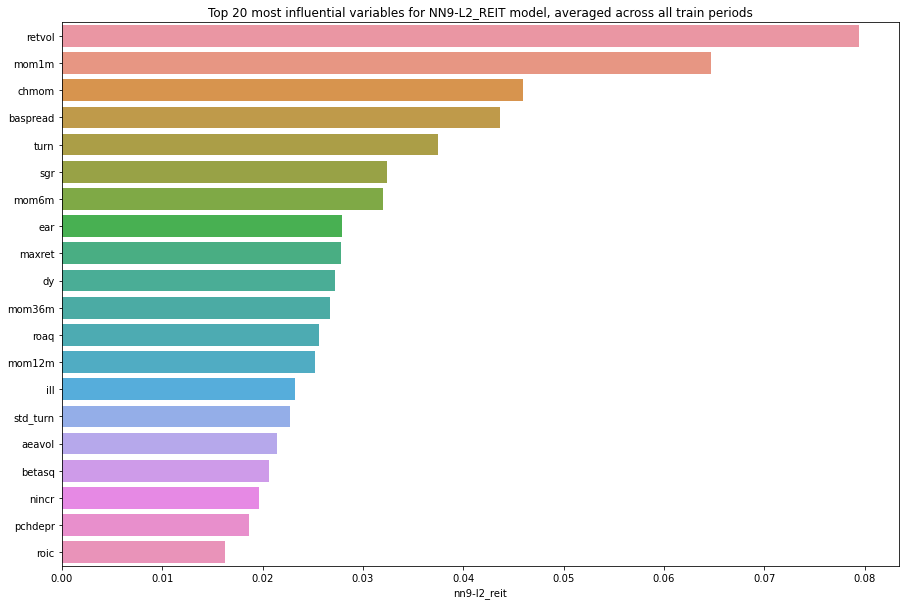

In [8]:
# Plot features of importance
# Plot graph
df_top20 = df_impt.sort_values(by=[model_name], ascending = False).head(20)
plt.figure(figsize=(15,10))
plt.title(f'Top 20 most influential variables for {model_name.upper()} model, averaged across all train periods')
sns.barplot(data = df_top20, x = model_name, y = df_top20.index);

In [9]:
# Merge df_temp to existing df_r2drecrease table

df_r2decrease_reit = pd.merge(
    left = df_r2decrease_reit,
    right = df_impt[model_name],
    how = 'left',
    left_index = True,
    right_index = True    
)

# Rank R2decrease table after including new model results
df_featurerank_reit = df_r2decrease_reit.rank() 
df_featurerank_reit['all_models'] = df_featurerank_reit.sum(axis=1)

# Display tables
display(df_r2decrease_reit)
display(df_featurerank_reit.sort_values('all_models', ascending = False))

# Save dfs to .csv 
df_r2decrease_reit.to_csv('../data/df_r2decrease_reit.csv', index = True)
df_featurerank_reit.to_csv('../data/df_featurerank_reit.csv', index = True)

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
absacc           0.000306   -0.001380    0.000189    0.000000   0.000000   
acc              0.001430   -0.000741    0.001779    0.000000   0.000000   
aeavol           0.000650    0.000668    0.005239    0.001173   0.001226   
age              0.000137   -0.000080    0.001680    0.000018   0.000030   
agr              0.000223    0.005201    0.003357    0.000000   0.000010   
baspread         0.007390    0.007871    0.000149    0.000000   0.000000   
beta             0.008894    0.057075    0.000315    0.000000   0.000000   
betasq           0.013997    0.013039    0.002645    0.000000   0.000000   
bm               0.001241    0.000853    0.024032    0.025538   0.026162   
bm_ia            0.002404    0.004776    0.007611    0.004235   0.004285   
cash             0.000161    0.000505    0.003340    0.000873   0.000927   
cashdebt         0.000128   -0.001187    0.000750    0.000000   0.000000   
cashpr           0.001257    0.002444    0.004893    0.001111   0.001181   
cfp              0.006021    0.006040    0.008196    0.013265   0.013306   
cfp_ia           0.001410    0.004166    0.007417    0.015930   0.015591   
chatoia          0.000082   -0.000040   -0.000983   -0.000089  -0.000097   
chcsho           0.000206   -0.000878    0.005366    0.002707   0.002796   
chempia          0.001031    0.003782   -0.000006    0.000000   0.000000   
chinv            0.000245   -0.000393    0.000482    0.000000   0.000000   
chmom            0.052654    0.050540    0.096469    0.142593   0.139152   
chpmia           0.002182    0.002565    0.011188    0.005567   0.005818   
chtx            -0.000017   -0.000019    0.000188    0.000000   0.000000   
cinvest          0.000038    0.000148    0.000281    0.000000   0.000000   
convind          0.000886    0.000794    0.000866    0.000000   0.000000   
currat           0.091179    0.044869   -0.000742    0.000000   0.000000   
depr            -0.000063    0.000391    0.001464    0.000148   0.000158   
divi             0.000153    0.000328    0.000156    0.000000   0.000000   
divo             0.000145    0.000922    0.000460    0.000000   0.000000   
dolvol           0.052843    0.089712    0.018587    0.017184   0.017007   
dy               0.016294    0.015071    0.090116    0.083019   0.084596   
ear              0.000198    0.000341    0.007511    0.004939   0.005175   
egr              0.001280    0.002940    0.004116    0.001198   0.001247   
ep               0.001748    0.010111    0.008772    0.004712   0.004875   
gma              0.003155   -0.001219    0.004361    0.000000   0.000000   
grcapx           0.000474    0.000658   -0.000177    0.000000   0.000000   
grltnoa          0.002414    0.001948    0.004432    0.000000   0.000000   
herf             0.023766    0.022687    0.023490    0.026236   0.026005   
hire             0.000198    0.002251    0.000338    0.000000   0.000000   
idiovol          0.000873   -0.000939    0.012297    0.014589   0.014951   
ill              0.005484    0.010939    0.022225    0.013264   0.013836   
indmom          -0.000049    0.000309    0.000357    0.000269   0.000290   
invest           0.000890    0.000858    0.002343    0.000000   0.000000   
lev             -0.000274   -0.002811   -0.002411    0.000000   0.000000   
lgr              0.000145    0.000304    0.000079    0.000000   0.000000   
maxret           0.025620    0.054758    0.005975    0.000000   0.000000   
mom12m           0.004666    0.002331    0.047325    0.017174   0.020037   
mom1m            0.019050    0.030089    0.134880    0.123642   0.127685   
mom36m           0.004236    0.006796    0.023669    0.021621   0.022049   
mom6m            0.056381    0.030482    0.053236    0.127055   0.120789   
ms               0.000196    0.000743    0.002229    0.000000   0.000000   
mve0             0.200379    0.212738    0.122775    0.137827   0.135776   
mve_ia           0.116817    0.152169    0.033515    0.073484   0.

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
mom1m               84.0        84.0        94.0        91.0       92.0   
retvol              93.0        86.0        90.0        87.0       87.0   
chmom               87.0        89.0        92.0        94.0       94.0   
mom12m              74.0        60.0        88.0        82.0       83.0   
mom6m               89.0        85.0        89.0        92.0       91.0   
dy                  83.0        82.0        91.0        90.0       90.0   
mve0                94.0        94.0        93.0        93.0       93.0   
sgr                 79.0        76.0        87.0        88.0       88.0   
ill                 75.0        78.0        82.0        78.0       79.0   
mom36m              72.0        72.0        84.0        84.0       84.0   
herf                85.0        83.0        83.0        86.0       85.0   
maxret              86.0        90.0        68.0        26.0       25.5   
ear                 29.0        33.0        72.0        74.0       74.0   
cfp                 76.0        71.0        75.0        79.0       78.0   
bm                  54.0        47.0        85.0        85.0       86.0   
dolvol              88.0        92.0        81.0        83.0       82.0   
turn                77.0        79.0        40.0        62.0       62.0   
cfp_ia              57.0        67.0        71.0        81.0       81.0   
ep                  63.0        77.0        76.0        73.0       73.0   
pchdepr             43.0        35.0        57.0        67.0       66.0   
bm_ia               68.0        69.0        73.0        72.0       72.0   
chpmia              67.0        62.0        79.0        75.0       75.0   
tang                61.0        54.0        77.0        66.0       67.0   
betasq              81.0        80.0        49.0        26.0       25.5   
baspread            78.0        73.0        18.0        26.0       25.5   
sp                  59.0        75.0        66.0        76.0       76.0   
beta                80.0        91.0        26.0        26.0       25.5   
idiovol             48.0         7.0        80.0        80.0       80.0   
roavol              65.0        68.0        67.0        68.0       68.0   
roaq                62.0        65.0        69.0        26.0       25.5   
rd_sale             73.0        74.0        74.0        77.0       77.0   
roic                47.0         6.0        70.0        70.0       70.0   
saleinv             66.0        55.0        78.0        69.0       69.0   
chtx                 9.0        24.0        20.0        26.0       25.5   
mve_ia              92.0        93.0        86.0        89.0       89.0   
pchgm_pchsale       32.0        20.0        61.0        58.0       58.0   
std_dolvol          39.0        53.0        63.0        59.0       59.0   
invest              50.0        48.0        46.0        26.0       25.5   
cash                25.0        39.0        54.0        61.0       61.0   
rsup                51.0        14.0        48.0        55.0       55.0   
aeavol              46.0        43.0        64.0        64.0       64.0   
egr                 56.0        63.0        58.0        65.0       65.0   
stdacc              60.0        64.0        15.0        26.0       25.5   
pchsale_pchinvt     27.0        28.0        51.0        52.0       51.0   
chinv               36.0        12.0        34.0        26.0       25.5   
indmom               7.0        31.0        28.0        57.0       57.0   
agr                 35.0        70.0        55.0        26.0       48.0   
lev                  2.0         1.0         2.0        26.0       25.5   
zerotrade           82.0        57.0        50.0        53.0       52.0   
gma                 71.0         4.0        59.0        26.0       25.5   
nincr               37.0        13.0        53.0        49.0       49.0   
std_turn             3.0        15.0         5.0        26.0       25.5   
roeq                21.0        10.0      

## Evaluate features of importance

In [12]:
df_results_reit

Model Name                                    Selected Config  \
0         naive_reit                                               N.A.   
1            lr_reit                                               N.A.   
2   fama-french_reit                                           bm, mve0   
3       carhart_reit                                   bm, mve0, mom12m   
4         huber_reit                                      [3.0, 0.0001]   
5         ridge_reit                               [19920.457084538713]   
6         lasso_reit                              [0.07196856730011514]   
7          enet_reit                         [0.9, 0.07880462815669913]   
8           pcr_reit                                                 28   
9           pls_reit                                                  1   
10           rf_reit                                 [300, 0.2, 10, 70]   
11           et_reit                                 [200, 0.5, 15, 70]   
12           xg_reit                                  [100, 1, 0.01, 0]   
13       nn1-l2_reit  [<function l2 at 0x7fb45bb4c050>, 3.1622776601...   
14       nn3-l2_reit   [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.001]   
15       nn5-l2_reit    [<function l2 at 0x7fb45bb4c050>, 0.0001, 0.01]   
16       nn7-l2_reit  [<function l2 at 0x7fbd6a463050>, 3.1622776601...   
17       nn9-l2_reit  [<function l2 at 0x7fbd6a463050>, 0.0003162277...   

   Train (1990-2000) Validate (2001-2005) Test (2006-2020)  Test (2006)  \
0       0.00 (10.45)         0.00 (10.26)     0.00 (12.13)  0.00 (7.60)   
1        1.99 (10.3)          0.69 (10.2)    -0.03 (12.13)  4.17 (7.44)   
2        0.36 (10.4)          1.52 (10.2)     0.17 (12.12)  3.84 (7.45)   
3        0.52 (10.4)          1.68 (10.2)     0.16 (12.12)  4.37 (7.43)   
4       1.58 (10.36)         0.90 (10.21)    -0.07 (12.13)  3.50 (7.47)   
5       1.19 (10.38)         1.82 (10.16)     0.18 (12.12)  4.43 (7.43)   
6       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
7       1.28 (10.38)         1.93 (10.16)     0.23 (12.11)  4.37 (7.43)   
8       0.90 (10.40)         1.89 (10.16)     0.09 (12.12)  3.79 (7.46)   
9       1.03 (10.39)         1.71 (10.17)    -0.06 (12.13)  4.19 (7.44)   
10      13.97 (9.69)         2.31 (10.14)    -0.75 (12.17)  4.65 (7.42)   
11      5.56 (10.15)         1.63 (10.17)    -0.04 (12.13)  4.20 (7.44)   
12      1.00 (10.39)         1.78 (10.17)    -0.11 (12.13)  3.63 (7.46)   
13      2.84 (10.30)         1.40 (10.19)     0.17 (12.12)  3.04 (7.48)   
14      3.54 (10.26)         1.24 (10.19)     0.04 (12.13)  2.62 (7.50)   
15      0.84 (10.40)         1.55 (10.18)     0.23 (12.11)  2.50 (7.50)   
16      1.47 (10.37)         1.89 (10.16)     0.42 (12.10)  2.09 (7.52)   
17      0.66 (10.41)         1.32 (10.19)     0.32 (12.11)  2.45 (7.51)   

       Test (2007)    Test (2008)    Test (2009)   Test (2010)    Test (2011)  \
0     0.00 (11.29)   0.00 (19.81)   0.00 (25.18)  0.00 (12.47)   0.00 (10.08)   
1    -3.50 (11.48)  -0.55 (19.87)  -0.02 (25.19)  1.79 (12.36)  -2.03 (10.19)   
2    -4.46 (11.54)  -1.84 (19.99)   0.64 (25.10)  2.03 (12.34)  -0.68 (10.12)   
3    -3.46 (11.48)  -1.33 (19.94)   0.15 (25.16)  2.04 (12.34)  -0.71 (10.12)   
4    -2.04 (11.40)  -0.24 (19.84)  -0.24 (25.21)  0.25 (12.45)  -0.65 (10.12)   
5    -3.65 (11.49)  -1.12 (19.92)   0.16 (25.16)  1.98 (12.34)  -1.29 (10.15)   
6    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
7    -3.54 (11.49)  -1.09 (19.92)   0.26 (25.15)  2.08 (12.34)  -1.03 (10.14)   
8    -3.68 (11.49)  -1.31 (19.94)   0.20 (25.16)  2.13 (12.33)  -1.07 (10.14)   
9    -4.17 (11.52)  -1.10 (19.92)  -0.15 (25.20)  1.75 (12.36)  -1.84 (10.18)   
10  -11.55 (11.92)   0.56 (19.76)   0.03 (25.18)  3.62 (12.24)  -2.18 (10.19)   
11   -4.29 (11.53)  -0.31 (19.84)  -0.90 (25.30)  2.72 (12.30)  -1.07 (10.14)   
12   -5.46 (11.59)  -0.64 (19.88)  -0.44 (25.24)  0.98 (12.41)  -0.64 (10.12)   
13   -3.14 (11.46)  -0.9

In [13]:
df_r2decrease_reit 

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
absacc           0.000306   -0.001380    0.000189    0.000000   0.000000   
acc              0.001430   -0.000741    0.001779    0.000000   0.000000   
aeavol           0.000650    0.000668    0.005239    0.001173   0.001226   
age              0.000137   -0.000080    0.001680    0.000018   0.000030   
agr              0.000223    0.005201    0.003357    0.000000   0.000010   
baspread         0.007390    0.007871    0.000149    0.000000   0.000000   
beta             0.008894    0.057075    0.000315    0.000000   0.000000   
betasq           0.013997    0.013039    0.002645    0.000000   0.000000   
bm               0.001241    0.000853    0.024032    0.025538   0.026162   
bm_ia            0.002404    0.004776    0.007611    0.004235   0.004285   
cash             0.000161    0.000505    0.003340    0.000873   0.000927   
cashdebt         0.000128   -0.001187    0.000750    0.000000   0.000000   
cashpr           0.001257    0.002444    0.004893    0.001111   0.001181   
cfp              0.006021    0.006040    0.008196    0.013265   0.013306   
cfp_ia           0.001410    0.004166    0.007417    0.015930   0.015591   
chatoia          0.000082   -0.000040   -0.000983   -0.000089  -0.000097   
chcsho           0.000206   -0.000878    0.005366    0.002707   0.002796   
chempia          0.001031    0.003782   -0.000006    0.000000   0.000000   
chinv            0.000245   -0.000393    0.000482    0.000000   0.000000   
chmom            0.052654    0.050540    0.096469    0.142593   0.139152   
chpmia           0.002182    0.002565    0.011188    0.005567   0.005818   
chtx            -0.000017   -0.000019    0.000188    0.000000   0.000000   
cinvest          0.000038    0.000148    0.000281    0.000000   0.000000   
convind          0.000886    0.000794    0.000866    0.000000   0.000000   
currat           0.091179    0.044869   -0.000742    0.000000   0.000000   
depr            -0.000063    0.000391    0.001464    0.000148   0.000158   
divi             0.000153    0.000328    0.000156    0.000000   0.000000   
divo             0.000145    0.000922    0.000460    0.000000   0.000000   
dolvol           0.052843    0.089712    0.018587    0.017184   0.017007   
dy               0.016294    0.015071    0.090116    0.083019   0.084596   
ear              0.000198    0.000341    0.007511    0.004939   0.005175   
egr              0.001280    0.002940    0.004116    0.001198   0.001247   
ep               0.001748    0.010111    0.008772    0.004712   0.004875   
gma              0.003155   -0.001219    0.004361    0.000000   0.000000   
grcapx           0.000474    0.000658   -0.000177    0.000000   0.000000   
grltnoa          0.002414    0.001948    0.004432    0.000000   0.000000   
herf             0.023766    0.022687    0.023490    0.026236   0.026005   
hire             0.000198    0.002251    0.000338    0.000000   0.000000   
idiovol          0.000873   -0.000939    0.012297    0.014589   0.014951   
ill              0.005484    0.010939    0.022225    0.013264   0.013836   
indmom          -0.000049    0.000309    0.000357    0.000269   0.000290   
invest           0.000890    0.000858    0.002343    0.000000   0.000000   
lev             -0.000274   -0.002811   -0.002411    0.000000   0.000000   
lgr              0.000145    0.000304    0.000079    0.000000   0.000000   
maxret           0.025620    0.054758    0.005975    0.000000   0.000000   
mom12m           0.004666    0.002331    0.047325    0.017174   0.020037   
mom1m            0.019050    0.030089    0.134880    0.123642   0.127685   
mom36m           0.004236    0.006796    0.023669    0.021621   0.022049   
mom6m            0.056381    0.030482    0.053236    0.127055   0.120789   
ms               0.000196    0.000743    0.002229    0.000000   0.000000   
mve0             0.200379    0.212738    0.122775    0.137827   0.135776   
mve_ia           0.116817    0.152169    0.033515    0.073484   0.

In [18]:
df_r2decrease_reit.columns

Index(['lr_reit', 'huber_reit', 'ridge_reit', 'lasso_reit', 'enet_reit',
       'pcr_reit', 'pls_reit', 'rf_reit', 'et_reit', 'xg_reit', 'nn1-l2_reit',
       'nn3-l2_reit', 'nn5-l2_reit', 'nn7-l2_reit', 'nn9-l2_reit'],
      dtype='object')

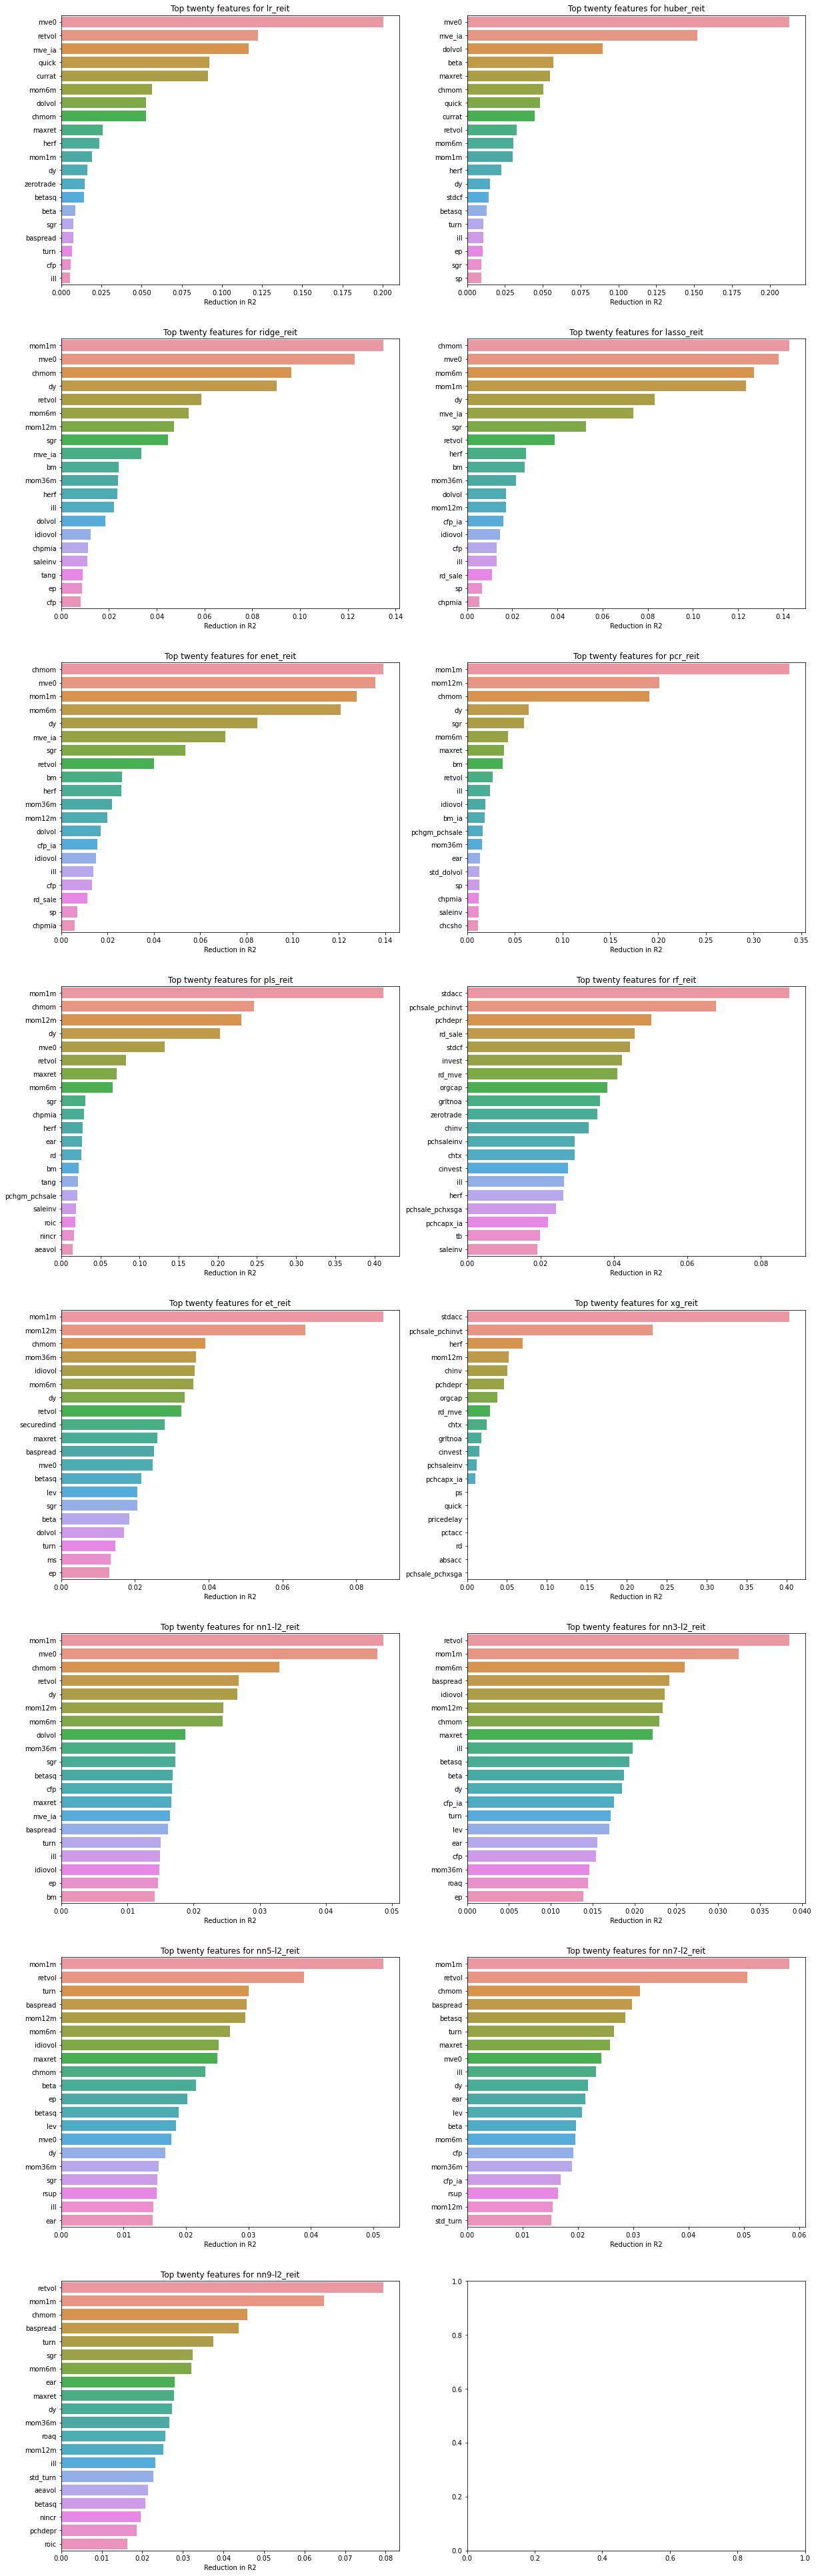

In [34]:
fig, axes = plt.subplots(8, 2, figsize=(20, 70))

# fig.suptitle('Features of importance by model')

y_variable = 'saleprice'

for model, axes in zip(df_r2decrease_reit.columns, axes.flat):
    df_top20 = df_r2decrease_reit.sort_values(by = [model], ascending = False).head(20)
    sns.barplot(
        ax = axes, 
        data = df_top20, 
        x = model, 
        y = df_top20.index
    )
#     axes.title.set_text(f'Top twenty features for {model}')
    axes.set_title(f'Top twenty features for {model}')
    axes.set_xlabel(f'Reduction in R2')

In [36]:
df_featurerank_reit.sort_values('all_models', ascending = False)

lr_reit  huber_reit  ridge_reit  lasso_reit  enet_reit  \
mom1m               84.0        84.0        94.0        91.0       92.0   
retvol              93.0        86.0        90.0        87.0       87.0   
chmom               87.0        89.0        92.0        94.0       94.0   
mom12m              74.0        60.0        88.0        82.0       83.0   
mom6m               89.0        85.0        89.0        92.0       91.0   
dy                  83.0        82.0        91.0        90.0       90.0   
mve0                94.0        94.0        93.0        93.0       93.0   
sgr                 79.0        76.0        87.0        88.0       88.0   
ill                 75.0        78.0        82.0        78.0       79.0   
mom36m              72.0        72.0        84.0        84.0       84.0   
herf                85.0        83.0        83.0        86.0       85.0   
maxret              86.0        90.0        68.0        26.0       25.5   
ear                 29.0        33.0        72.0        74.0       74.0   
cfp                 76.0        71.0        75.0        79.0       78.0   
bm                  54.0        47.0        85.0        85.0       86.0   
dolvol              88.0        92.0        81.0        83.0       82.0   
turn                77.0        79.0        40.0        62.0       62.0   
cfp_ia              57.0        67.0        71.0        81.0       81.0   
ep                  63.0        77.0        76.0        73.0       73.0   
pchdepr             43.0        35.0        57.0        67.0       66.0   
bm_ia               68.0        69.0        73.0        72.0       72.0   
chpmia              67.0        62.0        79.0        75.0       75.0   
tang                61.0        54.0        77.0        66.0       67.0   
betasq              81.0        80.0        49.0        26.0       25.5   
baspread            78.0        73.0        18.0        26.0       25.5   
sp                  59.0        75.0        66.0        76.0       76.0   
beta                80.0        91.0        26.0        26.0       25.5   
idiovol             48.0         7.0        80.0        80.0       80.0   
roavol              65.0        68.0        67.0        68.0       68.0   
roaq                62.0        65.0        69.0        26.0       25.5   
rd_sale             73.0        74.0        74.0        77.0       77.0   
roic                47.0         6.0        70.0        70.0       70.0   
saleinv             66.0        55.0        78.0        69.0       69.0   
chtx                 9.0        24.0        20.0        26.0       25.5   
mve_ia              92.0        93.0        86.0        89.0       89.0   
pchgm_pchsale       32.0        20.0        61.0        58.0       58.0   
std_dolvol          39.0        53.0        63.0        59.0       59.0   
invest              50.0        48.0        46.0        26.0       25.5   
cash                25.0        39.0        54.0        61.0       61.0   
rsup                51.0        14.0        48.0        55.0       55.0   
aeavol              46.0        43.0        64.0        64.0       64.0   
egr                 56.0        63.0        58.0        65.0       65.0   
stdacc              60.0        64.0        15.0        26.0       25.5   
pchsale_pchinvt     27.0        28.0        51.0        52.0       51.0   
chinv               36.0        12.0        34.0        26.0       25.5   
indmom               7.0        31.0        28.0        57.0       57.0   
agr                 35.0        70.0        55.0        26.0       48.0   
lev                  2.0         1.0         2.0        26.0       25.5   
zerotrade           82.0        57.0        50.0        53.0       52.0   
gma                 71.0         4.0        59.0        26.0       25.5   
nincr               37.0        13.0        53.0        49.0       49.0   
std_turn             3.0        15.0         5.0        26.0       25.5   
roeq                21.0        10.0      

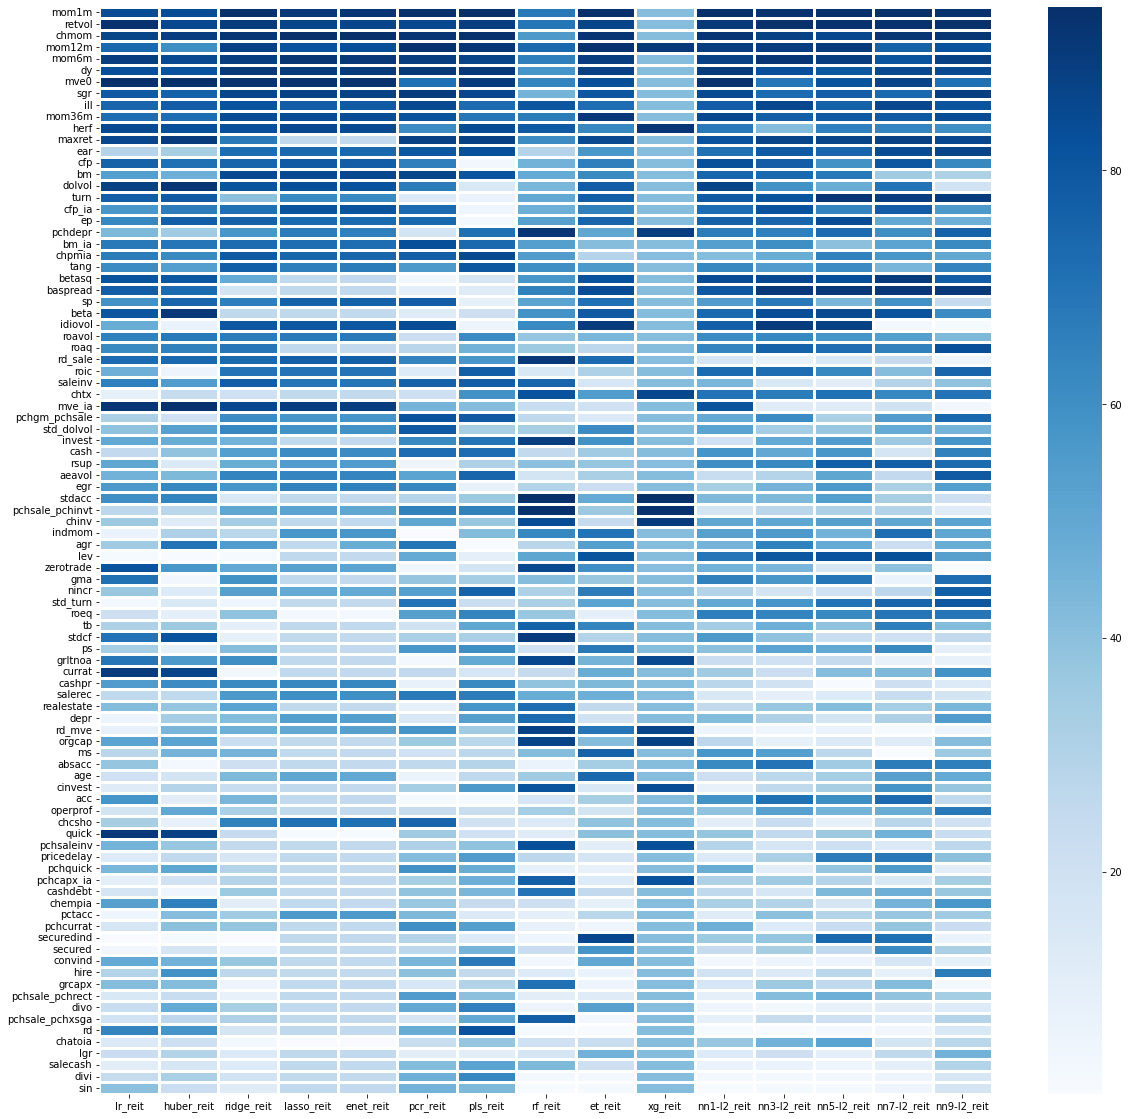

In [45]:
plt.figure(figsize=(20,20)) 

sns.heatmap(
    data = df_featurerank_reit.sort_values('all_models', ascending = False).drop(columns = "all_models"),
    linewidths = 3,
    cmap = "Blues"
);

## Marginal effect 

Working on mve0_lr_reit...
Working on mve0_enet_reit...
Working on mve0_pcr_reit...
Working on mve0_rf_reit...
Working on mve0_et_reit...
Working on mve0_nn7-l2_reit...
Working on mve0_nn9-l2_reit...
Working on retvol_lr_reit...
Working on retvol_enet_reit...
Working on retvol_pcr_reit...
Working on retvol_rf_reit...
Working on retvol_et_reit...
Working on retvol_nn7-l2_reit...
Working on retvol_nn9-l2_reit...
Working on bm_lr_reit...
Working on bm_enet_reit...
Working on bm_pcr_reit...
Working on bm_rf_reit...
Working on bm_et_reit...
Working on bm_nn7-l2_reit...
Working on bm_nn9-l2_reit...
Working on ep_lr_reit...
Working on ep_enet_reit...
Working on ep_pcr_reit...
Working on ep_rf_reit...
Working on ep_et_reit...
Working on ep_nn7-l2_reit...
Working on ep_nn9-l2_reit...
Working on mom12m_lr_reit...
Working on mom12m_enet_reit...
Working on mom12m_pcr_reit...
Working on mom12m_rf_reit...
Working on mom12m_et_reit...
Working on mom12m_nn7-l2_reit...
Working on mom12m_nn9-l2_reit...


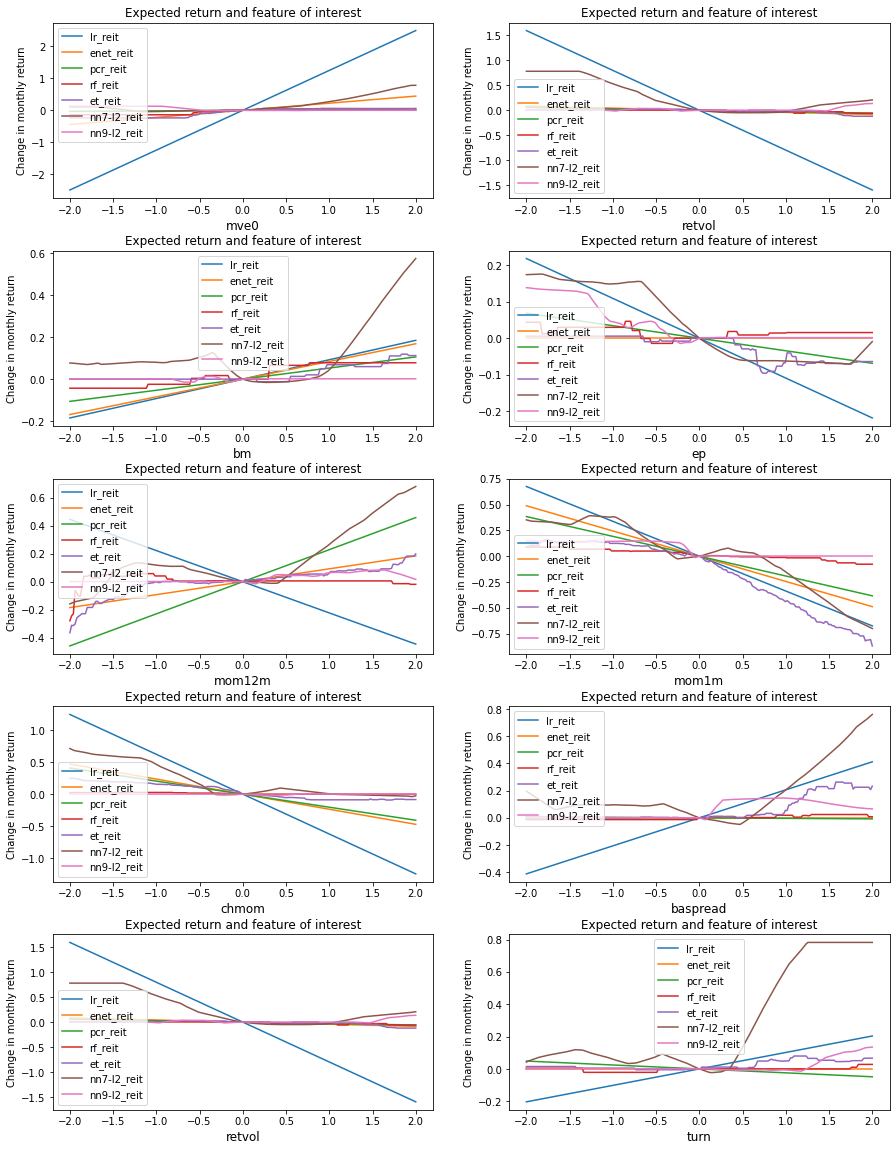

In [193]:
%%time
# Create subplots, set all features to zero, varying values for the feature of interest

fig, axes = plt.subplots(5, 2, figsize=(15,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

year = 2020
length = np.linspace(-2, 2, 200)

features = ['mve0', 'retvol', 'bm', 'ep', 'mom12m', 'mom1m', 'chmom', 'baspread', 'retvol', 'turn']
models = ['lr_reit', 'enet_reit', 'pcr_reit', 'rf_reit', 'et_reit']
models_nn = ['nn7-l2_reit', 'nn9-l2_reit']



for feature, ax in zip(features, axes.flat):
    
    # Standard models
    for model_name in models:
        print(f'Working on {feature}_{model_name}...')
        
        # Load pickled models
        filename = f'../pickle/{model_name}_{year}.pkl'
        model = pickle.load(open(filename,'rb'))
        
        # Initial settings
        X_test = pd.DataFrame(np.zeros((1, len(X_reit.columns))), columns = X_reit.columns)
        baseline_ret = model_predict(model, X_test)
        change_in_ret = []
        
        # Sensitivity test
        for i in length:
            X_test[feature] = i
            change = (model_predict(model, X_test) ) - baseline_ret
            change_in_ret.append(change[0]) 
        ax.plot(length, change_in_ret, label = model_name)
    
    # Neural network
    for model_name in models_nn:
        print(f'Working on {feature}_{model_name}...')
        
        # Load pickled models
        filename = f'../pickle/{model_name}_{year}_0'
        model = load_model(filename)
        
        # Initial settings
        X_test = pd.DataFrame(np.zeros((1, len(X_reit.columns))), columns = X_reit.columns)
        baseline_ret = model_predict(model, X_test)
        change_in_ret = []
       
        for i in length:
            X_test[feature] = i
            change = (model_predict(model, X_test) ) - baseline_ret
            change_in_ret.append(change[0]) 
        ax.plot(length, change_in_ret, label = model_name)    
        
    ax.legend()
    ax.set_title('Expected return and feature of interest')
    ax.set_ylabel('Change in monthly return');
    ax.set_xlabel(feature, fontsize = 12);

## Interaction effect

Working on bm_mve0_-2.0...
Working on bm_mve0_-1.0...
Working on bm_mve0_0.0...
Working on bm_mve0_1.0...
Working on bm_mve0_2.0...
Working on ep_mve0_-2.0...
Working on ep_mve0_-1.0...
Working on ep_mve0_0.0...
Working on ep_mve0_1.0...
Working on ep_mve0_2.0...
Working on mom12m_mve0_-2.0...
Working on mom12m_mve0_-1.0...
Working on mom12m_mve0_0.0...
Working on mom12m_mve0_1.0...
Working on mom12m_mve0_2.0...
Working on mom1m_mve0_-2.0...
Working on mom1m_mve0_-1.0...
Working on mom1m_mve0_0.0...
Working on mom1m_mve0_1.0...
Working on mom1m_mve0_2.0...
Working on chmom_mve0_-2.0...
Working on chmom_mve0_-1.0...
Working on chmom_mve0_0.0...
Working on chmom_mve0_1.0...
Working on chmom_mve0_2.0...
Working on baspread_mve0_-2.0...
Working on baspread_mve0_-1.0...
Working on baspread_mve0_0.0...
Working on baspread_mve0_1.0...
Working on baspread_mve0_2.0...
Working on retvol_mve0_-2.0...
Working on retvol_mve0_-1.0...
Working on retvol_mve0_0.0...
Working on retvol_mve0_1.0...
Workin

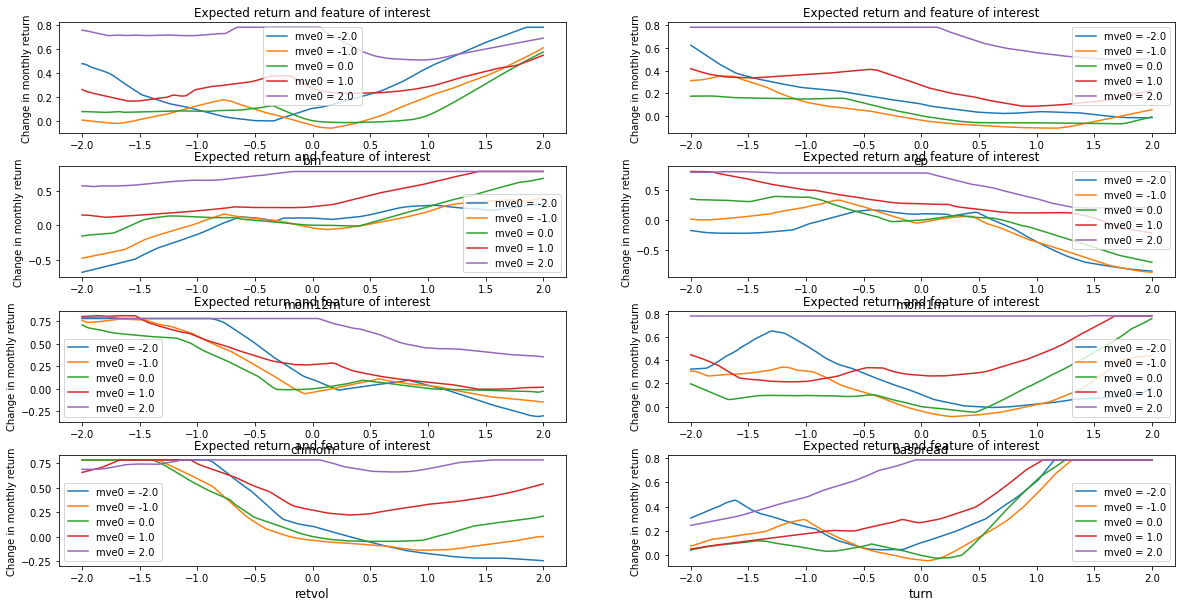

In [194]:
%%time
# Create subplots, set all features to zero, varying values for interacting terms

fig, axes = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

# Load pickled models
model_name = 'nn7-l2_reit'
year = 2020
filename = f'../pickle/{model_name}_{year}_0'
model = load_model(filename)

# Variables of interest
feature_1 = ['bm', 'ep', 'mom12m', 'mom1m', 'chmom', 'baspread', 'retvol', 'turn']
length_1 = np.linspace(-2, 2, 200)
feature_2 = 'mve0'
length_2 = np.linspace(-2, 2, 5)

for feature, ax in zip(feature_1, axes.flat):
     # Initial settings
    X_test = pd.DataFrame(np.zeros((1, len(X_reit.columns))), columns = X_reit.columns)
    baseline_ret = model_predict(model, X_test)
   
    # Neural network
    for i in length_2:
        print(f'Working on {feature}_{feature_2}_{i}...')
        
        X_test[feature_2] = i
        
        change_in_ret = []
        for j in length_1:
            X_test[feature] = j
            change = (model_predict(model, X_test) ) - baseline_ret
            change_in_ret.append(change[0]) 
        ax.plot(length, change_in_ret, label = f'{feature_2} = {i}')    
        
    ax.legend()
    ax.set_title('Expected return and feature of interest')
    ax.set_ylabel('Change in monthly return');
    ax.set_xlabel(feature, fontsize = 12);